### Functions

In [ ]:
fontsize = 13

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import math
from itertools import combinations
from itertools import compress
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import sys
import glob
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# # Dynamic Time Warping
# !pip install dtw-python
# from dtw import *

# Forecast models
#!pip install -U statsmodels
# import statsmodels.api as sm
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import kpss
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf
# from statsmodels.tsa.stattools import ccf
# from statsmodels.tsa.stattools import acf
# from statsmodels.tsa.stattools import pacf
# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import *
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.feature_extraction import  *
from sklearn.base import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.svm import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.neighbors import *
from imblearn.over_sampling import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
import random

# Scipy
from scipy.stats import *
#from 

# Warnings
import warnings

# Prophet
#!python -m pip install prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from dask.distributed import Client
from prophet.utilities import regressor_coefficients
 
# To register elapsed time
import time

# Save objects to files
import pickle

# Itertools - Combinations
import itertools
from itertools import chain, repeat, count, islice

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)

  # Drive path
  %cd $drive_path

##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "linear"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df

##### Transform data series

In [ ]:
# Apply differences to a time series panda dataframe
def diff_time_series_df(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df


# Apply differences to a time series panda series
def diff_time_series(df, diff_order):
  
  # diff_order - how many times data must be differenced

  df = df.copy()

  for order in range(diff_order):
    df = df.diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [ ]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value, interpolation_method):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  n_samples = df.groupby(id)[value].size()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = [id])["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes
  
  df = pd.concat([df, n_samples], axis = 1)
  df.columns = ["n_changes", "n_samples"]

  return df, product_id_ord

##### Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  # The interpolate methods that I used were either "linear" (linear interpolation) or "ffill" (repeat last value)
  return df.copy().interpolate(method = method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price, fig_size = (10, 5)):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price,fig_size = (10, 5)):

  df = df.copy()

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price, fig_size = (10, 5)):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro", fig_size = (10, 5)):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price, fig_size)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price, fig_size)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price, fig_size)

##### Performance Metrics

In [ ]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

In [ ]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Test stationarity

In [ ]:
def adf_test_results(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.round(4))


def kpss_test_results(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


def adf_test(timeseries, p_value_max):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput["is_stationary"] = (dfoutput.loc["p-value"] < p_value_max)

    return dfoutput

def kpss_test(timeseries, p_value_max):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3],
        index=[
               "Test Statistic",
               "p-value",
               "Lags Used"
               ]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    kpss_output["is_stationary"] = (kpss_output.loc["p-value"] > p_value_max)

    return kpss_output


def test_stationarity(timeseries, stationary_tests, p_values_max):
  
  is_stationary = []
  p_values = []
  test_results = []

  for stationary_test, p_value_max in zip(stationary_tests, p_values_max):
    test_result = stationary_test(timeseries, p_value_max)
    is_stationary.append(test_result.loc['is_stationary'])
    p_values.append(test_result.loc['p-value'])
    test_results.append(test_result)

  print("P-Values: ", p_values)

  is_overall_stationary = all(is_stationary)
  if is_overall_stationary:
    print("The timeseries is stationary.")
  else:
    print("Can't confirm the series is stationary.")

  return p_values, test_results, is_stationary, is_overall_stationary

##### Linear models

In [ ]:
def get_lags(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  timeseries_diff = diff_time_series(timeseries, diff_order)
  acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha)
  pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)

  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1]-acf_coeff)   | (acf_coeff  < acf_confint[:,0]-acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]-pacf_coeff) | (pacf_coeff < pacf_confint[:,0]-pacf_coeff)).astype(int))

  return acf_lags, pacf_lags

In [ ]:
def plot_results(title, obs, pred, confint, fig_size):
    
    # Graph
    fig, ax = plt.subplots(figsize=(fig_size))
    ax.set(title=title, xlabel='Date', ylabel='Price/€')

    # Plot data points
    obs.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = confint
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower right')
    ax.set_ylim([min(obs)-100, max(obs)+100])

##### Naive models

In [ ]:
class EXPONENTIAL_SMOOTHING:
  def __init__(self):
    pass

  def get_prediction(self, data, smoothing_level):
    
    self.data = data.copy()
    self.beg = 11

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = SimpleExpSmoothing(self.data.iloc[:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast()

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')

    legend = ax.legend(loc='lower right')

##### Characteristics of timeseries

In [ ]:
def get_variance(series):
  return np.sum((series - np.mean(series))**2)/len(series)

##### Convert data to features

In [ ]:
def series_to_supervised(data, n_in=2, n_out=1, dropnan=True):
	
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """

  data = list(data)
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

###### Save figure

In [ ]:
def save_fig(plt, chapter_name, section_name, name_of_fig):
  path = 'Dissertação/Chapters/Imagens/Chapter_' + chapter_name + "/" + str.lower(chapter_name) + "_" + str.lower(section_name) + "_" + name_of_fig + "."
  print(path)
  plt.savefig(path + "svg")
  plt.savefig(path + "png", bbox_inches = "tight")
  plt.savefig(path + "pdf")

# Notebook: Basic_models

- **Goal**: implementation of simple models for short-term prediction of individual time series

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


### Get data

#### Read data

In [ ]:
#zip_name = "data/catalog_sample.zip"
#file_name = "catalog_sample.json"
#filetype = "json"
#df_og = zip_2_dataframe(zip_name, file_name, filetype)
df_og = pd.read_pickle("df_og")

#### Clean data and add unique identifiers to products, product groups and companies

In [ ]:
#df = clean_data(df_og.copy())
#df = add_ids(df)
df = pd.read_pickle("df_clean")

In [ ]:
df

,country_company,company_id,product_group_id,product_id,product,country,company,price,timestamp,offer_type,currency,price_clean,price_euro
0,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-22,unlocked,$,799.99,727.726735
1,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-21,unlocked,$,799.99,727.726735
2,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-20,unlocked,$,799.99,727.726735
3,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-19,unlocked,$,799.99,727.726735
4,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-18,unlocked,$,799.99,727.726735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602051,CL claro,19,958,3222,huawei Y9S 128GB,CL,claro,"$229,990",2020-06-21,unlocked,$,229.99,209.214955
602052,CO Claro,5,958,3234,huawei Y9S 128GB,CO,Claro,"$1,168,900",2020-06-21,unlocked,$,1168.90,1063.313017
602053,CO Tigo,3,958,3228,huawei Y9S 128GB,CO,Tigo,"$1,079,900",2020-06-21,unlocked,$,1079.90,982.352406
602054,PE Movistar,23,960,3236,huawei Y9S 128GB,PE,Movistar,"S/1,519",2020-06-20,postpaid_portability,S,1519.00,364.560000


#### Interpolate data

In [ ]:
id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

#df_inter = df[[id, value, time]].sort_values([id, time])                         
#df_inter = df_inter.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})
#df_inter.to_pickle("df_inter_fill")
df_inter = pd.read_pickle("df_inter_fill")

#### Order products by number of changes in time series

In [ ]:
# df_changes_linear, product_id_ord_linear = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "linear")
# df_changes_fill, product_id_ord_fill = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "ffill")

# counts = []
# for i in range(min(df_changes_fill["n_changes"]), max(df_changes_fill["n_changes"])):
#   counts.append(len(df_changes_fill["n_changes"][df_changes_fill["n_changes"] > i]))

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(counts)
# #ax.set_yscale('log')
# plt.title("Nº of examples that have more than a certain number of changes");

In [ ]:
df_changes_linear = pd.read_pickle("df_changes_linear")
df_changes_fill = pd.read_pickle("df_changes_fill")
product_id_ord_linear = np.load("product_id_ord_linear.npy")
product_id_ord_fill = np.load("product_id_ord_fill.npy")

### Visualize data

#### Visualize time series

In [ ]:
product_id = [product_id_ord_fill[800]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  327


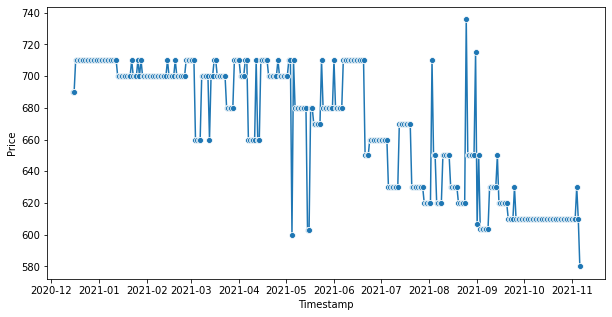

In [ ]:
product_id = [product_id_ord_fill[11]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")
plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.lineplot(x="timestamp", y="price_euro", data=df_product, marker = 'o').set(xlabel='Timestamp', ylabel='Price')
if len(product_id) == 1:
  #ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
  print("Number of samples: ", len(df_product))
#ax.figure.savefig("Dissertação/Chapters/Imagens/data_two_changes_timeseries.png")

Number of samples:  133


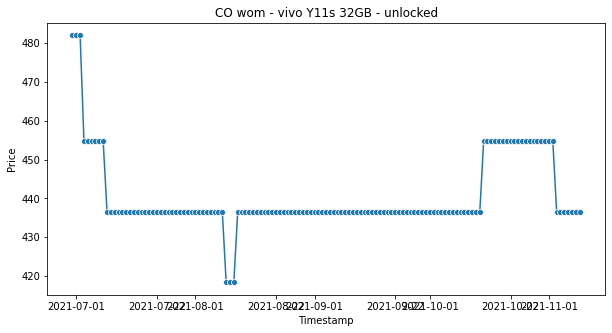

In [ ]:
product_id = [product_id_ord_fill[1000]]
#product_id = [1124]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.lineplot(x="timestamp", y="price_euro", data=df_product, marker = 'o')
ax.set(xlabel='Timestamp', ylabel='Price')

if len(product_id) == 1:
  ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
  print("Number of samples: ", len(df_product))

#ax.figure.savefig("Dissertação/Chapters/Imagens/data_two_changes_timeseries.png")

In [ ]:
show_time_series(df_product, "product_id", info)

KeyError: ignored

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

In [ ]:
#product_id = [product_id_ord_fill[800]]
product_id = 1124

df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

diff_order = 1
df_diff = diff_time_series_df(df_product, diff_order, columns = "price_euro")

# Difference
set_fig_size((5, 5))
sns_line = sns.lineplot(x = "timestamp", y = "price_euro", data = df_diff, marker = 'o')
sns_line.set_title("Differencing Order: " + str(diff_order))

### Prophet

#### Basic example

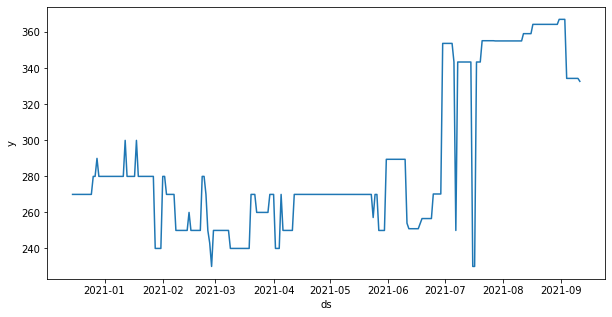

In [ ]:
i = 53
data = pd.DataFrame(df_all.loc[product_id_ord_fill[i]].price_euro).reset_index()
data.columns = ["ds", "y"]
sns.lineplot(data = data, x = "ds", y = "y")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ahiwymf/byc2txxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ahiwymf/q0o6h29g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43766', 'data', 'file=/tmp/tmp_ahiwymf/byc2txxr.json', 'init=/tmp/tmp_ahiwymf/q0o6h29g.json', 'output', 'file=/tmp/tmpaktfkdcw/prophet_model-20220922090911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:09:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:09:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


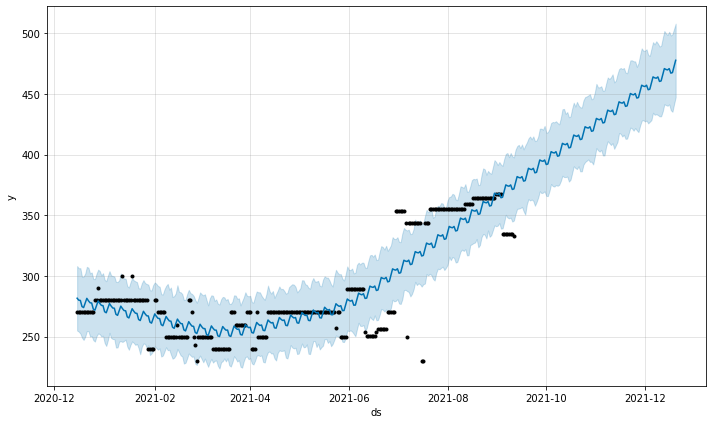

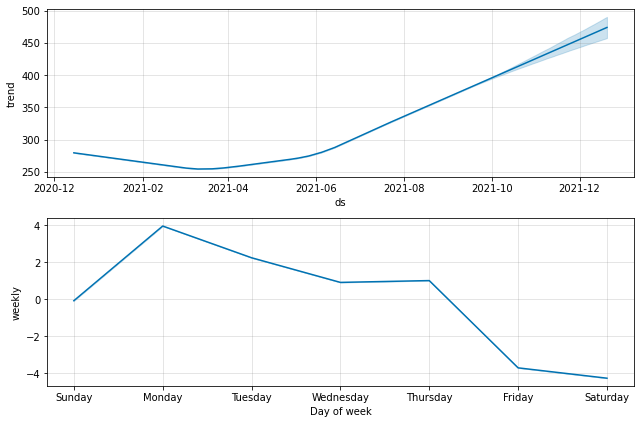

In [ ]:
# Python
m = Prophet(changepoint_prior_scale=0.05, weekly_seasonality = True)
m.add_seasonality(name='weekly', period=7, fourier_order=10)
#m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
#m.add_regressor('out_of_stock')
m.fit(data)
future = m.make_future_dataframe(periods=100)
#future["out_of_stock"] = 0
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [ ]:
df_cv = cross_validation(m, initial = '122 days', period= '30 days', horizon = '30 days')      # 4 months of initial
df_p = performance_metrics(df_cv)
nmse = get_nmse(df_cv["y"], df_cv["yhat"])
df_cv

#### Multivariate

##### Initialize data common to all cells

In [ ]:
df_all = pd.read_pickle("df_all")
df_pairs = pd.read_pickle("df_pairs_PT")

In [ ]:
df_country_min_max = pd.read_pickle("df_country_min_max")
df_country = df_all[df_all.country == "PT"]
product_group_id_lst = df_country_min_max.product_group_id.unique()

In [ ]:
n_samples = df_all.dropna().groupby(by = "product_id").count().price_euro
n_changes = df_all.dropna()["diff"]
n_changes = n_changes[n_changes != 0].groupby(by = "product_id").count()
n_samples = n_samples.loc[n_changes.index]

##### Visualize product group

In [ ]:
#adicionar estas conclusões à parte inicial do proactiviy e reactiivy - data science também é contar histórias - de que os retalhistas e operadores se tendem a seguir
# fazer country_min_max

153


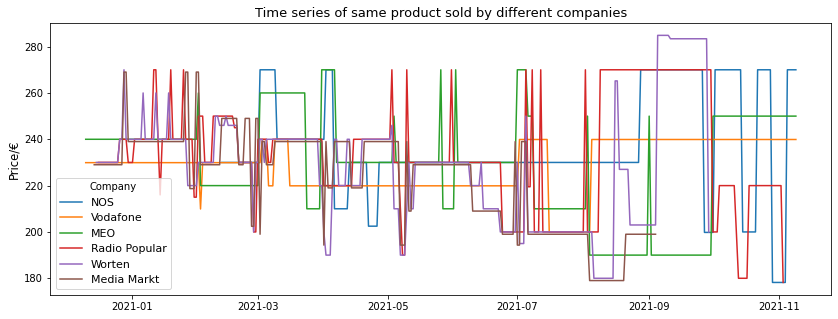

In [ ]:
# Todas as outras séries têm poucas empresas por produto ou são muito curtas

# The highest correlations are between the retailers
# High correlation product_group_id : 8 153 245 335 349 413 529 427 551 554 557 601
# High correlation but short: 23 921 199
# Hight correlation but just between retailers: 179  278 405 563 574
# Hight correlation but just between operators: 370 381
# Low correlation: 417 421 424 435 437 468 594
# Low correlation and short: 120 189 923
# Total: 28
# 28*5 = 140 previsões

#product_group_id = product_group_id_lst[8]
product_group_id = 153
print(product_group_id)
df_product_group_id = df_country[df_country.product_group_id == product_group_id]
set_fig_size((14, 5))
p = sns.lineplot(data = df_product_group_id, x = "timestamp", y = "price_euro", hue = "company")
p.set_xlabel("")
p.set_ylabel("Price/€", fontsize = fontsize - 1.5)
p.set_title("Time series of same product sold by different companies", fontsize = fontsize)
p.legend(title = "Company", fontsize = fontsize-2)

# Save fig
#save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "sameProductDifferentCompanies")

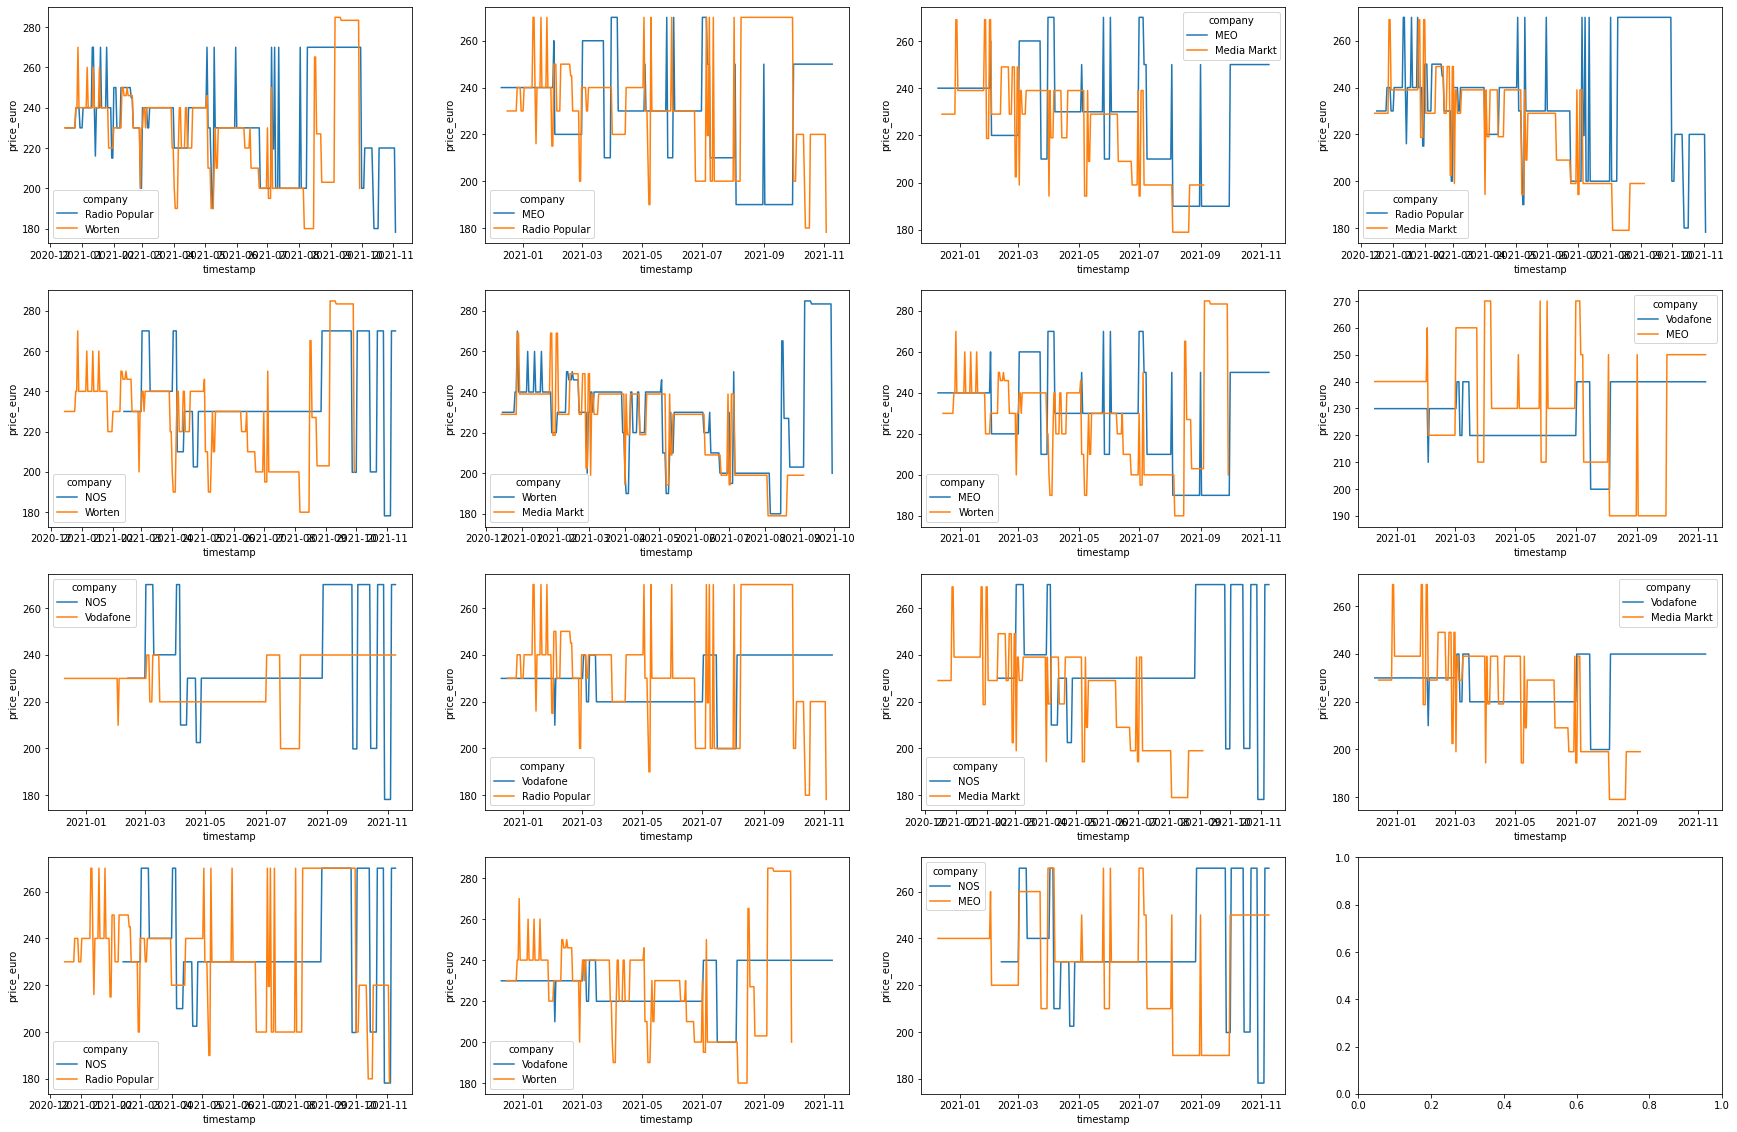

In [ ]:
companies_lst = df_product_group_id.company.unique( )
companies_lst_pairs = set(itertools.combinations(companies_lst, 2))

set_fig_size((30, 20))

n_lines = int(np.sqrt(len(companies_lst_pairs)))+1
n_cols = int(np.sqrt(len(companies_lst_pairs)))+1
fig, axes = plt.subplots(n_lines, n_cols)

for pair, ax in zip(companies_lst_pairs, axes.flatten()):
  sns.lineplot(data = df_product_group_id[df_product_group_id.company.isin(pair)], x = "timestamp", y = "price_euro", hue = "company", ax = ax)

Dissertação/Chapters/Imagens/Chapter_ArticleDETI/articledeti_prophet_comparisonTimeseriesRetailersOperators.


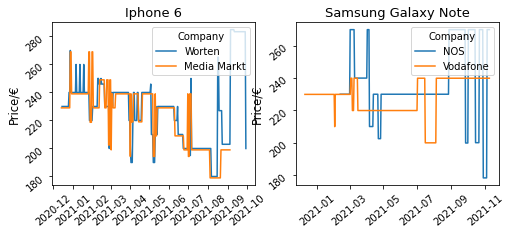

In [ ]:
pairs = [["Media Markt", "Worten"], ["NOS", "Vodafone"]]
titles = ["Iphone 6", "Samsung Galaxy Note"]
set_fig_size((8, 3))

fig, axes = plt.subplots(1, len(pairs))

for pair, ax, title in zip(pairs, axes, titles):
  p = sns.lineplot(data = df_product_group_id[df_product_group_id.company.isin(pair)], x = "timestamp", y = "price_euro", hue = "company", ax = ax)
  p.tick_params(labelrotation=40)
  p.set_xlabel("")
  p.set_ylabel("Price/€", fontsize = fontsize - 1.5)
  p.set_title(title, fontsize = fontsize)
  p.legend(title = "Company", loc = "upper right")

# Save fig
save_fig(plt, chapter_name = "ArticleDETI", section_name = "prophet", name_of_fig = "comparisonTimeseriesRetailersOperators")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_reactiveNotReactive.


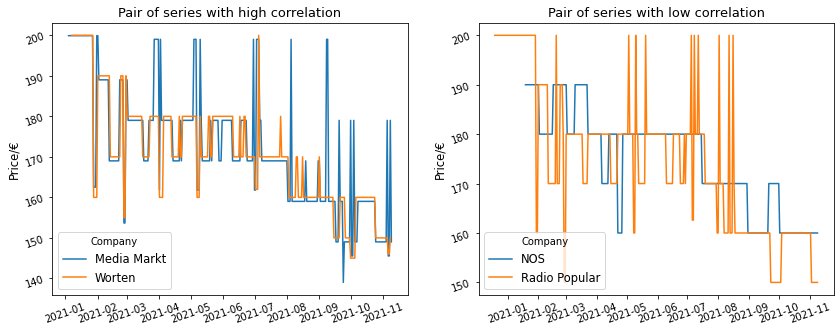

In [ ]:
pairs = [["Media Markt", "Worten"], ["NOS", "Radio Popular"]]
titles = ["Pair of series with high correlation", "Pair of series with low correlation"]
set_fig_size((14, 5))

fig, axes = plt.subplots(1, len(pairs))

for pair, ax, title in zip(pairs, axes, titles):
  p = sns.lineplot(data = df_product_group_id[df_product_group_id.company.isin(pair)], x = "timestamp", y = "price_euro", hue = "company", ax = ax)
  p.tick_params(labelrotation=19)
  p.set_xlabel("")
  p.set_ylabel("Price/€", fontsize = fontsize - 1.5)
  p.set_title(title, fontsize = fontsize)
  p.legend(title = "Company", fontsize = fontsize -1.5, loc = "lower left")


# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "reactiveNotReactive")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_classificationReactivity.


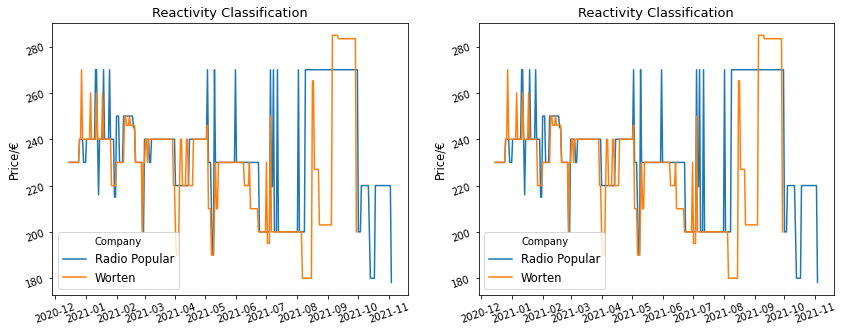

In [ ]:
pairs = [["Worten", "Radio Popular"], ["Worten", "Radio Popular"]]
titles = ["Reactivity Classification", "Reactivity Classification"]
set_fig_size((14, 5))

fig, axes = plt.subplots(1, len(pairs))

for pair, ax, title in zip(pairs, axes, titles):
  p = sns.lineplot(data = df_product_group_id[df_product_group_id.company.isin(pair)], x = "timestamp", y = "price_euro", hue = "company", ax = ax)
  p.tick_params(labelrotation=19)
  p.set_xlabel("")
  p.set_ylabel("Price/€", fontsize = fontsize - 1.5)
  p.set_title(title, fontsize = fontsize)
  p.legend(title = "Company", fontsize = fontsize -1.5, loc = "lower left")


# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "classificationReactivity")

In [ ]:
# Get number of samples that remain on each product_group_id after the intersection of the timeseries of each product_group_id
def get_n_samples_product_group_id(product_group_id, max_lag, feature_types):

  len_list = {}
  
  for product_group_id in product_group_id_lst:

    df_product_group_id = select_df_product_group_id(df_country_min_max, product_group_id)
    df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag)

    companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]
    company = companies[0]

    hyper_parameters =  {"changepoint_prior_scale": 0.05, "fourier_order": 0, "missing_values": 0, "holidays": 0, "included_companies": ["all", "self", "min_max"], "feature_types": ["price_euro"]}
    data = prepare_prophet_data(df_product_group_id, company, "_price_euro")
    len_list[str(product_group_id)] = len(data)
  
  return len_list

product_group_id_lst = [8, 153, 245, 335, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 405, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]
max_lag = 14
feature_types = ["price_euro", "diff"]
product_group_id_n_samples = get_n_samples_product_group_id(product_group_id_lst, max_lag, feature_types)
product_group_id_n_samples
# All the timeseries have a reasonable number of samples

NameError: ignored

##### Read hyper-parameters from univariate model

In [ ]:
def update_hyper_parameters(hyperparameters):
  hyperparameters["changepoint_prior_scale"] = min(hyperparameters["changepoint_prior_scale"], 0.05)    # so the trend doens't overfit
  hyperparameters["missing_values"] = 0                                                                 # so it can be compared with ARIMA model
  return hyperparameters
  
filenames_hyper_parameters = ["prophet_best_hyper_parameters_product_id_lst_0_29",
                              "prophet_best_hyper_parameters_product_id_lst_30_59",
                              "prophet_best_hyper_parameters_product_id_lst_60_99",
                              "prophet_best_hyper_parameters_product_id_lst_100_149",
                              "prophet_best_hyper_parameters_product_id_lst_150_199",
                              "prophet_best_hyper_parameters_product_id_lst_200_249",
                              "prophet_best_hyper_parameters_product_id_lst_250_299",
                              "prophet_best_hyper_parameters_product_id_lst_300_349",
                              "prophet_best_hyper_parameters_product_id_lst_350_399",
                              "prophet_best_hyper_parameters_product_id_lst_400_449"]

df_best_hyper_parameters_univariate = []
for filename_hyper_parameters in filenames_hyper_parameters:
  df_best_hyper_parameters_univariate.append(pd.read_pickle(filename_hyper_parameters))

df_best_hyper_parameters_univariate = pd.concat(df_best_hyper_parameters_univariate).set_index("product_id")
df_best_hyper_parameters_univariate["updated"] = df_best_hyper_parameters_univariate["hyperparameters"].apply(update_hyper_parameters)   

##### Functions for model creation

In [ ]:
def characterize_product_group(product_group_id):
  # High correlation product_group_id : 8 153 245 335 349 413 529 427 551 554 557 601
  # High correlation but short: 23 921 199
  # Hight correlation but just between retailers: 179  278 405 563 574
  # Hight correlation but just between operators: 370 381
  # Low correlation: 120 417 421 424 435 437 468 594
  # Low correlation and short: 189 923

  if product_group_id in  [8, 153, 245, 335, 349, 413, 529, 427, 551, 554, 557, 601]:
    return "high_correlation_all"
  elif product_group_id in [179, 278, 405, 563, 574]:
    return "high_correlation_retailers"
  elif product_group_id in [370, 381]:
    return "high_correlation_operators"
  elif product_group_id in [417, 424, 435, 437, 468, 594]:
    return "low_correlation_all"

# Determine if company is retailer or operator
def is_retailer_operator(company, country):
  if country == "PT":
    if company in ["Worten", "Radio Popular", "Media Markt"]:
      return "retailer"
    elif company in ["Vodafone", "MEO", "NOS"]:
      return "operator"

# Get number of changes of individual timeseries
def get_n_changes(timeseries):
  n_changes = timeseries.diff().dropna()
  n_changes = len(n_changes[n_changes != 0])
  return n_changes

# Select only the products from product_group_id and remove the timeseries that make the whole group too short. These timeseries were found manually, by visual inspection.
def select_df_product_group_id(df, product_group_id):
  df_product_group_id = df[df.product_group_id == product_group_id]
  companies = list(df_product_group_id.company.unique())

  if product_group_id in [8, 153, 245, 468, 551, 557]:
    companies.remove("NOS")
  elif product_group_id in [278]:
    companies.remove("Radio Popular")
  elif product_group_id in [574, 437]:
    companies.remove("Vodafone")
    companies.remove("NOS")

  df_product_group_id = df_product_group_id[df_product_group_id.company.isin(companies)]

  return df_product_group_id

# Get list of companies to be considered when doing prediction
def get_companies(company, existing_companies, all, self, min_max):
  
  retailers = ["Worten", "Radio Popular", "Media Markt"]
  operators = ["Vodafone", "MEO", "NOS"]
  
  if all == "all":
    companies = retailers + operators
  elif company in retailers:
    companies = retailers
  elif company in operators:
    companies = operators

  if self != "self":
    companies.remove(company)

  if min_max == "min_max":
    companies = companies + ["min_" + company, "max_" + company]

  if self == "just_self":
    companies = [company]
  
  companies = [company for company in companies if company in existing_companies]

  return companies

# Get all lagged timeseries that are relevant
def get_features_df_product_group_id(df_product_group_id, feature_types, max_lag, min_lag = 1):

  # Lag timeseries
  for feature_type in feature_types:
    for lag in range(min_lag, max_lag+1):
      df_product_group_id[feature_type + "_lag_" + str(lag)] = df_product_group_id.groupby(by = "product_id")[feature_type].shift(lag)

  df_product_group_id = df_product_group_id.dropna()

  # Missing values
  # df_product_group_id["price_euro_mv"] = df_product_group_id["price_euro"].where(df_product_group_id["out_of_stock"] == 0, np.nan)

  return df_product_group_id 

def prepare_prophet_data(df_product_group_id, company, y_type, min_lag):
  
  # Unstack
  df_product_group_id_unstack = df_product_group_id.reset_index().set_index(["company", "timestamp"])
  df_product_group_id_unstack = df_product_group_id_unstack.unstack(level=[0]).dropna()
  df_product_group_id_unstack.columns = list(map(lambda x : '_'.join((x[1], x[0])), df_product_group_id_unstack.columns))

  # Select ds and y
  data = df_product_group_id_unstack.reset_index()
  data["ds"] = data["timestamp"]
  data["y"] = data[company + y_type]
  return data

def generate_regressors(companies, feature_types, max_lag, min_lag = 1):
  regressors = []
  for company in companies:
    for feature in feature_types:
      for lag in range(min_lag, max_lag+1):
        regressor = company + "_" + feature
        if lag != 0:
          regressor = regressor + "_lag_" + str(lag)
        regressors.append(regressor)

  return regressors

def create_prophet_model(data, hyper_parameters, regressors, country):
  
  m = Prophet(changepoint_prior_scale = hyper_parameters["changepoint_prior_scale"], weekly_seasonality = False, yearly_seasonality = False)

  # Add linear regressors
  for regressor in regressors:
    m.add_regressor(regressor)

  # Seasonality
  if hyper_parameters["fourier_order"] != 0:
    m.add_seasonality(name='weekly', period=7, fourier_order = hyper_parameters["fourier_order"])
    m.add_seasonality(name='monthly', period=30.5, fourier_order = hyper_parameters["fourier_order"])      

  # Holidays
  if hyper_parameters["holidays"] == 1:
    m.add_country_holidays(country_name = country)

  # Fit model
  m.fit(data)

  return m

def get_prophet_model(df_product_group_id, max_lag, company, hyper_parameters, min_lag = 1):
  
  # # Missing values
  # if hyper_parameters["missing_values"] == 0:
  #   y_type = "_price_euro"
  # elif hyper_parameters["missing_values"] == 1:
  #   y_type = "_price_euro_mv"

  y_type = "_price_euro"

  # Get prophet data
  data = prepare_prophet_data(df_product_group_id, company, y_type, min_lag)

  # Get regressors
  existing_companies = list(df_product_group_id.company.unique())
  companies = get_companies(company, existing_companies, hyper_parameters["included_companies"][0], hyper_parameters["included_companies"][1], hyper_parameters["included_companies"][2])
  feature_types = hyper_parameters["feature_types"]
  regressors = generate_regressors(companies, feature_types, max_lag, min_lag)

  # Get prophet model
  country = df_product_group_id.country.unique()[0]
  m = create_prophet_model(data, hyper_parameters, regressors, country)

  return data, m

def get_hyper_parameters_default(df_best_hyper_parameters, product_id):

  if product_id in df_best_hyper_parameters.index:
    hyper_parameters = df_best_hyper_parameters.loc[product_id]["updated"]
  else:
    hyper_parameters = {"changepoint_prior_scale": 0.05,
                        "fourier_order": 0,         # aqui a ordem de fourir pode ser alterada consoante os resultados da lagged series
                        "missing_values": 0, 
                        "holidays" : 0}

  hyper_parameters["included_companies"] = ["similar", "self", "min_max"]
  
  hyper_parameters["feature_types"] = ["price_euro"]
  hyper_parameters["lags"] = 5

  return hyper_parameters

# Analyze weight of coefficient given to each linear regressor
def get_regressor_coefficients(m):
  df_regressor_coefficients = regressor_coefficients(m)
  df_regressor_coefficients["coef_abs"] = (df_regressor_coefficients["coef"]).abs()
  df_regressor_coefficients["center_abs"] = (df_regressor_coefficients["center"]).abs()
  df_regressor_coefficients["contains_0"] = (df_regressor_coefficients["coef_lower"]*df_regressor_coefficients["coef_upper"] < 0)
  return df_regressor_coefficients

# Dask process
client = Client()

###### Testing those functions

In [ ]:
# Test for just one comapny
# product_group_id = 245

# # Get features
# max_lag = 14
# feature_types = ["price_euro", "diff"]
# df_product_group_id = select_df_product_group_id(df_country_min_max, product_group_id)
# df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag)

# # Select company
# companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]
# company = companies[1]
# print("Company: ", company)
# print("Existing companies: ", companies)
# print("Product Group ID: ", product_group_id)

# # Get model
# product_id = df_product_group_id[df_product_group_id.company == company].index.get_level_values(0).unique()[0]
# hyper_parameters_default = get_hyper_parameters_default(df_best_hyper_parameters_univariate, product_id)
# #print(hyper_parameters_default)
# #data, m = get_prophet_model(df_product_group_id, max_lag, company, hyper_parameters_default)

# # # Forecast
# forecast = m.predict(data)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# fig1 = m.plot(forecast)
# fig2 = m.plot_components(forecast)

In [ ]:
# df_regressor_coefficients = get_regressor_coefficients(m)
# df_regressor_coefficients = df_regressor_coefficients.sort_values(by = "center_abs", ascending = False)
# print("Contains 0: ", len(df_regressor_coefficients[df_regressor_coefficients.contains_0]))

# set_fig_size((10,5))
# sns.histplot(data = df_regressor_coefficients, x = "coef")

# df_regressor_coefficients

In [ ]:
# # Compare timeseries of two different companies on the select product_group_id
# companies_view = [company, "min_Radio Popular"]
# df_product_group_id_view = df_product_group_id[df_product_group_id.company.isin(companies_view)]

# set_fig_size((10,5))
# sns.lineplot(data = df_product_group_id_view.reset_index(), x = "timestamp", y = "price_euro", hue = "company")

##### Cross-validation for hyper-parameters

In [ ]:
# Features
max_lag = 14
feature_types = ["price_euro", "diff"]
hyper_parameters_lists = {"included_companies" : [["all", "self", "min_max"], ["similar", "self", "min_max"]],
                          "feature_types": [["price_euro"], ["price_euro", "diff"]],
                          "fourier_order": [0, 10]}

# Initializations
all_info = []                       # store all info of each hyper-paramter for each timeseries
best_hyper_parameters = []          # store what are the best hyper parameters of each product_id
init_count = 20
end_count = 29
count = init_count-1

# Timeseries that weren't included in this list either were to short or had only one or two companies associated to a certain product. This will make it easier to analyse, with less simulations the impact of other timeseries
product_group_id_lst_multi = [8, 153, 245, 334, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 405, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]

for product_group_id in product_group_id_lst_multi[init_count:end_count+1]:

  count = count + 1

  # Select product_group_id
  df_product_group_id = select_df_product_group_id(df_country_min_max, product_group_id)
  df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag)

  companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]

  print("Count: ", count)
  print("Product Group ID: ", product_group_id)
  print("Existing companies: ", companies)
  
  for company in companies:

    print("\tCompany: ", company)
    
    # Get product basic informations
    product_id = df_product_group_id[df_product_group_id.company == company].index.get_level_values(0).unique()[0]
    hyper_parameters_default = get_hyper_parameters_default(df_best_hyper_parameters_univariate, product_id)
    base_info = {"product_id": product_id,
                 "company": company,
                 "company_id": df_product_group_id.loc[product_id].company_id.unique()[0],
                 "product_group_id": product_group_id,
                 "country": df_product_group_id.country.unique()[0],
                 "product": df_product_group_id["product"].unique()[0],
                 "offer_type": df_product_group_id.offer_type.unique()[0],
                 "product_group_characteristic": characterize_product_group(product_group_id),
                 "companies": companies,
                 "n_companies": len(companies),
                 "hyper_parameters_default": hyper_parameters_default,
                 "type_company": is_retailer_operator(company, df_product_group_id.country.unique()[0])}


    values = hyper_parameters_default.copy()    # keep the hyper-parameters to be tested in each iteration
    for hy_param_name, hy_param_list in hyper_parameters_lists.items():
      
      print("\t\t", hy_param_name, ": ", str(hy_param_list))

      best_hy_param = {"value": values[hy_param_name], "nmse": 100, "new_info": {}} 

      for hy_param in hy_param_list:
        
        # Update hyper-parameter
        values[hy_param_name] = hy_param

        # Get prophet model
        data, m = get_prophet_model(df_product_group_id, max_lag, company, values)
      
        # Cross-validation
        forecast = m.predict(data)
        forecast = forecast[['ds','trend','yhat','yhat_lower','yhat_upper','trend_lower','trend_upper','additive_terms','additive_terms_lower','additive_terms_upper','extra_regressors_additive','extra_regressors_additive_lower','extra_regressors_additive_upper']]       ,
        initial = 90
        period = 30
        horizon = 30
        df_cv = cross_validation(m, initial = str(initial) + 'days', period = str(period) + 'days', horizon = str(horizon) + 'days', parallel = "dask")      # 3 months of initial

        # Metrics
        df_p = performance_metrics(df_cv)
        nmse = get_nmse(df_cv["y"], df_cv["yhat"])

        # Regressor coeficients
        df_get_regressor_coefficients = get_regressor_coefficients(m)

        # Saving results
        new_info = {"n_samples": len(data["y"]),
                    "n_changes": get_n_changes(data["y"]),
                    "forecast": forecast,
                    "model": m,
                    "hyper_parameters": values.copy(),
                    "testing_param_name": hy_param_name,
                    "testing_param_value": hy_param,
                    "hyper_parameters_list": hy_param_list,
                    "hyper_parameters_names": hy_param_name,
                    "cross_validation_results": df_cv,
                    "performance_metrics" : df_p,
                    "nmse": nmse,
                    "regressor_coefficients": df_get_regressor_coefficients,
                    "cross_validation_initial": initial,
                    "cross_validation_period": period,
                    "cross_validation_horizon": horizon}

        info = base_info.copy()
        info.update(new_info)
        all_info.append(info)
        
        # Update best hyper-parameter
        if best_hy_param["nmse"] > nmse:
          best_hy_param = {"value": values[hy_param_name], "nmse": nmse, "new_info": new_info} 

      # Update values with best hyper-parameter so that in the next test this one is used
      values[hy_param_name] = best_hy_param["value"]

    best_info = base_info.copy()
    best_info.update(values)
    best_new_info = {key: new_info[key] for key in new_info if key not in ["testing_param_name", "testing_param_value"]}
    best_info.update(best_new_info)
    best_hyper_parameters.append(best_info)

df_best_hyper_parameters = pd.DataFrame(best_hyper_parameters)
df_best_hyper_parameters.to_pickle("prophet_multivariate_best_hyper_parameters_" + str(init_count) + "_" + str(end_count))
df_all_info = pd.DataFrame(all_info)
df_all_info.to_pickle("prophet_multivariate_all_info_" + str(init_count) + "_" + str(end_count))

In [ ]:
# Features
max_lag = 14
feature_types = ["price_euro", "diff"]
hyper_parameters_lists = {"included_companies" : [["all", "self", "min_max"], ["similar", "self", "min_max"], ["similar", "self", None], [None, "self", "min_max"], [None, "just_self", None]],
                          "lags" : [3, 5, 7, 14]}

# Initializations
all_info = []                       # store all info of each hyper-paramter for each timeseries
best_hyper_parameters = []          # store what are the best hyper parameters of each product_id
init_count = 0
end_count = 26
count = init_count-1

# Timeseries that weren't included in this list either were to short or had only one or two companies associated to a certain product. This will make it easier to analyse, with less simulations the impact of other timeseries
product_group_id_lst_multi = [8, 153, 245, 334, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 405, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]

for product_group_id in product_group_id_lst_multi[init_count:end_count+1]:

  count = count + 1

  # Select product_group_id
  df_product_group_id = select_df_product_group_id(df_country_min_max, product_group_id)
  df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag)

  companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]

  print("Count: ", count)
  print("Product Group ID: ", product_group_id)
  print("Existing companies: ", companies)
  
  for company in companies:

    print("\tCompany: ", company)
    
    # Get product basic informations
    product_id = df_product_group_id[df_product_group_id.company == company].index.get_level_values(0).unique()[0]
    hyper_parameters_default = get_hyper_parameters_default(df_best_hyper_parameters_univariate, product_id)
    base_info = {"product_id": product_id,
                 "company": company,
                 "company_id": df_product_group_id.loc[product_id].company_id.unique()[0],
                 "product_group_id": product_group_id,
                 "country": df_product_group_id.country.unique()[0],
                 "product": df_product_group_id["product"].unique()[0],
                 "offer_type": df_product_group_id.offer_type.unique()[0],
                 "product_group_characteristic": characterize_product_group(product_group_id),
                 "companies": companies,
                 "n_companies": len(companies),
                 "hyper_parameters_default": hyper_parameters_default,
                 "type_company": is_retailer_operator(company, df_product_group_id.country.unique()[0])}


    values = hyper_parameters_default.copy()    # keep the hyper-parameters to be tested in each iteration
    for hy_param_name, hy_param_list in hyper_parameters_lists.items():
      
      print("\t\t", hy_param_name, ": ", str(hy_param_list))

      best_hy_param = {"value": values[hy_param_name], "nmse": 100, "new_info": {}} 

      for hy_param in hy_param_list:
        
        # Update hyper-parameter
        values[hy_param_name] = hy_param

        # Get prophet model
        max_lag = values["lags"]
        print(max_lag)
        print(values["included_companies"])
        data, m = get_prophet_model(df_product_group_id, max_lag, company, values)
      
        # Cross-validation
        forecast = m.predict(data)
        forecast = forecast[['ds','trend','yhat','yhat_lower','yhat_upper','trend_lower','trend_upper','additive_terms','additive_terms_lower','additive_terms_upper','extra_regressors_additive','extra_regressors_additive_lower','extra_regressors_additive_upper']]       ,
        initial = 100
        period = 30
        horizon = 30
        df_cv = cross_validation(m, initial = str(initial) + 'days', period = str(period) + 'days', horizon = str(horizon) + 'days', parallel = "dask")      # 3 months of initial

        # Metrics
        df_p = performance_metrics(df_cv)
        nmse = get_nmse(df_cv["y"], df_cv["yhat"])

        # Regressor coeficients
        df_get_regressor_coefficients = get_regressor_coefficients(m)

        # Saving results
        new_info = {"n_samples": len(data["y"]),
                    "n_changes": get_n_changes(data["y"]),
                    "forecast": forecast,
                    "model": m,
                    "hyper_parameters": values.copy(),
                    "testing_param_name": hy_param_name,
                    "testing_param_value": hy_param,
                    "hyper_parameters_list": hy_param_list,
                    "hyper_parameters_names": hy_param_name,
                    "cross_validation_results": df_cv,
                    "performance_metrics" : df_p,
                    "nmse": nmse,
                    "regressor_coefficients": df_get_regressor_coefficients,
                    "cross_validation_initial": initial,
                    "cross_validation_period": period,
                    "cross_validation_horizon": horizon}

        info = base_info.copy()
        info.update(new_info)
        all_info.append(info)
        
        # Update best hyper-parameter
        if best_hy_param["nmse"] > nmse:
          best_hy_param = {"value": values[hy_param_name], "nmse": nmse, "new_info": new_info} 

      # Update values with best hyper-parameter so that in the next test this one is used
      values[hy_param_name] = best_hy_param["value"]

    best_info = base_info.copy()
    best_info.update(values)
    best_new_info = {key: new_info[key] for key in new_info if key not in ["testing_param_name", "testing_param_value"]}
    best_info.update(best_new_info)
    best_hyper_parameters.append(best_info)

df_best_hyper_parameters = pd.DataFrame(best_hyper_parameters)
df_best_hyper_parameters.to_pickle("prophet_multivariate_best_hyper_parameters_" + str(init_count) + "_" + str(end_count) + "_w_lags")
df_all_info = pd.DataFrame(all_info)
df_all_info.to_pickle("prophet_multivariate_all_info_" + str(init_count) + "_" + str(end_count) + "_w_lags")

Count:  0
Product Group ID:  8
Existing companies:  ['Media Markt', 'MEO', 'Worten', 'Vodafone', 'Radio Popular']
	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u3nxjoeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9nhh8q6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42735', 'data', 'file=/tmp/tmpyqb3llty/u3nxjoeo.json', 'init=/tmp/tmpyqb3llty/9nhh8q6i.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3kuxm8qo/prophet_model-20221023210423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client

5
['similar', 'self', 'min_max']


21:04:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xo1cy0hj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_9ugwmbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88180', 'data', 'file=/tmp/tmpyqb3llty/xo1cy0hj.json', 'init=/tmp/tmpyqb3llty/_9ugwmbb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2oy5yzqx/prophet_model-202210

5
['similar', 'self', None]


21:04:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4334pfo9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ng_ick1n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71345', 'data', 'file=/tmp/tmpyqb3llty/4334pfo9.json', 'init=/tmp/tmpyqb3llty/ng_ick1n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelk7cta7ne/prophet_model-20221023210445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:45 - cmdstanpy - INFO - Ch

5
[None, 'self', 'min_max']


21:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n6ty859f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ar6q8y32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74914', 'data', 'file=/tmp/tmpyqb3llty/n6ty859f.json', 'init=/tmp/tmpyqb3llty/ar6q8y32.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelddrxwxvj/prophet_model-20221023210449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:49 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:04:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/el8ocv1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z3gzuz0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61593', 'data', 'file=/tmp/tmpyqb3llty/el8ocv1w.json', 'init=/tmp/tmpyqb3llty/z3gzuz0x.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6c73d68o/prophet_model-20221023210453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:53 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:04:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fnic0o4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rw95rpem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74945', 'data', 'file=/tmp/tmpyqb3llty/fnic0o4l.json', 'init=/tmp/tmpyqb3llty/rw95rpem.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp275frgh/prophet_model-20221023210457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:57 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:04:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/47uj3qnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g7dn5o5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85021', 'data', 'file=/tmp/tmpyqb3llty/47uj3qnv.json', 'init=/tmp/tmpyqb3llty/g7dn5o5_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln36mexcy/prophet_model-20221023210500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:00 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:05:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6xc2gizz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qhp4_1r7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69245', 'data', 'file=/tmp/tmpyqb3llty/6xc2gizz.json', 'init=/tmp/tmpyqb3llty/qhp4_1r7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9rlexv8z/prophet_model-20221023210505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:05 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:05:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wbksclnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a5mbqbdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43307', 'data', 'file=/tmp/tmpyqb3llty/wbksclnp.json', 'init=/tmp/tmpyqb3llty/a5mbqbdf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1n7k_zqr/prophet_model-20221023210509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


INFO:cmdstanpy:Chain [1] start processing
21:05:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/es0uk4ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8cebh2p2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95025', 'data', 'file=/tmp/tmpyqb3llty/es0uk4ge.json', 'init=/tmp/tmpyqb3llty/8cebh2p2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeliu6wsxsj/prophet_model-20221023210519.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
['similar', 'self', None]


21:05:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/75cid8r8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/18c4kz2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34722', 'data', 'file=/tmp/tmpyqb3llty/75cid8r8.json', 'init=/tmp/tmpyqb3llty/18c4kz2k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelh2mf8g6f/prophet_model-20221023210524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:24 - cmdstanpy - INFO - Ch

5
[None, 'self', 'min_max']


21:05:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y_gde3ak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/00yc8ejt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38550', 'data', 'file=/tmp/tmpyqb3llty/y_gde3ak.json', 'init=/tmp/tmpyqb3llty/00yc8ejt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpi27e39q/prophet_model-20221023210528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:28 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ll44z9kk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5fjmh1qw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6406', 'data', 'file=/tmp/tmpyqb3llty/ll44z9kk.json', 'init=/tmp/tmpyqb3llty/5fjmh1qw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modele0r6crfv/prophet_model-20221023210532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:32 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:05:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d25accx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0woofc73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41400', 'data', 'file=/tmp/tmpyqb3llty/d25accx5.json', 'init=/tmp/tmpyqb3llty/0woofc73.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqqormuc7/prophet_model-20221023210536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:36 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:05:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qmp45k5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g2p1ntyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71052', 'data', 'file=/tmp/tmpyqb3llty/qmp45k5v.json', 'init=/tmp/tmpyqb3llty/g2p1ntyr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modela_46p1et/prophet_model-20221023210540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:40 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:05:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ri50d7h7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/md5dgc7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68996', 'data', 'file=/tmp/tmpyqb3llty/ri50d7h7.json', 'init=/tmp/tmpyqb3llty/md5dgc7h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhyqtsrk0/prophet_model-20221023210544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:44 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:05:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x31v92ra.json


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/izzvii39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62362', 'data', 'file=/tmp/tmpyqb3llty/x31v92ra.json', 'init=/tmp/tmpyqb3llty/izzvii39.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelclel_anx/prophet_model-20221023210548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', 'min_max']


21:05:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/961wg_pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x78bmdm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23505', 'data', 'file=/tmp/tmpyqb3llty/961wg_pt.json', 'init=/tmp/tmpyqb3llty/x78bmdm_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbmknt9c3/prophet_model-20221023210557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:57 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


21:05:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1bqx5juu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1iycys0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8813', 'data', 'file=/tmp/tmpyqb3llty/1bqx5juu.json', 'init=/tmp/tmpyqb3llty/1iycys0n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6hjmpalx/prophet_model-20221023210602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:06:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/88e5xu1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8i4kih9l.json
DEBUG:c

5
[None, 'just_self', None]


21:06:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xk3ophq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/09n56z_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59400', 'data', 'file=/tmp/tmpyqb3llty/xk3ophq5.json', 'init=/tmp/tmpyqb3llty/09n56z_k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvnxv7_lj/prophet_model-20221023210610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:10 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:06:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dx2dkc6c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z90xvxb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42506', 'data', 'file=/tmp/tmpyqb3llty/dx2dkc6c.json', 'init=/tmp/tmpyqb3llty/z90xvxb8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzohyw2ga/prophet_model-20221023210614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:14 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:06:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qkdpv2ct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z5lvk_9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8962', 'data', 'file=/tmp/tmpyqb3llty/qkdpv2ct.json', 'init=/tmp/tmpyqb3llty/z5lvk_9b.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyfyhiuzr/prophet_model-20221023210618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:18 - cmdstanpy - INFO - Cha

7
[None, 'just_self', None]


21:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o3l6z515.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hnv1s9g4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46423', 'data', 'file=/tmp/tmpyqb3llty/o3l6z515.json', 'init=/tmp/tmpyqb3llty/hnv1s9g4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelb2fe_50y/prophet_model-20221023210622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:22 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:06:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4z5a6hoe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2di99z8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77538', 'data', 'file=/tmp/tmpyqb3llty/4z5a6hoe.json', 'init=/tmp/tmpyqb3llty/2di99z8w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt2e1vka8/prophet_model-20221023210626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:06:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


21:06:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fg7qp9jm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/65fv1qlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60374', 'data', 'file=/tmp/tmpyqb3llty/fg7qp9jm.json', 'init=/tmp/tmpyqb3llty/65fv1qlz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeli22d75qc/prophet_model-20221023210635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:35 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


21:06:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0l7gdyfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/26kpwczc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41749', 'data', 'file=/tmp/tmpyqb3llty/0l7gdyfk.json', 'init=/tmp/tmpyqb3llty/26kpwczc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model682w2eef/prophet_model-20221023210639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:39 - cmdstanpy - INFO - Ch

5
[None, 'self', 'min_max']


21:06:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fdpt6utl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k_28zjjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64275', 'data', 'file=/tmp/tmpyqb3llty/fdpt6utl.json', 'init=/tmp/tmpyqb3llty/k_28zjjt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6dr3gh4e/prophet_model-20221023210644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:44 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:06:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y1dz1t5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/89w4k5wa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35550', 'data', 'file=/tmp/tmpyqb3llty/y1dz1t5g.json', 'init=/tmp/tmpyqb3llty/89w4k5wa.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelk1lcs94c/prophet_model-20221023210648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:48 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


21:06:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/65qlxa9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kkx4ts6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34782', 'data', 'file=/tmp/tmpyqb3llty/65qlxa9y.json', 'init=/tmp/tmpyqb3llty/kkx4ts6x.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model889v38bp/prophet_model-20221023210652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:52 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


21:06:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0sooicrf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2q8jmuo3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58789', 'data', 'file=/tmp/tmpyqb3llty/0sooicrf.json', 'init=/tmp/tmpyqb3llty/2q8jmuo3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8cfenxrx/prophet_model-20221023210656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:56 - cmdstanpy - INFO - Ch

7
['similar', 'self', None]


21:06:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iu3fje9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dio5iy6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70828', 'data', 'file=/tmp/tmpyqb3llty/iu3fje9z.json', 'init=/tmp/tmpyqb3llty/dio5iy6o.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelet4kezws/prophet_model-20221023210700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:00 - cmdstanpy - INFO - Ch

14
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
21:07:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c1h3smzt.json


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bwcdv1j_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=216', 'data', 'file=/tmp/tmpyqb3llty/c1h3smzt.json', 'init=/tmp/tmpyqb3llty/bwcdv1j_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4ysevxql/prophet_model-20221023210705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g35zs66g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m25ld7kx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88166', 'data', 'file=/tmp/tmpyqb3llty/g35zs66g.json', 'init=/tmp/tmpyqb3llty/m25ld7kx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfiovl4jh/prophet_model-20221023210709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


21:07:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ajai5874.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u991j_f1.json
DEBUG:cmdstanpy:idx 0


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44111', 'data', 'file=/tmp/tmpyqb3llty/ajai5874.json', 'init=/tmp/tmpyqb3llty/u991j_f1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9po6z0vl/prophet_model-20221023210718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nbafhsds.json
DEBUG:cmdstanpy:in

5
[None, 'just_self', None]


21:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bxhatrjs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1r0mbdvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55650', 'data', 'file=/tmp/tmpyqb3llty/bxhatrjs.json', 'init=/tmp/tmpyqb3llty/1r0mbdvh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgxngd_8z/prophet_model-20221023210729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:29 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:07:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1mxp6pn0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1u4f9oky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40786', 'data', 'file=/tmp/tmpyqb3llty/1mxp6pn0.json', 'init=/tmp/tmpyqb3llty/1u4f9oky.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelx7oyddmh/prophet_model-20221023210732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:33 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/djmqtiad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iuphwscg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78760', 'data', 'file=/tmp/tmpyqb3llty/djmqtiad.json', 'init=/tmp/tmpyqb3llty/iuphwscg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcv02jyr9/prophet_model-20221023210736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:36 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:07:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y6q376z_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mmoctxbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97439', 'data', 'file=/tmp/tmpyqb3llty/y6q376z_.json', 'init=/tmp/tmpyqb3llty/mmoctxbx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeloq3vb8kr/prophet_model-20221023210741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:41 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:07:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-06-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  1
Product Group ID:  153
Existing companies:  ['Vodafone', 'MEO', 'Radio Popular', 'Worten', 'Media Markt']
	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/99xclknc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q32j3lte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69792', 'data', 'file=/tmp/tmpyqb3llty/99xclknc.json', 'init=/tmp/tmpyqb3llty/q32j3lte.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelol37ujzq/prophet_model-20221023210745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


INFO:cmdstanpy:Chain [1] start processing
21:07:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vrh6w1ev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u4ljwkhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35912', 'data', 'file=/tmp/tmpyqb3llty/vrh6w1ev.json', 'init=/tmp/tmpyqb3llty/u4ljwkhq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt_6k1l4a/prophet_model-20221023210755.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
['similar', 'self', None]


21:07:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e124uhic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v_8sl_lg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46674', 'data', 'file=/tmp/tmpyqb3llty/e124uhic.json', 'init=/tmp/tmpyqb3llty/v_8sl_lg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln1dqr93s/prophet_model-20221023210800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:00 - cmdstanpy - INFO - Ch

5
[None, 'self', 'min_max']


21:08:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3i8jbkri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oa06fin_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48668', 'data', 'file=/tmp/tmpyqb3llty/3i8jbkri.json', 'init=/tmp/tmpyqb3llty/oa06fin_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9xcg68wg/prophet_model-20221023210805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:05 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:08:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0ryauqsx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ic069pj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21972', 'data', 'file=/tmp/tmpyqb3llty/0ryauqsx.json', 'init=/tmp/tmpyqb3llty/ic069pj6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkzagnqts/prophet_model-20221023210809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:09 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:08:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gil0qonk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nyw5bu8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69825', 'data', 'file=/tmp/tmpyqb3llty/gil0qonk.json', 'init=/tmp/tmpyqb3llty/nyw5bu8e.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9r2pbx7b/prophet_model-20221023210814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:14 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ohvoxs8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ri42md5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51336', 'data', 'file=/tmp/tmpyqb3llty/ohvoxs8n.json', 'init=/tmp/tmpyqb3llty/ri42md5o.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzk2l31_l/prophet_model-20221023210818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:18 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:08:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oddmq2l6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vn86t49n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46320', 'data', 'file=/tmp/tmpyqb3llty/oddmq2l6.json', 'init=/tmp/tmpyqb3llty/vn86t49n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelda7kx4v4/prophet_model-20221023210824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:08:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qs4jcze9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pxfcvyax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37523', 'data', 'file=/tmp/tmpyqb3llty/qs4jcze9.json', 'init=/tmp/tmpyqb3llty/pxfcvyax.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell_kzs55w/prophet_model-20221023210830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


21:08:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b7q627fy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ep8qasek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35472', 'data', 'file=/tmp/tmpyqb3llty/b7q627fy.json', 'init=/tmp/tmpyqb3llty/ep8qasek.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp3uui8o7/prophet_model-20221023210841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:41 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


21:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k7vcyswk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lzeere9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69', 'data', 'file=/tmp/tmpyqb3llty/k7vcyswk.json', 'init=/tmp/tmpyqb3llty/lzeere9n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr4g107xo/prophet_model-20221023210845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:45 - cmdstanpy - INFO - Chain

5
[None, 'self', 'min_max']


21:08:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_lzetjra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oih2fe6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75967', 'data', 'file=/tmp/tmpyqb3llty/_lzetjra.json', 'init=/tmp/tmpyqb3llty/oih2fe6c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwz35jvuw/prophet_model-20221023210851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:51 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:08:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tvopthct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/t_cysm7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41296', 'data', 'file=/tmp/tmpyqb3llty/tvopthct.json', 'init=/tmp/tmpyqb3llty/t_cysm7b.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelygvf7cqq/prophet_model-20221023210856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:56 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:08:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/frl6bc7d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mj44dld2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82178', 'data', 'file=/tmp/tmpyqb3llty/frl6bc7d.json', 'init=/tmp/tmpyqb3llty/mj44dld2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljhbocjrx/prophet_model-20221023210900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:00 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:09:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/upukpppr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gdy0rdml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55116', 'data', 'file=/tmp/tmpyqb3llty/upukpppr.json', 'init=/tmp/tmpyqb3llty/gdy0rdml.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeltix70wwc/prophet_model-20221023210905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:05 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:09:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_qh_85a_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_spofcwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12891', 'data', 'file=/tmp/tmpyqb3llty/_qh_85a_.json', 'init=/tmp/tmpyqb3llty/_spofcwz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr2n4f9px/prophet_model-20221023210910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


21:09:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c3pax5ke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5d0ltait.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91852', 'data', 'file=/tmp/tmpyqb3llty/c3pax5ke.json', 'init=/tmp/tmpyqb3llty/5d0ltait.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3giw6hxb/prophet_model-20221023210915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iaowxx9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mq7ld4px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73632', 'data', 'file=/tmp/tmpyqb3llty/iaowxx9z.json', 'init=/tmp/tmpyqb3llty/mq7ld4px.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model522mlm7m/prophet_model-20221023210921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


21:09:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mtk3_8t0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3avobkec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78986', 'data', 'file=/tmp/tmpyqb3llty/mtk3_8t0.json', 'init=/tmp/tmpyqb3llty/3avobkec.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8hig0wd5/prophet_model-20221023210931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/78iwuohc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ku62jsva.json
DEBUG:

5
[None, 'just_self', None]


21:09:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1tsu_b9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f40000ki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21098', 'data', 'file=/tmp/tmpyqb3llty/1tsu_b9d.json', 'init=/tmp/tmpyqb3llty/f40000ki.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnv8ub8gq/prophet_model-20221023210943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:43 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:09:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wpcb84op.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8fe7hswm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76057', 'data', 'file=/tmp/tmpyqb3llty/wpcb84op.json', 'init=/tmp/tmpyqb3llty/8fe7hswm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelefr_wt9o/prophet_model-20221023210948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:48 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:09:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8yyb3nqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e3p1dk5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53817', 'data', 'file=/tmp/tmpyqb3llty/8yyb3nqj.json', 'init=/tmp/tmpyqb3llty/e3p1dk5e.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model97ihzrs5/prophet_model-20221023210953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:53 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:09:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h3kgjy_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h417td_9.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48805', 'data', 'file=/tmp/tmpyqb3llty/h3kgjy_2.json', 'init=/tmp/tmpyqb3llty/h417td_9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelch6ccfhr/prophet_model-20221023210958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kv7el3dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5gpi_gv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54991', 'data', 'file=/tmp/tmpyqb3llty/kv7el3dl.json', 'init=/tmp/tmpyqb3llty/5gpi_gv_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0533uw_0/prophet_model-20221023211003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v42jsah8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6_hi3fon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92532', 'data', 'file=/tmp/tmpyqb3llty/v42jsah8.json', 'init=/tmp/tmpyqb3llty/6_hi3fon.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5jotavx5/prophet_model-20221023211009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


21:10:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z2i3tpki.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z0065_8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3693', 'data', 'file=/tmp/tmpyqb3llty/z2i3tpki.json', 'init=/tmp/tmpyqb3llty/z0065_8q.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9lo10iea/prophet_model-20221023211020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

5
[None, 'just_self', None]


21:10:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/grp32i4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/go8xdfnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32624', 'data', 'file=/tmp/tmpyqb3llty/grp32i4h.json', 'init=/tmp/tmpyqb3llty/go8xdfnj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7pgwju5e/prophet_model-20221023211031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:31 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:10:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hlh_2hmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tt_8ehvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60239', 'data', 'file=/tmp/tmpyqb3llty/hlh_2hmh.json', 'init=/tmp/tmpyqb3llty/tt_8ehvn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelmiucfvlg/prophet_model-20221023211036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:36 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:10:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g1zv604s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/61sd3gcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57755', 'data', 'file=/tmp/tmpyqb3llty/g1zv604s.json', 'init=/tmp/tmpyqb3llty/61sd3gcx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7iq8j_5d/prophet_model-20221023211041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:41 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:10:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5at2x2pw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6l_ywvrj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82277', 'data', 'file=/tmp/tmpyqb3llty/5at2x2pw.json', 'init=/tmp/tmpyqb3llty/6l_ywvrj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelx8bs7bpe/prophet_model-20221023211047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


21:10:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dbq59i_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ceopvmv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40974', 'data', 'file=/tmp/tmpyqb3llty/dbq59i_t.json', 'init=/tmp/tmpyqb3llty/ceopvmv1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model01ex3d8h/prophet_model-20221023211053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7464', 'data', 'file=/tmp/tmpyqb3llty/y6fbvtyk.json', 'init=/tmp/tmpyqb3llty/z1n71h79.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelef1a_b0y/prophet_model-20221023211059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/aju5r9mq.js

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=363', 'data', 'file=/tmp/tmpyqb3llty/aju5r9mq.json', 'init=/tmp/tmpyqb3llty/asfyfk3e.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellmtqt0ip/prophet_model-20221023211105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jiugvsu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ar2ksrtr.json
DEBUG:cm

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51796', 'data', 'file=/tmp/tmpyqb3llty/jiugvsu0.json', 'init=/tmp/tmpyqb3llty/ar2ksrtr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5qdvzz3o/prophet_model-20221023211110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/09g9zg7d.json
DEBUG:cmdstanpy:in

5
[None, 'just_self', None]


21:11:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7ky9g2mw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9m7bb5nc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6565', 'data', 'file=/tmp/tmpyqb3llty/7ky9g2mw.json', 'init=/tmp/tmpyqb3llty/9m7bb5nc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelanhgdg94/prophet_model-20221023211121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:21 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:11:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4bg73tqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hrjb_bhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54561', 'data', 'file=/tmp/tmpyqb3llty/4bg73tqf.json', 'init=/tmp/tmpyqb3llty/hrjb_bhb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9yhs4n7b/prophet_model-20221023211126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:26 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:11:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tqv9hna4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p2n136r4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85419', 'data', 'file=/tmp/tmpyqb3llty/tqv9hna4.json', 'init=/tmp/tmpyqb3llty/p2n136r4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfrga4vlr/prophet_model-20221023211131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:31 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:11:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cno8xa22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9k8h_db9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92020', 'data', 'file=/tmp/tmpyqb3llty/cno8xa22.json', 'init=/tmp/tmpyqb3llty/9k8h_db9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modella4nk71z/prophet_model-20221023211136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:36 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:11:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-08-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  2
Product Group ID:  245
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rvwtjzo9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dpy000zt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37122', 'data', 'file=/tmp/tmpyqb3llty/rvwtjzo9.json', 'init=/tmp/tmpyqb3llty/dpy000zt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelk7siqow_/prophet_model-20221023211141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1v3x_l5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d4my9956.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72719', 'data', 'file=/tmp/tmpyqb3llty/1v3x_l5s.json', 'init=/tmp/tmpyqb3llty/d4my9956.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model08l877zo/prophet_model-20221023211149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9hzn8klf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40062', 'data', 'file=/tmp/tmpyqb3llty/1_tytmbn.json', 'init=/tmp/tmpyqb3llty/9hzn8klf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model45pnto_8/prophet_model-20221023211200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f3io7m_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o2pix7hj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20015', 'data', 'file=/tmp/tmpyqb3llty/f3io7m_i.json', 'init=/tmp/tmpyqb3llty/o2pix7hj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9559rho3/prophet_model-20221023211207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72012', 'data', 'file=/tmp/tmpyqb3llty/chtgjk10.json', 'init=/tmp/tmpyqb3llty/7mw2usmt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelauctwsg3/prophet_model-20221023211215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ptbks0e7.j

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:12:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nrojx3p2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zar87adw.json
DEBUG:cmdstanpy:idx 0


5
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45033', 'data', 'file=/tmp/tmpyqb3llty/nrojx3p2.json', 'init=/tmp/tmpyqb3llty/zar87adw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1_u41ktl/prophet_model-20221023211229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0gjvshjx.json


7
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s6rhao0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48245', 'data', 'file=/tmp/tmpyqb3llty/0gjvshjx.json', 'init=/tmp/tmpyqb3llty/s6rhao0s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5lfwdtrx/prophet_model-20221023211236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ruxwlzj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58985', 'data', 'file=/tmp/tmpyqb3llty/fkkimt44.json', 'init=/tmp/tmpyqb3llty/ruxwlzj2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkfqvrlz6/prophet_model-20221023211244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4adyny04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5k4p8vyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16343', 'data', 'file=/tmp/tmpyqb3llty/4adyny04.json', 'init=/tmp/tmpyqb3llty/5k4p8vyt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvryvfyca/prophet_model-20221023211251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d76k306_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_ppkbyc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96024', 'data', 'file=/tmp/tmpyqb3llty/d76k306_.json', 'init=/tmp/tmpyqb3llty/_ppkbyc5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelb0px0f6n/prophet_model-20221023211259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/24l94fxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33510', 'data', 'file=/tmp/tmpyqb3llty/0upx_xxx.json', 'init=/tmp/tmpyqb3llty/24l94fxu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_4bunqb8/prophet_model-20221023211307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qjfmjje6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37186', 'data', 'file=/tmp/tmpyqb3llty/fzuhn2o8.json', 'init=/tmp/tmpyqb3llty/qjfmjje6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsnkw1itg/prophet_model-20221023211314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:13:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0e3drzrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wy4euxd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78554', 'data', 'file=/tmp/tmpyqb3llty/0e3drzrn.json', 'init=/tmp/tmpyqb3llty/wy4euxd8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelewm18d2o/prophet_model-20221023211328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:28 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:13:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b56y1wr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d27w2s0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11647', 'data', 'file=/tmp/tmpyqb3llty/b56y1wr3.json', 'init=/tmp/tmpyqb3llty/d27w2s0d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeloer_f5sj/prophet_model-20221023211336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:36 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:13:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xddrbo_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/arlpggc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3954', 'data', 'file=/tmp/tmpyqb3llty/xddrbo_y.json', 'init=/tmp/tmpyqb3llty/arlpggc8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp9por94t/prophet_model-20221023211342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:42 - cmdstanpy - INFO - Cha

7
[None, 'just_self', None]


21:13:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pc_u5wzp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ayo7ayzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40268', 'data', 'file=/tmp/tmpyqb3llty/pc_u5wzp.json', 'init=/tmp/tmpyqb3llty/ayo7ayzf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt5_tbzmv/prophet_model-20221023211348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:48 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:13:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/btff5nr4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dum38re0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85273', 'data', 'file=/tmp/tmpyqb3llty/btff5nr4.json', 'init=/tmp/tmpyqb3llty/dum38re0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt1qscbrm/prophet_model-20221023211355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1kqvmx25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62902', 'data', 'file=/tmp/tmpyqb3llty/nn1yiywq.json', 'init=/tmp/tmpyqb3llty/1kqvmx25.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln72jvoo7/prophet_model-20221023211407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:14:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


21:14:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yhjhftf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2uhnnt7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13192', 'data', 'file=/tmp/tmpyqb3llty/yhjhftf6.json', 'init=/tmp/tmpyqb3llty/2uhnnt7r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfbls_utc/prophet_model-20221023211422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/szknjo02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91241', 'data', 'file=/tmp/tmpyqb3llty/myi_506a.json', 'init=/tmp/tmpyqb3llty/szknjo02.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwuagqfjm/prophet_model-20221023211430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:14:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e57k27c8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50822', 'data', 'file=/tmp/tmpyqb3llty/7o2mk2rq.json', 'init=/tmp/tmpyqb3llty/e57k27c8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model37wdjktd/prophet_model-20221023211439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o32usy1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20629', 'data', 'file=/tmp/tmpyqb3llty/te6sxg18.json', 'init=/tmp/tmpyqb3llty/o32usy1r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldzo25j_g/prophet_model-20221023211446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

7
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w4ov3fp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8799', 'data', 'file=/tmp/tmpyqb3llty/p83ljkjk.json', 'init=/tmp/tmpyqb3llty/w4ov3fp1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell075k83s/prophet_model-20221023211453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/87k83nqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_p4bl0ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47797', 'data', 'file=/tmp/tmpyqb3llty/87k83nqg.json', 'init=/tmp/tmpyqb3llty/_p4bl0ey.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcujf_5r7/prophet_model-20221023211501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ain5su1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2_xakpmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56502', 'data', 'file=/tmp/tmpyqb3llty/ain5su1l.json', 'init=/tmp/tmpyqb3llty/2_xakpmq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelf2rz05u5/prophet_model-20221023211510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nnwkkect.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bz8bzrit.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49328', 'data', 'file=/tmp/tmpyqb3llty/nnwkkect.json', 'init=/tmp/tmpyqb3llty/bz8bzrit.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model71ia_d18/prophet_model-20221023211518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28156', 'data', 'file=/tmp/tmpyqb3llty/selrou5s.json', 'init=/tmp/tmpyqb3llty/2plu499r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfoe5l5zo/prophet_model-20221023211525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/np_gw61_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l5q18c66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37732', 'data', 'file=/tmp/tmpyqb3llty/np_gw61_.json', 'init=/tmp/tmpyqb3llty/l5q18c66.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9y2t96p7/prophet_model-20221023211533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


21:15:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/60qv8qi4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u_x9qy_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92383', 'data', 'file=/tmp/tmpyqb3llty/60qv8qi4.json', 'init=/tmp/tmpyqb3llty/u_x9qy_z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3o4slwzt/prophet_model-20221023211546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:46 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:15:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u9xxt6df.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3sxanolq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97452', 'data', 'file=/tmp/tmpyqb3llty/u9xxt6df.json', 'init=/tmp/tmpyqb3llty/3sxanolq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhr088ty6/prophet_model-20221023211552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:52 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:15:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


7
[None, 'just_self', None]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/var90a2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gz1e0s43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24391', 'data', 'file=/tmp/tmpyqb3llty/var90a2f.json', 'init=/tmp/tmpyqb3llty/gz1e0s43.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model45hk8s75/prophet_model-20221023211559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client

14
[None, 'just_self', None]


21:16:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


Count:  3
Product Group ID:  334
Existing companies:  []
Count:  4
Product Group ID:  349
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'MEO', 'Worten', 'Radio Popular']
	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vr3s3mdt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/py0tz_x9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54060', 'data', 'file=/tmp/tmpyqb3llty/vr3s3mdt.json', 'init=/tmp/tmpyqb3llty/py0tz_x9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelir4fyroh/prophet_model-20221023211614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:16:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6n35gugk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_9n3w_z8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73323', 'data', 'file=/tmp/tmpyqb3llty/6n35gugk.json', 'init=/tmp/tmpyqb3llty/_9n3w_z8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1u78qjtr/prophet_model-20221023211620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:16:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67417', 'data', 'file=/tmp/tmpyqb3llty/y3b8692q.json', 'init=/tmp/tmpyqb3llty/c5o61xz5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelit93awn4/prophet_model-20221023211626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u24s18ys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2jir4sr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1197', 'data', 'file=/tmp/tmpyqb3llty/u24s18ys.json', 'init=/tmp/tmpyqb3llty/2jir4sr9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldw77qb0b/prophet_model-20221023211632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0x6lwi5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/enrrs7ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32565', 'data', 'file=/tmp/tmpyqb3llty/0x6lwi5s.json', 'init=/tmp/tmpyqb3llty/enrrs7ey.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely6o01m31/prophet_model-20221023211642.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:16:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yqgt3msm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f4r8xnur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25475', 'data', 'file=/tmp/tmpyqb3llty/yqgt3msm.json', 'init=/tmp/tmpyqb3llty/f4r8xnur.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model84s2f533/prophet_model-20221023211648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:48 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:16:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v67t6qgq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_8no1_ob.json


7
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3477', 'data', 'file=/tmp/tmpyqb3llty/v67t6qgq.json', 'init=/tmp/tmpyqb3llty/_8no1_ob.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluipp0e5b/prophet_model-20221023211653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:16:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zi30lwvy.js

14
[None, 'just_self', None]


21:16:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sk90ahpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kv4wodj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4252', 'data', 'file=/tmp/tmpyqb3llty/sk90ahpv.json', 'init=/tmp/tmpyqb3llty/kv4wodj7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljk7o5xyi/prophet_model-20221023211703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18128', 'data', 'file=/tmp/tmpyqb3llty/zf2v2z53.json', 'init=/tmp/tmpyqb3llty/qrf6tdnm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzovyxdr2/prophet_model-20221023211710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ttlz22w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cmf_d_jy.json
DEBUG:

5
['similar', 'self', None]


21:17:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cpcc0ocl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q_9ympd9.json
DEBUG:cmdstanpy:idx 0


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6527', 'data', 'file=/tmp/tmpyqb3llty/cpcc0ocl.json', 'init=/tmp/tmpyqb3llty/q_9ympd9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_2q3ptvo/prophet_model-20221023211720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oozlj9rf.json
DEBUG:cmdstanpy:inp

5
[None, 'just_self', None]


21:17:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p6xcf5u9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0i9auis4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61908', 'data', 'file=/tmp/tmpyqb3llty/p6xcf5u9.json', 'init=/tmp/tmpyqb3llty/0i9auis4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwj192vjr/prophet_model-20221023211731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:31 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:17:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j3_v5lj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o0tngf9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11599', 'data', 'file=/tmp/tmpyqb3llty/j3_v5lj6.json', 'init=/tmp/tmpyqb3llty/o0tngf9f.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelf2o30prk/prophet_model-20221023211736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:36 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/goc3_4qk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jdm1wiap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79462', 'data', 'file=/tmp/tmpyqb3llty/goc3_4qk.json', 'init=/tmp/tmpyqb3llty/jdm1wiap.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7zejqj2a/prophet_model-20221023211740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:40 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:17:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7r98wz6s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/on5fgq6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22534', 'data', 'file=/tmp/tmpyqb3llty/7r98wz6s.json', 'init=/tmp/tmpyqb3llty/on5fgq6s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeleouf41w9/prophet_model-20221023211745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:45 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cxe3w3q2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jfcco3k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86944', 'data', 'file=/tmp/tmpyqb3llty/cxe3w3q2.json', 'init=/tmp/tmpyqb3llty/jfcco3k7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc6cjkxf8/prophet_model-20221023211751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66669', 'data', 'file=/tmp/tmpyqb3llty/dil2w2iu.json', 'init=/tmp/tmpyqb3llty/rdavqzg3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhkwn52n_/prophet_model-20221023211757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6m7byx_i.json
DEBUG:cmdstanpy:in

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
21:18:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hlxzxv9v.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/khsol5bo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84080', 'data', 'file=/tmp/tmpyqb3llty/hlxzxv9v.json', 'init=/tmp/tmpyqb3llty/khsol5bo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellt4bn994/prophet_model-20221023211807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:18:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6vjaoowe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8wpqvtyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17528', 'data', 'file=/tmp/tmpyqb3llty/6vjaoowe.json', 'init=/tmp/tmpyqb3llty/8wpqvtyz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelce4waya8/prophet_model-20221023211819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:19 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pq4q7pa3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hg5lu23k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45547', 'data', 'file=/tmp/tmpyqb3llty/pq4q7pa3.json', 'init=/tmp/tmpyqb3llty/hg5lu23k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvidr5qp2/prophet_model-20221023211824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:24 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mwnw05lf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ih7gdivk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75478', 'data', 'file=/tmp/tmpyqb3llty/mwnw05lf.json', 'init=/tmp/tmpyqb3llty/ih7gdivk.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model74epjigh/prophet_model-20221023211828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:28 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:18:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ovww_t06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5yevetut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44933', 'data', 'file=/tmp/tmpyqb3llty/ovww_t06.json', 'init=/tmp/tmpyqb3llty/5yevetut.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrvfl1rse/prophet_model-20221023211833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:33 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:18:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/la_29aal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ekm_lrut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54818', 'data', 'file=/tmp/tmpyqb3llty/la_29aal.json', 'init=/tmp/tmpyqb3llty/ekm_lrut.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt8_yotbn/prophet_model-20221023211839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f4tapydv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c36a_ikj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22197', 'data', 'file=/tmp/tmpyqb3llty/f4tapydv.json', 'init=/tmp/tmpyqb3llty/c36a_ikj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbbztc59q/prophet_model-20221023211846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77019', 'data', 'file=/tmp/tmpyqb3llty/1eup9nhp.json', 'init=/tmp/tmpyqb3llty/xufjtame.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelu243q2wc/prophet_model-20221023211851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_m4kg7_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kpt8owbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70912', 'data', 'file=/tmp/tmpyqb3llty/_m4kg7_x.json', 'init=/tmp/tmpyqb3llty/kpt8owbp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp543qoyl/prophet_model-20221023211857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44634', 'data', 'file=/tmp/tmpyqb3llty/8t97_qq4.json', 'init=/tmp/tmpyqb3llty/9rxvor83.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrpfnufgh/prophet_model-20221023211903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3zkc29ka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4bccs03p.json
DEBUG:

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:19:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bv4hsfpo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1il4r0h1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92070', 'data', 'file=/tmp/tmpyqb3llty/bv4hsfpo.json', 'init=/tmp/tmpyqb3llty/1il4r0h1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model03g1r_f1/prophet_model-20221023211913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:13 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:19:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tffe6zi1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mux4m455.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40911', 'data', 'file=/tmp/tmpyqb3llty/tffe6zi1.json', 'init=/tmp/tmpyqb3llty/mux4m455.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4xib594u/prophet_model-20221023211918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:18 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
21:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z87bfy48.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zj260r6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79565', 'data', 'file=/tmp/tmpyqb3llty/z87bfy48.json', 'init=/tmp/tmpyqb3llty/zj260r6w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6y83my7s/prophet_model-20221023211924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fbtexod1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nx4fa8ed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51353', 'data', 'file=/tmp/tmpyqb3llty/fbtexod1.json', 'init=/tmp/tmpyqb3llty/nx4fa8ed.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8ymfe55n/prophet_model-20221023211930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8vz7maxy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/812m4o4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26881', 'data', 'file=/tmp/tmpyqb3llty/8vz7maxy.json', 'init=/tmp/tmpyqb3llty/812m4o4g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcphvmdfh/prophet_model-20221023211936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


21:19:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/za2ge4f6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3u84tjb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16986', 'data', 'file=/tmp/tmpyqb3llty/za2ge4f6.json', 'init=/tmp/tmpyqb3llty/3u84tjb2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqh63ih50/prophet_model-20221023211947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56920', 'data', 'file=/tmp/tmpyqb3llty/j72mp_di.json', 'init=/tmp/tmpyqb3llty/x32ob78y.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg3azbh3o/prophet_model-20221023211953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w7we215u.json


		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uprtvd5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72567', 'data', 'file=/tmp/tmpyqb3llty/w7we215u.json', 'init=/tmp/tmpyqb3llty/uprtvd5e.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldoi88oyi/prophet_model-20221023211958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wfztcq1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69705', 'data', 'file=/tmp/tmpyqb3llty/xsdjgyn7.json', 'init=/tmp/tmpyqb3llty/wfztcq1k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgwb63u71/prophet_model-20221023212004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

7
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q6oo383j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32823', 'data', 'file=/tmp/tmpyqb3llty/omcg2rmv.json', 'init=/tmp/tmpyqb3llty/q6oo383j.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxj4xjwgm/prophet_model-20221023212008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uquq5xnm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v1i0htkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81429', 'data', 'file=/tmp/tmpyqb3llty/uquq5xnm.json', 'init=/tmp/tmpyqb3llty/v1i0htkc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelirx7t0ps/prophet_model-20221023212014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g095uhrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6rgxwj78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35797', 'data', 'file=/tmp/tmpyqb3llty/g095uhrx.json', 'init=/tmp/tmpyqb3llty/6rgxwj78.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelymk9f6lq/prophet_model-20221023212023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86306', 'data', 'file=/tmp/tmpyqb3llty/glno1q5_.json', 'init=/tmp/tmpyqb3llty/f169bmqy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeledv1dbrd/prophet_model-20221023212028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xuf1zjdd.json
DEBUG:cmdstanpy:in

5
['similar', 'self', None]


21:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2bgpp9lq.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ppjwoerr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20608', 'data', 'file=/tmp/tmpyqb3llty/2bgpp9lq.json', 'init=/tmp/tmpyqb3llty/ppjwoerr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3xj3elea/prophet_model-20221023212039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ula31e63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2nse9gwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57197', 'data', 'file=/tmp/tmpyqb3llty/ula31e63.json', 'init=/tmp/tmpyqb3llty/2nse9gwx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell89_e1s4/prophet_model-20221023212049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:49 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ob70lrfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i3e45fx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46704', 'data', 'file=/tmp/tmpyqb3llty/ob70lrfg.json', 'init=/tmp/tmpyqb3llty/i3e45fx5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluq7080kt/prophet_model-20221023212054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:54 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ddqlfh09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/04pivkv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73551', 'data', 'file=/tmp/tmpyqb3llty/ddqlfh09.json', 'init=/tmp/tmpyqb3llty/04pivkv0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrgygjnux/prophet_model-20221023212059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:59 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5pqk3qkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6qfxs3ki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70416', 'data', 'file=/tmp/tmpyqb3llty/5pqk3qkm.json', 'init=/tmp/tmpyqb3llty/6qfxs3ki.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2vm4e5xa/prophet_model-20221023212104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:04 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2021-04-14 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  5
Product Group ID:  413
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ro0cko91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5gat4r0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97267', 'data', 'file=/tmp/tmpyqb3llty/ro0cko91.json', 'init=/tmp/tmpyqb3llty/5gat4r0x.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6j0k3m21/prophet_model-20221023212109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/75fkcztg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1_ba46ov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69883', 'data', 'file=/tmp/tmpyqb3llty/75fkcztg.json', 'init=/tmp/tmpyqb3llty/1_ba46ov.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvjb7v4fz/prophet_model-20221023212117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52050', 'data', 'file=/tmp/tmpyqb3llty/4eu3rcvb.json', 'init=/tmp/tmpyqb3llty/_cswlfps.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwlmkp4yd/prophet_model-20221023212123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/56rgqf1c.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k_mb4bas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33088', 'data', 'file=/tmp/tmpyqb3llty/56rgqf1c.json', 'init=/tmp/tmpyqb3llty/k_mb4bas.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2hypc52z/prophet_model-20221023212130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qkos7d9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6x4ln_zj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33428', 'data', 'file=/tmp/tmpyqb3llty/qkos7d9p.json', 'init=/tmp/tmpyqb3llty/6x4ln_zj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3x4eov1f/prophet_model-20221023212143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:43 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w6tmpiur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pv6d_q5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68433', 'data', 'file=/tmp/tmpyqb3llty/w6tmpiur.json', 'init=/tmp/tmpyqb3llty/pv6d_q5k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3t2som1m/prophet_model-20221023212148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:48 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/os63hgwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o8m3f38d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5152', 'data', 'file=/tmp/tmpyqb3llty/os63hgwf.json', 'init=/tmp/tmpyqb3llty/o8m3f38d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_gtw_cyf/prophet_model-20221023212154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:54 - cmdstanpy - INFO - Cha

7
[None, 'just_self', None]


21:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ci5qg0xd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d0gnxutv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47386', 'data', 'file=/tmp/tmpyqb3llty/ci5qg0xd.json', 'init=/tmp/tmpyqb3llty/d0gnxutv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcdmaoav3/prophet_model-20221023212159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


21:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1wcvwpxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k_at8dy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23624', 'data', 'file=/tmp/tmpyqb3llty/1wcvwpxc.json', 'init=/tmp/tmpyqb3llty/k_at8dy9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4gl33o5f/prophet_model-20221023212206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/044iwm9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ppo4dwf9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68424', 'data', 'file=/tmp/tmpyqb3llty/044iwm9a.json', 'init=/tmp/tmpyqb3llty/ppo4dwf9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4qo_k4f4/prophet_model-20221023212214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


21:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p0ka0exu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/elrskxnd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95107', 'data', 'file=/tmp/tmpyqb3llty/p0ka0exu.json', 'init=/tmp/tmpyqb3llty/elrskxnd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4pjyx4w6/prophet_model-20221023212229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


21:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mdg4ugjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6s4nt_mu.json


		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72117', 'data', 'file=/tmp/tmpyqb3llty/mdg4ugjo.json', 'init=/tmp/tmpyqb3llty/6s4nt_mu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzhqrvud8/prophet_model-20221023212241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/liw5s1go.j

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vn1vp4q5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56743', 'data', 'file=/tmp/tmpyqb3llty/liw5s1go.json', 'init=/tmp/tmpyqb3llty/vn1vp4q5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelehuyzc8c/prophet_model-20221023212248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

7
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/paij19ei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hovfrv6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52179', 'data', 'file=/tmp/tmpyqb3llty/paij19ei.json', 'init=/tmp/tmpyqb3llty/hovfrv6o.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelst_kvypd/prophet_model-20221023212255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q83jqddf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s3voyncw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18500', 'data', 'file=/tmp/tmpyqb3llty/q83jqddf.json', 'init=/tmp/tmpyqb3llty/s3voyncw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5qit0sgl/prophet_model-20221023212302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/72u6iame.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l6ooryp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44360', 'data', 'file=/tmp/tmpyqb3llty/72u6iame.json', 'init=/tmp/tmpyqb3llty/l6ooryp2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbpael381/prophet_model-20221023212310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51263', 'data', 'file=/tmp/tmpyqb3llty/1tdudtvy.json', 'init=/tmp/tmpyqb3llty/akid8wug.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelq9rld78u/prophet_model-20221023212317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/laru71rv.j

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12305', 'data', 'file=/tmp/tmpyqb3llty/laru71rv.json', 'init=/tmp/tmpyqb3llty/b48cxb30.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelakeqo6wz/prophet_model-20221023212323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7hz354fy.json
DEBUG:cmdstanpy:in

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15220', 'data', 'file=/tmp/tmpyqb3llty/7hz354fy.json', 'init=/tmp/tmpyqb3llty/7mdpbyxe.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9b4o108x/prophet_model-20221023212329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o3f9acpq.j

5
[None, 'just_self', None]


21:23:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jxr_l3oi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uvuwhs4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70922', 'data', 'file=/tmp/tmpyqb3llty/jxr_l3oi.json', 'init=/tmp/tmpyqb3llty/uvuwhs4p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldwo51l0s/prophet_model-20221023212342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:42 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


21:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h4wvmaks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zlkr7va5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21922', 'data', 'file=/tmp/tmpyqb3llty/h4wvmaks.json', 'init=/tmp/tmpyqb3llty/zlkr7va5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelq32dkvuy/prophet_model-20221023212348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:48 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


21:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j65i2s_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jafrwe6k.json


7
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76669', 'data', 'file=/tmp/tmpyqb3llty/j65i2s_s.json', 'init=/tmp/tmpyqb3llty/jafrwe6k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhgrzu9gn/prophet_model-20221023212354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pth3sa1x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/eg_kwygy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1262', 'data', 'file=/tmp/tmpyqb3llty/pth3sa1x.json', 'init=/tmp/tmpyqb3llty/eg_kwygy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbiitr7_9/prophet_model-20221023212401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/etaio_2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0wbvehhv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3654', 'data', 'file=/tmp/tmpyqb3llty/etaio_2n.json', 'init=/tmp/tmpyqb3llty/0wbvehhv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelejoqw7uk/prophet_model-20221023212410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cx63hmom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47352', 'data', 'file=/tmp/tmpyqb3llty/t4csosir.json', 'init=/tmp/tmpyqb3llty/cx63hmom.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelb36vfocy/prophet_model-20221023212416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


21:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vh4u3459.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2s003bu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10003', 'data', 'file=/tmp/tmpyqb3llty/vh4u3459.json', 'init=/tmp/tmpyqb3llty/2s003bu6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelu5w52ew6/prophet_model-20221023212431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


21:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/phdvtpdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vadl_4ax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26211', 'data', 'file=/tmp/tmpyqb3llty/phdvtpdv.json', 'init=/tmp/tmpyqb3llty/vadl_4ax.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeld6u8j7ts/prophet_model-20221023212444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:44 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:24:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rupgfh2i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a421dsw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13036', 'data', 'file=/tmp/tmpyqb3llty/rupgfh2i.json', 'init=/tmp/tmpyqb3llty/a421dsw7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv7amdasi/prophet_model-20221023212450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:50 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:24:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oxtjn17g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6lar182n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23499', 'data', 'file=/tmp/tmpyqb3llty/oxtjn17g.json', 'init=/tmp/tmpyqb3llty/6lar182n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelo03jy7s8/prophet_model-20221023212456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:56 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/peipp6lp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tb8afm0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78700', 'data', 'file=/tmp/tmpyqb3llty/peipp6lp.json', 'init=/tmp/tmpyqb3llty/tb8afm0u.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model80ohwcdj/prophet_model-20221023212503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:03 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:25:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hqjsz9qb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bo6foaou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94229', 'data', 'file=/tmp/tmpyqb3llty/hqjsz9qb.json', 'init=/tmp/tmpyqb3llty/bo6foaou.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyjlflp67/prophet_model-20221023212509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99492', 'data', 'file=/tmp/tmpyqb3llty/q_c22fv_.json', 'init=/tmp/tmpyqb3llty/6_hphpcr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelj9l2cmjw/prophet_model-20221023212516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_lgfrdka.json
DEBUG:cmdstanpy:in

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d3rrds1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pczoerve.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35560', 'data', 'file=/tmp/tmpyqb3llty/d3rrds1l.json', 'init=/tmp/tmpyqb3llty/pczoerve.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeltyi10rer/prophet_model-20221023212528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1isv_6t9.j

5
[None, 'just_self', None]


21:25:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nu5wtlqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9zofip9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66943', 'data', 'file=/tmp/tmpyqb3llty/nu5wtlqb.json', 'init=/tmp/tmpyqb3llty/9zofip9i.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelraoncy2z/prophet_model-20221023212541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:41 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:25:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wrd4c1s1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n39wqu1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94549', 'data', 'file=/tmp/tmpyqb3llty/wrd4c1s1.json', 'init=/tmp/tmpyqb3llty/n39wqu1z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrxtk82em/prophet_model-20221023212547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:47 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bb306czn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sj79pmgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70648', 'data', 'file=/tmp/tmpyqb3llty/bb306czn.json', 'init=/tmp/tmpyqb3llty/sj79pmgn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelw4fjhgn4/prophet_model-20221023212552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:52 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/szrm1ldh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jbsq1_ba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25320', 'data', 'file=/tmp/tmpyqb3llty/szrm1ldh.json', 'init=/tmp/tmpyqb3llty/jbsq1_ba.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelatdi9bz5/prophet_model-20221023212559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


21:25:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vhkfp3_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zfurxfub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3014', 'data', 'file=/tmp/tmpyqb3llty/vhkfp3_t.json', 'init=/tmp/tmpyqb3llty/zfurxfub.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr65c5olm/prophet_model-20221023212605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client:

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/esx7umh0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d8gbnlql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25242', 'data', 'file=/tmp/tmpyqb3llty/esx7umh0.json', 'init=/tmp/tmpyqb3llty/d8gbnlql.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv754wg46/prophet_model-20221023212613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:26:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/89lritrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27025', 'data', 'file=/tmp/tmpyqb3llty/ovmyqtk_.json', 'init=/tmp/tmpyqb3llty/89lritrl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelw7rbcfjd/prophet_model-20221023212620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:26:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8u_fy6rp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_7vvj78d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37696', 'data', 'file=/tmp/tmpyqb3llty/8u_fy6rp.json', 'init=/tmp/tmpyqb3llty/_7vvj78d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelegs6szgh/prophet_model-20221023212627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:26:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


21:26:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j78929l0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7w3brkw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82311', 'data', 'file=/tmp/tmpyqb3llty/j78929l0.json', 'init=/tmp/tmpyqb3llty/7w3brkw_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr3ixhjxx/prophet_model-20221023212642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i2lq5v0p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_v4tey4x.json


5
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89475', 'data', 'file=/tmp/tmpyqb3llty/i2lq5v0p.json', 'init=/tmp/tmpyqb3llty/_v4tey4x.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model48v_oees/prophet_model-20221023212648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:26:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vx3bxpwv.j

7
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4g63qyyy.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fa0ji3i1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70541', 'data', 'file=/tmp/tmpyqb3llty/4g63qyyy.json', 'init=/tmp/tmpyqb3llty/fa0ji3i1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelo_7qj0ol/prophet_model-20221023212701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

Count:  6
Product Group ID:  529
Existing companies:  ['NOS', 'Vodafone', 'Radio Popular', 'MEO', 'Worten', 'Media Markt']
	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1z4samhd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hfjqs2sv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68534', 'data', 'file=/tmp/tmpyqb3llty/1z4samhd.json', 'init=/tmp/tmpyqb3llty/hfjqs2sv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv80w7ji5/prophet_model-20221023212708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wq00eend.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9uqxwnpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2462', 'data', 'file=/tmp/tmpyqb3llty/wq00eend.json', 'init=/tmp/tmpyqb3llty/9uqxwnpz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_models62zqomy/prophet_model-20221023212712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', None]


21:27:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7_wjunzz.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_yseuwlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17350', 'data', 'file=/tmp/tmpyqb3llty/7_wjunzz.json', 'init=/tmp/tmpyqb3llty/_yseuwlt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelx4i0i88b/prophet_model-20221023212720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:27:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_3fmryr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tk8wl_3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39407', 'data', 'file=/tmp/tmpyqb3llty/_3fmryr8.json', 'init=/tmp/tmpyqb3llty/tk8wl_3z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluuqeo2zu/prophet_model-20221023212727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:27 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:27:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cinpk4m8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/74meo0o7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27802', 'data', 'file=/tmp/tmpyqb3llty/cinpk4m8.json', 'init=/tmp/tmpyqb3llty/74meo0o7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwnbs__8h/prophet_model-20221023212731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


5
[None, 'just_self', None]


21:27:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oyt74oaw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sekte65g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38128', 'data', 'file=/tmp/tmpyqb3llty/oyt74oaw.json', 'init=/tmp

7
[None, 'just_self', None]


21:27:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k3wtz0nq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3s0sasyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


14
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31871', 'data', 'file=/tmp/tmpyqb3llty/k3wtz0nq.json', 'init=/tmp/tmpyqb3llty/3s0sasyq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrklkiwvg/prophet_model-20221023212739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3fv7ty1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w00od90j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53388', 'data', 'file=/tmp/tmpyqb3llty/3fv7ty1v.json', 'init=/tmp/tmpyqb3llty/w00od90j.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxysijq1o/prophet_model-20221023212742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uf0g9n3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28664', 'data', 'file=/tmp/tmpyqb3llty/48xgki32.json', 'init=/tmp/tmpyqb3llty/uf0g9n3q.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln_sk9kzh/prophet_model-20221023212746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
['similar', 'self', None]


21:27:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/imqe6edp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jvw2udzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8271', 'data', 'file=/tmp/tmpyqb3llty/imqe6edp.json', 'init=/tmp/tmpyqb3llty/jvw2udzi.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3kksjahp/prophet_model-20221023212754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24666', 'data', 'file=/tmp/tmpyqb3llty/dohex3jj.json', 'init=/tmp/tmpyqb3llty/5p8l2sny.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldwt6ixzo/prophet_model-20221023212758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qj2c4ty2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ohjwkwc5.json


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36800', 'data', 'file=/tmp/tmpyqb3llty/qj2c4ty2.json', 'init=/tmp/tmpyqb3llty/ohjwkwc5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0xr21whz/prophet_model-20221023212801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/en364wzw.j

5
[None, 'just_self', None]


21:28:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4ho6qqhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hp71afqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49811', 'data', 'file=/tmp/tmpyqb3llty/4ho6qqhj.json', 'init=/tmp/tmpyqb3llty/hp71afqn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluy5ehu16/prophet_model-2

7
[None, 'just_self', None]


21:28:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1gxd6hch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/31ejex3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25271', 'data', 'file=/tmp/tmpyqb3llty/1gxd6hch.json', 'init=/tmp/tmpyqb3llty/31ejex3y.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model26efl_pz/prophet_model-20221023212812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:12 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3b9bdg75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/svjo4_j3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68558', 'data', 'file=/tmp/tmpyqb3llty/3b9bdg75.json', 'init=/tmp/tmpyqb3llty/svjo4_j3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxoez6_1c/prophet_model-20221023212817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l249pbh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14070', 'data', 'file=/tmp/tmpyqb3llty/x09kkxtk.json', 'init=/tmp/tmpyqb3llty/l249pbh4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7cuoew31/prophet_model-20221023212821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


21:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b9rhf834.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1uhnf7rx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31828', 'data', 'file=/tmp/tmpyqb3llty/b9rhf834.json', 'init=/tmp/tmpyqb3llty/1uhnf7rx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelf3cvwbhc/prophet_model-2

5
[None, 'self', 'min_max']


21:28:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5jz1d_y9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6et7s5z5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81658', 'data', 'file=/tmp/tmpyqb3llty/5jz1d_y9.json', 'init=/tmp/tmpyqb3llty/6et7s5z5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvf_p5ena/prophet_model-20221023212832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:32 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:28:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s5w6jhgo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fm15ln18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65285', 'data', 'file=/tmp/tmpyqb3llty/s5w6jhgo.json', 'init=/tmp/tmpyqb3llty/fm15ln18.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelaxpub96s/prophet_model-20221023212835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:35 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:28:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vvfd87cc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/86rzw2c7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44780', 'data', 'file=/tmp/tmpyqb3llty/vvfd87cc.json', 'init=/tmp/tmpyqb3llty/86rzw2c7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelop1kjhmg/prophet_model-20221023212838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:38 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:28:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qq7xg_pa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f0yk2wri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39962', 'data', 'file=/tmp/tmpyqb3llty/qq7xg_pa.json', 'init=/tmp/tmpyqb3llty/f0yk2wri.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelq_70f6vy/prophet_model-2

7
[None, 'just_self', None]


21:28:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8x8tq05l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jv73has0.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58666', 'data', 'file=/tmp/tmpyqb3llty/8x8tq05l.json', 'init=/tmp/tmpyqb3llty/jv73has0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxm120myk/prophet_model-20221023212848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jahlyee5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ul1bbcrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73262', 'data', 'file=/tmp/tmpyqb3llty/jahlyee5.json', 'init=/tmp/tmpyqb3llty/ul1bbcrx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnavg56_c/prophet_model-20221023212851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bma1p_vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7dnvaag9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28118', 'data', 'file=/tmp/tmpyqb3llty/bma1p_vc.json', 'init=/tmp/tmpyqb3llty/7dnvaag9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model92dfpxzl/prophet_model-20221023212854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


21:28:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w0xp_jse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cd36d7qj.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38346', 'data', 'file=/tmp/tmpyqb3llty/w0xp_jse.json', 'init=/tmp/tmpyqb3llty/cd36d7qj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv2ik3pqm/prophet_model-20221023212903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:29:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_rf1o1es.j

5
[None, 'just_self', None]


21:29:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xvj4t8vk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jlbxcrix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6037', 'data', 'file=/tmp/tmpyqb3llty/xvj4t8vk.json', 'init=/tmp/tmpyqb3llty/jlbxcrix.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeleyj6dgyb/prophet_model-20221023212910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:10 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_0n2gi5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p_gb7ven.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58895', 'data', 'file=/tmp/tmpyqb3llty/_0n2gi5d.json', 'init=/tmp/tmpyqb3llty/p_gb7ven.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbco2uass/prophet_model-20221023212914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:14 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:29:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ezal4ajn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_viwgnod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54952', 'data', 'file=/tmp/tmpyqb3llty/ezal4ajn.json', 'init=/tmp/tmpyqb3llty/_viwgnod.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely822t99d/prophet_model-2

7
[None, 'just_self', None]


21:29:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7qxorg5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/em6smate.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51370', 'data', 'file=/tmp/tmpyqb3llty/7qxorg5t.json', 'init=/tmp/tmpyqb3llty/em6smate.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr_8m8xw8/prophet_model-20221023212921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:21 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
21:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lvik7gbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2z0pg1t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33430', 'data', 'file=/tmp/tmpyqb3llty/lvik7gbc.json', 'init=/tmp/tmpyqb3llty/2z0pg1t3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2u2a7u2r/prophet_model-20221023212924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9dla4dmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48079', 'data', 'file=/tmp/tmpyqb3llty/6ohifvz_.json', 'init=/tmp/tmpyqb3llty/9dla4dmr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelim5z19p0/prophet_model-20221023212929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:29:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
21:29:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9iz_15qw.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4gjh_pex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69521', 'data', 'file=/tmp/tmpyqb3llty/9iz_15qw.json', 'init=/tmp/tmpyqb3llty/4gjh_pex.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcc5ftbac/prophet_model-20221023212937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:29:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:29:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/at4qvcni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rzz51162.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89085', 'data', 'file=/tmp/tmpyqb3llty/at4qvcni.json', 'init=/tmp/tmpyqb3llty/rzz51162.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model76k_osgz/prophet_model-20221023212943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:44 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:29:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j7nh65sn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/miobnmd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32542', 'data', 'file=/tmp/tmpyqb3llty/j7nh65sn.json', 'init=/tmp/tmpyqb3llty/miobnmd7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelus3b353c/prophet_model-20221023212946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:47 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/t8k0pq15.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ypq7m22k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97037', 'data', 'file=/tmp/tmpyqb3llty/t8k0pq15.json', 'init=/tmp/tmpyqb3llty/ypq7m22k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model21h3qe4v/prophet_model-2

7
[None, 'just_self', None]


21:29:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/30alruln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mmdnfgx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20228', 'data', 'file=/tmp/tmpyqb3llty/30alruln.json', 'init=/tmp/tmpyqb3llty/mmdnfgx0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelukooqox2/prophet_model-20221023212954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:54 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:29:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2h8a8j7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gttt3pmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99657', 'data', 'file=/tmp/tmpyqb3llty/2h8a8j7k.json', 'init=/tmp/tmpyqb3llty/gttt3pmc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkyh3w5p0/prophet_model-20221023212958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:29:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97466', 'data', 'file=/tmp/tmpyqb3llty/h6s7gfr8.json', 'init=/tmp/tmpyqb3llty/mjlls5go.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_i4rvn2e/prophet_model-20221023213003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tbu_ybvk.j

5
['similar', 'self', None]


21:30:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s0jppykp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/87q0vfby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35651', 'data', 'file=/tmp/tmpyqb3llty/s0jppykp.json', 'init=/tmp/tmpyqb3llty/87q0vfby.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5sp_pp88/prophet_model-2

5
[None, 'self', 'min_max']


21:30:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4motkrh_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7n4xniy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93905', 'data', 'file=/tmp/tmpyqb3llty/4motkrh_.json', 'init=/tmp/tmpyqb3llty/7n4xniy1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modela00btk8f/prophet_model-202210

5
[None, 'just_self', None]


21:30:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/keym_vin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gj7c1u3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11298', 'data', 'file=/tmp/tmpyqb3llty/keym_vin.json', 'init=/tmp/tmpyqb3llty/gj7c1u3x.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeli27du0mx/prophet_model-20221023213017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:17 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:30:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v6_okpx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ns93v4gv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11250', 'data', 'file=/tmp/tmpyqb3llty/v6_okpx5.json', 'init=/tmp/tmpyqb3llty/ns93v4gv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelup1w1u8s/prophet_model-20221023213020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:20 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:30:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e28uhoeu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/54f_im2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9514', 'data', 'file=/tmp/tmpyqb3llty/e28uhoeu.json', 'init=/tmp/tmpyqb3llty/54f_im2r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeloyupa3qg/prophet_model-20221023213023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:23 - cmdstanpy - INFO - Cha

7
[None, 'just_self', None]


21:30:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/25gbnn4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_q6j_s8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34030', 'data', 'file=/tmp/tmpyqb3llty/25gbnn4d.json', 'init=/tmp/tmpyqb3llty/_q6j_s8s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8hh2l3q0/prophet_model-2

14
[None, 'just_self', None]


21:30:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-13 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  7
Product Group ID:  427
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten', 'Vodafone', 'NOS']
	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uazpt6t0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qvrohkkw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25667', 'data', 'file=/tmp/tmpyqb3llty/uazpt6t0.json', 'init=/tmp/tmpyqb3llty/qvrohkkw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr1e059rh/prophet_model-20221023213031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/12f2j302.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0iz36ioo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21117', 'data', 'file=/tmp/tmpyqb3llty/12f2j302.json', 'init=/tmp/tmpyqb3llty/0iz36ioo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkuv_dymn/prophet_model-20221023213041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sm304mpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9al4qacc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32932', 'data', 'file=/tmp/tmpyqb3llty/sm304mpb.json', 'init=/tmp/tmpyqb3llty/9al4qacc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2xnkyl5x/prophet_model-20221023213049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8ltt0wlz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/stvwc7i6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35941', 'data', 'file=/tmp/tmpyqb3llty/8ltt0wlz.json', 'init=/tmp/tmpyqb3llty/stvwc7i6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxlr38zxj/prophet_model-20221023213059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61325', 'data', 'file=/tmp/tmpyqb3llty/qgoeyixc.json', 'init=/tmp/tmpyqb3llty/1m2ejnwy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelo4vb308p/prophet_model-20221023213108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/otb1fi9d.json


		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/imxlhbno.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16896', 'data', 'file=/tmp/tmpyqb3llty/otb1fi9d.json', 'init=/tmp/tmpyqb3llty/imxlhbno.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgcay5brf/prophet_model-20221023213115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6253', 'data', 'file=/tmp/tmpyqb3llty/uf2xo2u5.json', 'init=/tmp/tmpyqb3llty/bq3h1dlz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv1lq2lq3/prophet_model-20221023213122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h43jmv2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c8kofc0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81188', 'data', 'file=/tmp/tmpyqb3llty/h43jmv2q.json', 'init=/tmp/tmpyqb3llty/c8kofc0b.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhfoykbvb/prophet_model-20221023213130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j7rz65hr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5ylo3xer.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17872', 'data', 'file=/tmp/tmpyqb3llty/j7rz65hr.json', 'init=/tmp/tmpyqb3llty/5ylo3xer.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelklml4g28/prophet_model-20221023213138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4ngjo9zu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4tphafg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26048', 'data', 'file=/tmp/tmpyqb3llty/4ngjo9zu.json', 'init=/tmp/tmpyqb3llty/4tphafg0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model370xu61y/prophet_model-20221023213147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oohpvzjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82808', 'data', 'file=/tmp/tmpyqb3llty/a_mapvjz.json', 'init=/tmp/tmpyqb3llty/oohpvzjy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5oldngs1/prophet_model-20221023213155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=791', 'data', 'file=/tmp/tmpyqb3llty/es_418gc.json', 'init=/tmp/tmpyqb3llty/a7_f9sy0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_8ac5trn/prophet_model-20221023213202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4954eke6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3l7ll44u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22988', 'data', 'file=/tmp/tmpyqb3llty/4954eke6.json', 'init=/tmp/tmpyqb3llty/3l7ll44u.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4croq66u/prophet_model-20221023213209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
[None, 'just_self', None]


21:32:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ddfhp902.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/umkqi88o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54805', 'data', 'file=/tmp/tmpyqb3llty/ddfhp902.json', 'init=/tmp/tmpyqb3llty/umkqi88o.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp85hj4qe/prophet_model-20221023213223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:23 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:32:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/19dh6z2s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8tlr6_nm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17898', 'data', 'file=/tmp/tmpyqb3llty/19dh6z2s.json', 'init=/tmp/tmpyqb3llty/8tlr6_nm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5ei8jo2_/prophet_model-20221023213230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:30 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:32:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gvztj9cp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xich70xg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57997', 'data', 'file=/tmp/tmpyqb3llty/gvztj9cp.json', 'init=/tmp/tmpyqb3llty/xich70xg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhp_zzppo/prophet_model-20221023213235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:35 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ll4mnmhf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w809w7cm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


14
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89922', 'data', 'file=/tmp/tmpyqb3llty/ll4mnmhf.json', 'init=/tmp/tmpyqb3llty/w809w7cm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0nt_q19y/prophet_model-20221023213243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o_3pl7m8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k3hrvhrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98493', 'data', 'file=/tmp/tmpyqb3llty/o_3pl7m8.json', 'init=/tmp/tmpyqb3llty/k3hrvhrf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldi7t0iwh/prophet_model-20221023213249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82138', 'data', 'file=/tmp/tmpyqb3llty/cibr2vj5.json', 'init=/tmp/tmpyqb3llty/rd5h8qnu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model36kqbewu/prophet_model-20221023213302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a4gc5gwu.j

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95203', 'data', 'file=/tmp/tmpyqb3llty/a4gc5gwu.json', 'init=/tmp/tmpyqb3llty/c40ome5j.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellyqp2j7y/prophet_model-20221023213310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1tt6s3jt.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3qhda4rb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2020', 'data', 'file=/tmp/tmpyqb3llty/1tt6s3jt.json', 'init=/tmp/tmpyqb3llty/3qhda4rb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5l34q402/prophet_model-20221023213317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:33:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.6

5
[None, 'just_self', None]


21:33:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9saktww4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vdbrh7kt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69645', 'data', 'file=/tmp/tmpyqb3llty/9saktww4.json', 'init=/tmp/tmpyqb3llty/vdbrh7kt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1ypib1m2/prophet_model-20221023213336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:33:36 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:33:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e9hlk_cv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q6jshw53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40679', 'data', 'file=/tmp/tmpyqb3llty/e9hlk_cv.json', 'init=/tmp/tmpyqb3llty/q6jshw53.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln1ykdf06/prophet_model-20221023213343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:33:43 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:33:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8jlvtzw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5q0nt1nd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76421', 'data', 'file=/tmp/tmpyqb3llty/8jlvtzw7.json', 'init=/tmp/tmpyqb3llty/5q0nt1nd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7xkqrgms/prophet_model-20221023213352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:33:52 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:33:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3pe7hqiz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ev1mnesg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85115', 'data', 'file=/tmp/tmpyqb3llty/3pe7hqiz.json', 'init=/tmp/tmpyqb3llty/ev1mnesg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2a1jh3rf/prophet_model-20221023213400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:00 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:34:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nhhfdlbz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cv_i61ma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96287', 'data', 'file=/tmp/tmpyqb3llty/nhhfdlbz.json', 'init=/tmp/tmpyqb3llty/cv_i61ma.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrbx0gzmt/prophet_model-20221023213411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n146v7fl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45830', 'data', 'file=/tmp/tmpyqb3llty/5kvyur55.json', 'init=/tmp/tmpyqb3llty/n146v7fl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeltkjcd2_5/prophet_model-20221023213419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71421', 'data', 'file=/tmp/tmpyqb3llty/d2xg5fm4.json', 'init=/tmp/tmpyqb3llty/w3n8rdin.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3w6v3c2r/prophet_model-20221023213426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d470zsqo.j

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gnhobo_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62176', 'data', 'file=/tmp/tmpyqb3llty/d470zsqo.json', 'init=/tmp/tmpyqb3llty/gnhobo_8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc8ovd7dr/prophet_model-20221023213434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1vfizz22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/76k4q3kf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30589', 'data', 'file=/tmp/tmpyqb3llty/1vfizz22.json', 'init=/tmp/tmpyqb3llty/76k4q3kf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc0_koe7b/prophet_model-2

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:34:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/olmbqagr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1s233l5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37992', 'data', 'file=/tmp/tmpyqb3llty/olmbqagr.json', 'init=/tmp/tmpyqb3llty/1s233l5o.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelmqk527jo/prophet_model-20221023213454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:54 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iauv0ue4.json


7
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hooqr4x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94276', 'data', 'file=/tmp/tmpyqb3llty/iauv0ue4.json', 'init=/tmp/tmpyqb3llty/hooqr4x3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5sruxft0/prophet_model-20221023213503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:35:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

14
[None, 'just_self', None]


21:35:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kyigt319.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0797hybr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3716', 'data', 'file=/tmp/tmpyqb3llty/kyigt319.json', 'init=/tmp/tmpyqb3llty/0797hybr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln5f911tt/prophet_model-20221023213517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:35:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98033', 'data', 'file=/tmp/tmpyqb3llty/ct7zkdxy.json', 'init=/tmp/tmpyqb3llty/1kmp2goo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model78li76cl/prophet_model-20221023213525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:35:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:35:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l9vv_ujj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7t1_gz23.json
DEBUG:

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72409', 'data', 'file=/tmp/tmpyqb3llty/l9vv_ujj.json', 'init=/tmp/tmpyqb3llty/7t1_gz23.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbd96b5m0/prophet_model-20221023213531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:35:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:35:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ek4fzbdt.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w204deba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65153', 'data', 'file=/tmp/tmpyqb3llty/ek4fzbdt.json', 'init=/tmp/tmpyqb3llty/w204deba.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgzd4ax7b/prophet_model-20221023213538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:35:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pfobkn7n.json


		 lags :  [3, 5, 7, 14]
3
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uq8ufg_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83142', 'data', 'file=/tmp/tmpyqb3llty/pfobkn7n.json', 'init=/tmp/tmpyqb3llty/uq8ufg_g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt09d4ajw/prophet_model-20221023213551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i09du2cb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/77w0_enn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86826', 'data', 'file=/tmp/tmpyqb3llty/i09du2cb.json', 'init=/tmp/tmpyqb3llty/77w0_enn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelikmhp68x/prophet_model-20221023213556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

7
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/eog8unzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d9h863qv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58293', 'data', 'file=/tmp/tmpyqb3llty/eog8unzg.json', 'init=/tmp/tmpyqb3llty/d9h863qv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkv12oo58/prophet_model-20221023213604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


14
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2ryqrrq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xjmzbn8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73992', 'data', 'file=/tmp/tmpyqb3llty/2ryqrrq3.json', 'init=/tmp/tmpyqb3llty/xjmzbn8k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6t870eew/prophet_model-20221023213613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client

	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y3xym3f2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/usk1pv33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15250', 'data', 'file=/tmp/tmpyqb3llty/y3xym3f2.json', 'init=/tmp/tmpyqb3llty/usk1pv33.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpymhgejn/prophet_model-20221023213622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


INFO:cmdstanpy:Chain [1] start processing
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ne5s7w5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ybevnfzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78101', 'data', 'file=/tmp/tmpyqb3llty/ne5s7w5x.json', 'init=/tmp/tmpyqb3llty/ybevnfzz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeli__2bz4d/prophet_model-20221023213639.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
['similar', 'self', None]


21:36:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cj0hm337.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/le0maw34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34207', 'data', 'file=/tmp/tmpyqb3llty/cj0hm337.json', 'init=/tmp/tmpyqb3llty/le0maw34.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4r4djevc/prophet_model-20221023213647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:36:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y349m7af.json


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/04lhfr_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2945', 'data', 'file=/tmp/tmpyqb3llty/y349m7af.json', 'init=/tmp/tmpyqb3llty/04lhfr_d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellclb7s9r/prophet_model-20221023213705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:37:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

5
[None, 'just_self', None]


21:37:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4kwxkdmz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mkr7j683.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4537', 'data', 'file=/tmp/tmpyqb3llty/4kwxkdmz.json', 'init=/tmp/tmpyqb3llty/mkr7j683.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5hthxw9b/prophet_model-20221023213721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:37:21 - cmdstanpy - INFO - Cha

7
[None, 'just_self', None]


21:37:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lyf4mbkh.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sid5iolk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47554', 'data', 'file=/tmp/tmpyqb3llty/lyf4mbkh.json', 'init=/tmp/tmpyqb3llty/sid5iolk.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcd0jxtg1/prophet_model-20221023213728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:37:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:37:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

Count:  8
Product Group ID:  551
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0nw356or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/989s5hvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91873', 'data', 'file=/tmp/tmpyqb3llty/0nw356or.json', 'init=/tmp/tmpyqb3llty/989s5hvi.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellq_b0nak/prophet_model-20221023213737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58760', 'data', 'file=/tmp/tmpyqb3llty/2qu11c2q.json', 'init=/tmp/tmpyqb3llty/b13xsw1p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelh3g3d_r0/prophet_model-20221023213748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:37:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:37:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2w1njdxb.json
DEBUG:cmdstanpy:in

5
['similar', 'self', None]


21:37:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/njpl595d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jfrag9hr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6065', 'data', 'file=/tmp/tmpyqb3llty/njpl595d.json', 'init=/tmp/tmpyqb3llty/jfrag9hr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_fb29d70/prophet_model-20221023213806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:38:06 - cmdstanpy - INFO - Cha

5
[None, 'self', 'min_max']


INFO:cmdstanpy:Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/spjvw48f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a1ojx2sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99859', 'data', 'file=/tmp/tmpyqb3llty/spjvw48f.json', 'init=/tmp/tmpyqb3llty/a1ojx2sy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkfqip225/prophet_model-20221023213815.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
[None, 'just_self', None]


21:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m4yp1kig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q_vvf1va.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34201', 'data', 'file=/tmp/tmpyqb3llty/m4yp1kig.json', 'init=/tmp/tmpyqb3llty/q_vvf1va.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model710qay1v/prophet_model-20221023213822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:38:22 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hki42rp6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mcj7yjt1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29452', 'data', 'file=/tmp/tmpyqb3llty/hki42rp6.json', 'init=/tmp/tmpyqb3llty/mcj7yjt1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelidcubgvb/prophet_model-2

5
[None, 'just_self', None]


21:38:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gvfo_2yu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c1gt7974.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37876', 'data', 'file=/tmp/tmpyqb3llty/gvfo_2yu.json', 'init=/tmp/tmpyqb3llty/c1gt7974.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeli80iojyl/prophet_model-20221023213839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:38:39 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:38:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/txm6bqjd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b3zurr5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24055', 'data', 'file=/tmp/tmpyqb3llty/txm6bqjd.json', 'init=/tmp/tmpyqb3llty/b3zurr5j.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0njyh2e1/prophet_model-20221023213847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


21:38:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a27czfnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hmm5oium.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38784', 'data', 'file=/tmp/tmpyqb3llty/a27czfnb.json', 'init=/tmp/tmpyqb3llty/hmm5oium.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln_69jtwh/prophet_model-20221023213855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:38:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:38:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/604y8sja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33365', 'data', 'file=/tmp/tmpyqb3llty/v_wi0vyx.json', 'init=/tmp/tmpyqb3llty/604y8sja.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2zi1yj4j/prophet_model-20221023213905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:39:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:39:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95275', 'data', 'file=/tmp/tmpyqb3llty/03i2zuba.json', 'init=/tmp/tmpyqb3llty/7ga70hlq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpqcdyxf5/prophet_model-20221023213913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:39:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:39:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c6_idvnp.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/67h3rnp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28467', 'data', 'file=/tmp/tmpyqb3llty/c6_idvnp.json', 'init=/tmp/tmpyqb3llty/67h3rnp1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3c1lsxv2/prophet_model-20221023213923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:39:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:39:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5_4sz01z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ylvwp0cp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64132', 'data', 'file=/tmp/tmpyqb3llty/5_4sz01z.json', 'init=/tmp/tmpyqb3llty/ylvwp0cp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldckehj3u/prophet_model-20221023213939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:39:39 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:39:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7uuynxkx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/haryrbsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23720', 'data', 'file=/tmp/tmpyqb3llty/7uuynxkx.json', 'init=/tmp/tmpyqb3llty/haryrbsz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsay44dp_/prophet_model-2

5
[None, 'just_self', None]


21:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hz6lyhqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uls1w123.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79391', 'data', 'file=/tmp/tmpyqb3llty/hz6lyhqa.json', 'init=/tmp/tmpyqb3llty/uls1w123.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyleg61zr/prophet_model-20221023213955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:39:55 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c7actvc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iii343re.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87569', 'data', 'file=/tmp/tmpyqb3llty/c7actvc1.json', 'init=/tmp/tmpyqb3llty/iii343re.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9u48x0ft/prophet_model-20221023214002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


21:40:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d3vio_yn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fzwekpei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32859', 'data', 'file=/tmp/tmpyqb3llty/d3vio_yn.json', 'init=/tmp/tmpyqb3llty/fzwekpei.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelazy8z8cv/prophet_model-20221023214011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cfn_etu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21725', 'data', 'file=/tmp/tmpyqb3llty/nbuw5r35.json', 'init=/tmp/tmpyqb3llty/cfn_etu1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelawnszyzp/prophet_model-20221023214019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43265', 'data', 'file=/tmp/tmpyqb3llty/kh9fhfi8.json', 'init=/tmp/tmpyqb3llty/c35kti2c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyx0sup5c/prophet_model-20221023214028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h3fr6dk2.j

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60021', 'data', 'file=/tmp/tmpyqb3llty/h3fr6dk2.json', 'init=/tmp/tmpyqb3llty/z_25hv2_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6frrp2vl/prophet_model-20221023214035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oklopig1.j

5
[None, 'just_self', None]


21:40:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dc01zdl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vunpabky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28284', 'data', 'file=/tmp/tmpyqb3llty/dc01zdl6.json', 'init=/tmp/tmpyqb3llty/vunpabky.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0b00p1mk/prophet_model-20221023214050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:50 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:40:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wahjk7ms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6hdve48m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73369', 'data', 'file=/tmp/tmpyqb3llty/wahjk7ms.json', 'init=/tmp/tmpyqb3llty/6hdve48m.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxx_5hxxi/prophet_model-20221023214058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:58 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:40:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ez_oz1jd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5b6dz4y9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17093', 'data', 'file=/tmp/tmpyqb3llty/ez_oz1jd.json', 'init=/tmp/tmpyqb3llty/5b6dz4y9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5e9zmqhp/prophet_model-2

7
[None, 'just_self', None]


21:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cdzojnes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_cgy0pu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33023', 'data', 'file=/tmp/tmpyqb3llty/cdzojnes.json', 'init=/tmp/tmpyqb3llty/_cgy0pu6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc3qtv_ch/prophet_model-20221023214112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:41:12 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5syfcmvz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_c9jmfrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81184', 'data', 'file=/tmp/tmpyqb3llty/5syfcmvz.json', 'init=/tmp/tmpyqb3llty/_c9jmfrm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvu2sniou/prophet_model-20221023214120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pyk5wls1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72848', 'data', 'file=/tmp/tmpyqb3llty/cz7zqg84.json', 'init=/tmp/tmpyqb3llty/pyk5wls1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvw5zgf17/prophet_model-20221023214132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69070', 'data', 'file=/tmp/tmpyqb3llty/tlr2j5qo.json', 'init=/tmp/tmpyqb3llty/vhfkmxar.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell19521bc/prophet_model-20221023214141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet w

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9ygppd_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lrtgc8qk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55142', 'data', 'file=/tmp/tmpyqb3llty/9ygppd_l.json', 'init=/tmp/tmpyqb3llty/lrtgc8qk.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwkuf5dy5/prophet_model-20221023214151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
21:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9seujo1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gopq0w7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43432', 'data', 'file=/tmp/tmpyqb3llty/9seujo1q.json', 'init=/tmp/tmpyqb3llty/gopq0w7v.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrtapwl0t/prophet_model-20221023214208.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:42:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v1dk3cdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ixgpmw6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53144', 'data', 'file=/tmp/tmpyqb3llty/v1dk3cdv.json', 'init=/tmp/tmpyqb3llty/ixgpmw6_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelm7dknb54/prophet_model-20221023214216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:16 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:42:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/401a1nf8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b23yvi_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18374', 'data', 'file=/tmp/tmpyqb3llty/401a1nf8.json', 'init=/tmp/tmpyqb3llty/b23yvi_k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluwkvtt32/prophet_model-20221023214224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

14
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4149', 'data', 'file=/tmp/tmpyqb3llty/5mta1wlg.json', 'init=/tmp/tmpyqb3llty/1207j7hp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelaw8peyhg/prophet_model-20221023214233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8jhf4bs_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mw9prulj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47428', 'data', 'file=/tmp/tmpyqb3llty/8jhf4bs_.json', 'init=/tmp/tmpyqb3llty/mw9prulj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelycex3_be/prophet_model-20221023214242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d_fcizlo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rqe_70_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26565', 'data', 'file=/tmp/tmpyqb3llty/d_fcizlo.json', 'init=/tmp/tmpyqb3llty/rqe_70_p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3zv467kf/prophet_model-20221023214251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dm_kh7yb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28557', 'data', 'file=/tmp/tmpyqb3llty/0_j7or1n.json', 'init=/tmp/tmpyqb3llty/dm_kh7yb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model76b1qzv8/prophet_model-20221023214301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:43:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9ygvlodl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1tjj7qzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51506', 'data', 'file=/tmp/tmpyqb3llty/9ygvlodl.json', 'init=/tmp/tmpyqb3llty/1tjj7qzm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8xpr78m6/prophet_model-20221023214311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:43:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


21:43:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1v8h6vrc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jpwlzz1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36292', 'data', 'file=/tmp/tmpyqb3llty/1v8h6vrc.json', 'init=/tmp/tmpyqb3llty/jpwlzz1g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model919liknw/prophet_model-20221023214327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:27 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:43:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7o34du72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_7r49f3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66692', 'data', 'file=/tmp/tmpyqb3llty/7o34du72.json', 'init=/tmp/tmpyqb3llty/_7r49f3r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbttm5bab/prophet_model-20221023214336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:36 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:43:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ny7yvind.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1d1mtmup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72392', 'data', 'file=/tmp/tmpyqb3llty/ny7yvind.json', 'init=/tmp/tmpyqb3llty/1d1mtmup.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model55ql8lmv/prophet_model-20221023214344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:44 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:43:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1_7387po.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bg1j67jr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63867', 'data', 'file=/tmp/tmpyqb3llty/1_7387po.json', 'init=/tmp/tmpyqb3llty/bg1j67jr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model37ozvaum/prophet_model-20221023214352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:43:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

Count:  9
Product Group ID:  554
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten', 'NOS']
	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k3deub79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2eshbo8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57657', 'data', 'file=/tmp/tmpyqb3llty/k3deub79.json', 'init=/tmp/tmpyqb3llty/2eshbo8a.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnb30zulg/prophet_model-20221023214401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pe4zxidd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65346', 'data', 'file=/tmp/tmpyqb3llty/wiwh92kz.json', 'init=/tmp/tmpyqb3llty/pe4zxidd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeld06ks4fz/prophet_model-20221023214410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


21:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rdvk71oa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ny3jhkgy.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86787', 'data', 'file=/tmp/tmpyqb3llty/rdvk71oa.json', 'init=/tmp/tmpyqb3llty/ny3jhkgy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6ksfo_it/prophet_model-20221023214426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet w

5
[None, 'just_self', None]


21:44:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ry2nl7ow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1icpvs7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71683', 'data', 'file=/tmp/tmpyqb3llty/ry2nl7ow.json', 'init=/tmp/tmpyqb3llty/1icpvs7t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeloiw_7zfa/prophet_model-20221023214442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:42 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:44:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5u7c4g00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mffvliqt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34373', 'data', 'file=/tmp/tmpyqb3llty/5u7c4g00.json', 'init=/tmp/tmpyqb3llty/mffvliqt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_models86bj88o/prophet_model-20221023214449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:49 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:44:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wr2folkc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wryeiu07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83365', 'data', 'file=/tmp/tmpyqb3llty/wr2folkc.json', 'init=/tmp/tmpyqb3llty/wryeiu07.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_7n6x12h/prophet_model-20221023214456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:56 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:44:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pkyfllsu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j52e3kat.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35960', 'data', 'file=/tmp/tmpyqb3llty/pkyfllsu.json', 'init=/tmp/tmpyqb3llty/j52e3kat.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7itfzlvv/prophet_model-20221023214502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:02 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:45:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s0k0yv87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d9ayx5e5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84183', 'data', 'file=/tmp/tmpyqb3llty/s0k0yv87.json', 'init=/tmp/tmpyqb3llty/d9ayx5e5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2vzjx9dy/prophet_model-20221023214512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vadxxi9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sr2avy3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15543', 'data', 'file=/tmp/tmpyqb3llty/vadxxi9h.json', 'init=/tmp/tmpyqb3llty/sr2avy3c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelffq0t7qv/prophet_model-20221023214520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kxfzb6tn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18252', 'data', 'file=/tmp/tmpyqb3llty/9ya2hghe.json', 'init=/tmp/tmpyqb3llty/kxfzb6tn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgsw782md/prophet_model-20221023214529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4f95tpee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3m3p_4ay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36320', 'data', 'file=/tmp/tmpyqb3llty/4f95tpee.json', 'init=/tmp/tmpyqb3llty/3m3p_4ay.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellf04_4lv/prophet_model-20221023214539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65526', 'data', 'file=/tmp/tmpyqb3llty/c_6nz8ys.json', 'init=/tmp/tmpyqb3llty/tk4i0ahe.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxgih46it/prophet_model-20221023214548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:45:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r10o71_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hek2asns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77688', 'data', 'file=/tmp/tmpyqb3llty/r10o71_6.json', 'init=/tmp/tmpyqb3llty/hek2asns.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeleuhwm75q/prophet_model-20221023214604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

7
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_4wolx_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96323', 'data', 'file=/tmp/tmpyqb3llty/ibobha_p.json', 'init=/tmp/tmpyqb3llty/_4wolx_a.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln13rm0ck/prophet_model-20221023214611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i59pr_dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71484', 'data', 'file=/tmp/tmpyqb3llty/ee07p_yb.json', 'init=/tmp/tmpyqb3llty/i59pr_dq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model588q76vp/prophet_model-20221023214619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0e7q1fh7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/174y5nnm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74344', 'data', 'file=/tmp/tmpyqb3llty/0e7q1fh7.json', 'init=/tmp/tmpyqb3llty/174y5nnm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelopsva053/prophet_model-20221023214628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cu

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79871', 'data', 'file=/tmp/tmpyqb3llty/v0r0hsig.json', 'init=/tmp/tmpyqb3llty/etsfk24y.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6v6e2dye/prophet_model-20221023214636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s5_3bz8g.j

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86374', 'data', 'file=/tmp/tmpyqb3llty/s5_3bz8g.json', 'init=/tmp/tmpyqb3llty/xro9fhup.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbm98fgc3/prophet_model-20221023214644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i2ymncii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4sh7cn58.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4589', 'data', 'file=/tmp/tmpyqb3llty/i2ymncii.json', 'init=/tmp/tmpyqb3llty/4sh7cn58.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_2e_hmb_/prophet_model-20221023214651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
[None, 'just_self', None]


21:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/augwev1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3rhoedmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10139', 'data', 'file=/tmp/tmpyqb3llty/augwev1v.json', 'init=/tmp/tmpyqb3llty/3rhoedmr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4azrwinx/prophet_model-20221023214706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:47:06 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d_rreyzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/af8s6la0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38138', 'data', 'file=/tmp/tmpyqb3llty/d_rreyzw.json', 'init=/tmp/tmpyqb3llty/af8s6la0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt9v43x4c/prophet_model-20221023214712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:47:12 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:47:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_ttq0x0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bbganovy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24392', 'data', 'file=/tmp/tmpyqb3llty/_ttq0x0d.json', 'init=/tmp/tmpyqb3llty/bbganovy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeloknccw_9/prophet_model-2

7
[None, 'just_self', None]


21:47:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z_o9729z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/baphqyxh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17843', 'data', 'file=/tmp/tmpyqb3llty/z_o9729z.json', 'init=/tmp/tmpyqb3llty/baphqyxh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0hxi17cd/prophet_model-20221023214726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


21:47:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:47:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5yf4tyss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ao6e2snp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65678', 'data', 'file=/tmp/tmpyqb3llty/5yf4tyss.json', 'init=/tmp/tmpyqb3llty/ao6e2snp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelajqb_t1y/prophet_model-20221023214735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:47:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33121', 'data', 'file=/tmp/tmpyqb3llty/iz5le8fb.json', 'init=/tmp/tmpyqb3llty/v5fsjzg2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyd_p_fox/prophet_model-20221023214743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:47:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


5
['similar', 'self', None]


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fyewzhh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f6cu0n30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11579', 'data', 'file=/tmp/tmpyqb3llty/fyewzhh8.json', 'init=/tmp/tmpyqb3llty/f6cu0n30.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8r4inxqe/prophet_model-20221023214752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:47:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:47:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cu

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o2mlo6t5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22726', 'data', 'file=/tmp/tmpyqb3llty/f2svk2h5.json', 'init=/tmp/tmpyqb3llty/o2mlo6t5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9p7pfd0o/prophet_model-20221023214800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:48:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:48:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g1v64uw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yta2tahi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22540', 'data', 'file=/tmp/tmpyqb3llty/g1v64uw7.json', 'init=/tmp/tmpyqb3llty/yta2tahi.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6y4l8_mq/prophet_model-20221023214816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:16 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:48:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yx62wwho.json


5
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vavkhr13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25947', 'data', 'file=/tmp/tmpyqb3llty/yx62wwho.json', 'init=/tmp/tmpyqb3llty/vavkhr13.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell46ch766/prophet_model-20221023214822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:48:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

7
[None, 'just_self', None]


21:48:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m0w9zb2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5dptqrsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


14
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65275', 'data', 'file=/tmp/tmpyqb3llty/m0w9zb2p.json', 'init=/tmp/tmpyqb3llty/5dptqrsz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model11cuzok2/prophet_model-20221023214839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yv12w2bq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g7daq5l0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41714', 'data', 'file=/tmp/tmpyqb3llty/yv12w2bq.json', 'init=/tmp/tmpyqb3llty/g7daq5l0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2m3sw60t/prophet_model-20221023214848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6v5ge1ig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7hphieb_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88302', 'data', 'file=/tmp/tmpyqb3llty/6v5ge1ig.json', 'init=/tmp/tmpyqb3llty/7hphieb_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelh5mcyrcp/prophet_model-20221023214856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79999', 'data', 'file=/tmp/tmpyqb3llty/nrhvmlda.json', 'init=/tmp/tmpyqb3llty/zr8zj_ql.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluw5i1wmi/prophet_model-20221023214904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:49:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:49:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/897ki_eh.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1z9bol6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82758', 'data', 'file=/tmp/tmpyqb3llty/897ki_eh.json', 'init=/tmp/tmpyqb3llty/1z9bol6h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldxxhgp_g/prophet_model-20221023214911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:49:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
[None, 'just_self', None]


21:49:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9i5xw42l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2u874wuo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50755', 'data', 'file=/tmp/tmpyqb3llty/9i5xw42l.json', 'init=/tmp/tmpyqb3llty/2u874wuo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljb0mm4_6/prophet_model-20221023214927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:49:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iwol2vv_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/aklerlrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7159', 'data', 'file=/tmp/tmpyqb3llty/iwol2vv_.json', 'init=/tmp/tmpyqb3llty/aklerlrg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhzua6jn6/prophet_model-2022102

5
[None, 'just_self', None]


21:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7_gvf_xo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jgfdx7o7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


7
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40218', 'data', 'file=/tmp/tmpyqb3llty/7_gvf_xo.json', 'init=/tmp/tmpyqb3llty/jgfdx7o7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv0tqnbn6/prophet_model-20221023214944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:49:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:49:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfi

14
[None, 'just_self', None]


21:49:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qhgsaftm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p2y91b2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11409', 'data', 'file=/tmp/tmpyqb3llty/qhgsaftm.json', 'init=/tmp/tmpyqb3llty/p2y91b2c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg6jssy6u/prophet_model-20221023214957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:49:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c0l52pgc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bdjw3q17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3992', 'data', 'file=/tmp/tmpyqb3llty/c0l52pgc.json', 'init=/tmp/tmpyqb3llty/bdjw3q17.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelchfbwfyk/prophet_model-20221023215008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:50:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wir4dw69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kw9kjp09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67032', 'data', 'file=/tmp/tmpyqb3llty/wir4dw69.json', 'init=/tmp/tmpyqb3llty/kw9kjp09.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1lidxh4x/prophet_model-20221023215016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:50:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fajbfu1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4534', 'data', 'file=/tmp/tmpyqb3llty/f3786wei.json', 'init=/tmp/tmpyqb3llty/fajbfu1t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8ng_yyz7/prophet_model-20221023215025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

5
[None, 'just_self', None]


21:50:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1cwjqeeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0mxti9t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77517', 'data', 'file=/tmp/tmpyqb3llty/1cwjqeeo.json', 'init=/tmp/tmpyqb3llty/0mxti9t6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7ezu7hak/prophet_model-2

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:50:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jvidcvhy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/63yy77ih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71180', 'data', 'file=/tmp/tmpyqb3llty/jvidcvhy.json', 'init=/tmp/tmpyqb3llty/63yy77ih.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcxaqp3aw/prophet_model-20221023215048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:48 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:50:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/14ljlenz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sid9woxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88234', 'data', 'file=/tmp/tmpyqb3llty/14ljlenz.json', 'init=/tmp/tmpyqb3llty/sid9woxt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg8l80j1l/prophet_model-20221023215054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:54 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9jzsmwyl.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hqj2bgc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32217', 'data', 'file=/tmp/tmpyqb3llty/9jzsmwyl.json', 'init=/tmp/tmpyqb3llty/hqj2bgc8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellb8s18tq/prophet_model-20221023215102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

Count:  10
Product Group ID:  557
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tfb6cw47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6mqdtp3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96097', 'data', 'file=/tmp/tmpyqb3llty/tfb6cw47.json', 'init=/tmp/tmpyqb3llty/6mqdtp3d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2_72h03b/prophet_model-20221023215109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8z_lty6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/duqatpb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15801', 'data', 'file=/tmp/tmpyqb3llty/8z_lty6k.json', 'init=/tmp/tmpyqb3llty/duqatpb3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6pt3stlc/prophet_model-20221023215117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-pac

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65979', 'data', 'file=/tmp/tmpyqb3llty/8buy0_31.json', 'init=/tmp/tmpyqb3llty/x9iejnzs.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsfr9c6_1/prophet_model-20221023215125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*input

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/okfuxaur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74486', 'data', 'file=/tmp/tmpyqb3llty/4sb6xoin.json', 'init=/tmp/tmpyqb3llty/okfuxaur.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkrx12omk/prophet_model-20221023215131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid val

5
[None, 'just_self', None]


21:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8578rk7m.json


		 lags :  [3, 5, 7, 14]
3
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ifye5rs0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10613', 'data', 'file=/tmp/tmpyqb3llty/8578rk7m.json', 'init=/tmp/tmpyqb3llty/ifye5rs0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely0gd662o/prophet_model-20221023215147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w13vev3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sksgv2qr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2380', 'data', 'file=/tmp/tmpyqb3llty/w13vev3v.json', 'init=/tmp/tmpyqb3llty/sksgv2qr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwchix0gg/prophet_model-20221023215154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-pack

7
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1b61_0id.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yoivku8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92154', 'data', 'file=/tmp/tmpyqb3llty/1b61_0id.json', 'init=/tmp/tmpyqb3llty/yoivku8h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg8dd6ob8/prophet_model-20221023215203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-pac

14
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vftsfzox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/aegksxpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61676', 'data', 'file=/tmp/tmpyqb3llty/vftsfzox.json', 'init=/tmp/tmpyqb3llty/aegksxpt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqy1g74lx/prophet_model-20221023215210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client

	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9bhb3unp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k1roqckj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6436', 'data', 'file=/tmp/tmpyqb3llty/9bhb3unp.json', 'init=/tmp/tmpyqb3llty/k1roqckj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9o9y65ps/prophet_model-20221023215221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Cli

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iqt5n9bf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0z3xh34i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10091', 'data', 'file=/tmp/tmpyqb3llty/iqt5n9bf.json', 'init=/tmp/tmpyqb3llty/0z3xh34i.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg4kq693x/prophet_model-20221023215230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46516', 'data', 'file=/tmp/tmpyqb3llty/21uvrhjs.json', 'init=/tmp/tmpyqb3llty/o7awy17c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9pwfe4zh/prophet_model-20221023215238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6cm0tmts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2d2kv66n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25517', 'data', 'file=/tmp/tmpyqb3llty/6cm0tmts.json', 'init=/tmp/tmpyqb3llty/2d2kv66n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelm5nw8ycj/prophet_model-20221023215246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


21:52:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1x60hgod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x7hjgwd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86707', 'data', 'file=/tmp/tmpyqb3llty/1x60hgod.json', 'init=/tmp/tmpyqb3llty/x7hjgwd2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model71eghr4c/prophet_model-20221023215259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:52:59 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:53:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h3rvnqzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p2r0h5tx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87384', 'data', 'file=/tmp/tmpyqb3llty/h3rvnqzi.json', 'init=/tmp/tmpyqb3llty/p2r0h5tx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbuc8cvmd/prophet_model-20221023215306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:06 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:53:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2ho4g0q3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/msv6zq0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66730', 'data', 'file=/tmp/tmpyqb3llty/2ho4g0q3.json', 'init=/tmp/tmpyqb3llty/msv6zq0v.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljfh316e2/prophet_model-2

7
[None, 'just_self', None]


21:53:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/17xwutw5.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vmaut9u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99951', 'data', 'file=/tmp/tmpyqb3llty/17xwutw5.json', 'init=/tmp/tmpyqb3llty/vmaut9u6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp07u5aez/prophet_model-20221023215321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/op8fp22j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9ex_aoik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17701', 'data', 'file=/tmp/tmpyqb3llty/op8fp22j.json', 'init=/tmp/tmpyqb3llty/9ex_aoik.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model83w94nv0/prophet_model-20221023215327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87960', 'data', 'file=/tmp/tmpyqb3llty/8lapz5c4.json', 'init=/tmp/tmpyqb3llty/dv8pryd2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelspiprr_3/prophet_model-20221023215337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o0y_wdzl.j

5
['similar', 'self', None]


21:53:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/byhb6i6_.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/app3gmoo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24705', 'data', 'file=/tmp/tmpyqb3llty/byhb6i6_.json', 'init=/tmp/tmpyqb3llty/app3gmoo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model672jwhkc/prophet_model-20221023215354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:54:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jwdtgg_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e_06oxop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86462', 'data', 'file=/tmp/tmpyqb3llty/jwdtgg_f.json', 'init=/tmp/tmpyqb3llty/e_06oxop.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1ok8i6sk/prophet_model-20221023215407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:07 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:54:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o9pzynsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i08pg1e7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11475', 'data', 'file=/tmp/tmpyqb3llty/o9pzynsw.json', 'init=/tmp/tmpyqb3llty/i08pg1e7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpusqntlf/prophet_model-20221023215414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:14 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:54:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5foclhla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u3bxbp6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80226', 'data', 'file=/tmp/tmpyqb3llty/5foclhla.json', 'init=/tmp/tmpyqb3llty/u3bxbp6c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7rocg5dm/prophet_model-20221023215420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:20 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:54:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qnh7gr6z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qjfx2z4y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23105', 'data', 'file=/tmp/tmpyqb3llty/qnh7gr6z.json', 'init=/tmp/tmpyqb3llty/qjfx2z4y.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnj01u16n/prophet_model-2

14
[None, 'just_self', None]


21:54:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hgzlu6es.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vi6g_u4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55144', 'data', 'file=/tmp/tmpyqb3llty/hgzlu6es.json', 'init=/tmp/tmpyqb3llty/vi6g_u4h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2l5rdhtz/prophet_model-20221023215434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


21:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zal8pyrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pog0fihi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88014', 'data', 'file=/tmp/tmpyqb3llty/zal8pyrd.json', 'init=/tmp/tmpyqb3llty/pog0fihi.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelni802nbv/prophet_model-20221023215453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:53 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


21:54:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8iew8f7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q3z62zu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38544', 'data', 'file=/tmp/tmpyqb3llty/8iew8f7u.json', 'init=/tmp/tmpyqb3llty/q3z62zu6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxtypc_p3/prophet_model-20221023215459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:59 - cmdstanpy - INFO - Ch

5
[None, 'self', 'min_max']


21:54:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4devyj9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9872ciqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80572', 'data', 'file=/tmp/tmpyqb3llty/4devyj9y.json', 'init=/tmp/tmpyqb3llty/9872ciqm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelghm8b8tf/prophet_model-2

5
[None, 'just_self', None]


21:55:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9s4uer76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/92pwimhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9291', 'data', 'file=/tmp/tmpyqb3llty/9s4uer76.json', 'init=/tmp/tmpyqb3llty/92pwimhh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelmxa3fomj/prophet_model-20221023215517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:17 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


21:55:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8739abha.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6f8qxvg7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68532', 'data', 'file=/tmp/tmpyqb3llty/8739abha.json', 'init=/tmp/tmpyqb3llty/6f8qxvg7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3rs4p079/prophet_model-20221023215524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:24 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


21:55:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pda7jmq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6qqylsss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33129', 'data', 'file=/tmp/tmpyqb3llty/pda7jmq7.json', 'init=/tmp/tmpyqb3llty/6qqylsss.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8_p958m7/prophet_model-20221023215530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:30 - cmdstanpy - INFO - Ch

7
['similar', 'self', None]


21:55:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ecubk6xt.json


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uria0ur9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4116', 'data', 'file=/tmp/tmpyqb3llty/ecubk6xt.json', 'init=/tmp/tmpyqb3llty/uria0ur9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzf6vqulf/prophet_model-20221023215538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:55:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bsb1y8t4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tofb4aea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12359', 'data', 'file=/tmp/tmpyqb3llty/bsb1y8t4.json', 'init=/tmp/tmpyqb3llty/tofb4aea.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhz4ef15j/prophet_model-20221023215548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:55:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95234', 'data', 'file=/tmp/tmpyqb3llty/6_e3y48y.json', 'init=/tmp/tmpyqb3llty/wm56kwpl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelix8eemks/prophet_model-20221023215558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:55:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bd212l6f.j

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
21:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/37xjnkfq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xiphn9r3.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26518', 'data', 'file=/tmp/tmpyqb3llty/37xjnkfq.json', 'init=/tmp/tmpyqb3llty/xiphn9r3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_jnv_ngy/prophet_model-20221023215612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lwuhijzf.j

5
[None, 'just_self', None]


21:56:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/arvwktgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qhu3wxqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78086', 'data', 'file=/tmp/tmpyqb3llty/arvwktgs.json', 'init=/tmp/tmpyqb3llty/qhu3wxqg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeli_pe1yxh/prophet_model-20221023215626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:26 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:56:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6nl9ejdp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v4_6uhrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78643', 'data', 'file=/tmp/tmpyqb3llty/6nl9ejdp.json', 'init=/tmp/tmpyqb3llty/v4_6uhrw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_22gxlt7/prophet_model-2

5
[None, 'just_self', None]


21:56:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r6oqrfbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/11p17bfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89220', 'data', 'file=/tmp/tmpyqb3llty/r6oqrfbr.json', 'init=/tmp/tmpyqb3llty/11p17bfd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelynixeqq4/prophet_model-20221023215640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:40 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hmr_4nry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9b1espcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60843', 'data', 'file=/tmp/tmpyqb3llty/hmr_4nry.json', 'init=/tmp/tmpyqb3llty/9b1espcq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelmziue541/prophet_model-20221023215646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:46 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:56:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-09-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  11
Product Group ID:  601
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pb7hj7e1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hmubtbb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=502', 'data', 'file=/tmp/tmpyqb3llty/pb7hj7e1.json', 'init=/tmp/tmpyqb3llty/hmubtbb5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr0orok56/prophet_model-20221023215654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily season

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88554', 'data', 'file=/tmp/tmpyqb3llty/ch1cu0q3.json', 'init=/tmp/tmpyqb3llty/82peoic8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0rsjt0is/prophet_model-20221023215703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:57:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:57:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfi

5
['similar', 'self', None]


21:57:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bpc0k_nm.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p82mnvd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86794', 'data', 'file=/tmp/tmpyqb3llty/bpc0k_nm.json', 'init=/tmp/tmpyqb3llty/p82mnvd7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv6yuygrz/prophet_model-20221023215721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:57:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:57:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


21:57:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zn4d9u2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4l07vpf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1849', 'data', 'file=/tmp/tmpyqb3llty/zn4d9u2w.json', 'init=/tmp/tmpyqb3llty/4l07vpf4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model82hll_wk/prophet_model-20221023215737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:57:37 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tfqatx46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fnwys9tm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63499', 'data', 'file=/tmp/tmpyqb3llty/tfqatx46.json', 'init=/tmp/tmpyqb3llty/fnwys9tm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgn3i1drz/prophet_model-20221023215746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:57:46 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:57:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c5xe00dv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mjha1xyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67524', 'data', 'file=/tmp/tmpyqb3llty/c5xe00dv.json', 'init=/tmp/tmpyqb3llty/mjha1xyz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0qy8w2_i/prophet_model-2

7
[None, 'just_self', None]


21:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/er1n3c3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/usloes3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99435', 'data', 'file=/tmp/tmpyqb3llty/er1n3c3u.json', 'init=/tmp/tmpyqb3llty/usloes3k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelh7eqyz4g/prophet_model-20221023215802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:02 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:58:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kep3_n23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x0dza8yl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14723', 'data', 'file=/tmp/tmpyqb3llty/kep3_n23.json', 'init=/tmp/tmpyqb3llty/x0dza8yl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpen_qh38/prophet_model-20221023215812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7381', 'data', 'file=/tmp/tmpyqb3llty/7t6u5c4u.json', 'init=/tmp/tmpyqb3llty/772rrtcy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljh_j8qns/prophet_model-20221023215820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fx4wmdrc.js

5
['similar', 'self', None]


21:58:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/efsi_88m.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uoph6zkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12431', 'data', 'file=/tmp/tmpyqb3llty/efsi_88m.json', 'init=/tmp/tmpyqb3llty/uoph6zkn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljxs2bew_/prophet_model-20221023215836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
[None, 'just_self', None]


21:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nbfgvf6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/39_ypaqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94859', 'data', 'file=/tmp/tmpyqb3llty/nbfgvf6x.json', 'init=/tmp/tmpyqb3llty/39_ypaqs.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_models91x3lrs/prophet_model-20221023215852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:52 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


21:58:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6ifyc54c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n3wowcig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33998', 'data', 'file=/tmp/tmpyqb3llty/6ifyc54c.json', 'init=/tmp/tmpyqb3llty/n3wowcig.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellsph218z/prophet_model-20221023215900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:00 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


21:59:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8txvkufu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0nl3euet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52966', 'data', 'file=/tmp/tmpyqb3llty/8txvkufu.json', 'init=/tmp/tmpyqb3llty/0nl3euet.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelk4vaaxex/prophet_model-20221023215907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:07 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


21:59:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i7ehpve3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o4_h4pav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48636', 'data', 'file=/tmp/tmpyqb3llty/i7ehpve3.json', 'init=/tmp/tmpyqb3llty/o4_h4pav.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsjshoaiv/prophet_model-20221023215915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:15 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


21:59:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hniafhyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6x7ng1p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59040', 'data', 'file=/tmp/tmpyqb3llty/hniafhyr.json', 'init=/tmp/tmpyqb3llty/6x7ng1p7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model71gsx3fv/prophet_model-20221023215924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y1x0mfr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ry5b3ebh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69575', 'data', 'file=/tmp/tmpyqb3llty/y1x0mfr7.json', 'init=/tmp/tmpyqb3llty/ry5b3ebh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_models46ehc6v/prophet_model-20221023215933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24758', 'data', 'file=/tmp/tmpyqb3llty/2ueh4kcq.json', 'init=/tmp/tmpyqb3llty/jeb7ngit.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldeifrppz/prophet_model-20221023215945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zi_e7l39.j

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yg5fezp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39110', 'data', 'file=/tmp/tmpyqb3llty/zi_e7l39.json', 'init=/tmp/tmpyqb3llty/yg5fezp1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model339uakz1/prophet_model-20221023215953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


22:00:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:00:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c4idfq51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y4tttkqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89159', 'data', 'file=/tmp/tmpyqb3llty/c4idfq51.json', 'init=/tmp/tmpyqb3llty/y4tttkqf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljlfekfpq/prophet_model-20221023220010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:00:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:00:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8wcf938x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g85r3uh_.json
DEBUG:

5
[None, 'just_self', None]


22:00:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kscxxolv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/spjklt7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74726', 'data', 'file=/tmp/tmpyqb3llty/kscxxolv.json', 'init=/tmp/tmpyqb3llty/spjklt7p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvkaa4snn/prophet_model-20221023220026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:00:26 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:00:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e5ezn23w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c2odeq3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17082', 'data', 'file=/tmp/tmpyqb3llty/e5ezn23w.json', 'init=/tmp/tmpyqb3llty/c2odeq3h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelymhmi744/prophet_model-20221023220033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:00:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:00:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_hor7a2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pl0h2986.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6954', 'data', 'file=/tmp/tmpyqb3llty/_hor7a2n.json', 'init=/tmp/tmpyqb3llty/pl0h2986.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6k886xuz/prophet_model-20221023220043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0eit8l6z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o0ibz6uw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77867', 'data', 'file=/tmp/tmpyqb3llty/0eit8l6z.json', 'init=/tmp/tmpyqb3llty/o0ibz6uw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelodvxg_oy/prophet_model-20221023220052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:00:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:00:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17337', 'data', 'file=/tmp/tmpyqb3llty/3mjw3rvh.json', 'init=/tmp/tmpyqb3llty/swysjl_t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2xjveorj/prophet_model-20221023220101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:01:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:01:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r3rywi_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/21ggrngg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2813', 'data', 'file=/tmp/tmpyqb3llty/r3rywi_n.json', 'init=/tmp/tmpyqb3llty/21ggrngg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3hhqd5rc/prophet_model-20221023220110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:01:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:01:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
[None, 'just_self', None]


22:01:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6_nwb5y2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nqwgbiai.json


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60702', 'data', 'file=/tmp/tmpyqb3llty/6_nwb5y2.json', 'init=/tmp/tmpyqb3llty/nqwgbiai.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldv04jz28/prophet_model-20221023220126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:01:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:01:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/omifhtqv.j

5
[None, 'just_self', None]


22:01:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vxn0fwfu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9l4pb7e8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11123', 'data', 'file=/tmp/tmpyqb3llty/vxn0fwfu.json', 'init=/tmp/tmpyqb3llty/9l4pb7e8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0gqwga8s/prophet_model-20221023220145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


7
[None, 'just_self', None]


22:01:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:01:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qfjewq2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ts1zuwmr.json
DEBUG:cmdstanpy:idx 0


14
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99875', 'data', 'file=/tmp/tmpyqb3llty/qfjewq2b.json', 'init=/tmp/tmpyqb3llty/ts1zuwmr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrp5yp2m3/prophet_model-20221023220153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q59wdb3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wp8q8cb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94615', 'data', 'file=/tmp/tmpyqb3llty/q59wdb3b.json', 'init=/tmp/tmpyqb3llty/wp8q8cb4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln4pec6_0/prophet_model-20221023220202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:02:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5868', 'data', 'file=/tmp/tmpyqb3llty/qu16oa3q.json', 'init=/tmp/tmpyqb3llty/v07hefc8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp0l8w211/prophet_model-20221023220213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:02:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p8ysp0pt.json
DEBUG:cmdstanpy:inp

5
['similar', 'self', None]


22:02:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/plqigka4.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gyucb06z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47131', 'data', 'file=/tmp/tmpyqb3llty/plqigka4.json', 'init=/tmp/tmpyqb3llty/gyucb06z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modele6icnzu_/prophet_model-20221023220231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:02:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
[None, 'just_self', None]


22:02:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7ncelu8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uyv346xm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94072', 'data', 'file=/tmp/tmpyqb3llty/7ncelu8y.json', 'init=/tmp/tmpyqb3llty/uyv346xm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelm35e0z9l/prophet_model-20221023220250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:50 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:02:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n67sd872.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ynsqpm8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95569', 'data', 'file=/tmp/tmpyqb3llty/n67sd872.json', 'init=/tmp/tmpyqb3llty/ynsqpm8n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelk_5v3hqo/prophet_model-20221023220257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:57 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:02:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7vnjkz5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hnri786a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82328', 'data', 'file=/tmp/tmpyqb3llty/7vnjkz5s.json', 'init=/tmp/tmpyqb3llty/hnri786a.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modele6lmsmzr/prophet_model-20221023220306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:06 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6drbis_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zj5vrf6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51977', 'data', 'file=/tmp/tmpyqb3llty/6drbis_y.json', 'init=/tmp/tmpyqb3llty/zj5vrf6t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhb810acx/prophet_model-20221023220313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:13 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:03:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3gzt5wtt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qqofquuh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67415', 'data', 'file=/tmp/tmpyqb3llty/3gzt5wtt.json', 'init=/tmp/tmpyqb3llty/qqofquuh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrswthato/prophet_model-20221023220323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mwduuq5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3in32upc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81525', 'data', 'file=/tmp/tmpyqb3llty/mwduuq5m.json', 'init=/tmp/tmpyqb3llty/3in32upc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp4qbpj48/prophet_model-20221023220332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2tolro76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/70lcyekn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91128', 'data', 'file=/tmp/tmpyqb3llty/2tolro76.json', 'init=/tmp/tmpyqb3llty/70lcyekn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model98s0mtgb/prophet_model-20221023220344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7412iogo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bcbo7qqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36083', 'data', 'file=/tmp/tmpyqb3llty/7412iogo.json', 'init=/tmp/tmpyqb3llty/bcbo7qqd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6wc6_pkb/prophet_model-20221023220353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ksfgprrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42123', 'data', 'file=/tmp/tmpyqb3llty/d1vlsxrs.json', 'init=/tmp/tmpyqb3llty/ksfgprrn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfxz4e701/prophet_model-20221023220401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qkjcrlh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53306', 'data', 'file=/tmp/tmpyqb3llty/e67f0ovk.json', 'init=/tmp/tmpyqb3llty/qkjcrlh3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelaxg_4q0a/prophet_model-20221023220411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29031', 'data', 'file=/tmp/tmpyqb3llty/gi11xpso.json', 'init=/tmp/tmpyqb3llty/64pw6idi.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelut4zp8a2/prophet_model-20221023220420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yoeotmrl.j

7
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25448', 'data', 'file=/tmp/tmpyqb3llty/yoeotmrl.json', 'init=/tmp/tmpyqb3llty/ga3nmpgh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeltuy1npjr/prophet_model-20221023220427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/55o4hxm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8vcasa16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97987', 'data', 'file=/tmp/tmpyqb3llty/55o4hxm_.json', 'init=/tmp/tmpyqb3llty/8vcasa16.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeliwo6uuio/prophet_model-20221023220435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-10 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

Count:  12
Product Group ID:  179
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w6n1p31f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d9tyob9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61730', 'data', 'file=/tmp/tmpyqb3llty/w6n1p31f.json', 'init=/tmp/tmpyqb3llty/d9tyob9u.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6a6yqmoi/prophet_model-20221023220444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
distributed.utils_perf - WARNING 

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zd01uwn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77163', 'data', 'file=/tmp/tmpyqb3llty/agfmme0i.json', 'init=/tmp/tmpyqb3llty/zd01uwn4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwz1k1hey/prophet_model-20221023220455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36497', 'data', 'file=/tmp/tmpyqb3llty/0eozg0sf.json', 'init=/tmp/tmpyqb3llty/clv6xany.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely4e2kfln/prophet_model-20221023220503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:05:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:05:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ujdq20wh.j

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90168', 'data', 'file=/tmp/tmpyqb3llty/ujdq20wh.json', 'init=/tmp/tmpyqb3llty/f13v8b_c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnn4f7kkf/prophet_model-20221023220510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:05:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:05:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3ksm1ffn.j

5
[None, 'just_self', None]


22:05:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vy806pb4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5sdo3o9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81727', 'data', 'file=/tmp/tmpyqb3llty/vy806pb4.json', 'init=/tmp/tmpyqb3llty/5sdo3o9g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelk_8y15my/prophet_model-20221023220527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:05:27 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:05:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_i_4hah9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sojwpkh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68875', 'data', 'file=/tmp/tmpyqb3llty/_i_4hah9.json', 'init=/tmp/tmpyqb3llty/sojwpkh3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model88illdtu/prophet_model-20221023220535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:05:35 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:05:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0mm_nn2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jfgq5ca7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67111', 'data', 'file=/tmp/tmpyqb3llty/0mm_nn2u.json', 'init=/tmp/tmpyqb3llty/jfgq5ca7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelu7yve8wx/prophet_model-2

7
[None, 'just_self', None]


22:05:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ncdaiy3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/aa456fh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84941', 'data', 'file=/tmp/tmpyqb3llty/ncdaiy3s.json', 'init=/tmp/tmpyqb3llty/aa456fh6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnecv5rwm/prophet_model-20221023220552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:05:52 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:05:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zycezyl9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7hwk_19i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2898', 'data', 'file=/tmp/tmpyqb3llty/zycezyl9.json', 'init=/tmp/tmpyqb3llty/7hwk_19i.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model46nc3g4v/prophet_model-20221023220601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ho140kzg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95963', 'data', 'file=/tmp/tmpyqb3llty/967ri3fs.json', 'init=/tmp/tmpyqb3llty/ho140kzg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3vf9nqh2/prophet_model-20221023220611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:06:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7faq0w6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ob86he_4.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85896', 'data', 'file=/tmp/tmpyqb3llty/7faq0w6o.json', 'init=/tmp/tmpyqb3llty/ob86he_4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2k91_ywc/prophet_model-20221023220629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h8jjgfup.j

5
[None, 'just_self', None]


22:06:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b_c66e1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ej4k4ayk.json
DEBUG:cmdstanpy:idx 0


		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40180', 'data', 'file=/tmp/tmpyqb3llty/b_c66e1v.json', 'init=/tmp/tmpyqb3llty/ej4k4ayk.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpm3xbmkv/prophet_model-20221023220645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qbmzncgp.json
DEBUG:cmdstanpy:in

5
['similar', 'self', None]


22:06:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/aztbm0oj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/99v927ia.json
DEBUG:cmdstanpy:idx 0


7
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76176', 'data', 'file=/tmp/tmpyqb3llty/aztbm0oj.json', 'init=/tmp/tmpyqb3llty/99v927ia.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelaiagd1x5/prophet_model-20221023220702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=

14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q7z8dego.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e353iob4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54280', 'data', 'file=/tmp/tmpyqb3llty/q7z8dego.json', 'init=/tmp/tmpyqb3llty/e353iob4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpy4h634s/prophet_model-20221023220711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v3906n11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k3_2ekn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53499', 'data', 'file=/tmp/tmpyqb3llty/v3906n11.json', 'init=/tmp/tmpyqb3llty/k3_2ekn3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model97nt2y2q/prophet_model-20221023220722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o5nnqa0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93978', 'data', 'file=/tmp/tmpyqb3llty/fsi1ld4b.json', 'init=/tmp/tmpyqb3llty/o5nnqa0d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelu69inz3k/prophet_model-20221023220730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48810', 'data', 'file=/tmp/tmpyqb3llty/ecnh93xh.json', 'init=/tmp/tmpyqb3llty/wsubbn9p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelznntslui/prophet_model-20221023220740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0gv6xpts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yg0pserr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65438', 'data', 'file=/tmp/tmpyqb3llty/0gv6xpts.json', 'init=/tmp/tmpyqb3llty/yg0pserr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc9vqnm4g/prophet_model-20221023220749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
[None, 'just_self', None]


22:07:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4j_shhfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5fa6mhrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=131', 'data', 'file=/tmp/tmpyqb3llty/4j_shhfp.json', 'init=/tmp/tmpyqb3llty/5fa6mhrc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6a6q6o3x/prophet_model-20221023220806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:06 - cmdstanpy - INFO - Chai

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:08:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ukw_s7o2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/foldqo4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62656', 'data', 'file=/tmp/tmpyqb3llty/ukw_s7o2.json', 'init=/tmp/tmpyqb3llty/foldqo4e.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3fs_e2s4/prophet_model-20221023220813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:13 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fj1xx_tc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y3pyt2wb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75479', 'data', 'file=/tmp/tmpyqb3llty/fj1xx_tc.json', 'init=/tmp/tmpyqb3llty/y3pyt2wb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model50mhcxw6/prophet_model-20221023220820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:20 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:08:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7ruil3sn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z9592jl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


14
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39125', 'data', 'file=/tmp/tmpyqb3llty/7ruil3sn.json', 'init=/tmp/tmpyqb3llty/z9592jl1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeledgq9nua/prophet_model-20221023220828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/453feffl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9kojuh_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19480', 'data', 'file=/tmp/tmpyqb3llty/453feffl.json', 'init=/tmp/tmpyqb3llty/9kojuh_j.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model79lpyr37/prophet_model-20221023220837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lk1g6na9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11405', 'data', 'file=/tmp/tmpyqb3llty/qye6ksfz.json', 'init=/tmp/tmpyqb3llty/lk1g6na9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely_9wlcr5/prophet_model-20221023220847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61309', 'data', 'file=/tmp/tmpyqb3llty/7ubhdh0x.json', 'init=/tmp/tmpyqb3llty/tqvg3tct.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0eri3n3x/prophet_model-20221023220855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4wetkmlx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l60b6tm7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53872', 'data', 'file=/tmp/tmpyqb3llty/4wetkmlx.json', 'init=/tmp/tmpyqb3llty/l60b6tm7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model610oct79/prophet_model-20221023220903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:09:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9cqqwoh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iuc850zu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35981', 'data', 'file=/tmp/tmpyqb3llty/9cqqwoh8.json', 'init=/tmp/tmpyqb3llty/iuc850zu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvyi1zs_4/prophet_model-20221023220918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:18 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:09:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bu44hizz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8sgzs3cm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69329', 'data', 'file=/tmp/tmpyqb3llty/bu44hizz.json', 'init=/tmp/tmpyqb3llty/8sgzs3cm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelet4_y1w6/prophet_model-2

5
[None, 'just_self', None]


22:09:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


7
[None, 'just_self', None]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1fnnixnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xt9r7kwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93150', 'data', 'file=/tmp/tmpyqb3llty/1fnnixnp.json', 'init=/tmp/tmpyqb3llty/xt9r7kwc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr89_9u20/prophet_model-20221023220938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client

14
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60462', 'data', 'file=/tmp/tmpyqb3llty/pc4kpu69.json', 'init=/tmp/tmpyqb3llty/8wx3zybm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwn2uv9_5/prophet_model-20221023220945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/50w3941s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l1onoh5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16717', 'data', 'file=/tmp/tmpyqb3llty/50w3941s.json', 'init=/tmp/tmpyqb3llty/l1onoh5w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldrn7b21a/prophet_model-20221023220955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/blkey_4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61658', 'data', 'file=/tmp/tmpyqb3llty/im0w6vik.json', 'init=/tmp/tmpyqb3llty/blkey_4z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljh61m4p2/prophet_model-20221023221003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:10:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f7sv6gjt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pluiqglc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12657', 'data', 'file=/tmp/tmpyqb3llty/f7sv6gjt.json', 'init=/tmp/tmpyqb3llty/pluiqglc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelh1cuaurx/prophet_model-20221023221022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:10:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0vcsbt4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tx6mfwfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19168', 'data', 'file=/tmp/tmpyqb3llty/0vcsbt4p.json', 'init=/tmp/tmpyqb3llty/tx6mfwfm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modele87d_1_m/prophet_model-20221023221037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:37 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


22:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4ghw5thi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/td52mo86.json


5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49317', 'data', 'file=/tmp/tmpyqb3llty/4ghw5thi.json', 'init=/tmp/tmpyqb3llty/td52mo86.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellpy0fu31/prophet_model-20221023221046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hhoa6lbf.j

7
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71849', 'data', 'file=/tmp/tmpyqb3llty/hhoa6lbf.json', 'init=/tmp/tmpyqb3llty/dqp25yoz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgjfgp16v/prophet_model-20221023221053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n8yiicfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/aje1k13w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49669', 'data', 'file=/tmp/tmpyqb3llty/n8yiicfg.json', 'init=/tmp/tmpyqb3llty/aje1k13w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrs0xlg5s/prophet_model-20221023221101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/82kmzqbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tqtrh11g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93843', 'data', 'file=/tmp/tmpyqb3llty/82kmzqbk.json', 'init=/tmp/tmpyqb3llty/tqtrh11g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model34eoumhh/prophet_model-20221023221112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nyq9uo_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hu679w1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86931', 'data', 'file=/tmp/tmpyqb3llty/nyq9uo_j.json', 'init=/tmp/tmpyqb3llty/hu679w1_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelm1g6st4q/prophet_model-20221023221122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/krk23x8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/miohove8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57600', 'data', 'file=/tmp/tmpyqb3llty/krk23x8_.json', 'init=/tmp/tmpyqb3llty/miohove8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4gwcdkwm/prophet_model-20221023221131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xp986c35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yijxh10c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67433', 'data', 'file=/tmp/tmpyqb3llty/xp986c35.json', 'init=/tmp/tmpyqb3llty/yijxh10c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelb3pe8vnr/prophet_model-20221023221141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32281', 'data', 'file=/tmp/tmpyqb3llty/w9z3m0mt.json', 'init=/tmp/tmpyqb3llty/1hk9jc21.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnh_pptb1/prophet_model-20221023221151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet w

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
22:12:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tr8okl4m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/axfqhaab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24903', 'data', 'file=/tmp/tmpyqb3llty/tr8okl4m.json', 'init=/tmp/tmpyqb3llty/axfqhaab.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnln5f2fw/prophet_model-20221023221208.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
[None, 'just_self', None]


22:12:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ey73k0bi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/liciwzpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9129', 'data', 'file=/tmp/tmpyqb3llty/ey73k0bi.json', 'init=/tmp/tmpyqb3llty/liciwzpp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrs9qe72a/prophet_model-20221023221216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


7
[None, 'just_self', None]


22:12:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y4lxznnt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qi0gfjc9.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17969', 'data', 'file=/tmp/tmpyqb3llty/y4lxznnt.json', 'init=/tmp/tmpyqb3llty/qi0gfjc9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model62zrs7sm/prophet_model-20221023221225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  13
Product Group ID:  278
Existing companies:  ['MEO', 'Media Markt', 'NOS', 'Worten', 'Vodafone']
	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iewg7hza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lgekpb1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48562', 'data', 'file=/tmp/tmpyqb3llty/iewg7hza.json', 'init=/tmp/tmpyqb3llty/lgekpb1p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldyl39yys/prophet_model-20221023221233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
distributed.utils_perf - WARNING 

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8186', 'data', 'file=/tmp/tmpyqb3llty/4tr3z_y5.json', 'init=/tmp/tmpyqb3llty/aksog7k2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelw72497q0/prophet_model-20221023221241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lo92vvr2.js

5
['similar', 'self', None]


22:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/20lxdrtk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b1ihs8fa.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17543', 'data', 'file=/tmp/tmpyqb3llty/20lxdrtk.json', 'init=/tmp/tmpyqb3llty/b1ihs8fa.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzb4x7vb5/prophet_model-20221023221252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/stvd90q7.j

5
[None, 'just_self', None]


22:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


		 lags :  [3, 5, 7, 14]
3
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nwcu02lh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ad0qo3g2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54997', 'data', 'file=/tmp/tmpyqb3llty/nwcu02lh.json', 'init=/tmp/tmpyqb3llty/ad0qo3g2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsundk6oj/prophet_model-20221023221304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9o4q9mh_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vq6x0qeo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58100', 'data', 'file=/tmp/tmpyqb3llty/9o4q9mh_.json', 'init=/tmp/tmpyqb3llty/vq6x0qeo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6rgzcdkw/prophet_model-20221023221311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Cl

7
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tjeqiyvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/noxsnoya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17293', 'data', 'file=/tmp/tmpyqb3llty/tjeqiyvw.json', 'init=/tmp/tmpyqb3llty/noxsnoya.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzaonww8l/prophet_model-20221023221318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


14
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5nqsshp1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r3mohcbl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22864', 'data', 'file=/tmp/tmpyqb3llty/5nqsshp1.json', 'init=/tmp/tmpyqb3llty/r3mohcbl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc9cg3h_h/prophet_model-20221023221325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client

	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m133uye5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k9ul29ib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19949', 'data', 'file=/tmp/tmpyqb3llty/m133uye5.json', 'init=/tmp/tmpyqb3llty/k9ul29ib.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4gv6p33k/prophet_model-20221023221335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10466', 'data', 'file=/tmp/tmpyqb3llty/l9el98gi.json', 'init=/tmp/tmpyqb3llty/ijai0b_p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelngusy7ib/prophet_model-20221023221340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0ujnpsph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9uqetcwb.json
DEBUG:

5
['similar', 'self', None]


22:13:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wn65iymt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6f9phnag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13946', 'data', 'file=/tmp/tmpyqb3llty/wn65iymt.json', 'init=/tmp/tmpyqb3llty/6f9phnag.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelib6wfnep/prophet_model-2

5
[None, 'self', 'min_max']


22:13:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5ein1i3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9ikn8ld0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25425', 'data', 'file=/tmp/tmpyqb3llty/5ein1i3q.json', 'init=/tmp/tmpyqb3llty/9ikn8ld0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgraeu1yq/prophet_model-20221023221356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:56 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:13:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rojpttdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jk2kuykt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6682', 'data', 'file=/tmp/tmpyqb3llty/rojpttdh.json', 'init=/tmp/tmpyqb3llty/jk2kuykt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeltjneqjp3/prophet_model-20221023221400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:00 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:14:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cdxlba8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3chv6t6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91013', 'data', 'file=/tmp/tmpyqb3llty/cdxlba8h.json', 'init=/tmp/tmpyqb3llty/3chv6t6s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelmyaonjl6/prophet_model-20221023221404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:04 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:14:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dsbjt8_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u7sd3ujd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67056', 'data', 'file=/tmp/tmpyqb3llty/dsbjt8_e.json', 'init=/tmp/tmpyqb3llty/u7sd3ujd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrqyu_g9u/prophet_model-20221023221408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:08 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:14:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p9yazb_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kdiijaz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48655', 'data', 'file=/tmp/tmpyqb3llty/p9yazb_i.json', 'init=/tmp/tmpyqb3llty/kdiijaz1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelax2zvspv/prophet_model-20221023221413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:13 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:14:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dt_lbqww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zlyly5op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26491', 'data', 'file=/tmp/tmpyqb3llty/dt_lbqww.json', 'init=/tmp/tmpyqb3llty/zlyly5op.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8y51ownc/prophet_model-20221023221419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3l_bkwzn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o89up7oy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15300', 'data', 'file=/tmp/tmpyqb3llty/3l_bkwzn.json', 'init=/tmp/tmpyqb3llty/o89up7oy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg8xr8zn2/prophet_model-20221023221425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wl3tdw3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97353', 'data', 'file=/tmp/tmpyqb3llty/g8ftzmho.json', 'init=/tmp/tmpyqb3llty/wl3tdw3w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model74xqg8mt/prophet_model-20221023221429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/naafdkcx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sda3peap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49401', 'data', 'file=/tmp/tmpyqb3llty/naafdkcx.json', 'init=/tmp/tmpyqb3llty/sda3peap.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqql3cc3k/prophet_model-20221023221434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x1lhz0t7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2jwjw4ou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21646', 'data', 'file=/tmp/tmpyqb3llty/x1lhz0t7.json', 'init=/tmp/tmpyqb3llty/2jwjw4ou.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9gspwl6f/prophet_model-20221023221445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:45 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9msmfafc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ybn3fyb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60865', 'data', 'file=/tmp/tmpyqb3llty/9msmfafc.json', 'init=/tmp/tmpyqb3llty/ybn3fyb2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model40anjyhx/prophet_model-2

5
[None, 'just_self', None]


22:14:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/838zbhv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7_82dwe6.json
DEBUG:cmdstanpy:idx 0


7
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11048', 'data', 'file=/tmp/tmpyqb3llty/838zbhv9.json', 'init=/tmp/tmpyqb3llty/7_82dwe6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelu50xmo18/prophet_model-20221023221455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9snfsyjz.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2dymozeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12142', 'data', 'file=/tmp/tmpyqb3llty/9snfsyjz.json', 'init=/tmp/tmpyqb3llty/2dymozeq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7tcoc29r/prophet_model-20221023221500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i0i9myxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4drprza6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98015', 'data', 'file=/tmp/tmpyqb3llty/i0i9myxc.json', 'init=/tmp/tmpyqb3llty/4drprza6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely58hzf4t/prophet_model-20221023221506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oj20sxge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z5dgtc6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2300', 'data', 'file=/tmp/tmpyqb3llty/oj20sxge.json', 'init=/tmp/tmpyqb3llty/z5dgtc6s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5rv51zly/prophet_model-20221023221511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Cli

5
['similar', 'self', None]


22:15:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/miqrjlfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7f7mfe79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51266', 'data', 'file=/tmp/tmpyqb3llty/miqrjlfw.json', 'init=/tmp/tmpyqb3llty/7f7mfe79.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnneaql92/prophet_model-20221023221521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7axv6goa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0p6hdf28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82124', 'data', 'file=/tmp/tmpyqb3llty/7axv6goa.json', 'init=/tmp/tmpyqb3llty/0p6hdf28.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelifyr2yr8/prophet_model-20221023221526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72152', 'data', 'file=/tmp/tmpyqb3llty/f7r1wu2q.json', 'init=/tmp/tmpyqb3llty/y8rxdck9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0ni9yxj9/prophet_model-20221023221534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nno9ghhd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2r2rt7ca.json
DEBUG:

5
[None, 'just_self', None]


22:15:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wh5u72sq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ave_0coc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


7
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11182', 'data', 'file=/tmp/tmpyqb3llty/wh5u72sq.json', 'init=/tmp/tmpyqb3llty/ave_0coc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfgb9chyu/prophet_model-20221023221543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfi

14
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1626', 'data', 'file=/tmp/tmpyqb3llty/v43bnjhm.json', 'init=/tmp/tmpyqb3llty/3nvgarsb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model943hho0a/prophet_model-20221023221548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j5wizkef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2yw13ro1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21794', 'data', 'file=/tmp/tmpyqb3llty/j5wizkef.json', 'init=/tmp/tmpyqb3llty/2yw13ro1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxdnorndd/prophet_model-20221023221553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hr38isee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34379', 'data', 'file=/tmp/tmpyqb3llty/5r538e_y.json', 'init=/tmp/tmpyqb3llty/hr38isee.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely8eq0dga/prophet_model-20221023221559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
22:16:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cjjzc4ji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ov1h_le1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42368', 'data', 'file=/tmp/tmpyqb3llty/cjjzc4ji.json', 'init=/tmp/tmpyqb3llty/ov1h_le1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelw3b2teno/prophet_model-20221023221609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jt4ibeej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h0gxl9u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17035', 'data', 'file=/tmp/tmpyqb3llty/jt4ibeej.json', 'init=/tmp/tmpyqb3llty/h0gxl9u7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvxz4zv3y/prophet_model-2

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:16:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kidwu7ks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4hr32rup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73235', 'data', 'file=/tmp/tmpyqb3llty/kidwu7ks.json', 'init=/tmp/tmpyqb3llty/4hr32rup.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxktz3uiq/prophet_model-20221023221624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:24 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u5bcdkyk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/eahgf6t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91399', 'data', 'file=/tmp/tmpyqb3llty/u5bcdkyk.json', 'init=/tmp/tmpyqb3llty/eahgf6t3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3y4sn6rq/prophet_model-20221023221628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:28 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:16:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gcjk2nls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yvz1_8iu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95562', 'data', 'file=/tmp/tmpyqb3llty/gcjk2nls.json', 'init=/tmp/tmpyqb3llty/yvz1_8iu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc4ldvoz7/prophet_model-20221023221632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:32 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:16:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  14
Product Group ID:  405
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten', 'NOS']
	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x3lowck1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m5a555ae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80074', 'data', 'file=/tmp/tmpyqb3llty/x3lowck1.json', 'init=/tmp/tmpyqb3llty/m5a555ae.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelctp6rof5/prophet_model-20221023221636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kc7441lz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98652', 'data', 'file=/tmp/tmpyqb3llty/w__del7f.json', 'init=/tmp/tmpyqb3llty/kc7441lz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7xjsx_xv/prophet_model-20221023221639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53424', 'data', 'file=/tmp/tmpyqb3llty/8a1866f2.json', 'init=/tmp/tmpyqb3llty/g78gxlm3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4mk6eear/prophet_model-20221023221643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s9022jmb.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/046q1jud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14327', 'data', 'file=/tmp/tmpyqb3llty/s9022jmb.json', 'init=/tmp/tmpyqb3llty/046q1jud.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzqt4t5ti/prophet_model-20221023221648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


22:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g6fa3o8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6hagngx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


		 lags :  [3, 5, 7, 14]
3
['all', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76031', 'data', 'file=/tmp/tmpyqb3llty/g6fa3o8h.json', 'init=/tmp/tmpyqb3llty/6hagngx6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0bkg6231/prophet_model-20221023221653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_20xnc0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uai_x2k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8913', 'data', 'file=/tmp/tmpyqb3llty/_20xnc0j.json', 'init=/tmp/tmpyqb3llty/uai_x2k0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeligwyywhc/prophet_model-20221023221655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cli

7
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2zptinr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zditm33g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42234', 'data', 'file=/tmp/tmpyqb3llty/2zptinr6.json', 'init=/tmp/tmpyqb3llty/zditm33g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model97crqsvi/prophet_model-20221023221659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


14
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zlrbimrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qa0q_dlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98586', 'data', 'file=/tmp/tmpyqb3llty/zlrbimrd.json', 'init=/tmp/tmpyqb3llty/qa0q_dlt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model72rxnblr/prophet_model-20221023221703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client

	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/426kb57u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jr6tmdz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86024', 'data', 'file=/tmp/tmpyqb3llty/426kb57u.json', 'init=/tmp/tmpyqb3llty/jr6tmdz0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhn5a_zjf/prophet_model-20221023221707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c__g_x4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jgga3x8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17129', 'data', 'file=/tmp/tmpyqb3llty/c__g_x4h.json', 'init=/tmp/tmpyqb3llty/jgga3x8p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelruj1wagj/prophet_model-20221023221710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42110', 'data', 'file=/tmp/tmpyqb3llty/10dnk3xo.json', 'init=/tmp/tmpyqb3llty/96ir0wsc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln_x0l39e/prophet_model-20221023221714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j2hlx58v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/38djdq5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53613', 'data', 'file=/tmp/tmpyqb3llty/j2hlx58v.json', 'init=/tmp/tmpyqb3llty/38djdq5d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2i5k8km1/prophet_model-20221023221717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
[None, 'just_self', None]


22:17:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y2n1u66a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1w629lao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77123', 'data', 'file=/tmp/tmpyqb3llty/y2n1u66a.json', 'init=/tmp/tmpyqb3llty/1w629lao.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhlrj7_60/prophet_model-20221023221724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ql67uu4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_zr3f8_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24307', 'data', 'file=/tmp/tmpyqb3llty/ql67uu4w.json', 'init=/tmp/tmpyqb3llty/_zr3f8_a.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfu76dwev/prophet_model-20221023221728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

7
[None, 'just_self', None]


22:17:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a5kxw0o_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6dlcjf22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99089', 'data', 'file=/tmp/tmpyqb3llty/a5kxw0o_.json', 'init=/tmp/tmpyqb3llty/6dlcjf22.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvcldekhf/prophet_model-20221023221733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:33 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:17:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/08es7bu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6nx1_w6k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66384', 'data', 'file=/tmp/tmpyqb3llty/08es7bu5.json', 'init=/tmp/tmpyqb3llty/6nx1_w6k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model21o9v3r_/prophet_model-20221023221736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


22:17:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cy_a4bfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w8pfi4lz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29552', 'data', 'file=/tmp/tmpyqb3llty/cy_a4bfp.json', 'init=/tmp/tmpyqb3llty/w8pfi4lz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkc2kelfw/prophet_model-20221023221745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:45 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


22:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rxmrh0fr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pcn8rm8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93705', 'data', 'file=/tmp/tmpyqb3llty/rxmrh0fr.json', 'init=/tmp/tmpyqb3llty/pcn8rm8m.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljmca4d3k/prophet_model-20221023221747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


5
[None, 'self', 'min_max']


22:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/baywr2c1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hgdgfe1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89940', 'data', 'file=/tmp/tmpyqb3llty/baywr2c1.json', 'init=/tmp/tmpyqb3llty/hgdgfe1h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbdb1vs5y/prophet_model-202210

5
[None, 'just_self', None]


22:17:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/svkm7dwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hb82hpvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


		 lags :  [3, 5, 7, 14]
3
['all', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57481', 'data', 'file=/tmp/tmpyqb3llty/svkm7dwa.json', 'init=/tmp/tmpyqb3llty/hb82hpvv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely7d_knl3/prophet_model-20221023221752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a2lkcnv7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qnwrejlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55524', 'data', 'file=/tmp/tmpyqb3llty/a2lkcnv7.json', 'init=/tmp/tmpyqb3llty/qnwrejlc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvodo7klq/prophet_model-20221023221755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

7
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tx0_p1z7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6ll_u73v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59577', 'data', 'file=/tmp/tmpyqb3llty/tx0_p1z7.json', 'init=/tmp/tmpyqb3llty/6ll_u73v.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_m6m5ijr/prophet_model-20221023221759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


14
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u09h7bs6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/78ezli5m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55751', 'data', 'file=/tmp/tmpyqb3llty/u09h7bs6.json', 'init=/tmp/tmpyqb3llty/78ezli5m.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfz4_im74/prophet_model-20221023221803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client

	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3r9xpmn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ebkc5937.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80988', 'data', 'file=/tmp/tmpyqb3llty/3r9xpmn2.json', 'init=/tmp/tmpyqb3llty/ebkc5937.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2nz5s89t/prophet_model-20221023221806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ae4klh9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h2ggogy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34779', 'data', 'file=/tmp/tmpyqb3llty/ae4klh9w.json', 'init=/tmp/tmpyqb3llty/h2ggogy1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzbr7xmxm/prophet_model-20221023221811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


22:18:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nk9v76yk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n57k_viv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1427', 'data', 'file=/tmp/tmpyqb3llty/nk9v76yk.json', 'init=/tmp/tmpyqb3llty/n57k_viv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrvbr4var/prophet_model-20221023221818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
[None, 'just_self', None]


22:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zbyk6wkl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nod_wl1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84169', 'data', 'file=/tmp/tmpyqb3llty/zbyk6wkl.json', 'init=/tmp/tmpyqb3llty/nod_wl1h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_v6xrjoq/prophet_model-20221023221823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


22:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yq0tew99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/winc109q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16737', 'data', 'file=/tmp/tmpyqb3llty/yq0tew99.json', 'init=/tmp/tmpyqb3llty/winc109q.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsxpd5oef/prophet_model-20221023221826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

7
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9z6bjw6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20806', 'data', 'file=/tmp/tmpyqb3llty/_f3g8jej.json', 'init=/tmp/tmpyqb3llty/9z6bjw6s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelw5ky78jn/prophet_model-20221023221829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q8ae23q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ffzdhe0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28595', 'data', 'file=/tmp/tmpyqb3llty/q8ae23q6.json', 'init=/tmp/tmpyqb3llty/ffzdhe0c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelf6m5pn7y/prophet_model-20221023221832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/27yrka_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ndz7emnn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32553', 'data', 'file=/tmp/tmpyqb3llty/27yrka_b.json', 'init=/tmp/tmpyqb3llty/ndz7emnn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeli07jnwkk/prophet_model-20221023221838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/25c0aow7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41602', 'data', 'file=/tmp/tmpyqb3llty/glc5cw03.json', 'init=/tmp/tmpyqb3llty/25c0aow7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1292h_s2/prophet_model-20221023221841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0widlp7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/stp_pw4r.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48295', 'data', 'file=/tmp/tmpyqb3llty/0widlp7a.json', 'init=/tmp/tmpyqb3llty/stp_pw4r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelemr773uq/prophet_model-20221023221847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l4br7ec4.j

5
[None, 'just_self', None]


22:18:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8m1i7vk1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b20_nywf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7182', 'data', 'file=/tmp/tmpyqb3llty/8m1i7vk1.json', 'init=/tmp/tmpyqb3llty/b20_nywf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelu0z561zy/prophet_model-20221023221852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:52 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/auhglg5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/84cwiyi4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7788', 'data', 'file=/tmp/tmpyqb3llty/auhglg5l.json', 'init=/tmp/tmpyqb3llty/84cwiyi4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelichluyia/prophet_model-20

5
[None, 'just_self', None]


22:18:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h93vyg3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qsqep3nl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34793', 'data', 'file=/tmp/tmpyqb3llty/h93vyg3b.json', 'init=/tmp/tmpyqb3llty/qsqep3nl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_lpa4wb6/prophet_model-20221023221858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:58 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/khlzjtlq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rq9cbeu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


14
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37356', 'data', 'file=/tmp/tmpyqb3llty/khlzjtlq.json', 'init=/tmp/tmpyqb3llty/rq9cbeu9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1nq7bvhz/prophet_model-20221023221902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wfxy_q19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/myg3_xv7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32648', 'data', 'file=/tmp/tmpyqb3llty/wfxy_q19.json', 'init=/tmp/tmpyqb3llty/myg3_xv7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_08zhi57/prophet_model-20221023221905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/aqfleqju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23834', 'data', 'file=/tmp/tmpyqb3llty/0o60hrcx.json', 'init=/tmp/tmpyqb3llty/aqfleqju.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelb5lxw1qa/prophet_model-20221023221908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ipvlzvm0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zfwc6do3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28585', 'data', 'file=/tmp/tmpyqb3llty/ipvlzvm0.json', 'init=/tmp/tmpyqb3llty/zfwc6do3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhhq6z4qg/prophet_model-2

5
[None, 'self', 'min_max']


22:19:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ozcq7fbm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mcqumv85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88140', 'data', 'file=/tmp/tmpyqb3llty/ozcq7fbm.json', 'init=/tmp/tmpyqb3llty/mcqumv85.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_08o4duq/prophet_model-20221023221917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:17 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:19:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xxx4pu36.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q6db9m30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64784', 'data', 'file=/tmp/tmpyqb3llty/xxx4pu36.json', 'init=/tmp/tmpyqb3llty/q6db9m30.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqj44wyga/prophet_model-20221023221920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:20 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


22:19:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/034jqqjw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pk9iam10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83165', 'data', 'file=/tmp/tmpyqb3llty/034jqqjw.json', 'init=/tmp/tmpyqb3llty/pk9iam10.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg0sidio_/prophet_model-20221023221924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

7
['similar', 'self', None]


22:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2zjj0hbm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4mnoef_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93427', 'data', 'file=/tmp/tmpyqb3llty/2zjj0hbm.json', 'init=/tmp/tmpyqb3llty/4mnoef_r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0d4r6y8t/prophet_model-20221023221931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 1 forecasts with cutoffs between 2021-09-12 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Cl

Count:  15
Product Group ID:  563
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten', 'NOS']
	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bqtkvja2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nexacwg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92389', 'data', 'file=/tmp/tmpyqb3llty/bqtkvja2.json', 'init=/tmp/tmpyqb3llty/nexacwg6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelj418s3du/prophet_model-20221023221935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c43odvjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33900', 'data', 'file=/tmp/tmpyqb3llty/whnstgzc.json', 'init=/tmp/tmpyqb3llty/c43odvjd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelei33aeba/prophet_model-20221023221947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/po4zrp8g.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vl3hz2hb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43545', 'data', 'file=/tmp/tmpyqb3llty/po4zrp8g.json', 'init=/tmp/tmpyqb3llty/vl3hz2hb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkbybnh2v/prophet_model-20221023222004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


22:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lf_ezmjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/27na4xvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44207', 'data', 'file=/tmp/tmpyqb3llty/lf_ezmjc.json', 'init=/tmp/tmpyqb3llty/27na4xvm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeloz608tqp/prophet_model-20221023222020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:20 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:20:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l1dmfvs1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fvw8zilz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47999', 'data', 'file=/tmp/tmpyqb3llty/l1dmfvs1.json', 'init=/tmp/tmpyqb3llty/fvw8zilz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3d9i7c8n/prophet_model-2

5
[None, 'just_self', None]


22:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/83z6664r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2mfdxj_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47590', 'data', 'file=/tmp/tmpyqb3llty/83z6664r.json', 'init=/tmp/tmpyqb3llty/2mfdxj_w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsqdeszck/prophet_model-20221023222036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:36 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:20:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1565b5kl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3kbfxg2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64891', 'data', 'file=/tmp/tmpyqb3llty/1565b5kl.json', 'init=/tmp/tmpyqb3llty/3kbfxg2m.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljq2unc7k/prophet_model-20221023222043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:43 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
22:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/583ylt4f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iuahnnls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96506', 'data', 'file=/tmp/tmpyqb3llty/583ylt4f.json', 'init=/tmp/tmpyqb3llty/iuahnnls.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcxi_vqrr/prophet_model-20221023222051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92188', 'data', 'file=/tmp/tmpyqb3llty/za5f1f0p.json', 'init=/tmp/tmpyqb3llty/swf9vi_0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeliuohy830/prophet_model-20221023222100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8ulu_jop.j

5
['similar', 'self', None]


22:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ei3u4awk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/og9v4byv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75882', 'data', 'file=/tmp/tmpyqb3llty/ei3u4awk.json', 'init=/tmp/tmpyqb3llty/og9v4byv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellxhgchgt/prophet_model-2

5
[None, 'self', 'min_max']


22:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/t5cqsrwx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v6ace1gt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47605', 'data', 'file=/tmp/tmpyqb3llty/t5cqsrwx.json', 'init=/tmp/tmpyqb3llty/v6ace1gt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluly3qd_7/prophet_model-20221023222124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:24 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q53phofm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yv50tw1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94359', 'data', 'file=/tmp/tmpyqb3llty/q53phofm.json', 'init=/tmp/tmpyqb3llty/yv50tw1v.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3864j3yt/prophet_model-20221023222130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:30 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vb8u81le.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/duooe65k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20652', 'data', 'file=/tmp/tmpyqb3llty/vb8u81le.json', 'init=/tmp/tmpyqb3llty/duooe65k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3962nbov/prophet_model-20221023222137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:37 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lvo70uoy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dvcuydgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52240', 'data', 'file=/tmp/tmpyqb3llty/lvo70uoy.json', 'init=/tmp/tmpyqb3llty/dvcuydgn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelolo9pppa/prophet_model-20221023222145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:45 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/voi4hoem.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_o4hcrv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42769', 'data', 'file=/tmp/tmpyqb3llty/voi4hoem.json', 'init=/tmp/tmpyqb3llty/_o4hcrv3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeld7nenre6/prophet_model-20221023222151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:51 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3b62sds6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/14jj8gii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8417', 'data', 'file=/tmp/tmpyqb3llty/3b62sds6.json', 'init=/tmp/tmpyqb3llty/14jj8gii.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8kgwv2dy/prophet_model-20221023222200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24509', 'data', 'file=/tmp/tmpyqb3llty/pk3g5dnl.json', 'init=/tmp/tmpyqb3llty/uic7wx6j.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellgmhbt1y/prophet_model-20221023222208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zw0y6slh.j

5
['similar', 'self', None]


22:22:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2axi02vb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w0g0jb6p.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60691', 'data', 'file=/tmp/tmpyqb3llty/2axi02vb.json', 'init=/tmp/tmpyqb3llty/w0g0jb6p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8_piu9a8/prophet_model-20221023222222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4ac8no28.j

5
[None, 'just_self', None]


22:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wqt65zee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zvb433e6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70095', 'data', 'file=/tmp/tmpyqb3llty/wqt65zee.json', 'init=/tmp/tmpyqb3llty/zvb433e6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7c6w1wzb/prophet_model-20221023222236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:22:36 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f9neywby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n1g6_ow5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74416', 'data', 'file=/tmp/tmpyqb3llty/f9neywby.json', 'init=/tmp/tmpyqb3llty/n1g6_ow5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelefqjizix/prophet_model-20221023222243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:22:43 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8fnrqbe0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jogvuwws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63584', 'data', 'file=/tmp/tmpyqb3llty/8fnrqbe0.json', 'init=/tmp/tmpyqb3llty/jogvuwws.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg98_gpe5/prophet_model-2

7
[None, 'just_self', None]


22:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/13u9btyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/idahr_37.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77268', 'data', 'file=/tmp/tmpyqb3llty/13u9btyz.json', 'init=/tmp/tmpyqb3llty/idahr_37.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnjwxg5wb/prophet_model-20221023222257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iwnk4vfv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p95a1o39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73479', 'data', 'file=/tmp/tmpyqb3llty/iwnk4vfv.json', 'init=/tmp/tmpyqb3llty/p95a1o39.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5d0zfwsz/prophet_model-20221023222303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r494b3qq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uchyqjsl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5463', 'data', 'file=/tmp/tmpyqb3llty/r494b3qq.json', 'init=/tmp/tmpyqb3llty/uchyqjsl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model033yauol/prophet_model-20221023222318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_cd6ln6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71110', 'data', 'file=/tmp/tmpyqb3llty/rh11iz78.json', 'init=/tmp/tmpyqb3llty/_cd6ln6o.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvx2yt2u7/prophet_model-20221023222327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m23o01bk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/drb35z13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69334', 'data', 'file=/tmp/tmpyqb3llty/m23o01bk.json', 'init=/tmp/tmpyqb3llty/drb35z13.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqxeyu0lg/prophet_model-20221023222335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
22:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b6bs023z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/67gv498a.json


		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76432', 'data', 'file=/tmp/tmpyqb3llty/b6bs023z.json', 'init=/tmp/tmpyqb3llty/67gv498a.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelllax8j5m/prophet_model-20221023222353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qb117w_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y0zllmu7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17046', 'data', 'file=/tmp/tmpyqb3llty/qb117w_8.json', 'init=/tmp/tmpyqb3llty/y0zllmu7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5pxetn3c/prophet_model-20221023222402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

7
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k6gy6_0l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jv6680zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7918', 'data', 'file=/tmp/tmpyqb3llty/k6gy6_0l.json', 'init=/tmp/tmpyqb3llty/jv6680zo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modele3axozny/prophet_model-20221023222411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/85kg1btw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/27cwpt79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93210', 'data', 'file=/tmp/tmpyqb3llty/85kg1btw.json', 'init=/tmp/tmpyqb3llty/27cwpt79.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelorg8u9dj/prophet_model-20221023222419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bapnr6ur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mg7fw_k3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11216', 'data', 'file=/tmp/tmpyqb3llty/bapnr6ur.json', 'init=/tmp/tmpyqb3llty/mg7fw_k3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyj6wwxn7/prophet_model-20221023222431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67499', 'data', 'file=/tmp/tmpyqb3llty/s5v5pjug.json', 'init=/tmp/tmpyqb3llty/6_tbac7q.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelifqoqmn1/prophet_model-20221023222439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/enk6o3oj.j

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17003', 'data', 'file=/tmp/tmpyqb3llty/enk6o3oj.json', 'init=/tmp/tmpyqb3llty/ylet75l0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2y5mf0ty/prophet_model-20221023222448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2y83d5qp.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0rgh4ah_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13914', 'data', 'file=/tmp/tmpyqb3llty/2y83d5qp.json', 'init=/tmp/tmpyqb3llty/0rgh4ah_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1v3xfss_/prophet_model-20221023222455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


22:25:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mly5d_99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_tb94j3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45179', 'data', 'file=/tmp/tmpyqb3llty/mly5d_99.json', 'init=/tmp/tmpyqb3llty/_tb94j3c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelen2oegel/prophet_model-20221023222509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o_t4degh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bz_5ckt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55891', 'data', 'file=/tmp/tmpyqb3llty/o_t4degh.json', 'init=/tmp/tmpyqb3llty/bz_5ckt9.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelasz47dct/prophet_model-2

7
[None, 'just_self', None]


22:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jsex2pay.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/it6ho0ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52909', 'data', 'file=/tmp/tmpyqb3llty/jsex2pay.json', 'init=/tmp/tmpyqb3llty/it6ho0ee.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3n8n1fjr/prophet_model-20221023222532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


22:25:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:25:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/70k9hd60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n1ywrlfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42191', 'data', 'file=/tmp/tmpyqb3llty/70k9hd60.json', 'init=/tmp/tmpyqb3llty/n1ywrlfm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelln5c65lb/prophet_model-20221023222541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:25:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o9xmd0x_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63600', 'data', 'file=/tmp/tmpyqb3llty/v0t6bxco.json', 'init=/tmp/tmpyqb3llty/o9xmd0x_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelez4pvu_l/prophet_model-20221023222548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e4wahxsx.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5z25ux6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44077', 'data', 'file=/tmp/tmpyqb3llty/e4wahxsx.json', 'init=/tmp/tmpyqb3llty/5z25ux6r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnakt669t/prophet_model-20221023222603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:26:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:26:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
[None, 'just_self', None]


22:26:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b2_2ogx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wf6ksuqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88370', 'data', 'file=/tmp/tmpyqb3llty/b2_2ogx4.json', 'init=/tmp/tmpyqb3llty/wf6ksuqf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8el653o4/prophet_model-20221023222617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:26:17 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', 'min_max']


22:26:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/98f2wfuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lv7zrcgx.json


5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44876', 'data', 'file=/tmp/tmpyqb3llty/98f2wfuq.json', 'init=/tmp/tmpyqb3llty/lv7zrcgx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhpdcqk7v/prophet_model-20221023222625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_2bzm6ci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/43tqhbg4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5635', 'data', 'file=/tmp/tmpyqb3llty/_2bzm6ci.json', 'init=/tmp/tmpyqb3llty/43tqhbg4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4n5a9o00/prophet_model-20221023222631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:26:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:26:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

14
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5qtb1_za.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ev1_zjko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17325', 'data', 'file=/tmp/tmpyqb3llty/5qtb1_za.json', 'init=/tmp/tmpyqb3llty/ev1_zjko.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_9vxzy3a/prophet_model-20221023222640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:26:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:26:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-09-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

Count:  16
Product Group ID:  574
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ok6uvuiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86585', 'data', 'file=/tmp/tmpyqb3llty/rxllqi0x.json', 'init=/tmp/tmpyqb3llty/ok6uvuiv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbmc15tbo/prophet_model-20221023222649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:26:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
['similar', 'self', 'min_max']


22:26:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iekb01a7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7y0eovmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15375', 'data', 'file=/tmp/tmpyqb3llty/iekb01a7.json', 'init=/tmp/tmpyqb3llty/7y0eovmq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelu_1kxlti/prophet_model-202210

5
['similar', 'self', None]


22:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hchszgmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gt88ij8z.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14235', 'data', 'file=/tmp/tmpyqb3llty/hchszgmy.json', 'init=/tmp/tmpyqb3llty/gt88ij8z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt8qxuxhr/prophet_model-20221023222718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:27:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:27:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/32uzow1x.j

5
[None, 'just_self', None]


22:27:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4_fy24j1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/29axrjb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35892', 'data', 'file=/tmp/tmpyqb3llty/4_fy24j1.json', 'init=/tmp/tmpyqb3llty/29axrjb1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model47kjb4t8/prophet_model-20221023222734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:27:34 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:27:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fqu43680.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1dvvrsik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28937', 'data', 'file=/tmp/tmpyqb3llty/fqu43680.json', 'init=/tmp/tmpyqb3llty/1dvvrsik.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model58rkico8/prophet_model-20221023222740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:27:40 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:27:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0jbhos2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/76e135pu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21074', 'data', 'file=/tmp/tmpyqb3llty/0jbhos2d.json', 'init=/tmp/tmpyqb3llty/76e135pu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model96c4vo5m/prophet_model-2

7
[None, 'just_self', None]


22:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m8hyyov4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hbtrr2jm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55434', 'data', 'file=/tmp/tmpyqb3llty/m8hyyov4.json', 'init=/tmp/tmpyqb3llty/hbtrr2jm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely08e0cjj/prophet_model-20221023222755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:27:55 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:27:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2tee0fzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lan1kupq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79811', 'data', 'file=/tmp/tmpyqb3llty/2tee0fzx.json', 'init=/tmp/tmpyqb3llty/lan1kupq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1ry1lj83/prophet_model-20221023222802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:28:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:28:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r4v01739.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/txegxyf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=828', 'data', 'file=/tmp/tmpyqb3llty/r4v01739.json', 'init=/tmp/tmpyqb3llty/txegxyf3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model842a5128/prophet_model-20221023222809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:28:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:28:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily season

5
['similar', 'self', None]


22:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z68as54w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9fj7y6vs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6431', 'data', 'file=/tmp/tmpyqb3llty/z68as54w.json', 'init=/tmp/tmpyqb3llty/9fj7y6vs.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2bi5f27n/prophet_model-20221023222825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:28:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:28:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
[None, 'just_self', None]


22:28:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/t5gk8dg2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/99lbd9ut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18319', 'data', 'file=/tmp/tmpyqb3llty/t5gk8dg2.json', 'init=/tmp/tmpyqb3llty/99lbd9ut.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelciu_aypo/prophet_model-2

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:28:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ohi13944.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/47tqyf7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45278', 'data', 'file=/tmp/tmpyqb3llty/ohi13944.json', 'init=/tmp/tmpyqb3llty/47tqyf7s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0bw1ke1o/prophet_model-20221023222848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:28:48 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:28:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8ifcnuy1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ro1k43_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82734', 'data', 'file=/tmp/tmpyqb3llty/8ifcnuy1.json', 'init=/tmp/tmpyqb3llty/ro1k43_k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelreo21yiq/prophet_model-20221023222854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:28:54 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:28:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w6yorek5.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tze0bopy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5999', 'data', 'file=/tmp/tmpyqb3llty/w6yorek5.json', 'init=/tmp/tmpyqb3llty/tze0bopy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg5jwlqaz/prophet_model-20221023222904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:29:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:29:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9feo6z00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pqvdauwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50363', 'data', 'file=/tmp/tmpyqb3llty/9feo6z00.json', 'init=/tmp/tmpyqb3llty/pqvdauwy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp_rlqj4a/prophet_model-20221023222912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:29:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:29:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


22:29:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/svxibf5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mn5erv9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95704', 'data', 'file=/tmp/tmpyqb3llty/svxibf5t.json', 'init=/tmp/tmpyqb3llty/mn5erv9p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfwf2zf7z/prophet_model-2

5
['similar', 'self', None]


22:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mhhlynzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/humefsry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3274', 'data', 'file=/tmp/tmpyqb3llty/mhhlynzx.json', 'init=/tmp/tmpyqb3llty/humefsry.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyqh9s6kg/prophet_model-20221023222941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:29:41 - cmdstanpy - INFO - Cha

5
[None, 'self', 'min_max']


22:29:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qrxyli89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qg8p8t8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47758', 'data', 'file=/tmp/tmpyqb3llty/qrxyli89.json', 'init=/tmp/tmpyqb3llty/qg8p8t8w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbqpkh148/prophet_model-20221023222950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:29:50 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:29:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nc11ypzv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lt2cj5eq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38668', 'data', 'file=/tmp/tmpyqb3llty/nc11ypzv.json', 'init=/tmp/tmpyqb3llty/lt2cj5eq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelms9z30xa/prophet_model-20221023222957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:29:57 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


22:29:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cgwp6obk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3f880lwq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73677', 'data', 'file=/tmp/tmpyqb3llty/cgwp6obk.json', 'init=/tmp/tmpyqb3llty/3f880lwq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_2p9vmdl/prophet_model-20221023223007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:30:07 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


22:30:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jfxj_s3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zfjs_8my.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4332', 'data', 'file=/tmp/tmpyqb3llty/jfxj_s3v.json', 'init=/tmp/tmpyqb3llty/zfjs_8my.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9k3eh0j0/prophet_model-20221023223015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:30:15 - cmdstanpy - INFO - Cha

7
['similar', 'self', None]


22:30:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lrmn1hx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/73c8mk8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44817', 'data', 'file=/tmp/tmpyqb3llty/lrmn1hx6.json', 'init=/tmp/tmpyqb3llty/73c8mk8_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp_k95s87/prophet_model-2

14
['similar', 'self', None]


22:30:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:30:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zlbrjz0n.json


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sjca9poy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2439', 'data', 'file=/tmp/tmpyqb3llty/zlbrjz0n.json', 'init=/tmp/tmpyqb3llty/sjca9poy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9a9hu2j4/prophet_model-20221023223034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:30:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:30:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l59ig3of.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35257', 'data', 'file=/tmp/tmpyqb3llty/r9b3o5x_.json', 'init=/tmp/tmpyqb3llty/l59ig3of.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9o251lp2/prophet_model-20221023223043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:30:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:30:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:30:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iqzjl7ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tjpzpfay.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90393', 'data', 'file=/tmp/tmpyqb3llty/iqzjl7ry.json', 'init=/tmp/tmpyqb3llty/tjpzpfay.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modele0_cbiiw/prophet_model-20221023223101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:31:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9jbygd8_.j

5
[None, 'just_self', None]


22:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i1kb8xmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pa7d49fm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22704', 'data', 'file=/tmp/tmpyqb3llty/i1kb8xmg.json', 'init=/tmp/tmpyqb3llty/pa7d49fm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelegq7qzeq/prophet_model-2

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q8ygka4s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rgm5ieau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76222', 'data', 'file=/tmp/tmpyqb3llty/q8ygka4s.json', 'init=/tmp/tmpyqb3llty/rgm5ieau.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modela_svbf7f/prophet_model-20221023223124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:24 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hrg18kyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7omzf94g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37825', 'data', 'file=/tmp/tmpyqb3llty/hrg18kyi.json', 'init=/tmp/tmpyqb3llty/7omzf94g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelws4q44o0/prophet_model-20221023223130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:30 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a8upmt43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x49ti00q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46832', 'data', 'file=/tmp/tmpyqb3llty/a8upmt43.json', 'init=/tmp/tmpyqb3llty/x49ti00q.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_hf31nk1/prophet_model-20221023223136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:36 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:31:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs between 2021-04-15 00:00:00 and 2021-09-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  17
Product Group ID:  370
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9o1huiht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jlxwusgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6212', 'data', 'file=/tmp/tmpyqb3llty/9o1huiht.json', 'init=/tmp/tmpyqb3llty/jlxwusgv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkeua24o9/prophet_model-20221023223145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:31:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38223', 'data', 'file=/tmp/tmpyqb3llty/ft5as1i6.json', 'init=/tmp/tmpyqb3llty/4vz83124.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvy34np3_/prophet_model-20221023223155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5qnz28ud.j

5
['similar', 'self', None]


22:32:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vy8oz2k2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nyasssgs.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93081', 'data', 'file=/tmp/tmpyqb3llty/vy8oz2k2.json', 'init=/tmp/tmpyqb3llty/nyasssgs.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_8m05t2b/prophet_model-20221023223215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:32:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:32:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qmp6jhai.j

5
[None, 'just_self', None]


22:32:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j15g5oq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2q4tmakk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52925', 'data', 'file=/tmp/tmpyqb3llty/j15g5oq0.json', 'init=/tmp/tmpyqb3llty/2q4tmakk.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsoxts3yd/prophet_model-20221023223231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:32:31 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:32:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zd4ce9s0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/olse8iyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8419', 'data', 'file=/tmp/tmpyqb3llty/zd4ce9s0.json', 'init=/tmp/tmpyqb3llty/olse8iyh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeli8sb0g4b/prophet_model-20221023223239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:32:39 - cmdstanpy - INFO - Cha

5
[None, 'just_self', None]


22:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bn3388ue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tldk0o28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12035', 'data', 'file=/tmp/tmpyqb3llty/bn3388ue.json', 'init=/tmp/tmpyqb3llty/tldk0o28.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelx4u8hsjt/prophet_model-20221023223246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:32:46 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s1ytsx_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ixvp32zl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75218', 'data', 'file=/tmp/tmpyqb3llty/s1ytsx_0.json', 'init=/tmp/tmpyqb3llty/ixvp32zl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6_cj8ext/prophet_model-20221023223257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:32:57 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lvky0kcs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/37uuc42y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90029', 'data', 'file=/tmp/tmpyqb3llty/lvky0kcs.json', 'init=/tmp/tmpyqb3llty/37uuc42y.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2metyjo_/prophet_model-20221023223307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hr5lyl1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46986', 'data', 'file=/tmp/tmpyqb3llty/ya5ykojz.json', 'init=/tmp/tmpyqb3llty/hr5lyl1s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsjpkg8q4/prophet_model-20221023223318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:33:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:33:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hlhxy_o3.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/t11hja5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11170', 'data', 'file=/tmp/tmpyqb3llty/hlhxy_o3.json', 'init=/tmp/tmpyqb3llty/t11hja5q.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeleaw0za7l/prophet_model-20221023223337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:33:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:33:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


22:33:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kf1fo9hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7pp8f8pu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67629', 'data', 'file=/tmp/tmpyqb3llty/kf1fo9hu.json', 'init=/tmp/tmpyqb3llty/7pp8f8pu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellog4vjz5/prophet_model-20221023223356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:33:56 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:33:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gdhb_nyw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2i5orz73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73692', 'data', 'file=/tmp/tmpyqb3llty/gdhb_nyw.json', 'init=/tmp/tmpyqb3llty/2i5orz73.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelelqkdkt9/prophet_model-20221023223403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:34:04 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:34:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rqkgl8dd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h49qdf77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26648', 'data', 'file=/tmp/tmpyqb3llty/rqkgl8dd.json', 'init=/tmp/tmpyqb3llty/h49qdf77.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelj7xsx7ui/prophet_model-2

7
[None, 'just_self', None]


22:34:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p2akulv6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dzi283ca.json
DEBUG:cmdstanpy:idx 0


14
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75556', 'data', 'file=/tmp/tmpyqb3llty/p2akulv6.json', 'init=/tmp/tmpyqb3llty/dzi283ca.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp4ly1eqv/prophet_model-20221023223423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:34:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dhblvn46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7wjy_3mr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69911', 'data', 'file=/tmp/tmpyqb3llty/dhblvn46.json', 'init=/tmp/tmpyqb3llty/7wjy_3mr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell610ul02/prophet_model-20221023223431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:34:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c6i8o6o8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fnxzd9bq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94949', 'data', 'file=/tmp/tmpyqb3llty/c6i8o6o8.json', 'init=/tmp/tmpyqb3llty/fnxzd9bq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelayxjhx0w/prophet_model-20221023223443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:34:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64197', 'data', 'file=/tmp/tmpyqb3llty/ij0vrb7e.json', 'init=/tmp/tmpyqb3llty/29zjo95c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvlahyxdc/prophet_model-20221023223453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:34:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/33wua0cp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_8sr4twl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80913', 'data', 'file=/tmp/tmpyqb3llty/33wua0cp.json', 'init=/tmp/tmpyqb3llty/_8sr4twl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgpomrjzb/prophet_model-20221023223502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:35:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:35:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
[None, 'just_self', None]


22:35:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ymgxsdtq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h5q3w30u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67431', 'data', 'file=/tmp/tmpyqb3llty/ymgxsdtq.json', 'init=/tmp/tmpyqb3llty/h5q3w30u.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelss8x525f/prophet_model-20221023223519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:35:19 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


22:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8_mon9z3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2lvri82d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98584', 'data', 'file=/tmp/tmpyqb3llty/8_mon9z3.json', 'init=/tmp/tmpyqb3llty/2lvri82d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpy5_llmk/prophet_model-20221023223529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:35:29 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


22:35:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pormz7wn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lvcs9dd3.json
DEBUG:cmdstanpy:idx 0


7
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5340', 'data', 'file=/tmp/tmpyqb3llty/pormz7wn.json', 'init=/tmp/tmpyqb3llty/lvcs9dd3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc3c67dct/prophet_model-20221023223537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:35:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:35:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/biwedtbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fueujj7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3638', 'data', 'file=/tmp/tmpyqb3llty/biwedtbw.json', 'init=/tmp/tmpyqb3llty/fueujj7z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldacu6t8j/prophet_model-20221023223546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:35:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hw1ph697.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jf1t2_th.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56859', 'data', 'file=/tmp/tmpyqb3llty/hw1ph697.json', 'init=/tmp/tmpyqb3llty/jf1t2_th.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4w3mkh4d/prophet_model-20221023223557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zl3niccc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dwwnapdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1448', 'data', 'file=/tmp/tmpyqb3llty/zl3niccc.json', 'init=/tmp/tmpyqb3llty/dwwnapdz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model07uu_5bu/prophet_model-20221023223606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:36:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', None]


22:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:36:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gp6pwwll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wrlr_u4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56333', 'data', 'file=/tmp/tmpyqb3llty/gp6pwwll.json', 'init=/tmp/tmpyqb3llty/wrlr_u4h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr4c2z5sx/prophet_model-20221023223624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:36:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:36:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:36:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y082zwvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f4jdexjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15639', 'data', 'file=/tmp/tmpyqb3llty/y082zwvi.json', 'init=/tmp/tmpyqb3llty/f4jdexjw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc319z8ef/prophet_model-20221023223645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:36:45 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
22:36:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ey1rwv__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lf038vyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23026', 'data', 'file=/tmp/tmpyqb3llty/ey1rwv__.json', 'init=/tmp/tmpyqb3llty/lf038vyg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8ac0t5xz/prophet_model-20221023223652.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
[None, 'just_self', None]


22:36:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1grffo7d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/inh65va2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


7
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35311', 'data', 'file=/tmp/tmpyqb3llty/1grffo7d.json', 'init=/tmp/tmpyqb3llty/inh65va2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluywrj3hd/prophet_model-20221023223700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:37:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:37:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfi

14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qrlgkgjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37100', 'data', 'file=/tmp/tmpyqb3llty/9vmptt20.json', 'init=/tmp/tmpyqb3llty/qrlgkgjy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfbb30ckt/prophet_model-20221023223709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:37:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/12rrpjv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/23i96_qt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66791', 'data', 'file=/tmp/tmpyqb3llty/12rrpjv8.json', 'init=/tmp/tmpyqb3llty/23i96_qt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelil46i0vo/prophet_model-20221023223717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35409', 'data', 'file=/tmp/tmpyqb3llty/qxb2g9ar.json', 'init=/tmp/tmpyqb3llty/qvuo32lq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7i2zq3fc/prophet_model-20221023223727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:37:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:37:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1cg1bv_8.j

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
22:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/meoi2muk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/daoatrpd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51651', 'data', 'file=/tmp/tmpyqb3llty/meoi2muk.json', 'init=/tmp/tmpyqb3llty/daoatrpd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_yxveabo/prophet_model-20221023223746.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
[None, 'self', 'min_max']


22:37:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h3wy33ru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/f7cst0pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69608', 'data', 'file=/tmp/tmpyqb3llty/h3wy33ru.json', 'init=/tmp/tmpyqb3llty/f7cst0pi.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0a9hj5qu/prophet_model-202210

5
[None, 'just_self', None]


22:37:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/16il3v5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/066uqtyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99295', 'data', 'file=/tmp/tmpyqb3llty/16il3v5_.json', 'init=/tmp/tmpyqb3llty/066uqtyf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9hz3hmzf/prophet_model-2

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:38:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s4wfebjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mho9sp70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91949', 'data', 'file=/tmp/tmpyqb3llty/s4wfebjm.json', 'init=/tmp/tmpyqb3llty/mho9sp70.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyuecbw2o/prophet_model-20221023223813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:38:13 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6dztmy8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/raf4fj2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39249', 'data', 'file=/tmp/tmpyqb3llty/6dztmy8m.json', 'init=/tmp/tmpyqb3llty/raf4fj2n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeltv_vrhyj/prophet_model-20221023223821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:38:21 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ru71226e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j4r0_e95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10552', 'data', 'file=/tmp/tmpyqb3llty/ru71226e.json', 'init=/tmp/tmpyqb3llty/j4r0_e95.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model92o1085k/prophet_model-20221023223828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:38:28 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:38:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9xen8vtl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vgigd72w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61768', 'data', 'file=/tmp/tmpyqb3llty/9xen8vtl.json', 'init=/tmp/tmpyqb3llty/vgigd72w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgp0z84xa/prophet_model-20221023223841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:38:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:38:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hzfx_o2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97165', 'data', 'file=/tmp/tmpyqb3llty/0z2znq3q.json', 'init=/tmp/tmpyqb3llty/hzfx_o2x.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model70fte1ju/prophet_model-20221023223849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:38:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:38:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


22:38:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2s5hdlop.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5xirgjxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95842', 'data', 'file=/tmp/tmpyqb3llty/2s5hdlop.json', 'init=/tmp/tmpyqb3llty/5xirgjxb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelj470sdws/prophet_model-20221023223907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


22:39:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4tddzc73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/edypmt1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6638', 'data', 'file=/tmp/tmpyqb3llty/4tddzc73.json', 'init=/tmp/tmpyqb3llty/edypmt1r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeles6s80pg/prophet_model-20221023223923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:23 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:39:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9m4ptpjt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p4uunk1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4518', 'data', 'file=/tmp/tmpyqb3llty/9m4ptpjt.json', 'init=/tmp/tmpyqb3llty/p4uunk1d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelra6e9m7k/prophet_model-20221023223931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:31 - cmdstanpy - INFO - Cha

5
[None, 'just_self', None]


22:39:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n3jholvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1z4gf3ht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5068', 'data', 'file=/tmp/tmpyqb3llty/n3jholvy.json', 'init=/tmp/tmpyqb3llty/1z4gf3ht.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely9ng66op/prophet_model-20221023223937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:37 - cmdstanpy - INFO - Cha

7
[None, 'just_self', None]


22:39:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zx6y82uu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x4olzc8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19008', 'data', 'file=/tmp/tmpyqb3llty/zx6y82uu.json', 'init=/tmp/tmpyqb3llty/x4olzc8a.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelw_5_t7b8/prophet_model-20221023223947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:47 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  18
Product Group ID:  381
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7vlfctzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qaik4xsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2890', 'data', 'file=/tmp/tmpyqb3llty/7vlfctzx.json', 'init=/tmp/tmpyqb3llty/qaik4xsx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2f5v6avw/prophet_model-20221023223955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wrzpcz20.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94140', 'data', 'file=/tmp/tmpyqb3llty/e6z8k1r0.json', 'init=/tmp/tmpyqb3llty/wrzpcz20.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcst4t0x1/prophet_model-20221023224005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:40:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18613', 'data', 'file=/tmp/tmpyqb3llty/ogdevv49.json', 'init=/tmp/tmpyqb3llty/uogpg1cn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model67nax_b8/prophet_model-20221023224016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/229wlh0q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_fv_pqez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2886', 'data', 'file=/tmp/tmpyqb3llty/229wlh0q.json', 'init=/tmp/tmpyqb3llty/_fv_pqez.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeld71f01m_/prophet_model-20221023224024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
22:40:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mh1ouvoy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h1w1xlca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50732', 'data', 'file=/tmp/tmpyqb3llty/mh1ouvoy.json', 'init=/tmp/tmpyqb3llty/h1w1xlca.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellkdmxgiu/prophet_model-20221023224043.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u59y4z22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d8g1rjq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8297', 'data', 'file=/tmp/tmpyqb3llty/u59y4z22.json', 'init=/tmp/tmpyqb3llty/d8g1rjq4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9ub4b__7/prophet_model-20221023224050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:50 - cmdstanpy - INFO - Cha

5
[None, 'just_self', None]


22:40:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ub36l6mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/luc0aht6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69821', 'data', 'file=/tmp/tmpyqb3llty/ub36l6mr.json', 'init=/tmp/tmpyqb3llty/luc0aht6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0rjzirit/prophet_model-2

7
[None, 'just_self', None]


22:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5lf6hm21.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q7t_5ghs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40993', 'data', 'file=/tmp/tmpyqb3llty/5lf6hm21.json', 'init=/tmp/tmpyqb3llty/q7t_5ghs.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelty0se3qa/prophet_model-20221023224108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:08 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:41:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b8rmclfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i95wy14k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55700', 'data', 'file=/tmp/tmpyqb3llty/b8rmclfw.json', 'init=/tmp/tmpyqb3llty/i95wy14k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model81b46oyq/prophet_model-20221023224117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rfr7aqcx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nu5fb0p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97373', 'data', 'file=/tmp/tmpyqb3llty/rfr7aqcx.json', 'init=/tmp/tmpyqb3llty/nu5fb0p7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellck2i9t4/prophet_model-20221023224129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m7qfs_eq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38703', 'data', 'file=/tmp/tmpyqb3llty/uzdam2f5.json', 'init=/tmp/tmpyqb3llty/m7qfs_eq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model208eacbq/prophet_model-20221023224137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/35k1qshe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38546', 'data', 'file=/tmp/tmpyqb3llty/gl9mqljx.json', 'init=/tmp/tmpyqb3llty/35k1qshe.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell32g9wm4/prophet_model-20221023224146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
[None, 'just_self', None]


22:41:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sr54_xim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ynfvv3a2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12222', 'data', 'file=/tmp/tmpyqb3llty/sr54_xim.json', 'init=/tmp/tmpyqb3llty/ynfvv3a2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhss8y5_f/prophet_model-20221023224204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:04 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qy4ys1ql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/egsanlep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72577', 'data', 'file=/tmp/tmpyqb3llty/qy4ys1ql.json', 'init=/tmp/tmpyqb3llty/egsanlep.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7g_3j904/prophet_model-20221023224212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:12 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/v_nkqw9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/15hii3iu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37344', 'data', 'file=/tmp/tmpyqb3llty/v_nkqw9o.json', 'init=/tmp/tmpyqb3llty/15hii3iu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqcyoo_go/prophet_model-20221023224223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:23 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:42:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2o98kkne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0sbg742z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93762', 'data', 'file=/tmp/tmpyqb3llty/2o98kkne.json', 'init=/tmp/tmpyqb3llty/0sbg742z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzp1_vjmy/prophet_model-20221023224232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:32 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b2jebo76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4w8is0fa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95718', 'data', 'file=/tmp/tmpyqb3llty/b2jebo76.json', 'init=/tmp/tmpyqb3llty/4w8is0fa.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkn3n_7z_/prophet_model-20221023224240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/aogv3rui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76951', 'data', 'file=/tmp/tmpyqb3llty/8tlcimgi.json', 'init=/tmp/tmpyqb3llty/aogv3rui.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln3ikalke/prophet_model-20221023224251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:42:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
22:43:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1wwoooxe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q7zt86pg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27919', 'data', 'file=/tmp/tmpyqb3llty/1wwoooxe.json', 'init=/tmp/tmpyqb3llty/q7zt86pg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelo4ty7742/prophet_model-20221023224306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:43:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:43:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qxonbt5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/orz3f4le.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31423', 'data', 'file=/tmp/tmpyqb3llty/qxonbt5e.json', 'init=/tmp/tmpyqb3llty/orz3f4le.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely5ohkyih/prophet_model-20221023224323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:23 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5tqc_2pm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qjrntvul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60344', 'data', 'file=/tmp/tmpyqb3llty/5tqc_2pm.json', 'init=/tmp/tmpyqb3llty/qjrntvul.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgueouo6x/prophet_model-20221023224331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:31 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:43:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ojkqk6zi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/avg7s218.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26582', 'data', 'file=/tmp/tmpyqb3llty/ojkqk6zi.json', 'init=/tmp/tmpyqb3llty/avg7s218.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_models336z37q/prophet_model-20221023224339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:39 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:43:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tkqpm4jl.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xkpbe5zn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42552', 'data', 'file=/tmp/tmpyqb3llty/tkqpm4jl.json', 'init=/tmp/tmpyqb3llty/xkpbe5zn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldcxh6wlx/prophet_model-20221023224345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:43:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q2hlys6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4uovjtet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47884', 'data', 'file=/tmp/tmpyqb3llty/q2hlys6v.json', 'init=/tmp/tmpyqb3llty/4uovjtet.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgzqzjf_x/prophet_model-20221023224354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:43:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84319', 'data', 'file=/tmp/tmpyqb3llty/2w74mhrv.json', 'init=/tmp/tmpyqb3llty/5t62ta1e.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeli3srnuy2/prophet_model-20221023224403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q_i6d84b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n7kky6mf.json
DEBUG:

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55587', 'data', 'file=/tmp/tmpyqb3llty/q_i6d84b.json', 'init=/tmp/tmpyqb3llty/n7kky6mf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model63ww19pc/prophet_model-20221023224413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/36rkk25w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_u64wktk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69556', 'data', 'file=/tmp/tmpyqb3llty/36rkk25w.json', 'init=/tmp/tmpyqb3llty/_u64wktk.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldx7bsnm_/prophet_model-20221023224422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:44:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ktnr3cm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lt8c93er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74043', 'data', 'file=/tmp/tmpyqb3llty/ktnr3cm3.json', 'init=/tmp/tmpyqb3llty/lt8c93er.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwzrijz9t/prophet_model-20221023224439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:39 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/igqqmmug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2387lso1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86373', 'data', 'file=/tmp/tmpyqb3llty/igqqmmug.json', 'init=/tmp/tmpyqb3llty/2387lso1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvshm9x02/prophet_model-2

5
[None, 'just_self', None]


22:44:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tak29jis.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1b013gb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21226', 'data', 'file=/tmp/tmpyqb3llty/tak29jis.json', 'init=/tmp/tmpyqb3llty/1b013gb1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5dmamiuo/prophet_model-20221023224454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:54 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:44:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5i9_x0wy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fdnot5vy.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99299', 'data', 'file=/tmp/tmpyqb3llty/5i9_x0wy.json', 'init=/tmp/tmpyqb3llty/fdnot5vy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwwjo5av6/prophet_model-20221023224503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:45:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/veouje2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9iepdh13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71718', 'data', 'file=/tmp/tmpyqb3llty/veouje2k.json', 'init=/tmp/tmpyqb3llty/9iepdh13.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_models01y82em/prophet_model-20221023224511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:45:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48743', 'data', 'file=/tmp/tmpyqb3llty/ncl_w_aa.json', 'init=/tmp/tmpyqb3llty/mgtre63s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9kpgbbya/prophet_model-20221023224521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:45:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8nmrtg2o.j

5
['similar', 'self', None]


22:45:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:45:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/51epg4hg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/isa24yc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34350', 'data', 'file=/tmp/tmpyqb3llty/51epg4hg.json', 'init=/tmp/tmpyqb3llty/isa24yc0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7bt5wy1d/prophet_model-20221023224540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:45:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
[None, 'just_self', None]


22:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4rsbrrll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bhiqiz9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5875', 'data', 'file=/tmp/tmpyqb3llty/4rsbrrll.json', 'init=/tmp/tmpyqb3llty/bhiqiz9z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7gne3kph/prophet_model-20221023224559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:59 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4y3568gq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k6ad4w6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1995', 'data', 'file=/tmp/tmpyqb3llty/4y3568gq.json', 'init=/tmp/tmpyqb3llty/k6ad4w6_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfbtq7g_z/prophet_model-20221023224608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:08 - cmdstanpy - INFO - Cha

5
[None, 'just_self', None]


22:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i5s5cjxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9d7a80g6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22625', 'data', 'file=/tmp/tmpyqb3llty/i5s5cjxi.json', 'init=/tmp/tmpyqb3llty/9d7a80g6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbn097njt/prophet_model-20221023224616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:16 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mjnlgf0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u8gsk_8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89536', 'data', 'file=/tmp/tmpyqb3llty/mjnlgf0n.json', 'init=/tmp/tmpyqb3llty/u8gsk_8z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp8ujq69n/prophet_model-20221023224624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


22:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n_kpaepl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e_ng1li1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50671', 'data', 'file=/tmp/tmpyqb3llty/n_kpaepl.json', 'init=/tmp/tmpyqb3llty/e_ng1li1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvrxyrujr/prophet_model-20221023224633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i2mw0pby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78676', 'data', 'file=/tmp/tmpyqb3llty/sa1719_s.json', 'init=/tmp/tmpyqb3llty/i2mw0pby.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelngalsqon/prophet_model-20221023224642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54765', 'data', 'file=/tmp/tmpyqb3llty/e5xsz8d8.json', 'init=/tmp/tmpyqb3llty/n7cgeul1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelj7cetb48/prophet_model-20221023224652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/261avbsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0b_i8k78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43941', 'data', 'file=/tmp/tmpyqb3llty/261avbsw.json', 'init=/tmp/tmpyqb3llty/0b_i8k78.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelo6hf2vuo/prophet_model-20221023224701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9rvi4w0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50926', 'data', 'file=/tmp/tmpyqb3llty/2w4rp37n.json', 'init=/tmp/tmpyqb3llty/9rvi4w0w.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5tnpzkbb/prophet_model-20221023224710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:47:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vb0yikjg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nojnjv62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96038', 'data', 'file=/tmp/tmpyqb3llty/vb0yikjg.json', 'init=/tmp/tmpyqb3llty/nojnjv62.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelorwffdya/prophet_model-20221023224726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:26 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:47:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/grdi3v5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zaohhaxw.json
DEBUG:cmdstanpy:idx 0


7
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69332', 'data', 'file=/tmp/tmpyqb3llty/grdi3v5c.json', 'init=/tmp/tmpyqb3llty/zaohhaxw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelixf8jzpq/prophet_model-20221023224733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/niw8a3ah.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ustkk0ab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55306', 'data', 'file=/tmp/tmpyqb3llty/niw8a3ah.json', 'init=/tmp/tmpyqb3llty/ustkk0ab.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldc0ux4e2/prophet_model-20221023224740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 7 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

Count:  19
Product Group ID:  417
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zeh8_kfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/si10vetb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81228', 'data', 'file=/tmp/tmpyqb3llty/zeh8_kfd.json', 'init=/tmp/tmpyqb3llty/si10vetb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1rzlsjuy/prophet_model-20221023224751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18293', 'data', 'file=/tmp/tmpyqb3llty/6x_annaj.json', 'init=/tmp/tmpyqb3llty/cvhyf2b6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4zi9h7gn/prophet_model-20221023224800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xl3zqzql.j

5
['similar', 'self', None]


22:48:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5za6h436.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/etvmj8mg.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75038', 'data', 'file=/tmp/tmpyqb3llty/5za6h436.json', 'init=/tmp/tmpyqb3llty/etvmj8mg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7d430jzp/prophet_model-20221023224815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ucj_nnks.j

5
[None, 'just_self', None]


22:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gjbx7_l7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/la34nxtn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6769', 'data', 'file=/tmp/tmpyqb3llty/gjbx7_l7.json', 'init=/tmp/tmpyqb3llty/la34nxtn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldpzxm125/prophet_model-20221023224825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:25 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
['all', 'self', 'min_max']


22:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5orp7azs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dxnd5u46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57925', 'data', 'file=/tmp/tmpyqb3llty/5orp7azs.json', 'init=/tmp/tmpyqb3llty/dxnd5u46.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model80blhtks/prophet_model-20221023224833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

7
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h55p665s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_emq16ci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53480', 'data', 'file=/tmp/tmpyqb3llty/h55p665s.json', 'init=/tmp/tmpyqb3llty/_emq16ci.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelnrbb48lb/prophet_model-20221023224842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


14
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9o79958e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bfddo0zz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28225', 'data', 'file=/tmp/tmpyqb3llty/9o79958e.json', 'init=/tmp/tmpyqb3llty/bfddo0zz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqo14k_i9/prophet_model-20221023224849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client

	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oa6o888i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p8pmefa7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98514', 'data', 'file=/tmp/tmpyqb3llty/oa6o888i.json', 'init=/tmp/tmpyqb3llty/p8pmefa7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelui3jn4jb/prophet_model-20221023224857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67879', 'data', 'file=/tmp/tmpyqb3llty/rc1ou0kh.json', 'init=/tmp/tmpyqb3llty/wn4i37s0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelaev2r2u8/prophet_model-20221023224908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lxwrw2ln.j

5
['similar', 'self', None]


22:49:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p6a4steo.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e6msrjvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38525', 'data', 'file=/tmp/tmpyqb3llty/p6a4steo.json', 'init=/tmp/tmpyqb3llty/e6msrjvh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwd4mer7e/prophet_model-20221023224920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

5
[None, 'just_self', None]


22:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xiteay0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u_cxziwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66293', 'data', 'file=/tmp/tmpyqb3llty/xiteay0k.json', 'init=/tmp/tmpyqb3llty/u_cxziwg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbh2_pdlj/prophet_model-20221023224935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:35 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:49:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hqg5mgw5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/38l9zro7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12682', 'data', 'file=/tmp/tmpyqb3llty/hqg5mgw5.json', 'init=/tmp/tmpyqb3llty/38l9zro7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_yer9a4d/prophet_model-20221023224941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:41 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x2cbi_tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h5iyv40t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92515', 'data', 'file=/tmp/tmpyqb3llty/x2cbi_tt.json', 'init=/tmp/tmpyqb3llty/h5iyv40t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeltvyjbg3_/prophet_model-20221023224950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:50 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ad8ups7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/58ypw7qn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95297', 'data', 'file=/tmp/tmpyqb3llty/ad8ups7b.json', 'init=/tmp/tmpyqb3llty/58ypw7qn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldwlm0acj/prophet_model-20221023224955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:55 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:49:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9xpcj1ng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z22wpd_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18226', 'data', 'file=/tmp/tmpyqb3llty/9xpcj1ng.json', 'init=/tmp/tmpyqb3llty/z22wpd_5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelagoq4qzs/prophet_model-20221023225001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
distributed.utils_perf - WARNING 

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r3wicvl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65334', 'data', 'file=/tmp/tmpyqb3llty/ar0mwqn8.json', 'init=/tmp/tmpyqb3llty/r3wicvl1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely9iv9u24/prophet_model-20221023225011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7arga5uz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74152', 'data', 'file=/tmp/tmpyqb3llty/lytsfkak.json', 'init=/tmp/tmpyqb3llty/7arga5uz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelw059gzs_/prophet_model-20221023225018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0r2u0v03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nvhoje1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15652', 'data', 'file=/tmp/tmpyqb3llty/0r2u0v03.json', 'init=/tmp/tmpyqb3llty/nvhoje1e.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpmdj_24l/prophet_model-20221023225025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44071', 'data', 'file=/tmp/tmpyqb3llty/zjn5pbcj.json', 'init=/tmp/tmpyqb3llty/frv7_vu8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8qjul0of/prophet_model-20221023225032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oq0__dzo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4fdfwdzj.json
DEBUG:

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:50:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c5uba5bm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wbig1hfp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69667', 'data', 'file=/tmp/tmpyqb3llty/c5uba5bm.json', 'init=/tmp/tmpyqb3llty/wbig1hfp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9eg8tudm/prophet_model-20221023225045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:45 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:50:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8i4izovf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fmml74fn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28572', 'data', 'file=/tmp/tmpyqb3llty/8i4izovf.json', 'init=/tmp/tmpyqb3llty/fmml74fn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwc_ow82_/prophet_model-20221023225051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


7
[None, 'just_self', None]


22:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/859_0x_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xacfq6bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54104', 'data', 'file=/tmp/tmpyqb3llty/859_0x_i.json', 'init=/tmp

14
[None, 'just_self', None]


INFO:cmdstanpy:Chain [1] start processing
22:51:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7zdqpxoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/q9gox6zh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88900', 'data', 'file=/tmp/tmpyqb3llty/7zdqpxoa.json', 'init=/tmp/tmpyqb3llty/q9gox6zh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfrmitkuw/prophet_model-20221023225108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:51:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:51:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51227', 'data', 'file=/tmp/tmpyqb3llty/0k864u33.json', 'init=/tmp/tmpyqb3llty/rxtvq3lv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1yioo748/prophet_model-20221023225116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:51:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3gf1quek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sr6bcsv1.json
DEBUG:

5
['similar', 'self', None]


22:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_otx5aj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ctd6w80e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59163', 'data', 'file=/tmp/tmpyqb3llty/_otx5aj8.json', 'init=/tmp/tmpyqb3llty/ctd6w80e.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeleqxlitgx/prophet_model-20221023225132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


5
[None, 'self', 'min_max']


22:51:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:51:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fus7el3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n8hwmy7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39660', 'data', 'file=/tmp/tmpyqb3llty/fus7el3t.json', 'init=/tmp/tmpyqb3llty/n8hwmy7t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model42xlbuqb/prophet_model-202210

5
[None, 'just_self', None]


22:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4_o67xzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p26k8sxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88999', 'data', 'file=/tmp/tmpyqb3llty/4_o67xzc.json', 'init=/tmp/tmpyqb3llty/p26k8sxx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelizk3rt8h/prophet_model-20221023225148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:51:48 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', 'min_max']


22:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j89p5v3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/88jt34iy.json
DEBUG:cmdstanpy:idx 0


5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22864', 'data', 'file=/tmp/tmpyqb3llty/j89p5v3n.json', 'init=/tmp/tmpyqb3llty/88jt34iy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluzcpfvqw/prophet_model-20221023225158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:51:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:51:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z5seqsiy.json


7
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hc67_e31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76523', 'data', 'file=/tmp/tmpyqb3llty/z5seqsiy.json', 'init=/tmp/tmpyqb3llty/hc67_e31.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model07vwfu4h/prophet_model-20221023225205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

14
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hlbqwvt8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kip6m2gv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61877', 'data', 'file=/tmp/tmpyqb3llty/hlbqwvt8.json', 'init=/tmp/tmpyqb3llty/kip6m2gv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeln0l5xuvq/prophet_model-20221023225213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_31jwkvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vpamhxek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74811', 'data', 'file=/tmp/tmpyqb3llty/_31jwkvr.json', 'init=/tmp/tmpyqb3llty/vpamhxek.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model24ib24qi/prophet_model-20221023225223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17395', 'data', 'file=/tmp/tmpyqb3llty/6d8w3chn.json', 'init=/tmp/tmpyqb3llty/xh4lhjc1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwbozem79/prophet_model-20221023225229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rx1bk59i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3xbn43cs.json
DEBUG:

5
['similar', 'self', None]


22:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2cmdu3zb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sb9s9jv7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64748', 'data', 'file=/tmp/tmpyqb3llty/2cmdu3zb.json', 'init=/tmp/tmpyqb3llty/sb9s9jv7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelstak4vrx/prophet_model-20221023225243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
[None, 'just_self', None]


22:52:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u9dng58b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wyx5sev7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33670', 'data', 'file=/tmp/tmpyqb3llty/u9dng58b.json', 'init=/tmp/tmpyqb3llty/wyx5sev7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0xd3kvkb/prophet_model-20221023225257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:57 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


22:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mtkzvy8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/54galmz5.json


5
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95706', 'data', 'file=/tmp/tmpyqb3llty/mtkzvy8a.json', 'init=/tmp/tmpyqb3llty/54galmz5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelerebk9fl/prophet_model-20221023225303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/slgvupx2.j

7
['similar', 'self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59255', 'data', 'file=/tmp/tmpyqb3llty/slgvupx2.json', 'init=/tmp/tmpyqb3llty/uq6wogjf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0u5dte9d/prophet_model-20221023225311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8zrwf0on.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2rkll7ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10239', 'data', 'file=/tmp/tmpyqb3llty/8zrwf0on.json', 'init=/tmp/tmpyqb3llty/2rkll7ck.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5i99xpsd/prophet_model-20221023225317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

Count:  20
Product Group ID:  424
Existing companies:  ['Vodafone', 'Radio Popular', 'Worten', 'Media Markt']
	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8stcr3zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1945', 'data', 'file=/tmp/tmpyqb3llty/d7ct_x7i.json', 'init=/tmp/tmpyqb3llty/8stcr3zq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2t_08bhx/prophet_model-20221023225325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lifdgzwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7i4woyx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41322', 'data', 'file=/tmp/tmpyqb3llty/lifdgzwm.json', 'init=/tmp/tmpyqb3llty/7i4woyx7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxmrwn24k/prophet_model-20221023225333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', None]


22:53:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fx98ub4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nvbdtwkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37666', 'data', 'file=/tmp/tmpyqb3llty/fx98ub4x.json', 'init=/tmp/tmpyqb3llty/nvbdtwkc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg_8rhk4m/prophet_model-20221023225347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:47 - cmdstanpy - INFO - Ch

5
[None, 'self', 'min_max']


22:53:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m1ahsaa6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h1gib2yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77533', 'data', 'file=/tmp/tmpyqb3llty/m1ahsaa6.json', 'init=/tmp/tmpyqb3llty/h1gib2yn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzfclhenr/prophet_model-20221023225351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:51 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9nv1otxo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x5fa31p6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24987', 'data', 'file=/tmp/tmpyqb3llty/9nv1otxo.json', 'init=/tmp/tmpyqb3llty/x5fa31p6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwrjb_c5y/prophet_model-20221023225355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:55 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


22:53:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tg2eqzsu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0d8qhm24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87483', 'data', 'file=/tmp/tmpyqb3llty/tg2eqzsu.json', 'init=/tmp/tmpyqb3llty/0d8qhm24.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellvvzj_57/prophet_model-20221023225402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:02 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


22:54:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m1glv3wl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z3uue1ww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43129', 'data', 'file=/tmp/tmpyqb3llty/m1glv3wl.json', 'init=/tmp/tmpyqb3llty/z3uue1ww.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_8uubite/prophet_model-20221023225408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:08 - cmdstanpy - INFO - Ch

7
['similar', 'self', None]


22:54:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0sbkk65u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gxsedfxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83789', 'data', 'file=/tmp/tmpyqb3llty/0sbkk65u.json', 'init=/tmp/tmpyqb3llty/gxsedfxb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqr_b4r9c/prophet_model-20221023225412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:12 - cmdstanpy - INFO - Ch

14
['similar', 'self', None]


22:54:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3alxopfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/txpqguni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5338', 'data', 'file=/tmp/tmpyqb3llty/3alxopfg.json', 'init=/tmp/tmpyqb3llty/txpqguni.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfmrsic_v/prophet_model-20221023225418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ret_z1_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fjiot6ri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2704', 'data', 'file=/tmp/tmpyqb3llty/ret_z1_y.json', 'init=/tmp/tmpyqb3llty/fjiot6ri.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_models6c2bq94/prophet_model-20221023225423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qubukc45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3xr3pdm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43701', 'data', 'file=/tmp/tmpyqb3llty/qubukc45.json', 'init=/tmp/tmpyqb3llty/3xr3pdm8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelco67z1pu/prophet_model-20221023225430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y2aw5q0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9lu8tzmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48554', 'data', 'file=/tmp/tmpyqb3llty/y2aw5q0j.json', 'init=/tmp/tmpyqb3llty/9lu8tzmt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model00plv9al/prophet_model-20221023225434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


22:54:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qijfj0o0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/c0r_wgpp.json


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37556', 'data', 'file=/tmp/tmpyqb3llty/qijfj0o0.json', 'init=/tmp/tmpyqb3llty/c0r_wgpp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model950aubmu/prophet_model-20221023225444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5wc2heom.j

5
[None, 'just_self', None]


22:54:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nz_g025u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hvj61i0l.json
DEBUG:cmdstanpy:idx 0


7
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88471', 'data', 'file=/tmp/tmpyqb3llty/nz_g025u.json', 'init=/tmp/tmpyqb3llty/hvj61i0l.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6o89nd9e/prophet_model-20221023225457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/17sq0jx0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0afrxgun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34699', 'data', 'file=/tmp/tmpyqb3llty/17sq0jx0.json', 'init=/tmp/tmpyqb3llty/0afrxgun.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfk8qmnxs/prophet_model-20221023225502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tobx4buz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nq96q6_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34469', 'data', 'file=/tmp/tmpyqb3llty/tobx4buz.json', 'init=/tmp/tmpyqb3llty/nq96q6_s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelm5dlp70m/prophet_model-20221023225506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14943', 'data', 'file=/tmp/tmpyqb3llty/tccx0iac.json', 'init=/tmp/tmpyqb3llty/wvx2pbno.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeleq7u4n2r/prophet_model-20221023225511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xbeook3g.j

5
['similar', 'self', None]


22:55:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pogtyok_.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4r9mvukz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32291', 'data', 'file=/tmp/tmpyqb3llty/pogtyok_.json', 'init=/tmp/tmpyqb3llty/4r9mvukz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6py_or4f/prophet_model-20221023225525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


22:55:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_5mvxfcg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/40mrqvmo.json
DEBUG:cmdstanpy:idx 0


		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74739', 'data', 'file=/tmp/tmpyqb3llty/_5mvxfcg.json', 'init=/tmp/tmpyqb3llty/40mrqvmo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell76yz9_1/prophet_model-20221023225535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=

5
[None, 'just_self', None]


22:55:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0v6_v7kw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oxghx4cu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59958', 'data', 'file=/tmp/tmpyqb3llty/0v6_v7kw.json', 'init=/tmp/tmpyqb3llty/oxghx4cu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyy1nnwen/prophet_model-20221023225544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:45 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:55:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tu4tfyti.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pe9zy0gx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88781', 'data', 'file=/tmp/tmpyqb3llty/tu4tfyti.json', 'init=/tmp/tmpyqb3llty/pe9zy0gx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbrz3dez3/prophet_model-20221023225551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gq9k_m1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7p8ygkow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11435', 'data', 'file=/tmp/tmpyqb3llty/gq9k_m1e.json', 'init=/tmp/tmpyqb3llty/7p8ygkow.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvv_zfu8k/prophet_model-20221023225557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45700', 'data', 'file=/tmp/tmpyqb3llty/1p3snfw8.json', 'init=/tmp/tmpyqb3llty/3xjsrbrg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelh5xllm6s/prophet_model-20221023225601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x3pa0jsc.json
DEBUG:cmdstanpy:in

5
['similar', 'self', None]


22:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x16vsxai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7krmjaqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42081', 'data', 'file=/tmp/tmpyqb3llty/x16vsxai.json', 'init=/tmp/tmpyqb3llty/7krmjaqg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelstv3es70/prophet_model-2

5
[None, 'self', 'min_max']


INFO:cmdstanpy:Chain [1] start processing
22:56:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1vhlevb1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5k9awe2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42607', 'data', 'file=/tmp/tmpyqb3llty/1vhlevb1.json', 'init=/tmp/tmpyqb3llty/5k9awe2t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljc687owy/prophet_model-20221023225617.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
[None, 'just_self', None]


22:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4llvl1o4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ec3n4tgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16038', 'data', 'file=/tmp/tmpyqb3llty/4llvl1o4.json', 'init=/tmp/tmpyqb3llty/ec3n4tgl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfj87yok3/prophet_model-20221023225621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:21 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


22:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h_l1caug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z8z3dsf8.json
DEBUG:cmdstanpy:idx 0


5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6131', 'data', 'file=/tmp/tmpyqb3llty/h_l1caug.json', 'init=/tmp/tmpyqb3llty/z8z3dsf8.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxwr2mygg/prophet_model-20221023225626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e7xlzf33.json


7
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/atzovey3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92455', 'data', 'file=/tmp/tmpyqb3llty/e7xlzf33.json', 'init=/tmp/tmpyqb3llty/atzovey3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5ymzpsvg/prophet_model-20221023225631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fm_bktgi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/acdp80la.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63803', 'data', 'file=/tmp/tmpyqb3llty/fm_bktgi.json', 'init=/tmp/tmpyqb3llty/acdp80la.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluj0tc0ry/prophet_model-20221023225636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-04 00:00:00 and 2021-07-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

Count:  21
Product Group ID:  435
Existing companies:  ['NOS', 'Radio Popular', 'MEO', 'Worten', 'Media Markt']
	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yj9uf_es.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mhplsb1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70414', 'data', 'file=/tmp/tmpyqb3llty/yj9uf_es.json', 'init=/tmp/tmpyqb3llty/mhplsb1s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldfs886yx/prophet_model-20221023225643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58946', 'data', 'file=/tmp/tmpyqb3llty/z4513xw_.json', 'init=/tmp/tmpyqb3llty/woufk8fw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelo5y_8jr5/prophet_model-20221023225650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/t2qtn5ke.json
DEBUG:cmdstanpy:in

5
['similar', 'self', None]


22:56:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/52xlu55b.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uqfhczup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62954', 'data', 'file=/tmp/tmpyqb3llty/52xlu55b.json', 'init=/tmp/tmpyqb3llty/uqfhczup.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9unh29di/prophet_model-20221023225705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:57:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:57:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qi8anypz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bydqw8at.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41788', 'data', 'file=/tmp/tmpyqb3llty/qi8anypz.json', 'init=/tmp/tmpyqb3llty/bydqw8at.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxyu6k6qf/prophet_model-20221023225713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:57:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:57:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:57:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_de5oakd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dnexamlv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21032', 'data', 'file=/tmp/tmpyqb3llty/_de5oakd.json', 'init=/tmp/tmpyqb3llty/dnexamlv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelmnz18w5b/prophet_model-20221023225726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:57:26 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:57:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/omu79dn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3df59pfe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90221', 'data', 'file=/tmp/tmpyqb3llty/omu79dn6.json', 'init=/tmp/tmpyqb3llty/3df59pfe.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldz4wmj1p/prophet_model-20221023225733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:57:33 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:57:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1b1rqvm5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gu4sz7f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71468', 'data', 'file=/tmp/tmpyqb3llty/1b1rqvm5.json', 'init=/tmp/tmpyqb3llty/gu4sz7f0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelih5uy859/prophet_model-20221023225738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:57:38 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:57:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j_6l3tum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jtt20m_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49877', 'data', 'file=/tmp/tmpyqb3llty/j_6l3tum.json', 'init=/tmp/tmpyqb3llty/jtt20m_p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfiewmwt2/prophet_model-20221023225748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:57:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:57:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/83_dn5pn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/snh51l6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12514', 'data', 'file=/tmp/tmpyqb3llty/83_dn5pn.json', 'init=/tmp/tmpyqb3llty/snh51l6c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwn_9uz2y/prophet_model-20221023225754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:57:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:57:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


22:58:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cznx9t4c.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0crt4bi3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12396', 'data', 'file=/tmp/tmpyqb3llty/cznx9t4c.json', 'init=/tmp/tmpyqb3llty/0crt4bi3.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelel67j85a/prophet_model-20221023225807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:58:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


22:58:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dhp56_9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/00dg5_rd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77721', 'data', 'file=/tmp/tmpyqb3llty/dhp56_9o.json', 'init=/tmp/tmpyqb3llty/00dg5_rd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6mqpdkr0/prophet_model-20221023225821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:21 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:58:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xj1wa746.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6ma9tm7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42772', 'data', 'file=/tmp/tmpyqb3llty/xj1wa746.json', 'init=/tmp/tmpyqb3llty/6ma9tm7a.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyu40muv0/prophet_model-20221023225829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:29 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:58:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2tc7f0cr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lo8xfpo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37431', 'data', 'file=/tmp/tmpyqb3llty/2tc7f0cr.json', 'init=/tmp/tmpyqb3llty/lo8xfpo7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8557s28v/prophet_model-2

7
[None, 'just_self', None]


22:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d1ratasy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6ye7phqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73447', 'data', 'file=/tmp/tmpyqb3llty/d1ratasy.json', 'init=/tmp/tmpyqb3llty/6ye7phqa.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelj3w_ef5z/prophet_model-20221023225841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:41 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:58:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k7hc8d38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wyg4ce6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74836', 'data', 'file=/tmp/tmpyqb3llty/k7hc8d38.json', 'init=/tmp/tmpyqb3llty/wyg4ce6h.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelzi1q5ts8/prophet_model-20221023225847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:58:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77182', 'data', 'file=/tmp/tmpyqb3llty/xuu78qtv.json', 'init=/tmp/tmpyqb3llty/8vabx5sz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modell6y7zvou/prophet_model-20221023225857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/96mk245n.j

5
['similar', 'self', None]


22:59:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ds17lqah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/giymgz4q.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58343', 'data', 'file=/tmp/tmpyqb3llty/ds17lqah.json', 'init=/tmp/tmpyqb3llty/giymgz4q.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelor0gxxpl/prophet_model-20221023225911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ltb_c7os.j

5
[None, 'just_self', None]


22:59:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rfggk4nf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l937nx_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53342', 'data', 'file=/tmp/tmpyqb3llty/rfggk4nf.json', 'init=/tmp/tmpyqb3llty/l937nx_1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7quk2sn9/prophet_model-2

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


22:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/70kaikd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0sdj91ds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76692', 'data', 'file=/tmp/tmpyqb3llty/70kaikd2.json', 'init=/tmp/tmpyqb3llty/0sdj91ds.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt7tkymv4/prophet_model-20221023225932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:32 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


22:59:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k0bjpxqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/86zx_ir4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52670', 'data', 'file=/tmp/tmpyqb3llty/k0bjpxqk.json', 'init=/tmp/tmpyqb3llty/86zx_ir4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model11oh24_o/prophet_model-20221023225939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:39 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


22:59:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/96qoqgxe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a3fcre1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38343', 'data', 'file=/tmp/tmpyqb3llty/96qoqgxe.json', 'init=/tmp/tmpyqb3llty/a3fcre1b.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyla99ij5/prophet_model-20221023225945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:45 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


22:59:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/iklb6gk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ic22d37g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95149', 'data', 'file=/tmp/tmpyqb3llty/iklb6gk3.json', 'init=/tmp/tmpyqb3llty/ic22d37g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_en6tje5/prophet_model-20221023225951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sw7965h7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47337', 'data', 'file=/tmp/tmpyqb3llty/azbmibtp.json', 'init=/tmp/tmpyqb3llty/sw7965h7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelieplk4ow/prophet_model-20221023230000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:00:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


23:00:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pbpp3_13.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3kbgsriq.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60202', 'data', 'file=/tmp/tmpyqb3llty/pbpp3_13.json', 'init=/tmp/tmpyqb3llty/3kbgsriq.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9zfd0zf_/prophet_model-20221023230012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet w

5
[None, 'just_self', None]


23:00:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m959ykdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/sz1lx5wu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96318', 'data', 'file=/tmp/tmpyqb3llty/m959ykdd.json', 'init=/tmp/tmpyqb3llty/sz1lx5wu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model55ar9u8m/prophet_model-20221023230028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:28 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:00:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m19gyhrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wv0dezrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56653', 'data', 'file=/tmp/tmpyqb3llty/m19gyhrj.json', 'init=/tmp/tmpyqb3llty/wv0dezrf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_n0m1nys/prophet_model-20221023230033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:33 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:00:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7ble3e7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kpef9i2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27023', 'data', 'file=/tmp/tmpyqb3llty/7ble3e7b.json', 'init=/tmp/tmpyqb3llty/kpef9i2d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelerc0hbsx/prophet_model-20221023230040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:40 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


23:00:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/21imuqkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ah1zvva6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23123', 'data', 'file=/tmp/tmpyqb3llty/21imuqkd.json', 'init=/tmp/tmpyqb3llty/ah1zvva6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelae8bp6ev/prophet_model-20221023230047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:47 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


23:00:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bol6e_yh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/067dk2dz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68241', 'data', 'file=/tmp/tmpyqb3llty/bol6e_yh.json', 'init=/tmp/tmpyqb3llty/067dk2dz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc70g1r97/prophet_model-20221023230056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:00:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hj_pdmq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r3qu0gfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27163', 'data', 'file=/tmp/tmpyqb3llty/hj_pdmq6.json', 'init=/tmp/tmpyqb3llty/r3qu0gfz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7dvbzmv1/prophet_model-20221023230104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3bbj5eyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13109', 'data', 'file=/tmp/tmpyqb3llty/151ev3bg.json', 'init=/tmp/tmpyqb3llty/3bbj5eyu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model622hc25c/prophet_model-20221023230112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/nt2phijx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/el807_0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92843', 'data', 'file=/tmp/tmpyqb3llty/nt2phijx.json', 'init=/tmp/tmpyqb3llty/el807_0o.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpp15e0l5/prophet_model-20221023230120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


23:01:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8m36socm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ctcoeunj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94111', 'data', 'file=/tmp/tmpyqb3llty/8m36socm.json', 'init=/tmp/tmpyqb3llty/ctcoeunj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model22dp0otr/prophet_model-20221023230134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:34 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:01:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kx619mb3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/irt8a8jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56431', 'data', 'file=/tmp/tmpyqb3llty/kx619mb3.json', 'init=/tmp/tmpyqb3llty/irt8a8jb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5vtvyyjp/prophet_model-20221023230141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:41 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:01:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kk59bp5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2xvc4u3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93239', 'data', 'file=/tmp/tmpyqb3llty/kk59bp5e.json', 'init=/tmp/tmpyqb3llty/2xvc4u3r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc7lvw0i1/prophet_model-20221023230147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:47 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


23:01:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1inqfemm.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uyxg7avs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39541', 'data', 'file=/tmp/tmpyqb3llty/1inqfemm.json', 'init=/tmp/tmpyqb3llty/uyxg7avs.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelkjwl127x/prophet_model-20221023230154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 5 forecasts with cutoffs between 2021-04-26 00:00:00 and 2021-08-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.

Count:  22
Product Group ID:  437
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xnwv225t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34748', 'data', 'file=/tmp/tmpyqb3llty/_ldncibc.json', 'init=/tmp/tmpyqb3llty/xnwv225t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelef91_m3n/prophet_model-20221023230204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/25n1u40d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84198', 'data', 'file=/tmp/tmpyqb3llty/u5cw70qm.json', 'init=/tmp/tmpyqb3llty/25n1u40d.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeld8v8voea/prophet_model-20221023230208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


23:02:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ainrcmnq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z7758xlg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37335', 'data', 'file=/tmp/tmpyqb3llty/ainrcmnq.json', 'init=/tmp/tmpyqb3llty/z7758xlg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelf7btvcd8/prophet_model-20221023230215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


23:02:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yhdqut7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_93dhopt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85477', 'data', 'file=/tmp/tmpyqb3llty/yhdqut7x.json', 'init=/tmp/tmpyqb3llty/_93dhopt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelm5ty2fhp/prophet_model-20221023230222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:22 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:02:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/731tk43b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ogwl1tjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75582', 'data', 'file=/tmp/tmpyqb3llty/731tk43b.json', 'init=/tmp/tmpyqb3llty/ogwl1tjy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelp8_7i5pr/prophet_model-20221023230227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:27 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:02:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5ksovc94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4_7tq3mn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4564', 'data', 'file=/tmp/tmpyqb3llty/5ksovc94.json', 'init=/tmp/tmpyqb3llty/4_7tq3mn.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelmcd4z9pv/prophet_model-20

7
[None, 'just_self', None]


23:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x_acfph8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cz06krtj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70717', 'data', 'file=/tmp/tmpyqb3llty/x_acfph8.json', 'init=/tmp/tmpyqb3llty/cz06krtj.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeleo40g0yd/prophet_model-20221023230235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:35 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


23:02:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d827hk1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mzbgemsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9818', 'data', 'file=/tmp/tmpyqb3llty/d827hk1n.json', 'init=/tmp/tmpyqb3llty/mzbgemsz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwajd36a_/prophet_model-20221023230240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60234', 'data', 'file=/tmp/tmpyqb3llty/7_cze_oo.json', 'init=/tmp/tmpyqb3llty/ho0e8unb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9kc13anc/prophet_model-20221023230246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yl881ses.j

5
['similar', 'self', None]


23:02:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a_0oz7mi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yv1dzy2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68234', 'data', 'file=/tmp/tmpyqb3llty/a_0oz7mi.json', 'init=/tmp/tmpyqb3llty/yv1dzy2z.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelww1s7evj/prophet_model-20221023230253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


23:02:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/80wwmeht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2ge65uiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85900', 'data', 'file=/tmp/tmpyqb3llty/80wwmeht.json', 'init=/tmp/tmpyqb3llty/2ge65uiv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model5bdfr53w/prophet_model-20221023230301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:01 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['all', 'self', 'min_max']


INFO:cmdstanpy:Chain [1] start processing
23:03:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n5jzylav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cs42bwk6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16862', 'data', 'file=/tmp/tmpyqb3llty/n5jzylav.json', 'init=/tmp/tmpyqb3llty/cs42bwk6.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2qyolix8/prophet_model-20221023230306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

7
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9fjs20u1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s7oxm3no.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59222', 'data', 'file=/tmp/tmpyqb3llty/9fjs20u1.json', 'init=/tmp/tmpyqb3llty/s7oxm3no.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelmi697n8p/prophet_model-20221023230310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


14
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yv8ywppk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hgqa1pjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93987', 'data', 'file=/tmp/tmpyqb3llty/yv8ywppk.json', 'init=/tmp/tmpyqb3llty/hgqa1pjy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model8onk2_84/prophet_model-20221023230316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client

	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l1ets961.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kvu_g3jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92689', 'data', 'file=/tmp/tmpyqb3llty/l1ets961.json', 'init=/tmp/tmpyqb3llty/kvu_g3jb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqw98z7ev/prophet_model-20221023230320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


23:03:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8ue4sak_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d9905ttx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48216', 'data', 'file=/tmp/tmpyqb3llty/8ue4sak_.json', 'init=/tmp/tmpyqb3llty/d9905ttx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelo4j66wbn/prophet_model-20221023230330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:30 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


23:03:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/uzm6iv9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/u9l2dyr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53750', 'data', 'file=/tmp/tmpyqb3llty/uzm6iv9z.json', 'init=/tmp/tmpyqb3llty/u9l2dyr5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9rtc533i/prophet_model-20221023230336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:36 - cmdstanpy - INFO - Ch

5
[None, 'self', 'min_max']


23:03:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5radt9w7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yykhgvfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39674', 'data', 'file=/tmp/tmpyqb3llty/5radt9w7.json', 'init=/tmp/tmpyqb3llty/yykhgvfa.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhyp4wqfu/prophet_model-2

5
[None, 'just_self', None]


23:03:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3n_11q0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gnznp292.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71284', 'data', 'file=/tmp/tmpyqb3llty/3n_11q0j.json', 'init=/tmp/tmpyqb3llty/gnznp292.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcchm2ebd/prophet_model-20221023230346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:46 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


23:03:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/07xek_q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/y0x2bpof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56547', 'data', 'file=/tmp/tmpyqb3llty/07xek_q6.json', 'init=/tmp/tmpyqb3llty/y0x2bpof.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7m96a2nw/prophet_model-20221023230350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:50 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


23:03:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w8b6okh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0qu25te0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83241', 'data', 'file=/tmp/tmpyqb3llty/w8b6okh2.json', 'init=/tmp/tmpyqb3llty/0qu25te0.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelk6l1yifa/prophet_model-20221023230356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:56 - cmdstanpy - INFO - Ch

7
['similar', 'self', None]


23:03:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d5cop86b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zke4625a.json
DEBUG:cmdstanpy:idx 0


14
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66918', 'data', 'file=/tmp/tmpyqb3llty/d5cop86b.json', 'init=/tmp/tmpyqb3llty/zke4625a.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modela0v9v_ei/prophet_model-20221023230401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h1d9y03y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x05i5h56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14323', 'data', 'file=/tmp/tmpyqb3llty/h1d9y03y.json', 'init=/tmp/tmpyqb3llty/x05i5h56.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2doqemqk/prophet_model-20221023230405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l9rzswez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17833', 'data', 'file=/tmp/tmpyqb3llty/vwdj6irx.json', 'init=/tmp/tmpyqb3llty/l9rzswez.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model420qa522/prophet_model-20221023230411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


23:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wrd8nxw0.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2844hqwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75055', 'data', 'file=/tmp/tmpyqb3llty/wrd8nxw0.json', 'init=/tmp/tmpyqb3llty/2844hqwc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelm20ucaq4/prophet_model-20221023230419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14405', 'data', 'file=/tmp/tmpyqb3llty/x837xybd.json', 'init=/tmp/tmpyqb3llty/b5t2xy40.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbke1ho23/prophet_model-20221023230423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k4t1er3a.j

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1opqzswv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yzi5bx1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53544', 'data', 'file=/tmp/tmpyqb3llty/1opqzswv.json', 'init=/tmp/tmpyqb3llty/yzi5bx1_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelid0z5v5m/prophet_model-20221023230430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:30 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:04:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/twaxfojf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3mcrcs8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58092', 'data', 'file=/tmp/tmpyqb3llty/twaxfojf.json', 'init=/tmp/tmpyqb3llty/3mcrcs8k.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelju6uej08/prophet_model-20221023230437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:37 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


23:04:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/98pfdedd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ckyv2u1l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96949', 'data', 'file=/tmp/tmpyqb3llty/98pfdedd.json', 'init=/tmp/tmpyqb3llty/ckyv2u1l.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxeevr1zn/prophet_model-20221023230442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


14
[None, 'just_self', None]


23:04:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-16 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  23
Product Group ID:  468
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten', 'Vodafone']
	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3t5t_dtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4y_ry6jy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43249', 'data', 'file=/tmp/tmpyqb3llty/3t5t_dtz.json', 'init=/tmp/tmpyqb3llty/4y_ry6jy.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelpomcrenm/prophet_model-20221023230445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/40x57662.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oabku9cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48390', 'data', 'file=/tmp/tmpyqb3llty/40x57662.json', 'init=/tmp/tmpyqb3llty/oabku9cg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhsq3skqn/prophet_model-20221023230450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
23:04:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zm650zww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/srej72mw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55412', 'data', 'file=/tmp/tmpyqb3llty/zm650zww.json', 'init=/tmp/tmpyqb3llty/srej72mw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrfueu8hn/prophet_model-20221023230457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


23:05:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_ab_52ms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3ewldu2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6044', 'data', 'file=/tmp/tmpyqb3llty/_ab_52ms.json', 'init=/tmp/tmpyqb3llty/3ewldu2g.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modela2dq6g9w/prophet_model-20221023230504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:04 - cmdstanpy - INFO - Cha

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:05:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/7wzhs4qc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3wjmq1qh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62502', 'data', 'file=/tmp/tmpyqb3llty/7wzhs4qc.json', 'init=/tmp/tmpyqb3llty/3wjmq1qh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfjrgjtm7/prophet_model-20221023230511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:11 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z3pmr7vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8a49m005.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77053', 'data', 'file=/tmp/tmpyqb3llty/z3pmr7vc.json', 'init=/tmp/tmpyqb3llty/8a49m005.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyom5096q/prophet_model-20221023230514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:14 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


23:05:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g3l2jfpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vxixmxko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33847', 'data', 'file=/tmp/tmpyqb3llty/g3l2jfpu.json', 'init=/tmp/tmpyqb3llty/vxixmxko.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxp7r0fr7/prophet_model-20221023230517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:17 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


23:05:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8wi1zwoe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/o67njplf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71424', 'data', 'file=/tmp/tmpyqb3llty/8wi1zwoe.json', 'init=/tmp/tmpyqb3llty/o67njplf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelxip286fg/prophet_model-20221023230522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m7cfioov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17455', 'data', 'file=/tmp/tmpyqb3llty/9jsty_nq.json', 'init=/tmp/tmpyqb3llty/m7cfioov.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluhb8jpdn/prophet_model-20221023230526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


23:05:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3ngexbjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6or_nlcv.json
DEBUG:cmdstanpy:idx 0


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33120', 'data', 'file=/tmp/tmpyqb3llty/3ngexbjc.json', 'init=/tmp/tmpyqb3llty/6or_nlcv.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelagsbjni4/prophet_model-20221023230532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xo_g3c6m.json
DEBUG:cmdstanpy:in

5
[None, 'just_self', None]


23:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_uowfj1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wte9uz02.json


		 lags :  [3, 5, 7, 14]
3
['all', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37576', 'data', 'file=/tmp/tmpyqb3llty/_uowfj1y.json', 'init=/tmp/tmpyqb3llty/wte9uz02.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgkhw8i1w/prophet_model-20221023230543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0n2gqu25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/mi74ryzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58521', 'data', 'file=/tmp/tmpyqb3llty/0n2gqu25.json', 'init=/tmp/tmpyqb3llty/mi74ryzw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeld8k2wft8/prophet_model-20221023230546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Cl

7
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3b63lzrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1wfcbfru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15346', 'data', 'file=/tmp/tmpyqb3llty/3b63lzrx.json', 'init=/tmp/tmpyqb3llty/1wfcbfru.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyetiadqe/prophet_model-20221023230551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>


14
['all', 'self', 'min_max']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rry1vuz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/014kqcrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43493', 'data', 'file=/tmp/tmpyqb3llty/rry1vuz0.json', 'init=/tmp/tmpyqb3llty/014kqcrm.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhr4s0j4j/prophet_model-20221023230555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client

	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/93e6w0yg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/x6mmj2vr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13427', 'data', 'file=/tmp/tmpyqb3llty/93e6w0yg.json', 'init=/tmp/tmpyqb3llty/x6mmj2vr.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelg0rqb2my/prophet_model-20221023230600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2370', 'data', 'file=/tmp/tmpyqb3llty/7ryv45t4.json', 'init=/tmp/tmpyqb3llty/n3rgqdza.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelor6qtqqw/prophet_model-20221023230604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4epqibfn.json
DEBUG:cmdstanpy:inp

5
['similar', 'self', None]


INFO:cmdstanpy:Chain [1] start processing
23:06:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/isk270py.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/e5pkiqjp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34683', 'data', 'file=/tmp/tmpyqb3llty/isk270py.json', 'init=/tmp/tmpyqb3llty/e5pkiqjp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model68zivuwn/prophet_model-20221023230612.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

5
[None, 'self', 'min_max']


23:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/voagw5xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/obv1pkqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53252', 'data', 'file=/tmp/tmpyqb3llty/voagw5xq.json', 'init=/tmp/tmpyqb3llty/obv1pkqh.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljm2koti0/prophet_model-20221023230618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:18 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rzica12n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vb2xlsy2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79527', 'data', 'file=/tmp/tmpyqb3llty/rzica12n.json', 'init=/tmp/tmpyqb3llty/vb2xlsy2.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1bt39ewu/prophet_model-20221023230622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', None]


23:06:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d2z1dv6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ya22jn52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16398', 'data', 'file=/tmp/tmpyqb3llty/d2z1dv6n.json', 'init=/tmp/tmpyqb3llty/ya22jn52.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1lvp3dkg/prophet_model-20221023230631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:31 - cmdstanpy - INFO - Ch

7
['similar', 'self', None]


23:06:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/b70ea67i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/lonx958p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15424', 'data', 'file=/tmp/tmpyqb3llty/b70ea67i.json', 'init=/tmp/tmpyqb3llty/lonx958p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model161_rmep/prophet_model-20221023230634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/voxnh9sn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tjenk1nu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29058', 'data', 'file=/tmp/tmpyqb3llty/voxnh9sn.json', 'init=/tmp/tmpyqb3llty/tjenk1nu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv816tl91/prophet_model-20221023230638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/z7ztw_fa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3697', 'data', 'file=/tmp/tmpyqb3llty/kjct4ass.json', 'init=/tmp/tmpyqb3llty/z7ztw_fa.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modellvet7e82/prophet_model-20221023230643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

5
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87198', 'data', 'file=/tmp/tmpyqb3llty/0kpbc5ok.json', 'init=/tmp/tmpyqb3llty/ld7nyn9s.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model3l4m767q/prophet_model-20221023230649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m3x5mx0e.json
DEBUG:cmdstanpy:in

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57210', 'data', 'file=/tmp/tmpyqb3llty/m3x5mx0e.json', 'init=/tmp/tmpyqb3llty/23kwzfnk.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1cmcikdi/prophet_model-20221023230652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=

5
[None, 'just_self', None]


23:06:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/vcmyn7_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/9c8pf192.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77052', 'data', 'file=/tmp/tmpyqb3llty/vcmyn7_n.json', 'init=/tmp/tmpyqb3llty/9c8pf192.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelsncd69ax/prophet_model-20221023230700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:00 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:07:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/bl20w5xu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yrg6yuge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94710', 'data', 'file=/tmp/tmpyqb3llty/bl20w5xu.json', 'init=/tmp/tmpyqb3llty/yrg6yuge.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhy2qpfdi/prophet_model-20221023230704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:04 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:07:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ih50e500.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h1l5yj2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99434', 'data', 'file=/tmp/tmpyqb3llty/ih50e500.json', 'init=/tmp/tmpyqb3llty/h1l5yj2b.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelrn3eafnw/prophet_model-20221023230707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:07 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


23:07:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/361p6oz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0vukuru7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63737', 'data', 'file=/tmp/tmpyqb3llty/361p6oz8.json', 'init=/tmp/tmpyqb3llty/0vukuru7.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluvg4s5hl/prophet_model-20221023230712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:12 - cmdstanpy - INFO - Ch

14
[None, 'just_self', None]


23:07:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Vodafone
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6gbs2awp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/p07l0wvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12342', 'data', 'file=/tmp/tmpyqb3llty/6gbs2awp.json', 'init=/tmp/tmpyqb3llty/p07l0wvo.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelj9xrzjv7/prophet_model-20221023230715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


23:07:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/txih31_h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/udbfld2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33157', 'data', 'file=/tmp/tmpyqb3llty/txih31_h.json', 'init=/tmp/tmpyqb3llty/udbfld2c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyl9yqu6o/prophet_model-20221023230725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:25 - cmdstanpy - INFO - Ch

5
['similar', 'self', None]


23:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/l6voampm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dhpar6ib.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47300', 'data', 'file=/tmp/tmpyqb3llty/l6voampm.json', 'init=/tmp/tmpyqb3llty/dhpar6ib.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model6rm6sxor/prophet_model-20221023230730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k1xgsmon.j

5
[None, 'just_self', None]


23:07:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_r3nwvf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/598hism4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52952', 'data', 'file=/tmp/tmpyqb3llty/_r3nwvf7.json', 'init=/tmp/tmpyqb3llty/598hism4.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljlj12mlh/prophet_model-20221023230738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:38 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


23:07:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6w4whr8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gsjhc9wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


5
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92323', 'data', 'file=/tmp/tmpyqb3llty/6w4whr8z.json', 'init=/tmp/tmpyqb3llty/gsjhc9wt.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelf70zn040/prophet_model-20221023230742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5vko049_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dvsqdt3x.json
DEBUG:

7
['similar', 'self', None]


23:07:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8a2szlo3.json


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/es9cui_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66985', 'data', 'file=/tmp/tmpyqb3llty/8a2szlo3.json', 'init=/tmp/tmpyqb3llty/es9cui_v.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model289jilws/prophet_model-20221023230748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-26 00:00:00 and 2021-07-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

Count:  24
Product Group ID:  594
Existing companies:  ['Radio Popular', 'MEO', 'Worten', 'NOS', 'Media Markt']
	Company:  Radio Popular
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ea8tz9xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hezhe__y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92347', 'data', 'file=/tmp/tmpyqb3llty/ea8tz9xq.json', 'init=/tmp/tmpyqb3llty/hezhe__y.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeldw901fk4/prophet_model-20221023230752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37246', 'data', 'file=/tmp/tmpyqb3llty/wx43mthv.json', 'init=/tmp/tmpyqb3llty/kn2dtab5.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyja9hnzb/prophet_model-20221023230759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet w

5
['similar', 'self', None]


23:08:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/088xaz5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/cq_eqr0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9926', 'data', 'file=/tmp/tmpyqb3llty/088xaz5g.json', 'init=/tmp/tmpyqb3llty/cq_eqr0r.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelgwufgcuy/prophet_model-20221023230811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seaso

5
[None, 'just_self', None]


23:08:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/yzch4y_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/t9tcgn6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23495', 'data', 'file=/tmp/tmpyqb3llty/yzch4y_k.json', 'init=/tmp/tmpyqb3llty/t9tcgn6i.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelbpm1wv0y/prophet_model-20221023230823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:23 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/0ddmyjry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8sms4vuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92928', 'data', 'file=/tmp/tmpyqb3llty/0ddmyjry.json', 'init=/tmp/tmpyqb3llty/8sms4vuz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelyze0s3t7/prophet_model-20221023230827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:27 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:08:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8safivdo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2ha0hx95.json
DEBUG:cmdstanpy:idx 0


7
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94521', 'data', 'file=/tmp/tmpyqb3llty/8safivdo.json', 'init=/tmp/tmpyqb3llty/2ha0hx95.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7qyizs_5/prophet_model-20221023230831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/taa_kdjr.json
DEBUG:cmdstanpy:in

14
[None, 'just_self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70005', 'data', 'file=/tmp/tmpyqb3llty/taa_kdjr.json', 'init=/tmp/tmpyqb3llty/my_9cavu.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqhodj_mc/prophet_model-20221023230835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jl58jv0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/r29n7bmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68989', 'data', 'file=/tmp/tmpyqb3llty/jl58jv0x.json', 'init=/tmp/tmpyqb3llty/r29n7bmz.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelqckdb7aa/prophet_model-20221023230841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Cl

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/g6bo_rfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43930', 'data', 'file=/tmp/tmpyqb3llty/4tf6dfou.json', 'init=/tmp/tmpyqb3llty/g6bo_rfd.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfduxbyuf/prophet_model-20221023230849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
['similar', 'self', None]


23:08:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/6va72155.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/j8a3svlw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61263', 'data', 'file=/tmp/tmpyqb3llty/6va72155.json', 'init=/tmp/tmpyqb3llty/j8a3svlw.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelvk8d631i/prophet_model-20221023230858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/arvg9pze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/2_26mpb4.json
DEBUG:

5
[None, 'just_self', None]


23:09:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gnclq22n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d8w98arp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51814', 'data', 'file=/tmp/tmpyqb3llty/gnclq22n.json', 'init=/tmp/tmpyqb3llty/d8w98arp.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model4132m4sa/prophet_model-20221023230909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:09 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


23:09:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/pln00k9x.json


5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/m5zyrx2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36858', 'data', 'file=/tmp/tmpyqb3llty/pln00k9x.json', 'init=/tmp/tmpyqb3llty/m5zyrx2y.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelv_4f2pmx/prophet_model-20221023230914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

7
['similar', 'self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8187', 'data', 'file=/tmp/tmpyqb3llty/nt1lh2al.json', 'init=/tmp/tmpyqb3llty/56u1r_px.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelwaher0pe/prophet_model-20221023230918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/a_anpreg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fh_vwp4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29297', 'data', 'file=/tmp/tmpyqb3llty/a_anpreg.json', 'init=/tmp/tmpyqb3llty/fh_vwp4c.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model2dwgcrp7/prophet_model-20221023230924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Worten
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/3s_ytejt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hg9ubbxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55309', 'data', 'file=/tmp/tmpyqb3llty/3s_ytejt.json', 'init=/tmp/tmpyqb3llty/hg9ubbxl.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model1__sbxrg/prophet_model-20221023230929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ttjrc1th.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/gqsfbj6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17046', 'data', 'file=/tmp/tmpyqb3llty/ttjrc1th.json', 'init=/tmp/tmpyqb3llty/gqsfbj6q.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelhdg8of8t/prophet_model-20221023230936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jmwr39u1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55535', 'data', 'file=/tmp/tmpyqb3llty/sroxio78.json', 'init=/tmp/tmpyqb3llty/jmwr39u1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeluacbnxlv/prophet_model-20221023230941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ss4olqc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/kgih1wha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86007', 'data', 'file=/tmp/tmpyqb3llty/ss4olqc6.json', 'init=/tmp/tmpyqb3llty/kgih1wha.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model7cbi70n_/prophet_model-20221023230947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
[None, 'just_self', None]


23:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/i0gmlcb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/8e34405v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88158', 'data', 'file=/tmp/tmpyqb3llty/i0gmlcb0.json', 'init=/tmp/tmpyqb3llty/8e34405v.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model_9x777fg/prophet_model-202210

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:09:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/s2_s1yjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/_2qhwepx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


5
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6012', 'data', 'file=/tmp/tmpyqb3llty/s2_s1yjo.json', 'init=/tmp/tmpyqb3llty/_2qhwepx.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model87kj_cfv/prophet_model-20221023231004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfil

7
[None, 'just_self', None]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57291', 'data', 'file=/tmp/tmpyqb3llty/99weevjb.json', 'init=/tmp/tmpyqb3llty/rv0uh4t1.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeliw5rvsys/prophet_model-20221023231010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oesbcvr9.json


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n_rcbrsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20072', 'data', 'file=/tmp/tmpyqb3llty/oesbcvr9.json', 'init=/tmp/tmpyqb3llty/n_rcbrsg.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfq2dgd3r/prophet_model-20221023231016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  NOS
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wditbwhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/rl_g3fbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38323', 'data', 'file=/tmp/tmpyqb3llty/wditbwhr.json', 'init=/tmp/tmpyqb3llty/rl_g3fbf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modely3c5fv85/prophet_model-20221023231021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2768', 'data', 'file=/tmp/tmpyqb3llty/5_lj86u2.json', 'init=/tmp/tmpyqb3llty/sdlmb4ku.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelr1ilrvzk/prophet_model-20221023231026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/4m5_znjb.js

5
['similar', 'self', None]


23:10:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dblhpe2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xkq71p1j.json
DEBUG:cmdstanpy:idx 0


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18378', 'data', 'file=/tmp/tmpyqb3llty/dblhpe2u.json', 'init=/tmp/tmpyqb3llty/xkq71p1j.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modeljf4hirxn/prophet_model-20221023231037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/jvelbnpn.json
DEBUG:cmdstanpy:in

5
[None, 'just_self', None]


23:10:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/t_0_zy33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ay1tkngf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23493', 'data', 'file=/tmp/tmpyqb3llty/t_0_zy33.json', 'init=/tmp/tmpyqb3llty/ay1tkngf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelcjvsenq2/prophet_model-20221023231046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:46 - cmdstanpy - INFO - Ch

		 lags :  [3, 5, 7, 14]
3
['similar', 'self', None]


23:10:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/hf9q0uoo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/wlt0t70n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2078', 'data', 'file=/tmp/tmpyqb3llty/hf9q0uoo.json', 'init=/tmp/tmpyqb3llty/wlt0t70n.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelc0f_wiy2/prophet_model-20

5
['similar', 'self', None]


23:10:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1oz7ofj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/5k1l4xun.json
DEBUG:cmdstanpy:idx 0


7
['similar', 'self', None]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6823', 'data', 'file=/tmp/tmpyqb3llty/1oz7ofj7.json', 'init=/tmp/tmpyqb3llty/5k1l4xun.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelexzogs89/prophet_model-20221023231058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
['similar', 'self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/74ra4t0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/w2_n_anc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51193', 'data', 'file=/tmp/tmpyqb3llty/74ra4t0i.json', 'init=/tmp/tmpyqb3llty/w2_n_anc.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelop7k9aqt/prophet_model-20221023231103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:11:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Media Markt
		 included_companies :  [['all', 'self', 'min_max'], ['similar', 'self', 'min_max'], ['similar', 'self', None], [None, 'self', 'min_max'], [None, 'just_self', None]]
5
['all', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/dnu1ptcg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/h7gj0sly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75460', 'data', 'file=/tmp/tmpyqb3llty/dnu1ptcg.json', 'init=/tmp/tmpyqb3llty/h7gj0sly.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model9phu5uex/prophet_model-20221023231107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:11:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/1wqcjeox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/ae0pvjzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91271', 'data', 'file=/tmp/tmpyqb3llty/1wqcjeox.json', 'init=/tmp/tmpyqb3llty/ae0pvjzb.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_model0tyhqfta/prophet_model-20221023231113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:11:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

5
['similar', 'self', None]


23:11:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/md6q892p.json


5
[None, 'self', 'min_max']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/fmp9ef6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48313', 'data', 'file=/tmp/tmpyqb3llty/md6q892p.json', 'init=/tmp/tmpyqb3llty/fmp9ef6p.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelt1x59_j7/prophet_model-20221023231124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:11:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

5
[None, 'just_self', None]


23:11:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/zddaiqoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/k8a97_8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31017', 'data', 'file=/tmp/tmpyqb3llty/zddaiqoc.json', 'init=/tmp/tmpyqb3llty/k8a97_8t.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelk1xobu11/prophet_model-2

		 lags :  [3, 5, 7, 14]
3
[None, 'just_self', None]


23:11:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/oef7ngwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/d_ip7hdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78975', 'data', 'file=/tmp/tmpyqb3llty/oef7ngwa.json', 'init=/tmp/tmpyqb3llty/d_ip7hdf.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelithdqh58/prophet_model-20221023231138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:38 - cmdstanpy - INFO - Ch

5
[None, 'just_self', None]


23:11:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/xgdnglv0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/tqxapgla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90967', 'data', 'file=/tmp/tmpyqb3llty/xgdnglv0.json', 'init=/tmp/tmpyqb3llty/tqxapgla.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelfl2cbx06/prophet_model-20221023231143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:43 - cmdstanpy - INFO - Ch

7
[None, 'just_self', None]


23:11:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14
[None, 'just_self', None]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/n3l1or07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqb3llty/qrzit70_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14791', 'data', 'file=/tmp/tmpyqb3llty/n3l1or07.json', 'init=/tmp/tmpyqb3llty/qrzit70_.json', 'output', 'file=/tmp/tmpyqb3llty/prophet_modelh9nxqt2h/prophet_model-20221023231150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:11:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:46197' processes=2 threads=2, memory=12.68 GiB>
distributed.utils_perf - WARNING 

##### Analyze impact of hyper-parameters

In [ ]:
df_country_min_max.columns

Index(['price_euro', 'diff', 'states', 'out_of_stock', 'product',
       'country_company', 'country', 'company', 'product_group_id',
       'company_id', 'offer_type'],
      dtype='object')

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_correlationGroups.


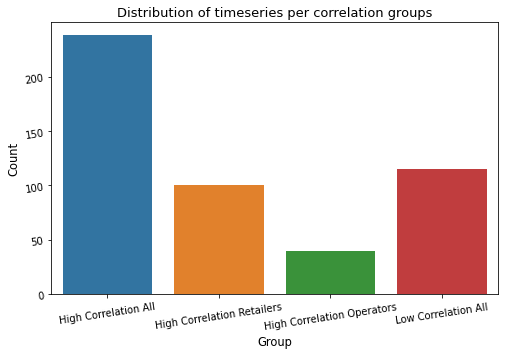

In [ ]:
set_fig_size((8, 5))
product_group_characteristic = df_country_min_max.reset_index()[["product_id", "product_group_id"]].drop_duplicates().product_group_id.apply(characterize_product_group)
product_group_characteristic = pd.DataFrame(product_group_characteristic)
p = sns.countplot(data = product_group_characteristic, x = "product_group_id")
p.set_ylabel("Count", fontsize = fontsize - 1.5)
p.set_title("Distribution of timeseries per correlation groups", fontsize = fontsize)
p.set_xlabel("Group", fontsize = fontsize - 1.5)
p.set_xticklabels(["High Correlation All", "High Correlation Retailers", "High Correlation Operators", "Low Correlation All"])
p.tick_params(labelrotation=8.5)
# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "correlationGroups")

###### Read all_info and best_hyper_parameters

In [ ]:
# filenames_hyper_parameters_multi = ["prophet_multivariate_best_hyper_parameters_0_9",
#                                     "prophet_multivariate_best_hyper_parameters_10_19",
#                                     "prophet_multivariate_best_hyper_parameters_20_29"]

# filenames_all_info_multi = ["prophet_multivariate_all_info_0_9",
#                             "prophet_multivariate_all_info_10_19",
#                             "prophet_multivariate_all_info_20_29"]

# df_best_hyper_parameters_multi = []
# df_all_info_multi = []
# for filename_hyper_parameters, filename_all_info in zip(filenames_hyper_parameters_multi, filenames_all_info_multi):
#   df_best_hyper_parameters_multi.append(pd.read_pickle(filename_hyper_parameters))
#   df_all_info_multi.append(pd.read_pickle(filename_all_info))

# df_best_hyper_parameters_multi = pd.concat(df_best_hyper_parameters_multi).set_index("product_id")

# df_best_hyper_parameters_multi["feature_types"] = df_best_hyper_parameters_multi["feature_types"].apply(lambda x : str(x))
# df_best_hyper_parameters_multi["included_companies"] = df_best_hyper_parameters_multi["included_companies"].apply(lambda x : str(x))

# df_best_hyper_parameters_multi = df_best_hyper_parameters_multi.merge(n_changes, how = "inner", on = ["product_id"])
# df_best_hyper_parameters_multi = df_best_hyper_parameters_multi.merge(n_samples, how = "inner", on = ["product_id"])
# df_best_hyper_parameters_multi["changes_samples_ratio"] = df_best_hyper_parameters_multi["n_changes"]/df_best_hyper_parameters_multi["n_samples"]
# df_all_info_multi = pd.concat(df_all_info_multi)

In [ ]:
#df_all_info_multi = pd.read_pickle("prophet_multivariate_all_info")
#df_best_hyper_parameters_multi = pd.read_pickle("prophet_multivariate_best_hyper_parameters")

df_all_info_lags = pd.read_pickle("prophet_multivariate_all_info_0_26_w_lags")
df_best_hyper_parameters_multi_lags = pd.read_pickle("prophet_multivariate_best_hyper_parameters_0_26_w_lags").set_index("product_id")

df_best_hyper_parameters_multi_lags["feature_types"] = df_best_hyper_parameters_multi_lags["feature_types"].apply(lambda x : str(x))
df_best_hyper_parameters_multi_lags["included_companies"] = df_best_hyper_parameters_multi_lags["included_companies"].apply(lambda x : str(x))

df_best_hyper_parameters_multi_lags = df_best_hyper_parameters_multi_lags.merge(n_changes, how = "inner", on = ["product_id"])
df_best_hyper_parameters_multi_lags = df_best_hyper_parameters_multi_lags.merge(n_samples, how = "inner", on = ["product_id"])
df_best_hyper_parameters_multi_lags["changes_samples_ratio"] = df_best_hyper_parameters_multi_lags["n_changes"]/df_best_hyper_parameters_multi_lags["n_samples"]

df_all_info_lags["testing_param_name"] = df_all_info_lags["testing_param_name"].apply(lambda x : str(x))
df_all_info_lags["testing_param_value"] = df_all_info_lags["testing_param_value"].apply(lambda x : str(x))

###### OLD - Analyse hyper-parameters

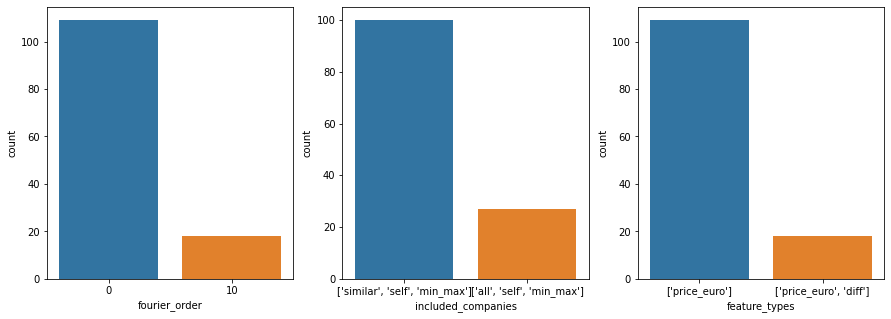

In [ ]:
hyper_parameters_names = ['fourier_order', 'included_companies', 'feature_types']
set_fig_size((15,5))
fig, axes = plt.subplots(1, len(hyper_parameters_names))
for hy_param_name, ax in zip(hyper_parameters_names, axes):
  sns.countplot(data = df_best_hyper_parameters_multi, x = hy_param_name, ax = ax)

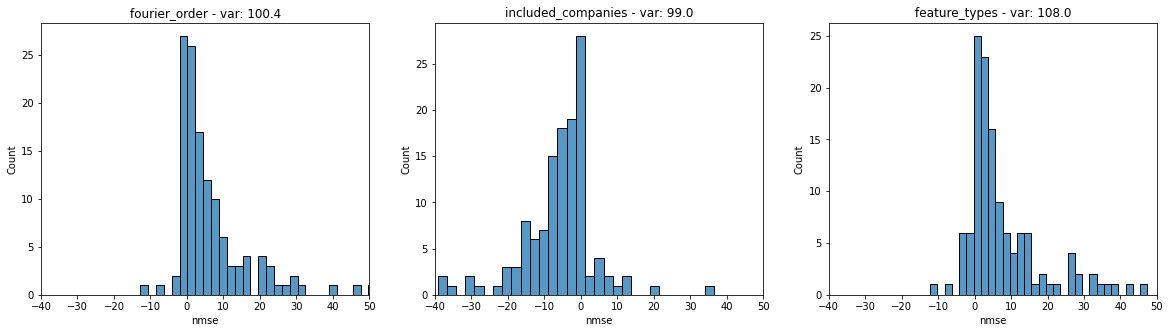

In [ ]:
# How the differences are computed: fourier order (10)-(0) ; included_companies [similar, self, min_max]-[all, self, min_max] ;  feature_types [price_euro,diff - price_euro]

hyper_parameters_names = ['fourier_order', 'included_companies', 'feature_types']
set_fig_size((20,5))
fig, axes = plt.subplots(1, len(hyper_parameters_names))
for hy_param_name, ax in zip(hyper_parameters_names, axes):
  df_sel = df_all_info_multi[df_all_info_multi["testing_param_name"] == hy_param_name][["product_id", "nmse"]].set_index("product_id")
  df_sel = df_sel.groupby(by = "product_id").diff().dropna()
  p = sns.histplot(data = df_sel.reset_index(), x = "nmse", bins = 30, ax = ax)
  p.set_title(hy_param_name + " - var: " + str(round(np.var(df_sel["nmse"]-np.mean(df_sel["nmse"])), 1)))
  p.set_xlim(-40, 50)

(-20.0, 20.0)

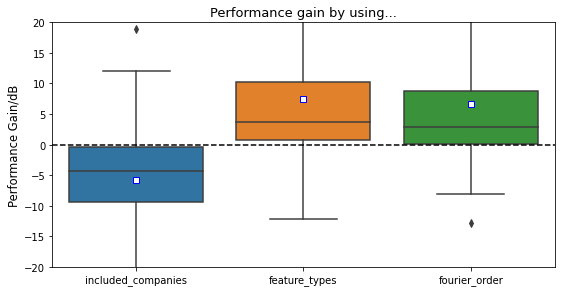

In [ ]:
# Boxplot
df_sel = df_all_info_multi.set_index(["product_id", "testing_param_name"]).groupby(by = ["product_id", "testing_param_name"])["nmse"].diff().dropna().reset_index()

set_fig_size((9,4.5))
p = sns.boxplot(data = df_sel, x = "testing_param_name", y = "nmse", showmeans = True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
p.axhline(0, color = "black", linestyle='--')
p.set_title("Performance gain by using...", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Performance Gain/dB", fontsize = fontsize - 1.5)
#p.set_xticklabels(["Lower trend flexibility", "Less seasonality", "No Holidays", "No Missing Values"], fontsize = fontsize - 1.5)
p.set_ylim(-20, 20)

# Save fig
#save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "impactHyperParametersNoLaggedSeriesBoxPlot")

###### Analyse hyper-parameters

In [ ]:
df_best_hyper_parameters_multi_lags_corrected = df_all_info_lags.groupby("product_id").apply(lambda df : df[df.nmse == min(df.nmse)].iloc[0]).drop("product_id", axis = 1)
hyper_parameters =  pd.DataFrame(list(df_best_hyper_parameters_multi_lags_corrected.hyper_parameters))
hyper_parameters.index = df_best_hyper_parameters_multi_lags_corrected.index
df_best_hyper_parameters_multi_lags_corrected = pd.concat([df_best_hyper_parameters_multi_lags_corrected, hyper_parameters], axis = 1)

df_best_hyper_parameters_multi_lags_corrected["feature_types"] = df_best_hyper_parameters_multi_lags_corrected["feature_types"].apply(lambda x : str(x))
df_best_hyper_parameters_multi_lags_corrected["included_companies"] = df_best_hyper_parameters_multi_lags_corrected["included_companies"].apply(lambda x : str(x))

In [ ]:
df_best_hyper_parameters_multi_lags = df_best_hyper_parameters_multi_lags[df_best_hyper_parameters_multi_lags.nmse > -100] 
df_best_hyper_parameters_multi_lags_corrected = df_best_hyper_parameters_multi_lags_corrected[df_best_hyper_parameters_multi_lags_corrected.nmse > -100] 
df_all_info_lags = df_all_info_lags[df_all_info_lags.nmse > -100] 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-058879684017>", line 1, in <module>
    df_best_hyper_parameters_multi_lags = df_best_hyper_parameters_multi_lags[df_best_hyper_parameters_multi_lags.nmse > -100]
NameError: name 'df_best_hyper_parameters_multi_lags' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_g

NameError: ignored

In [ ]:
df_sel.columns

Index(['product_id', 'testing_param_name', 'nmse'], dtype='object')

In [ ]:
def func1(row):
  just_self = df_all_info_lags[(df_all_info_lags.product_id == row._name) & (df_all_info_lags.testing_param_value == groups[0])]["nmse"]
  if len(just_self) != 0:
    just_self = float(just_self)
  else:
    return np.nan
  return -(row["nmse"]-just_self)

groups = list(df_best_hyper_parameters_multi_lags_corrected.included_companies.unique())
print(groups[0])
performance_gain_regressors = df_best_hyper_parameters_multi_lags_corrected[df_best_hyper_parameters_multi_lags_corrected.included_companies != groups[0]].copy()
performance_gain_regressors = performance_gain_regressors.apply(func1, axis = 1)
performance_gain_regressors = pd.DataFrame(performance_gain_regressors)
performance_gain_regressors["parameter"] = "regressors"
performance_gain_regressors.columns = ["nmse", "parameter"]


df_sel = df_all_info_lags[df_all_info_lags.testing_param_name == "lags"]
df_sel.testing_param_value = df_sel.testing_param_value.apply(int)
performance_gain_lags = df_sel.sort_values(["testing_param_value"], ascending = True).groupby(by = ["product_id"]).nmse.diff().dropna().reset_index().nmse
performance_gain_lags = pd.DataFrame(performance_gain_lags)
performance_gain_lags["parameter"] = "lags"

performance_gain = pd.concat([performance_gain_lags, performance_gain_regressors])

[None, 'just_self', None]


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_impactHyperParametersLaggedSeriesCountPlot.


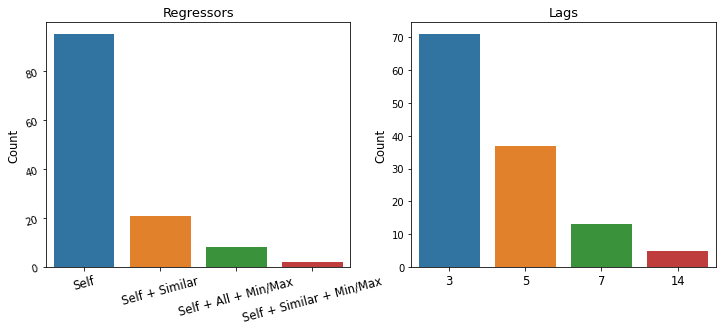

In [ ]:
hyper_parameters_names = ['included_companies', 'lags']
plot_titles = ["Regressors", "Lags"]
xticks = [["Self", "Self + Similar", "Self + All + Min/Max", "Self + Similar + Min/Max"], ["3", "5", "7", "14"]]

set_fig_size((12, 4.5))
fontsize = 13
fig, axes = plt.subplots(1, len(hyper_parameters_names))

for hy_param_name, ax, title, xtick in zip(hyper_parameters_names, axes, plot_titles, xticks):

  p = sns.countplot(data = df_best_hyper_parameters_multi_lags_corrected, x = hy_param_name, ax = ax)
  p.set_title(title, fontsize = fontsize)
  p.set_xlabel("")
  p.set_ylabel("Count", fontsize = fontsize-1.5)
  p.set_xticklabels(xtick, fontsize = fontsize - 1.5)
  if title != "Lags":
    p.tick_params(labelrotation=15)

# # Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "impactHyperParametersLaggedSeriesCountPlot")

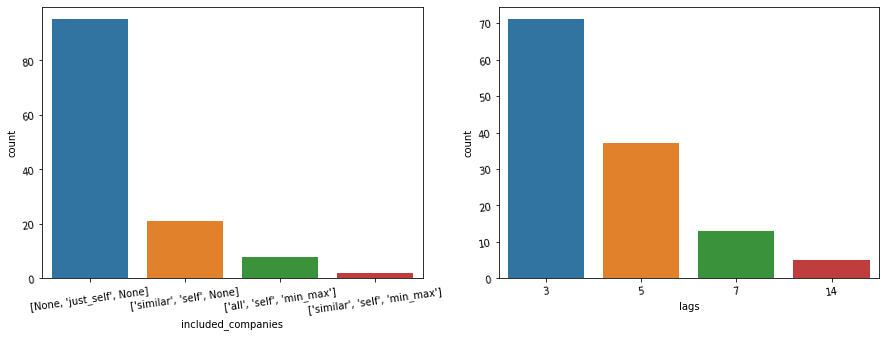

In [ ]:
hyper_parameters_names = ['included_companies', 'lags']
set_fig_size((15,5))
fig, axes = plt.subplots(1, len(hyper_parameters_names))
for hy_param_name, ax in zip(hyper_parameters_names, axes):
  p = sns.countplot(data = df_best_hyper_parameters_multi_lags_corrected, x = hy_param_name, ax = ax)
  p.tick_params(labelrotation=8)

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_impactHyperParametersLaggedSeriesBoxPlot.


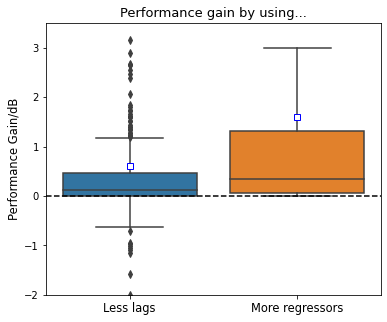

In [ ]:
fontsize = 13
set_fig_size((6,5))

p = sns.boxplot(data = performance_gain, x = "parameter", y = "nmse", showmeans = True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
p.axhline(0, color = "black", linestyle='--')
p.set_title("Performance gain by using...", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Performance Gain/dB", fontsize = fontsize - 1.5)
p.set_xticklabels(["Less lags", "More regressors"], fontsize = fontsize - 1.5)
p.set_ylim(-2, 3.5)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "impactHyperParametersLaggedSeriesBoxPlot")

In [ ]:
#fig, ax = plt.subplots()
sns.countplot(data = df_best_hyper_parameters_multi_lags_corrected, x = 'product_group_characteristicincluded_companies', hue = "included_companies")

NameError: ignored

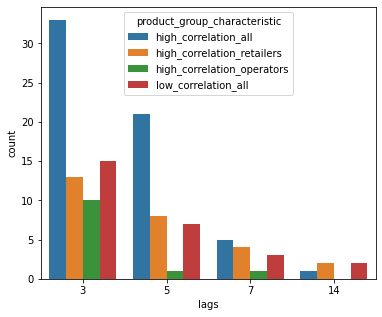

In [ ]:
sns.countplot(data = df_best_hyper_parameters_multi_lags_corrected, x = 'lags', hue = "product_group_characteristic")

In [ ]:
sns.countplot(data = df_best_hyper_parameters_multi_lags_corrected, x = 'product_group_characteristic', hue = "lags")

NameError: ignored

<Figure size 1440x360 with 0 Axes>

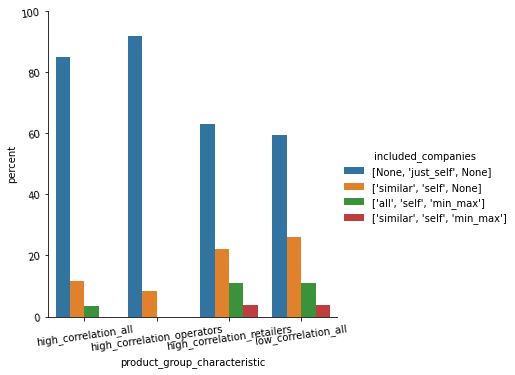

In [ ]:

#sns.countplot(data = df_best_hyper_parameters_multi_lags_corrected, x = 'included_companies', hue = "product_group_characteristic")
plt.figure(figsize=(20,5))
x,y = 'product_group_characteristic', 'included_companies'

df1 = df_best_hyper_parameters_multi_lags_corrected.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)
g.ax.tick_params(labelrotation=8)

#xticks = ["Self", "Self + Similar", "Self + All + Min/Max", "Self + Similar + Min/Max"]
#g.ax.set_xticklabels(xticks, fontsize = fontsize - 1.5)

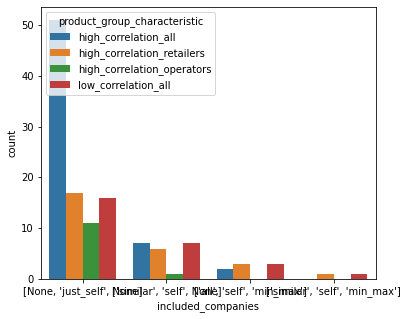

In [ ]:
# não se fez percentagem porque há tão poucos de alguns que não faria muito sentido
sns.countplot(data = df_best_hyper_parameters_multi_lags_corrected, x = 'included_companies', hue = "product_group_characteristic")

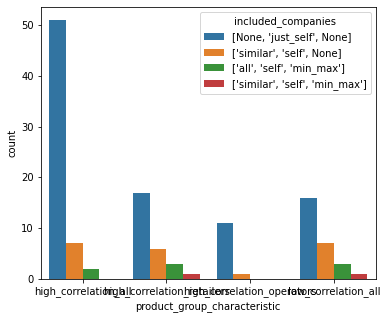

In [ ]:
# não se fez percentagem porque há tão poucos de alguns que não faria muito sentido
sns.countplot(data = df_best_hyper_parameters_multi_lags_corrected, x = 'product_group_characteristic', hue = "included_companies")

###### Analyse product_group_characteristics

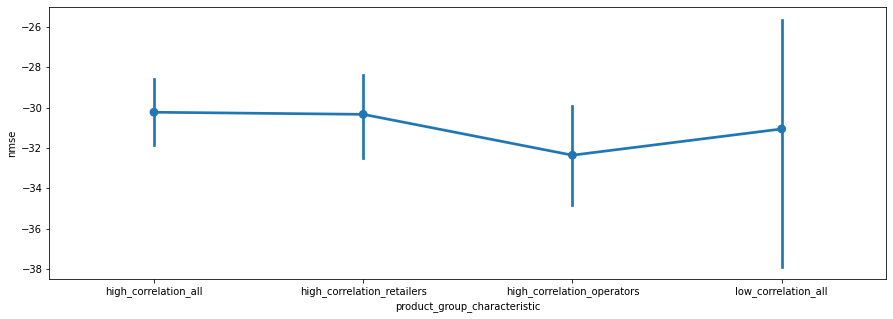

In [ ]:
# In the series with the lowest correlation the worst results were found. But this result will have to be compared with the univariate case
#df_best_hyper_parameters_multi_lags.groupby(by = "product_group_characteristic")["nmse"].mean()

sns.pointplot(data = df_best_hyper_parameters_multi_lags_corrected, x = "product_group_characteristic", y = "nmse")

###### Analyse impact of regressor coefficients

In [ ]:
def interpret_regressor_coefficients(row):
  
  df_regressor_coefficients = row["regressor_coefficients"]
  company = row["company"]
  companies = row["companies"]
  
  df_regressor_coefficients["regressors_interpreted"] = df_regressor_coefficients["regressor"].apply(get_regressor_characteristics, args=(company, companies))
  df_regressor_coefficients = pd.concat([df_regressor_coefficients, pd.json_normalize(df_regressor_coefficients["regressors_interpreted"])], axis = 1).sort_values(by = "coef_abs", ascending = False)

  n_individual_tops = 3
  ind_tops = []
  for n_top in range(n_individual_tops):
    ind_top = df_regressor_coefficients.regressors_interpreted.iloc[n_top].copy()
    ind_top = {f'ind_top{str(n_top+1)}_{k}': v for k, v in ind_top.items()}
    ind_tops.append(ind_top)

  tops = []
  n_tops = [3, 5, 10, 15, 20, 25, 30, 35]
  
  top_default = df_regressor_coefficients.regressors_interpreted.iloc[0].copy()
  
  for n_top in n_tops:
    top = top_default.copy()
    for key in top.keys():
      top[key] = df_regressor_coefficients.iloc[:n_top][key].value_counts()
      if key in ["min", "max", "is_other_company", "is_other_companies", "is_self_company", "is_price_euro", "is_diff"]:
        if True in top[key].index:
          top[key] = top[key].loc[True]
        else:
          top[key] = 0
      if key == "company":
        tmp = df_regressor_coefficients.iloc[:n_top].copy()
        tmp = tmp[tmp.is_self_company == False]
        top[key] = tmp[key].value_counts()

    top = {f'top{str(n_top)}_{k}': v for k, v in top.items()}
    tops.append(top)

  return {k: v for d in ind_tops + tops for k, v in d.items()}


def get_regressor_characteristics(regressor, company, companies):
  
  min = False
  max = False
  is_self_company = False
  is_other_company = False
  is_other_companies = False
  is_price_euro = False
  is_diff = False

  feature_type = "price_euro"
  company_name = company

  # Company
  if "min" in regressor:
    min = True
    company_name = "min"
    is_other_companies = True

  elif "max" in regressor:
    max = True
    company_name = "max"
    is_other_companies = True

  elif company in regressor:
    is_self_company = True

  else:
    is_other_company = True
    is_other_companies = True
    for other_company in companies:
      if other_company in regressor:
        company_name = other_company
        break

  # Feature type
  if "diff" in regressor:
    is_diff = True
  else:
    is_price_euro = True

  # Lag
  lag = regressor.split("_")[-1]

  top = {"min": min,
         "max": max,
         "is_self_company": is_self_company,
         "is_other_company": is_other_company,
         "is_other_companies": is_other_companies,
         "is_diff": is_diff,
         "is_price_euro": is_price_euro,
         "company": company_name,
         "lag": lag}

  return top

groups = list(df_best_hyper_parameters_multi_lags.included_companies.unique())
print(groups)

df_regressor_coefficients_interpreted = df_best_hyper_parameters_multi_lags.copy()[df_best_hyper_parameters_multi_lags.included_companies == groups[2]]
#df_best_hyper_parameters_multi_lags, x = "product_group_characteristic", y = "nmse")
df_regressor_coefficients_interpreted = pd.json_normalize(df_regressor_coefficients_interpreted.apply(interpret_regressor_coefficients, axis = 1))

["[None, 'just_self', None]", "['similar', 'self', None]", "['all', 'self', 'min_max']", "['similar', 'self', 'min_max']"]


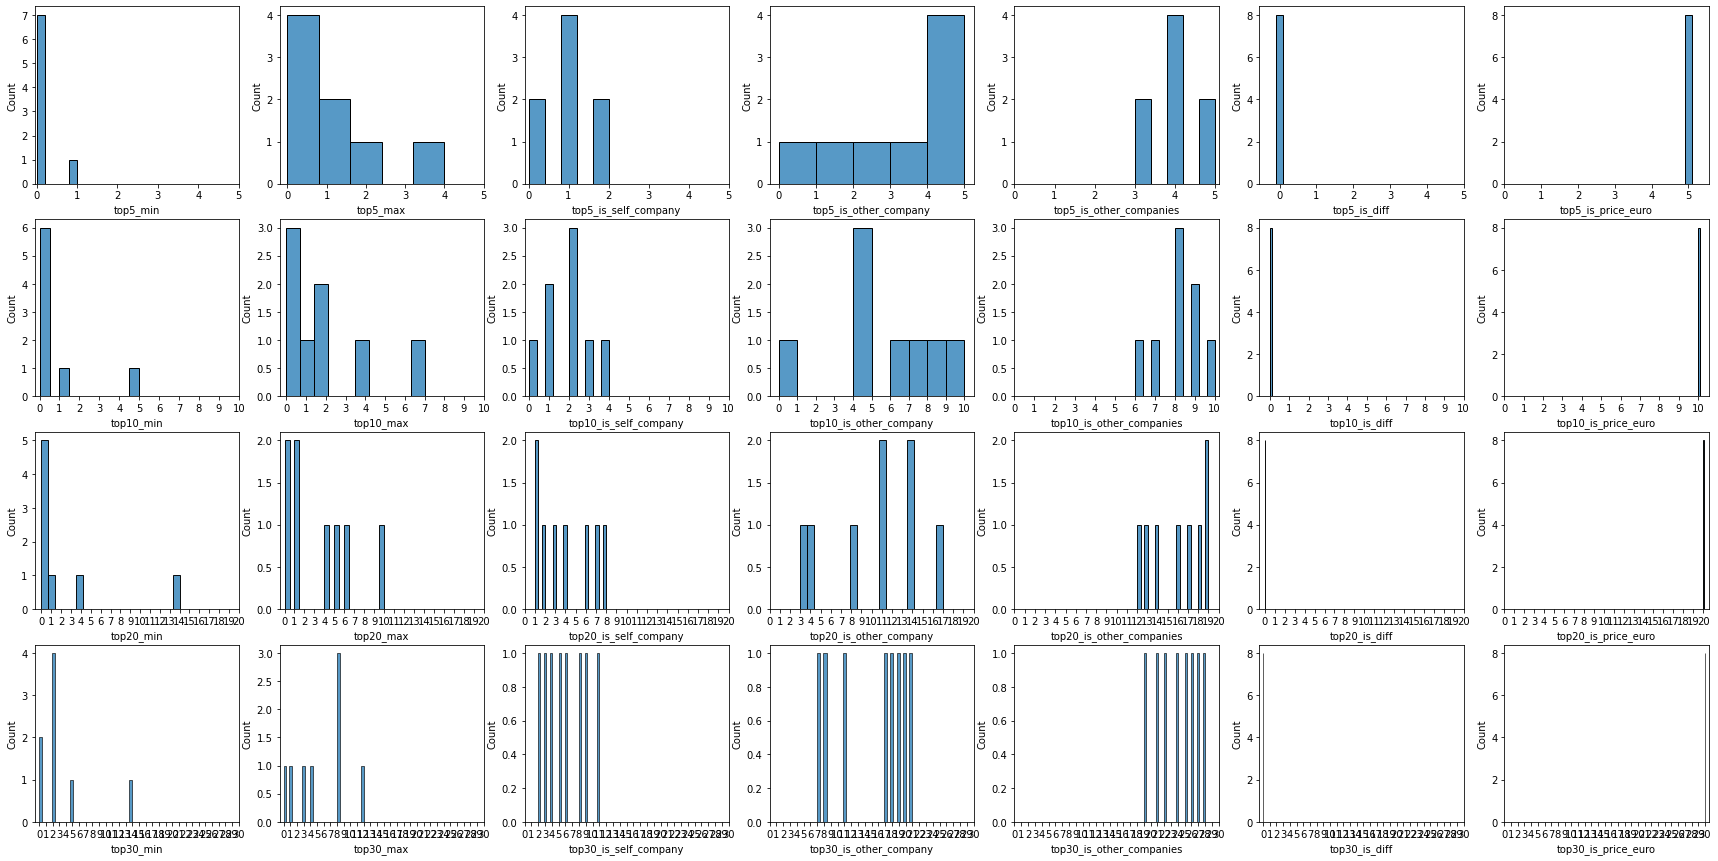

In [ ]:
ind_top = "top"
tops = [5, 10, 20, 30]
feature_names = ["min", "max", "is_self_company", "is_other_company", "is_other_companies", "is_diff", "is_price_euro"]

set_fig_size((30, 15))
fig, axes = plt.subplots(len(tops), len(feature_names))

for top, ax_x in zip(tops, axes):
  for feature_name, ax_y in zip(feature_names, ax_x):  
    feature = ind_top + str(top) + "_" + feature_name
    if feature_name not in ["companies", "lags"]:
      p = sns.histplot(data = df_regressor_coefficients_interpreted, x = feature, bins = top, ax = ax_y)
    else:
      data = df_regressor_coefficients_interpreted[feature_name]
      print((set([a for b in data.val.tolist() for a in b])))
    #p.set_ylim(0,35)
    p.set(xticks=range(top+1), xticklabels=list(range(top+1)))

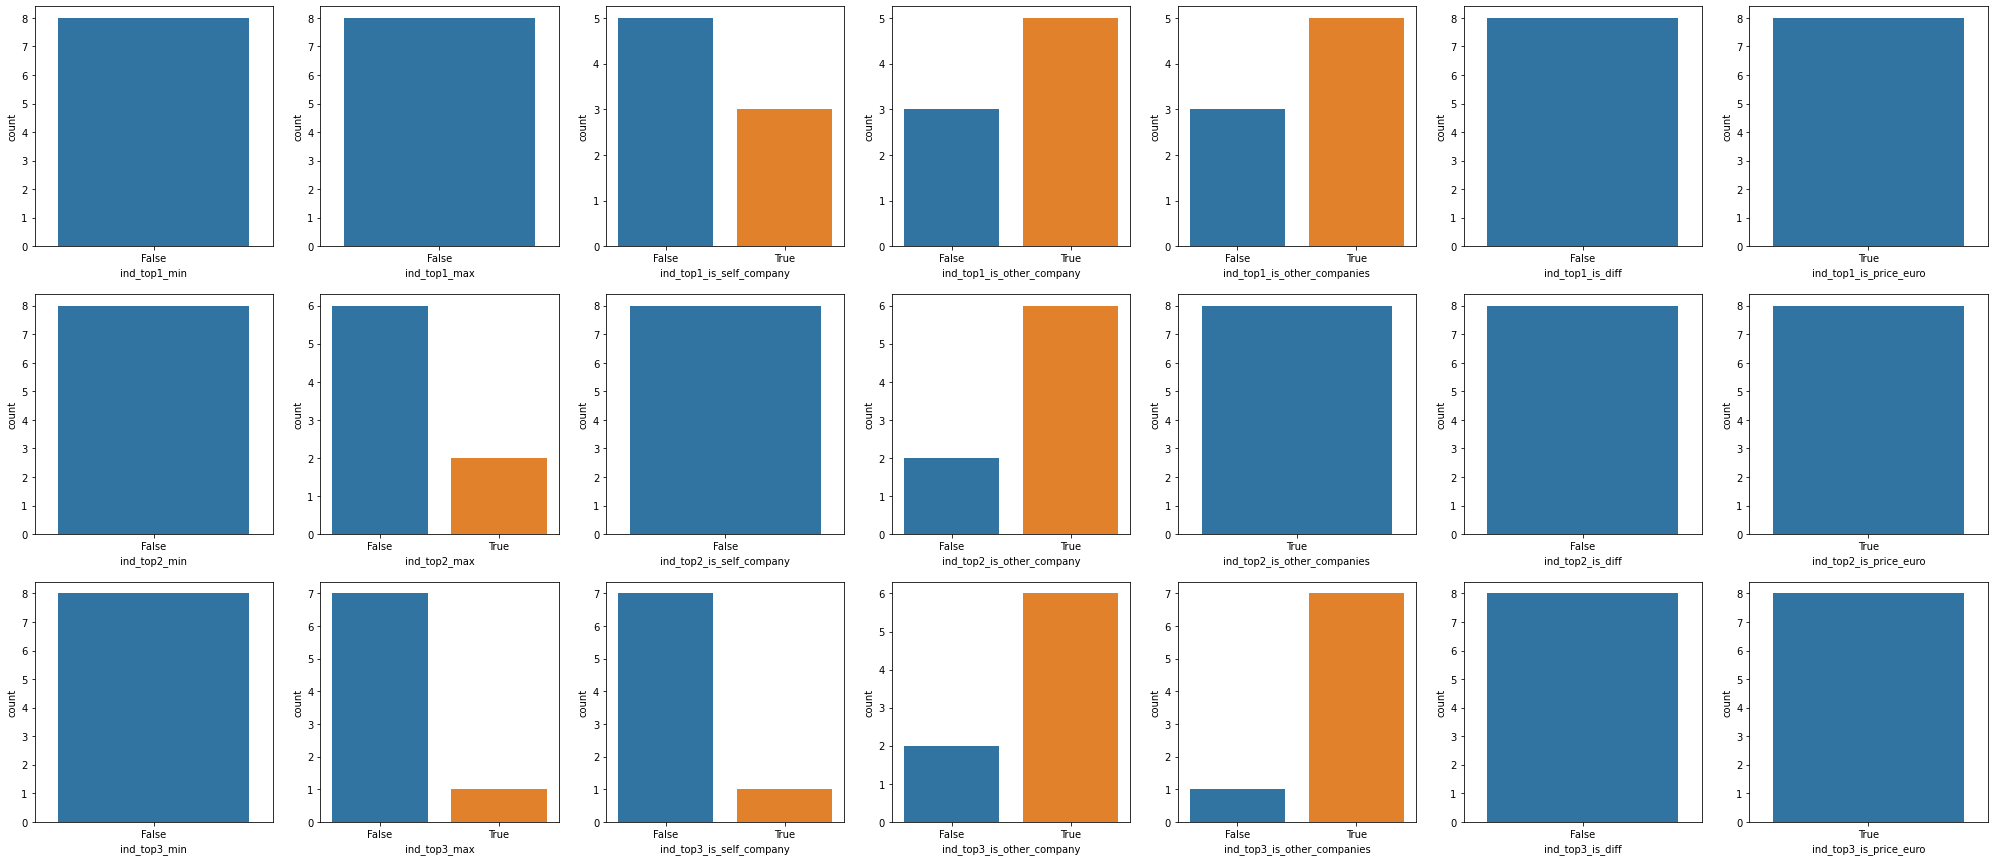

In [ ]:
df_regressor_coefficients_interpreted
ind_top = "ind_top"
tops = [1, 2, 3]
feature_names = ["min", "max", "is_self_company", "is_other_company", "is_other_companies", "is_diff", "is_price_euro"]

set_fig_size((len(feature_names)*5, len(tops)*5))
fig, axes = plt.subplots(len(tops), len(feature_names))

for top, ax_x in zip(tops, axes):
  for feature_name, ax_y in zip(feature_names, ax_x):  
    feature = ind_top + str(top) + "_" + feature_name
    p = sns.countplot(data = df_regressor_coefficients_interpreted, x = feature, ax = ax_y)

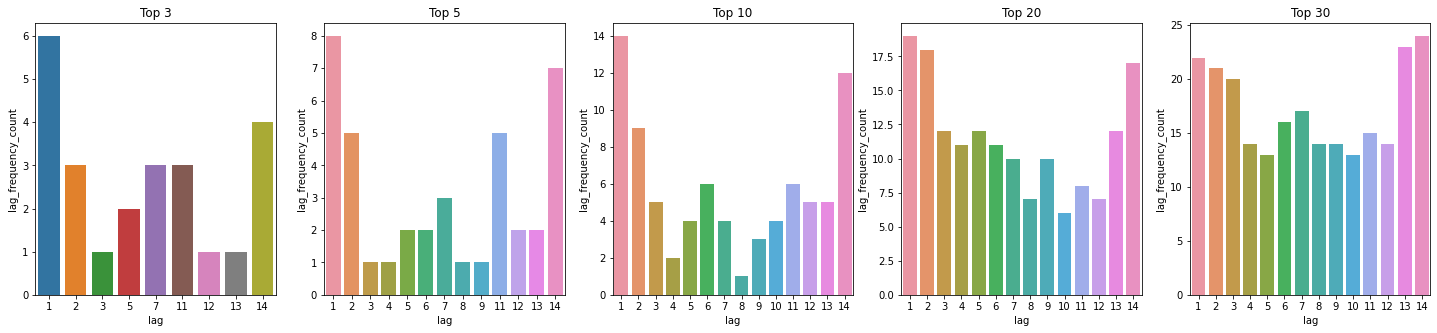

In [ ]:
ind_top = "top"
tops = [3, 5, 10, 20, 30]
feature_names = ["lag"]

set_fig_size((len(tops)*5, len(feature_names)*5))
fig, axes = plt.subplots(1, len(tops))

ax_c = 0
for top in tops:
  for feature_name in feature_names:  

    feature = ind_top + str(top) + "_" + feature_name
    
    a = pd.DataFrame(pd.concat(df_regressor_coefficients_interpreted[feature].to_list())).groupby(level = 0).sum()
    a.index = a.index.map(int)
    a = a.sort_index()
    a.columns = ["lag_frequency_count"]
    a.index.name = "lag"
    
    p = sns.barplot(data = a, x = a.index, y = "lag_frequency_count", ax = axes[ax_c])
    p.set_title("Top " + str(top))
    ax_c = ax_c + 1

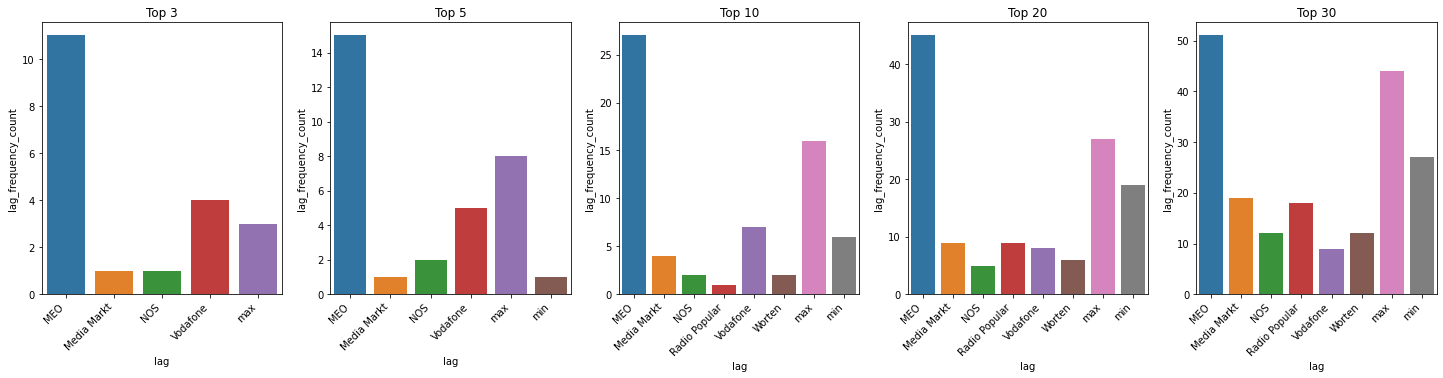

In [ ]:
ind_top = "top"
tops = [3, 5, 10, 20, 30]
feature_names = ["company"]

set_fig_size((len(tops)*5, len(feature_names)*5))
fig, axes = plt.subplots(1, len(tops))

ax_c = 0
for top in tops:
  for feature_name in feature_names:  

    feature = ind_top + str(top) + "_" + feature_name
    
    a = pd.DataFrame(pd.concat(df_regressor_coefficients_interpreted[feature].to_list())).groupby(level = 0).sum()
    a.columns = ["lag_frequency_count"]
    a.index.name = "lag"
    
    p = sns.barplot(data = a, x = a.index, y = "lag_frequency_count", ax = axes[ax_c])
    p.set_title("Top " + str(top))
    p.set_xticklabels(labels = a.index, rotation=45, horizontalalignment='right')
    ax_c = ax_c + 1

In [ ]:
i = 7
tmp = df_best_hyper_parameters_multi_lags_corrected[df_best_hyper_parameters_multi_lags_corrected.included_companies != groups[0]]
print(tmp.iloc[i].company, tmp.iloc[i].included_companies, tmp.iloc[i].product_group_characteristic, tmp.iloc[i].lags)
#tmp.regressor_coeficients.iloc[i]

tmp.regressor_coefficients.iloc[i].sort_values("coef_abs", ascending = False)

Vodafone ['all', 'self', 'min_max'] high_correlation_retailers 5


,regressor,regressor_mode,center,coef_lower,coef,coef_upper,coef_abs,center_abs,contains_0
15,Vodafone_price_euro_lag_1,additive,792.610730,0.813565,0.813565,0.813565,0.813565,792.610730,False
17,Vodafone_price_euro_lag_3,additive,794.070584,0.257469,0.257469,0.257469,0.257469,794.070584,False
37,max_Vodafone_price_euro_lag_3,additive,801.797883,-0.240164,-0.240164,-0.240164,0.240164,801.797883,False
36,max_Vodafone_price_euro_lag_2,additive,801.432920,0.228403,0.228403,0.228403,0.228403,801.432920,False
32,min_Vodafone_price_euro_lag_3,additive,745.188686,-0.205253,-0.205253,-0.205253,0.205253,745.188686,False
6,Radio Popular_price_euro_lag_2,additive,766.924307,-0.197255,-0.197255,-0.197255,0.197255,766.924307,False
7,Radio Popular_price_euro_lag_3,additive,767.289270,0.194665,0.194665,0.194665,0.194665,767.289270,False
1,Worten_price_euro_lag_2,additive,762.315109,-0.188129,-0.188129,-0.188129,0.188129,762.315109,False
2,Worten_price_euro_lag_3,additive,762.534088,0.186073,0.186073,0.186073,0.186073,762.534088,False
31,min_Vodafone_price_euro_lag_2,additive,744.830949,0.174917,0.174917,0.174917,0.174917,744.830949,False


##### Get predictions

In [ ]:
#### What has been done:
#### What's being done: Initial 30, Horizon 1

In [ ]:
print(list(range(12, 17, 2)))
print(list(range(13, 18, 2)))

[12, 14, 16]
[13, 15, 17]


In [ ]:
# Features
prediction_horizon = 1
lag_interval = 5
min_lag = prediction_horizon
max_lag = (min_lag - 1) + lag_interval

feature_types = ["price_euro"]

init_count_list = list(range(12, 17, 2))
end_count_list = list(range(13, 18, 2))

init_count_list = [0]
end_count_list = [24]

# Timeseries that weren't included in this list either were to short or had only one or two companies associated to a certain product. This will make it easier to analyse, with less simulations the impact of other timeseries
product_group_id_lst_multi = [8, 153, 245, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 405, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]

for init_count, end_count in zip(init_count_list, end_count_list):
  
  all_info = []                       # store all info of each hyper-paramter for each timeseries
  count = init_count-1

  for product_group_id in product_group_id_lst_multi[init_count:end_count+1]:

    count = count + 1

    # Select product_group_id
    df_product_group_id = select_df_product_group_id(df_country_min_max, product_group_id)
    df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag, min_lag)

    companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]

    print("Count: ", count)
    print("Product Group ID: ", product_group_id)
    print("Existing companies: ", companies)
    
    for company in companies:

      print("\tCompany: ", company)
      
      # Get product basic informations
      product_id = df_product_group_id[df_product_group_id.company == company].index.get_level_values(0).unique()[0]
      hyper_parameters = df_best_hyper_parameters_multi.hyper_parameters.loc[product_id].copy()
      hyper_parameters["feature_types"] = ["price_euro"]

      base_info = {"product_id": product_id,
                  "company": company,
                  "company_id": df_product_group_id.loc[product_id].company_id.unique()[0],
                  "product_group_id": product_group_id,
                  "country": df_product_group_id.country.unique()[0],
                  "product": df_product_group_id["product"].unique()[0],
                  "offer_type": df_product_group_id.offer_type.unique()[0],
                  "product_group_characteristic": characterize_product_group(product_group_id),
                  "companies": companies,
                  "n_companies": len(companies),
                  "hyper_parameters": hyper_parameters,
                  "type_company": is_retailer_operator(company, df_product_group_id.country.unique()[0])}

      values = hyper_parameters.copy()    # keep the hyper-parameters to be tested in each iteration

      # Cross-validation
      initial = 120
      period = 5
      horizon = 5

      # Get prophet model
      data, m = get_prophet_model(df_product_group_id, max_lag, company, values, min_lag)
      forecast = m.predict(data)
      df_cv = cross_validation(m, initial = str(initial) + 'days', period = str(period) + 'days', horizon = str(horizon) + 'days', parallel = "dask") 

      # Metrics
      df_p = performance_metrics(df_cv)
      nmse = get_nmse(df_cv["y"], df_cv["yhat"])

      # Regressor coeficients
      df_regressor_coefficients = get_regressor_coefficients(m)

      # Saving results
      new_info = {"n_samples": len(data["y"]),
                  "n_changes": get_n_changes(data["y"]),
                  "forecast": forecast,
                  "model": m,
                  "hyper_parameters": values.copy(),
                  "cross_validation_results": df_cv,
                  "performance_metrics" : df_p,
                  "nmse": nmse,
                  "regressor_coefficients": df_regressor_coefficients,
                  "cross_validation_initial": initial,
                  "cross_validation_period": period,
                  "cross_validation_horizon": horizon,
                  "prediction_horizon": prediction_horizon,
                  "min_lag": min_lag,
                  "max_lag": max_lag}

      info = base_info.copy()
      info.update(new_info)
      all_info.append(info)
      
  df_all_info = pd.DataFrame(all_info)
  df_all_info.to_pickle("prophet_predictions_multivariate_all_info_lags_5_initial_" + str(initial) + "_prediction_horizon_" + str(prediction_horizon) + "_" + str(init_count) + "_" + str(end_count))

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Count:  0
Product Group ID:  8
Existing companies:  ['Media Markt', 'MEO', 'Worten', 'Vodafone', 'Radio Popular']
	Company:  Media Markt


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/sh3rvglz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/4gsnjlcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94530', 'data', 'file=/tmp/tmpgn6fdrqk/sh3rvglz.json', 'init=/tmp/tmpgn6fdrqk/4gsnjlcp.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelm56qonfo/prophet_model-20221023110905.csv', 'method=optimize', 

	Company:  MEO


11:09:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 19 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/m0794yze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/gb8ir_1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37319', 'data', 'file=/tmp/tmpgn6fdrqk/m0794yze.json', 'init=/tmp/tmpgn6fdrqk/gb8ir_1b.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelq3pdw_n1/prophet_model-20221023110948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:09:48 - cmdstanpy - INFO - Ch

	Company:  Worten


11:09:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 19 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/qi18wno_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/adctmk4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92737', 'data', 'file=/tmp/tmpgn6fdrqk/qi18wno_.json', 'init=/tmp/tmpgn6fdrqk/adctmk4b.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelsohrn70q/prophet_model-20221023111007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:10:07 - cmdstanpy - INFO - Ch

	Company:  Vodafone


11:10:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 19 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/btwhn0am.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/tgr16fow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34699', 'data', 'file=/tmp/tmpgn6fdrqk/btwhn0am.json', 'init=/tmp/tmpgn6fdrqk/tgr16fow.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelxmv2lw3v/prophet_model-20221023111026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:10:26 - cmdstanpy - INFO - Ch

	Company:  Radio Popular


11:10:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 19 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/kjz2br3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/vd2nh52u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14014', 'data', 'file=/tmp/tmpgn6fdrqk/kjz2br3_.json', 'init=/tmp/tmpgn6fdrqk/vd2nh52u.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model51xu0t_a/prophet_model-20221023111047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:10:47 - cmdstanpy - INFO - Ch

Count:  1
Product Group ID:  153
Existing companies:  ['Vodafone', 'MEO', 'Radio Popular', 'Worten', 'Media Markt']
	Company:  Vodafone


11:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 27 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/k5ffqijq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/0gfy1ry5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86212', 'data', 'file=/tmp/tmpgn6fdrqk/k5ffqijq.json', 'init=/tmp/tmpgn6fdrqk/0gfy1ry5.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelpaf81n15/prophet_model-20221023111116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:11:16 - cmdstanpy - INFO - Ch

	Company:  MEO


11:11:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 27 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/jjjyt3rz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/deovgv9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62148', 'data', 'file=/tmp/tmpgn6fdrqk/jjjyt3rz.json', 'init=/tmp/tmpgn6fdrqk/deovgv9b.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelrpxcri_i/prophet_model-20221023111142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:11:42 - cmdstanpy - INFO - Ch

	Company:  Radio Popular


11:11:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 27 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/iacue_jj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ne6mrhg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37870', 'data', 'file=/tmp/tmpgn6fdrqk/iacue_jj.json', 'init=/tmp/tmpgn6fdrqk/ne6mrhg_.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelohtua4ja/prophet_model-20221023111209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:12:09 - cmdstanpy - INFO - Ch

	Company:  Worten


11:12:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 27 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/a6iqe98e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/pgqlg7p0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58588', 'data', 'file=/tmp/tmpgn6fdrqk/a6iqe98e.json', 'init=/tmp/tmpgn6fdrqk/pgqlg7p0.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modellmxzrqrw/prophet_model-20221023111236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:12:36 - cmdstanpy - INFO - Ch

	Company:  Media Markt


11:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 27 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/myvq1q0c.json


Count:  2
Product Group ID:  245
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/h0yo4zpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61160', 'data', 'file=/tmp/tmpgn6fdrqk/myvq1q0c.json', 'init=/tmp/tmpgn6fdrqk/h0yo4zpt.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelzz3alk5j/prophet_model-20221023111303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Radio Popular


11:13:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/t7s20w7p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/bdlrma85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28480', 'data', 'file=/tmp/tmpgn6fdrqk/t7s20w7p.json', 'init=/tmp/tmpgn6fdrqk/bdlrma85.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelcl6iqiv7/prophet_model-20221023111424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:14:24 - cmdstanpy - INFO - Ch

	Company:  MEO


11:14:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/3qvtx9ys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/mrlbkts8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73060', 'data', 'file=/tmp/tmpgn6fdrqk/3qvtx9ys.json', 'init=/tmp/tmpgn6fdrqk/mrlbkts8.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeli65j4vt4/prophet_model-20221023111504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


	Company:  Worten


11:15:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:15:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/7f9qf22q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ymllkgj0.json


Count:  3
Product Group ID:  349
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'MEO', 'Worten', 'Radio Popular']
	Company:  NOS


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38757', 'data', 'file=/tmp/tmpgn6fdrqk/7f9qf22q.json', 'init=/tmp/tmpgn6fdrqk/ymllkgj0.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelq85jz35b/prophet_model-20221023111543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 22 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/voqmawgj.j

	Company:  Vodafone


11:16:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 22 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/9qlgu2fe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/_x2bwhl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32697', 'data', 'file=/tmp/tmpgn6fdrqk/9qlgu2fe.json', 'init=/tmp/tmpgn6fdrqk/_x2bwhl0.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelw80l7eaq/prophet_model-20221023111629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:16:29 - cmdstanpy - INFO - Ch

	Company:  Media Markt


11:16:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 22 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/hbybvhzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/07f19xbf.json
DEBUG:cmdstanpy:idx 0


	Company:  MEO


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46652', 'data', 'file=/tmp/tmpgn6fdrqk/hbybvhzu.json', 'init=/tmp/tmpgn6fdrqk/07f19xbf.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelse58ny0_/prophet_model-20221023111651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:16:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 22 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/czx2apy4.json
DEBUG:cmdstanpy:in

	Company:  Worten


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33090', 'data', 'file=/tmp/tmpgn6fdrqk/czx2apy4.json', 'init=/tmp/tmpgn6fdrqk/5zhxz6n1.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeldp48sa0u/prophet_model-20221023111717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:17:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:17:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 22 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/9n3lfuai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/37v89dj2.json
DEBUG:

	Company:  Radio Popular


11:17:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 22 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/id3ktkn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/mvlg0n1a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=969', 'data', 'file=/tmp/tmpgn6fdrqk/id3ktkn4.json', 'init=/tmp/tmpgn6fdrqk/mvlg0n1a.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelns70_vbt/prophet_model-20221023111804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:18:04 - cmdstanpy - INFO - Chai

Count:  4
Product Group ID:  413
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS


INFO:cmdstanpy:Chain [1] start processing
11:18:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-06-06 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/8ms_qvuh.json


	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/vpon8_ob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68699', 'data', 'file=/tmp/tmpgn6fdrqk/8ms_qvuh.json', 'init=/tmp/tmpgn6fdrqk/vpon8_ob.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modela45scnrq/prophet_model-20221023111836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:18:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:18:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-06-06 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Media Markt


INFO:cmdstanpy:Chain [1] start processing
11:19:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-06-06 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/g_0_0yj0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/sfz3sty2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32491', 'data', 'file=/tmp/tmpgn6fdrqk/g_0_0yj0.json', 'init=/tmp/tmpgn6fdrqk/sfz3sty2.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelq7swwdho/prophet_model-20221023111941.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

	Company:  Radio Popular


11:19:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-06-06 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/i0s09ah3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/jtu4c7jg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60583', 'data', 'file=/tmp/tmpgn6fdrqk/i0s09ah3.json', 'init=/tmp/tmpgn6fdrqk/jtu4c7jg.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeln5_j9u3s/prophet_model-20221023112013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:13 - cmdstanpy - INFO - Ch

	Company:  MEO


11:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-06-06 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/qoju1lk5.json


	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/_jpjslog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98214', 'data', 'file=/tmp/tmpgn6fdrqk/qoju1lk5.json', 'init=/tmp/tmpgn6fdrqk/_jpjslog.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeljsken20c/prophet_model-20221023112044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-06-06 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

Count:  5
Product Group ID:  529
Existing companies:  ['NOS', 'Vodafone', 'Radio Popular', 'MEO', 'Worten', 'Media Markt']
	Company:  NOS


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/xpt54rjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81501', 'data', 'file=/tmp/tmpgn6fdrqk/d0l399ha.json', 'init=/tmp/tmpgn6fdrqk/xpt54rjl.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelmxm1vwsk/prophet_model-20221023112119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Vodafone


INFO:cmdstanpy:Chain [1] start processing
11:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/z29xiigc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/vyq40h7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84856', 'data', 'file=/tmp/tmpgn6fdrqk/z29xiigc.json', 'init=/tmp/tmpgn6fdrqk/vyq40h7y.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelpqcvk8qr/prophet_model-20221023112153.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

	Company:  Radio Popular


11:21:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/q6ffd5lj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ljy5u5px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24095', 'data', 'file=/tmp/tmpgn6fdrqk/q6ffd5lj.json', 'init=/tmp/tmpgn6fdrqk/ljy5u5px.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelpid5tx_4/prophet_model-20221023112209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seas

	Company:  Worten


11:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/kirm1jpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/s2p55852.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29344', 'data', 'file=/tmp/tmpgn6fdrqk/kirm1jpu.json', 'init=/tmp/tmpgn6fdrqk/s2p55852.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model440oheoi/prophet_model-20221023112243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:22:43 - cmdstanpy - INFO - Ch

	Company:  Media Markt


11:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/xqc4p9w5.json


Count:  6
Product Group ID:  427
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten', 'Vodafone', 'NOS']
	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/yhz57gl5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2584', 'data', 'file=/tmp/tmpgn6fdrqk/xqc4p9w5.json', 'init=/tmp/tmpgn6fdrqk/yhz57gl5.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelh4x4rtwu/prophet_model-20221023112259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  Radio Popular


11:23:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/d8b1r0l_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ppaga073.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4148', 'data', 'file=/tmp/tmpgn6fdrqk/d8b1r0l_.json', 'init=/tmp/tmpgn6fdrqk/ppaga073.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelea2lji8t/prophet_model-20221023112415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:24:15 - cmdstanpy - INFO - Cha

	Company:  MEO


11:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ca8d645q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/bbxsv0j_.json


	Company:  Worten


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69547', 'data', 'file=/tmp/tmpgn6fdrqk/ca8d645q.json', 'init=/tmp/tmpgn6fdrqk/bbxsv0j_.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelg199ebm7/prophet_model-20221023112502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:25:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/d3_1dxxf.j

	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/tgbhxry0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5644', 'data', 'file=/tmp/tmpgn6fdrqk/d3_1dxxf.json', 'init=/tmp/tmpgn6fdrqk/tgbhxry0.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelu71ezld4/prophet_model-20221023112540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:25:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  NOS


INFO:cmdstanpy:Chain [1] start processing
11:26:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/zkw2afpv.json


Count:  7
Product Group ID:  551
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/gf6ud82t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29947', 'data', 'file=/tmp/tmpgn6fdrqk/zkw2afpv.json', 'init=/tmp/tmpgn6fdrqk/gf6ud82t.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelu2ieu_3y/prophet_model-20221023112658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Media Markt


11:28:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/6q9dspie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/f_55zes6.json


	Company:  Radio Popular


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57497', 'data', 'file=/tmp/tmpgn6fdrqk/6q9dspie.json', 'init=/tmp/tmpgn6fdrqk/f_55zes6.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeldsyx_rgy/prophet_model-20221023112842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  MEO


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/86lgqpc0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/6s8lz68v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80359', 'data', 'file=/tmp/tmpgn6fdrqk/86lgqpc0.json', 'init=/tmp/tmpgn6fdrqk/6s8lz68v.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelb43llsfo/prophet_model-20221023112926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seas

	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/uyjguakv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/48anmw11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48295', 'data', 'file=/tmp/tmpgn6fdrqk/uyjguakv.json', 'init=/tmp/tmpgn6fdrqk/48anmw11.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modell83vajx0/prophet_model-20221023113020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seas

Count:  8
Product Group ID:  554
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten', 'NOS']
	Company:  Vodafone


INFO:cmdstanpy:Chain [1] start processing
11:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/x05jf450.json


	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/zkd3opto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9711', 'data', 'file=/tmp/tmpgn6fdrqk/x05jf450.json', 'init=/tmp/tmpgn6fdrqk/zkd3opto.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model5ezvhwij/prophet_model-20221023113200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:32:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:32:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  Radio Popular


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50877', 'data', 'file=/tmp/tmpgn6fdrqk/5feodfnh.json', 'init=/tmp/tmpgn6fdrqk/jrjhcsdy.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeli8e_fvxu/prophet_model-20221023113247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/_iyrw5tl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/xyk2cz79.json
DEBUG:

	Company:  MEO


11:33:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/erjn_u59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/p7ytvxt2.json


	Company:  Worten


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80641', 'data', 'file=/tmp/tmpgn6fdrqk/erjn_u59.json', 'init=/tmp/tmpgn6fdrqk/p7ytvxt2.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelccwgr_tc/prophet_model-20221023113417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:34:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:34:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/go5x4ecd.j

	Company:  NOS


11:35:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/eallpqwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/8scy0kfa.json
DEBUG:cmdstanpy:idx 0


Count:  9
Product Group ID:  557
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Vodafone


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79901', 'data', 'file=/tmp/tmpgn6fdrqk/eallpqwy.json', 'init=/tmp/tmpgn6fdrqk/8scy0kfa.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model5moxqslz/prophet_model-20221023113550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 34 forecasts with cutoffs between 2021-05-06 00:00:00 and 2021-10-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ofprdan8.json


	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/uc03r1us.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1582', 'data', 'file=/tmp/tmpgn6fdrqk/ofprdan8.json', 'init=/tmp/tmpgn6fdrqk/uc03r1us.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelgyab3odb/prophet_model-20221023113627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 34 forecasts with cutoffs between 2021-05-06 00:00:00 and 2021-10-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  Radio Popular


11:37:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 34 forecasts with cutoffs between 2021-05-06 00:00:00 and 2021-10-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ai54x92c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/cnfutmgp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90018', 'data', 'file=/tmp/tmpgn6fdrqk/ai54x92c.json', 'init=/tmp/tmpgn6fdrqk/cnfutmgp.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelqtrco6sk/prophet_model-20221023113752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:37:52 - cmdstanpy - INFO - Ch

	Company:  MEO


11:37:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 34 forecasts with cutoffs between 2021-05-06 00:00:00 and 2021-10-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/bc9upsst.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/cojqunay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13892', 'data', 'file=/tmp/tmpgn6fdrqk/bc9upsst.json', 'init=/tmp/tmpgn6fdrqk/cojqunay.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelfowmuq27/prophet_model-20221023113842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:38:42 - cmdstanpy - INFO - Ch

	Company:  Worten


11:38:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 34 forecasts with cutoffs between 2021-05-06 00:00:00 and 2021-10-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/oqe7x784.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/4toai6e4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94154', 'data', 'file=/tmp/tmpgn6fdrqk/oqe7x784.json', 'init=/tmp/tmpgn6fdrqk/4toai6e4.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model3o1g_j8l/prophet_model-20221023113926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:39:26 - cmdstanpy - INFO - Ch

Count:  10
Product Group ID:  601
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS


11:39:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-11-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/vu_9n0h6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/_x5jawjc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23078', 'data', 'file=/tmp/tmpgn6fdrqk/vu_9n0h6.json', 'init=/tmp/tmpgn6fdrqk/_x5jawjc.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelhq190rvl/prophet_model-20221023114016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:40:16 - cmdstanpy - INFO - Ch

	Company:  Vodafone


11:40:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-11-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/2c30_8i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/j8h3dnvd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


	Company:  Media Markt


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60496', 'data', 'file=/tmp/tmpgn6fdrqk/2c30_8i7.json', 'init=/tmp/tmpgn6fdrqk/j8h3dnvd.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelxoqzsj0i/prophet_model-20221023114100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:41:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:41:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-11-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/x5f8lw2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/olj_gyfi.json
DEBUG:

	Company:  Radio Popular


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64463', 'data', 'file=/tmp/tmpgn6fdrqk/x5f8lw2c.json', 'init=/tmp/tmpgn6fdrqk/olj_gyfi.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelgd1bk7fb/prophet_model-20221023114145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-11-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/nprvvn5y.json


	Company:  MEO


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/xhfz4oo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71199', 'data', 'file=/tmp/tmpgn6fdrqk/nprvvn5y.json', 'init=/tmp/tmpgn6fdrqk/xhfz4oo0.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modell10ygsmw/prophet_model-20221023114230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:42:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:42:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-11-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/hy3bxw4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43734', 'data', 'file=/tmp/tmpgn6fdrqk/sbd4pvzv.json', 'init=/tmp/tmpgn6fdrqk/hy3bxw4b.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeloryszl9z/prophet_model-20221023114330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-11-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

Count:  11
Product Group ID:  179
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/a06llnd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15030', 'data', 'file=/tmp/tmpgn6fdrqk/2aijm3cp.json', 'init=/tmp/tmpgn6fdrqk/a06llnd8.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelkzrm7bsv/prophet_model-20221023114419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:44:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:44:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Vodafone


11:45:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/iipem00b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/by_0wusd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41405', 'data', 'file=/tmp/tmpgn6fdrqk/iipem00b.json', 'init=/tmp/tmpgn6fdrqk/by_0wusd.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelckcwn8eo/prophet_model-20221023114548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:45:48 - cmdstanpy - INFO - Ch

	Company:  Media Markt


11:45:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/24ig2z4m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/tvjk39oi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29835', 'data', 'file=/tmp/tmpgn6fdrqk/24ig2z4m.json', 'init=/tmp/tmpgn6fdrqk/tvjk39oi.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelh3_m4cjq/prophet_model-20221023114632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:46:32 - cmdstanpy - INFO - Ch

	Company:  Radio Popular


11:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/uwv10n88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/dpw107k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52221', 'data', 'file=/tmp/tmpgn6fdrqk/uwv10n88.json', 'init=/tmp/tmpgn6fdrqk/dpw107k7.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model2cqcva7q/prophet_model-20221023114714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:14 - cmdstanpy - INFO - Ch

	Company:  MEO


11:47:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/2t6fvogt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/4sp39w9r.json


	Company:  Worten


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20301', 'data', 'file=/tmp/tmpgn6fdrqk/2t6fvogt.json', 'init=/tmp/tmpgn6fdrqk/4sp39w9r.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelcu6zuce5/prophet_model-20221023114757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/7jewx1f4.j

Count:  12
Product Group ID:  278
Existing companies:  ['MEO', 'Media Markt', 'NOS', 'Worten', 'Vodafone']
	Company:  MEO


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76549', 'data', 'file=/tmp/tmpgn6fdrqk/7jewx1f4.json', 'init=/tmp/tmpgn6fdrqk/guy69x3o.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeln24a72xw/prophet_model-20221023114845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:48:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:48:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 17 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-07-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ubswqkl7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/km4l4ofo.json
DEBUG:

	Company:  Media Markt


11:49:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 17 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-07-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/5515js3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/1m6pmkhe.json


	Company:  NOS


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30687', 'data', 'file=/tmp/tmpgn6fdrqk/5515js3k.json', 'init=/tmp/tmpgn6fdrqk/1m6pmkhe.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model79xow0xj/prophet_model-20221023114931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:49:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 17 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-07-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/3hgluey5.j

	Company:  Worten


11:49:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 17 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-07-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/4hrobfgu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/eij9hb2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84304', 'data', 'file=/tmp/tmpgn6fdrqk/4hrobfgu.json', 'init=/tmp/tmpgn6fdrqk/eij9hb2v.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelakyviubd/prophet_model-20221023115013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:50:13 - cmdstanpy - INFO - Ch

	Company:  Vodafone


11:50:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 17 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-07-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/0cbwf4uw.json


Count:  13
Product Group ID:  405
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten', 'NOS']
	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/d255jomg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59745', 'data', 'file=/tmp/tmpgn6fdrqk/0cbwf4uw.json', 'init=/tmp/tmpgn6fdrqk/d255jomg.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelk7posgjm/prophet_model-20221023115032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:50:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:50:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-09-17 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  Media Markt


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74365', 'data', 'file=/tmp/tmpgn6fdrqk/fx0p9kja.json', 'init=/tmp/tmpgn6fdrqk/sulcotvj.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model9v6gsp4a/prophet_model-20221023115041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:50:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:50:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-09-17 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/50js35oq.js

	Company:  Radio Popular


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7750', 'data', 'file=/tmp/tmpgn6fdrqk/50js35oq.json', 'init=/tmp/tmpgn6fdrqk/dxhd3rk1.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelm3zr9b9g/prophet_model-20221023115047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:50:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-09-17 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/9qxhje41.jso

	Company:  MEO


11:50:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-09-17 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/uxomi1ak.json


	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/8a34_nn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42076', 'data', 'file=/tmp/tmpgn6fdrqk/uxomi1ak.json', 'init=/tmp/tmpgn6fdrqk/8a34_nn9.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelbmw25tnh/prophet_model-20221023115103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:51:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-09-17 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  NOS


11:51:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2021-09-17 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/imb_g0d7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/trjr86go.json


Count:  14
Product Group ID:  563
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten', 'NOS']
	Company:  Vodafone


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65922', 'data', 'file=/tmp/tmpgn6fdrqk/imb_g0d7.json', 'init=/tmp/tmpgn6fdrqk/trjr86go.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_models7nfsqu6/prophet_model-20221023115119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:51:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/uvojoshq.j

	Company:  Media Markt


11:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/5n34fd03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/mfpdq3o8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8868', 'data', 'file=/tmp/tmpgn6fdrqk/5n34fd03.json', 'init=/tmp/tmpgn6fdrqk/mfpdq3o8.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelcc2o5s67/prophet_model-20221023115247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seaso

	Company:  MEO


11:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/nn5sgk4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/40sqsbt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19565', 'data', 'file=/tmp/tmpgn6fdrqk/nn5sgk4z.json', 'init=/tmp/tmpgn6fdrqk/40sqsbt_.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelyefh6scm/prophet_model-20221023115417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:54:17 - cmdstanpy - INFO - Ch

	Company:  Worten


11:54:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/6fwudaa8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/cfkfpk80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68338', 'data', 'file=/tmp/tmpgn6fdrqk/6fwudaa8.json', 'init=/tmp/tmpgn6fdrqk/cfkfpk80.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model8ddmkf6i/prophet_model-20221023115458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


	Company:  NOS


11:54:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-10-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/56du0l51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/rallwh3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2947', 'data', 'file=/tmp/tmpgn6fdrqk/56du0l51.json', 'init=/tmp/tmpgn6fdrqk/rallwh3x.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model30ga5rf6/prophet_model-2022102

Count:  15
Product Group ID:  574
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Media Markt


11:55:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/1bcuyvlo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/icjarsjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49064', 'data', 'file=/tmp/tmpgn6fdrqk/1bcuyvlo.json', 'init=/tmp/tmpgn6fdrqk/icjarsjk.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelysxx2q34/prophet_model-20221023115649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:49 - cmdstanpy - INFO - Ch

	Company:  Radio Popular


11:56:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/_ttcwa4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/0d7ff1wt.json
DEBUG:cmdstanpy:idx 0


	Company:  MEO


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7967', 'data', 'file=/tmp/tmpgn6fdrqk/_ttcwa4y.json', 'init=/tmp/tmpgn6fdrqk/0d7ff1wt.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modellnzqxsqs/prophet_model-20221023115927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:59:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/spuw926m.json
DEBUG:cmdstanpy:inp

	Company:  Worten


12:00:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/drp5k4s5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/s7josfpm.json


Count:  16
Product Group ID:  370
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71047', 'data', 'file=/tmp/tmpgn6fdrqk/drp5k4s5.json', 'init=/tmp/tmpgn6fdrqk/s7josfpm.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelo94xo0lx/prophet_model-20221023120122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:01:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:01:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/s8is7b1w.j

	Company:  Vodafone


12:02:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/v518bzak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/rwl15150.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27994', 'data', 'file=/tmp/tmpgn6fdrqk/v518bzak.json', 'init=/tmp/tmpgn6fdrqk/rwl15150.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelhjiv46d7/prophet_model-20221023120305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


	Company:  Media Markt


12:03:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/9m054ttc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/pppp4f5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2741', 'data', 'file=/tmp/tmpgn6fdrqk/9m054ttc.json', 'init=/tmp/tmpgn6fdrqk/pppp4f5z.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelhxstj3d2/prophet_model-2022102

	Company:  Radio Popular


12:03:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/3du81ebn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/fo8e3yix.json


	Company:  MEO


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39877', 'data', 'file=/tmp/tmpgn6fdrqk/3du81ebn.json', 'init=/tmp/tmpgn6fdrqk/fo8e3yix.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelu6cm7b97/prophet_model-20221023120437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:04:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:04:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/qjoimqtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/9d2q17t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77267', 'data', 'file=/tmp/tmpgn6fdrqk/qjoimqtz.json', 'init=/tmp/tmpgn6fdrqk/9d2q17t1.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelz9j_qj3m/prophet_model-20221023120527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seas

Count:  17
Product Group ID:  381
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS


12:06:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/tj2wtpaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/fczvkeg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97537', 'data', 'file=/tmp/tmpgn6fdrqk/tj2wtpaf.json', 'init=/tmp/tmpgn6fdrqk/fczvkeg9.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model2x2uwtnl/prophet_model-202210

	Company:  Vodafone


12:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ils97nlj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/xg__0g0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99073', 'data', 'file=/tmp/tmpgn6fdrqk/ils97nlj.json', 'init=/tmp/tmpgn6fdrqk/xg__0g0l.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model1orkxi11/prophet_model-20221023120801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:01 - cmdstanpy - INFO - Ch

	Company:  Media Markt


12:08:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/_5x4cqgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/knz9t77r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39121', 'data', 'file=/tmp/tmpgn6fdrqk/_5x4cqgy.json', 'init=/tmp/tmpgn6fdrqk/knz9t77r.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelk2ljxc4z/prophet_model-20221023120845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:45 - cmdstanpy - INFO - Ch

	Company:  Radio Popular


INFO:cmdstanpy:Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ok29xlph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/io676yji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70501', 'data', 'file=/tmp/tmpgn6fdrqk/ok29xlph.json', 'init=/tmp/tmpgn6fdrqk/io676yji.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model83zlz_jk/prophet_model-20221023120931.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

	Company:  MEO


12:09:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/5wsl2evv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/8ngy642e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70898', 'data', 'file=/tmp/tmpgn6fdrqk/5wsl2evv.json', 'init=/tmp/tmpgn6fdrqk/8ngy642e.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelwnpa2083/prophet_model-20221023121023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:23 - cmdstanpy - INFO - Ch

	Company:  Worten


12:10:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/avca_tce.json


Count:  18
Product Group ID:  417
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/b0pdkwg2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85570', 'data', 'file=/tmp/tmpgn6fdrqk/avca_tce.json', 'init=/tmp/tmpgn6fdrqk/b0pdkwg2.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelobo0ti0d/prophet_model-20221023121109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:11:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-10-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Media Markt


12:11:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-10-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/t3arbhw2.json


	Company:  Radio Popular


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/tqgcfu70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43192', 'data', 'file=/tmp/tmpgn6fdrqk/t3arbhw2.json', 'init=/tmp/tmpgn6fdrqk/tqgcfu70.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelg__loey_/prophet_model-20221023121233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-10-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  MEO


12:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-10-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/fzrru_bb.json


	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/uey_o2vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21067', 'data', 'file=/tmp/tmpgn6fdrqk/fzrru_bb.json', 'init=/tmp/tmpgn6fdrqk/uey_o2vb.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelb7kruxe1/prophet_model-20221023121716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-10-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

Count:  19
Product Group ID:  424
Existing companies:  ['Vodafone', 'Radio Popular', 'Worten', 'Media Markt']
	Company:  Vodafone


12:17:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-07-28 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/r3k0e849.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/d0a2h2eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67589', 'data', 'file=/tmp/tmpgn6fdrqk/r3k0e849.json', 'init=/tmp/tmpgn6fdrqk/d0a2h2eb.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model5lnfpq04/prophet_model-20221023121817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:17 - cmdstanpy - INFO - Ch

	Company:  Radio Popular


12:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-07-28 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/asmulbk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/w8nyqwwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19100', 'data', 'file=/tmp/tmpgn6fdrqk/asmulbk8.json', 'init=/tmp/tmpgn6fdrqk/w8nyqwwx.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelntvbmtha/prophet_model-20221023121844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:44 - cmdstanpy - INFO - Ch

	Company:  Worten


12:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-07-28 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/mu0ugjul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/vd5t0xu3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27356', 'data', 'file=/tmp/tmpgn6fdrqk/mu0ugjul.json', 'init=/tmp/tmpgn6fdrqk/vd5t0xu3.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeli6_ptuoz/prophet_model-20221023121908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:19:08 - cmdstanpy - INFO - Ch

	Company:  Media Markt


12:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-07-28 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/5imt7guw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/iued9fuf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88268', 'data', 'file=/tmp/tmpgn6fdrqk/5imt7guw.json', 'init=/tmp/tmpgn6fdrqk/iued9fuf.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modeluytnrec3/prophet_model-20221023121933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:19:33 - cmdstanpy - INFO - Ch

Count:  20
Product Group ID:  435
Existing companies:  ['NOS', 'Radio Popular', 'MEO', 'Worten', 'Media Markt']
	Company:  NOS


12:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-04-21 00:00:00 and 2021-09-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/gtsnzn3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/h7n9qyer.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95831', 'data', 'file=/tmp/tmpgn6fdrqk/gtsnzn3j.json', 'init=/tmp/tmpgn6fdrqk/h7n9qyer.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model_178wahc/prophet_model-20221023122007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:20:07 - cmdstanpy - INFO - Ch

	Company:  Radio Popular


12:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-04-21 00:00:00 and 2021-09-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/xzpgi6fw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/gv4inwn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77465', 'data', 'file=/tmp/tmpgn6fdrqk/xzpgi6fw.json', 'init=/tmp/tmpgn6fdrqk/gv4inwn2.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelm_9vuoly/prophet_model-20221023122042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:20:42 - cmdstanpy - INFO - Ch

	Company:  MEO


12:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-04-21 00:00:00 and 2021-09-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/4f7_8wtl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/5abx0785.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17037', 'data', 'file=/tmp/tmpgn6fdrqk/4f7_8wtl.json', 'init=/tmp/tmpgn6fdrqk/5abx0785.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model8odtm7i6/prophet_model-20221023122119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:21:19 - cmdstanpy - INFO - Ch

	Company:  Worten


12:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-04-21 00:00:00 and 2021-09-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/w0x02v58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/o8fkhl8h.json


	Company:  Media Markt


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73887', 'data', 'file=/tmp/tmpgn6fdrqk/w0x02v58.json', 'init=/tmp/tmpgn6fdrqk/o8fkhl8h.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model7fs4r3lc/prophet_model-20221023122156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:21:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-04-21 00:00:00 and 2021-09-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/_ddl9syj.j

Count:  21
Product Group ID:  437
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Media Markt


12:22:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-07-01 00:00:00 and 2021-09-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/hwp86ml2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/earlp259.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23346', 'data', 'file=/tmp/tmpgn6fdrqk/hwp86ml2.json', 'init=/tmp/tmpgn6fdrqk/earlp259.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelgvu98xgg/prophet_model-20221023122256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:22:56 - cmdstanpy - INFO - Ch

	Company:  Radio Popular


12:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-07-01 00:00:00 and 2021-09-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/8338r2ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/mywh8thj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87621', 'data', 'file=/tmp/tmpgn6fdrqk/8338r2ro.json', 'init=/tmp/tmpgn6fdrqk/mywh8thj.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelb28lnp03/prophet_model-20221023122316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:23:16 - cmdstanpy - INFO - Ch

	Company:  MEO


12:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-07-01 00:00:00 and 2021-09-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ppz5h516.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/02cw1jxk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12454', 'data', 'file=/tmp/tmpgn6fdrqk/ppz5h516.json', 'init=/tmp/tmpgn6fdrqk/02cw1jxk.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelkurvmdfq/prophet_model-20221023122343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:23:43 - cmdstanpy - INFO - Ch

	Company:  Worten


12:23:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-07-01 00:00:00 and 2021-09-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/rbun_rjs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/xbjf4oi7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69900', 'data', 'file=/tmp/tmpgn6fdrqk/rbun_rjs.json', 'init=/tmp/tmpgn6fdrqk/xbjf4oi7.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model31rfb7y2/prophet_model-20221023122403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:03 - cmdstanpy - INFO - Ch

Count:  22
Product Group ID:  468
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten', 'Vodafone']
	Company:  Media Markt


12:24:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 14 forecasts with cutoffs between 2021-06-16 00:00:00 and 2021-08-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/r3b0tjck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/8wztv1oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


	Company:  Radio Popular


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20697', 'data', 'file=/tmp/tmpgn6fdrqk/r3b0tjck.json', 'init=/tmp/tmpgn6fdrqk/8wztv1oj.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model0rysgyq5/prophet_model-20221023122420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 14 forecasts with cutoffs between 2021-06-16 00:00:00 and 2021-08-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/ao3so73t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/8qc_lvwr.json
DEBUG:

	Company:  MEO


12:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 14 forecasts with cutoffs between 2021-06-16 00:00:00 and 2021-08-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/aul4gzjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/anl2trk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92295', 'data', 'file=/tmp/tmpgn6fdrqk/aul4gzjq.json', 'init=/tmp/tmpgn6fdrqk/anl2trk0.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model6p40w5s4/prophet_model-20221023122455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:55 - cmdstanpy - INFO - Ch

	Company:  Worten


12:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 14 forecasts with cutoffs between 2021-06-16 00:00:00 and 2021-08-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/pv9acwsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/m6_zc1gu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12480', 'data', 'file=/tmp/tmpgn6fdrqk/pv9acwsw.json', 'init=/tmp/tmpgn6fdrqk/m6_zc1gu.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelj5btwsyd/prophet_model-20221023122512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:25:13 - cmdstanpy - INFO - Ch

	Company:  Vodafone


INFO:cmdstanpy:Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 14 forecasts with cutoffs between 2021-06-16 00:00:00 and 2021-08-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/upiz2_2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/i64xt559.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78711', 'data', 'file=/tmp/tmpgn6fdrqk/upiz2_2f.json', 'init=/tmp/tmpgn6fdrqk/i64xt559.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelm9jovha_/prophet_model-20221023122530.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

Count:  23
Product Group ID:  594
Existing companies:  ['Radio Popular', 'MEO', 'Worten', 'NOS', 'Media Markt']
	Company:  Radio Popular


12:25:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 21 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-07-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/fo1w0hnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/kemjg0c8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7005', 'data', 'file=/tmp/tmpgn6fdrqk/fo1w0hnb.json', 'init=/tmp/tmpgn6fdrqk/kemjg0c8.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelv01un8l3/prophet_model-20221023122554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:25:54 - cmdstanpy - INFO - Cha

	Company:  MEO


12:25:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 21 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-07-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/zv5krusq.json


	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/dmonmw9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6015', 'data', 'file=/tmp/tmpgn6fdrqk/zv5krusq.json', 'init=/tmp/tmpgn6fdrqk/dmonmw9y.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_model_yzstnpv/prophet_model-20221023122620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:26:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:26:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 21 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-07-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

	Company:  NOS


12:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 21 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-07-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/qkdd1i_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgn6fdrqk/xxnpeq7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5613', 'data', 'file=/tmp/tmpgn6fdrqk/qkdd1i_d.json', 'init=/tmp/tmpgn6fdrqk/xxnpeq7z.json', 'output', 'file=/tmp/tmpgn6fdrqk/prophet_modelm2r9bwyc/prophet_model-20221023122712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:27:12 - cmdstanpy - INFO - Cha

	Company:  Media Markt


12:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 21 forecasts with cutoffs between 2021-04-20 00:00:00 and 2021-07-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38615' processes=1 threads=1, memory=6.34 GiB>


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
len(df_product_group_id[(df_product_group_id.product_group_id == 405)  & (df_product_group_id.company == "Media Markt")])

301

In [ ]:
# Features
prediction_horizon = 8

feature_types = ["price_euro"]

init_count_list = list(range(12, 17, 2))
end_count_list = list(range(13, 18, 2))

init_count_list = [0]
end_count_list = [24]

prediction_horizon_list = range(15, 22)
#prediction_horizon_list = range(8, 15)

# Timeseries that weren't included in this list either were to short or had only one or two companies associated to a certain product. This will make it easier to analyse, with less simulations the impact of other timeseries
product_group_id_lst_multi = [8, 153, 245, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 405, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]
product_group_id_lst_multi = [8, 153, 245, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]

for prediction_horizon in prediction_horizon_list:

  for init_count, end_count in zip(init_count_list, end_count_list):
    
    all_info = []                       # store all info of each hyper-paramter for each timeseries
    count = init_count-1

    for product_group_id in product_group_id_lst_multi[init_count:end_count+1]:

      count = count + 1

      # Select product_group_id
      min_lag = prediction_horizon
      max_lag = 40
      df_product_group_id = select_df_product_group_id(df_country_min_max, product_group_id)
      df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag, min_lag)

      companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]

      print("Count: ", count)
      print("Product Group ID: ", product_group_id)
      print("Existing companies: ", companies)
      
      for company in companies:

        print("\tCompany: ", company)
        
        # Get product basic informations
        product_id = df_product_group_id[df_product_group_id.company == company].index.get_level_values(0).unique()[0]
        hyper_parameters = df_best_hyper_parameters_multi_lags_corrected.hyper_parameters.loc[product_id].copy()
        hyper_parameters["feature_types"] = ["price_euro"]

        base_info = {"product_id": product_id,
                    "company": company,
                    "company_id": df_product_group_id.loc[product_id].company_id.unique()[0],
                    "product_group_id": product_group_id,
                    "country": df_product_group_id.country.unique()[0],
                    "product": df_product_group_id["product"].unique()[0],
                    "offer_type": df_product_group_id.offer_type.unique()[0],
                    "product_group_characteristic": characterize_product_group(product_group_id),
                    "companies": companies,
                    "n_companies": len(companies),
                    "hyper_parameters": hyper_parameters,
                    "type_company": is_retailer_operator(company, df_product_group_id.country.unique()[0])}

        values = hyper_parameters.copy()    # keep the hyper-parameters to be tested in each iteration

        # Cross-validation
        initial = 120
        period = 5
        horizon = 5

        # Get prophet model
        min_lag = prediction_horizon
        max_lag = (min_lag - 1) + values["lags"]
        data, m = get_prophet_model(df_product_group_id, max_lag, company, values, min_lag)
        forecast = m.predict(data)
        df_cv = cross_validation(m, initial = str(initial) + 'days', period = str(period) + 'days', horizon = str(horizon) + 'days', parallel = "dask") 

        # Metrics
        df_p = performance_metrics(df_cv)
        nmse = get_nmse(df_cv["y"], df_cv["yhat"])

        # Regressor coeficients
        df_regressor_coefficients = get_regressor_coefficients(m)

        # Saving results
        new_info = {"n_samples": len(data["y"]),
                    "n_changes": get_n_changes(data["y"]),
                    "forecast": forecast,
                    "model": m,
                    "hyper_parameters": values.copy(),
                    "cross_validation_results": df_cv,
                    "performance_metrics" : df_p,
                    "nmse": nmse,
                    "regressor_coefficients": df_regressor_coefficients,
                    "cross_validation_initial": initial,
                    "cross_validation_period": period,
                    "cross_validation_horizon": horizon,
                    "prediction_horizon": prediction_horizon,
                    "min_lag": min_lag,
                    "max_lag": max_lag}

        info = base_info.copy()
        info.update(new_info)
        all_info.append(info)
      
  df_all_info = pd.DataFrame(all_info)
  df_all_info.to_pickle("prophet_predictions_multivariate_all_info_lags_initial_" + str(initial) + "_prediction_horizon_" + str(prediction_horizon) + "_" + str(init_count) + "_" + str(end_count))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  0
Product Group ID:  8
Existing companies:  ['Media Markt', 'MEO', 'Worten', 'Vodafone', 'Radio Popular']
	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/qn86pz_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/c6nv9x2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37666', 'data', 'file=/tmp/tmpki5f1jux/qn86pz_t.json', 'init=/tmp/tmpki5f1jux/c6nv9x2w.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelmzv9ifqd/prophet_model-20221029164130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  MEO


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61862', 'data', 'file=/tmp/tmpki5f1jux/dqcqcm9j.json', 'init=/tmp/tmpki5f1jux/hxtrcjsn.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelehq38s71/prophet_model-20221029164150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/qnm02rt7.json
DEBUG:cmdstanpy:i

	Company:  Worten


16:42:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/xpeep7wa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/mdket0ka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


	Company:  Vodafone


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68411', 'data', 'file=/tmp/tmpki5f1jux/xpeep7wa.json', 'init=/tmp/tmpki5f1jux/mdket0ka.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model_wnczjsz/prophet_model-20221029164213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


	Company:  Radio Popular


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/161lks6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/yhijkyvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96785', 'data', 'file=/tmp/tmpki5f1jux/161lks6n.json', 'init=/tmp/tmpki5f1jux/yhijkyvu.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelkwunku16/prophet_model-20221029164224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-07-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

Count:  1
Product Group ID:  153
Existing companies:  ['Vodafone', 'MEO', 'Radio Popular', 'Worten', 'Media Markt']
	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/urr4ngop.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/qkll4qvb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64954', 'data', 'file=/tmp/tmpki5f1jux/urr4ngop.json', 'init=/tmp/tmpki5f1jux/qkll4qvb.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelh3f09blt/prophet_model-20221029164237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  MEO


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/u7t31huw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59243', 'data', 'file=/tmp/tmpki5f1jux/q985z93m.json', 'init=/tmp/tmpki5f1jux/u7t31huw.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelkc6mn_m7/prophet_model-20221029164254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

	Company:  Radio Popular


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/0i5i049s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/i26j_ouc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84625', 'data', 'file=/tmp/tmpki5f1jux/0i5i049s.json', 'init=/tmp/tmpki5f1jux/i26j_ouc.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelpxyhhizl/prophet_model-20221029164312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:43:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:43:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Worten


16:43:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/6j_s30a6.json


	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/atmm23u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41523', 'data', 'file=/tmp/tmpki5f1jux/6j_s30a6.json', 'init=/tmp/tmpki5f1jux/atmm23u6.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model_lejqnmj/prophet_model-20221029164350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:43:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:43:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-08-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

Count:  2
Product Group ID:  245
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/qb99nbll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/9c205kra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96808', 'data', 'file=/tmp/tmpki5f1jux/qb99nbll.json', 'init=/tmp/tmpki5f1jux/9c205kra.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelrqak4zon/prophet_model-20221029164408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:44:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 32 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Radio Popular


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/kgsbnkd0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/a4pam1rq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17714', 'data', 'file=/tmp/tmpki5f1jux/kgsbnkd0.json', 'init=/tmp/tmpki5f1jux/a4pam1rq.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model54sexqr4/prophet_model-20221029164438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:44:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 32 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  MEO


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/b5sa29d9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/q6s6zrav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21472', 'data', 'file=/tmp/tmpki5f1jux/b5sa29d9.json', 'init=/tmp/tmpki5f1jux/q6s6zrav.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model1kwkutvh/prophet_model-20221029164507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 32 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Worten


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81606', 'data', 'file=/tmp/tmpki5f1jux/s_ob9kqt.json', 'init=/tmp/tmpki5f1jux/7tz90b0_.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modeleypg8dkq/prophet_model-20221029164540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:45:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:45:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 32 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  3
Product Group ID:  349
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'MEO', 'Worten', 'Radio Popular']
	Company:  NOS


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/q1euk05y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/rbhk5kem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39741', 'data', 'file=/tmp/tmpki5f1jux/q1euk05y.json', 'init=/tmp/tmpki5f1jux/rbhk5kem.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelk1gxpihg/prophet_model-20221029164611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/0plxhi5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/7n9ddaiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77408', 'data', 'file=/tmp/tmpki5f1jux/0plxhi5_.json', 'init=/tmp/tmpki5f1jux/7n9ddaiy.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model584u_dly/prophet_model-20221029164626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:46:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/h7fo16x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98224', 'data', 'file=/tmp/tmpki5f1jux/r68nakrk.json', 'init=/tmp/tmpki5f1jux/h7fo16x3.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelrd77fcui/prophet_model-20221029164642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:46:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

	Company:  MEO


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/tezjluvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/o1_8szzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51943', 'data', 'file=/tmp/tmpki5f1jux/tezjluvi.json', 'init=/tmp/tmpki5f1jux/o1_8szzp.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelq6b71aml/prophet_model-20221029164657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/eug1cqx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/ic07r5lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45754', 'data', 'file=/tmp/tmpki5f1jux/eug1cqx4.json', 'init=/tmp/tmpki5f1jux/ic07r5lt.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model1kdrstlx/prophet_model-20221029164713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:47:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:47:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Radio Popular


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/jjj5em_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/fxeu4us2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5837', 'data', 'file=/tmp/tmpki5f1jux/jjj5em_q.json', 'init=/tmp/tmpki5f1jux/fxeu4us2.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model5tp6f8md/prophet_model-20221029164729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2021-05-29 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

Count:  4
Product Group ID:  413
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/bkow0d4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/7bspelbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69835', 'data', 'file=/tmp/tmpki5f1jux/bkow0d4p.json', 'init=/tmp/tmpki5f1jux/7bspelbo.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelr7lm_are/prophet_model-20221029164744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:47:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:47:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 24 forecasts with cutoffs between 2021-07-11 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/0xawqzd7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/90wuxd_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63509', 'data', 'file=/tmp/tmpki5f1jux/0xawqzd7.json', 'init=/tmp/tmpki5f1jux/90wuxd_7.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelc1lmk7dy/prophet_model-20221029164811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 24 forecasts with cutoffs between 2021-07-11 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/_mlp5rni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/4nvfbzz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49178', 'data', 'file=/tmp/tmpki5f1jux/_mlp5rni.json', 'init=/tmp/tmpki5f1jux/4nvfbzz1.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model9iv57r4z/prophet_model-20221029164836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 24 forecasts with cutoffs between 2021-07-11 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Radio Popular


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32830', 'data', 'file=/tmp/tmpki5f1jux/i2hziugs.json', 'init=/tmp/tmpki5f1jux/duxu587l.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model0ovy2e_s/prophet_model-20221029164859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 24 forecasts with cutoffs between 2021-07-11 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/kyw_ed23.json


	Company:  MEO


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/xrnvjnpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33790', 'data', 'file=/tmp/tmpki5f1jux/kyw_ed23.json', 'init=/tmp/tmpki5f1jux/xrnvjnpj.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modeliz62zbny/prophet_model-20221029164921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 24 forecasts with cutoffs between 2021-07-11 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

	Company:  Worten


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/907a2dxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/3p0pxqak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84941', 'data', 'file=/tmp/tmpki5f1jux/907a2dxr.json', 'init=/tmp/tmpki5f1jux/3p0pxqak.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelqhnf2bcj/prophet_model-20221029164943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:49:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 24 forecasts with cutoffs between 2021-07-11 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

Count:  5
Product Group ID:  529
Existing companies:  ['NOS', 'Vodafone', 'Radio Popular', 'MEO', 'Worten', 'Media Markt']
	Company:  NOS


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/uo827w60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/xzyra669.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21672', 'data', 'file=/tmp/tmpki5f1jux/uo827w60.json', 'init=/tmp/tmpki5f1jux/xzyra669.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model_mee4i1v/prophet_model-20221029165008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutoffs between 2021-07-03 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seas

	Company:  Vodafone


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99360', 'data', 'file=/tmp/tmpki5f1jux/61as2ut_.json', 'init=/tmp/tmpki5f1jux/edfdvegp.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modeloitgo60k/prophet_model-20221029165019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutoffs between 2021-07-03 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/58_aqawu.j

	Company:  Radio Popular


INFO:cmdstanpy:Chain [1] start processing
16:50:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutoffs between 2021-07-03 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/d_gpc4ik.json


	Company:  MEO


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/gmvqwj89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16495', 'data', 'file=/tmp/tmpki5f1jux/d_gpc4ik.json', 'init=/tmp/tmpki5f1jux/gmvqwj89.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modeloenpj01k/prophet_model-20221029165037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutoffs between 2021-07-03 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

	Company:  Worten


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92240', 'data', 'file=/tmp/tmpki5f1jux/dgauwgs1.json', 'init=/tmp/tmpki5f1jux/o3tbpl2g.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelxf2e2rxx/prophet_model-20221029165051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutoffs between 2021-07-03 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/3ogl_b7y.json
DEBUG:cmdstanpy:in

	Company:  Media Markt


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49056', 'data', 'file=/tmp/tmpki5f1jux/3ogl_b7y.json', 'init=/tmp/tmpki5f1jux/n0epqkk_.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelhqldermi/prophet_model-20221029165101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:51:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutoffs between 2021-07-03 00:00:00 and 2021-08-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  6
Product Group ID:  427
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten', 'Vodafone', 'NOS']
	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/oqrib4b6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/h1n8l5ef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36933', 'data', 'file=/tmp/tmpki5f1jux/oqrib4b6.json', 'init=/tmp/tmpki5f1jux/h1n8l5ef.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modeldef0jtus/prophet_model-20221029165112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:51:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 28 forecasts with cutoffs between 2021-05-25 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Radio Popular


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17403', 'data', 'file=/tmp/tmpki5f1jux/z6u7xur7.json', 'init=/tmp/tmpki5f1jux/x4baqc03.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model45ffmtdh/prophet_model-20221029165141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:51:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 28 forecasts with cutoffs between 2021-05-25 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/1w0tehh7.

	Company:  MEO


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4504', 'data', 'file=/tmp/tmpki5f1jux/1w0tehh7.json', 'init=/tmp/tmpki5f1jux/jvwgs007.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_model711kna90/prophet_model-20221029165209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:52:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:52:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 28 forecasts with cutoffs between 2021-05-25 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/64ztx8xt.json
DEBUG:cmdstanpy:in

	Company:  Worten


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59665', 'data', 'file=/tmp/tmpki5f1jux/64ztx8xt.json', 'init=/tmp/tmpki5f1jux/8jhu6q6s.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelo6hfwsbr/prophet_model-20221029165242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:52:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 28 forecasts with cutoffs between 2021-05-25 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>


	Company:  Vodafone


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/cb_ng_k5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/m0wwyww2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95719', 'data', 'file=/tmp/tmpki5f1jux/cb_ng_k5.json', 'init=/tmp/tmpki5f1jux/m0wwyww2.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelv1my90vk/prophet_model-20221029165307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 28 forecasts with cutoffs between 2021-05-25 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Clien

	Company:  NOS


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90799', 'data', 'file=/tmp/tmpki5f1jux/g0vmh4q9.json', 'init=/tmp/tmpki5f1jux/0gb9fta6.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelsh3_09x2/prophet_model-20221029165335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 28 forecasts with cutoffs between 2021-05-25 00:00:00 and 2021-10-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Count:  7
Product Group ID:  551
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Vodafone


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/_svu3ugt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/e_srnc2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84301', 'data', 'file=/tmp/tmpki5f1jux/_svu3ugt.json', 'init=/tmp/tmpki5f1jux/e_srnc2b.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelxypsa63z/prophet_model-20221029165403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:54:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

	Company:  Media Markt


DEBUG:cmdstanpy:input tempfile: /tmp/tmpki5f1jux/6mridc9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50635', 'data', 'file=/tmp/tmpki5f1jux/snri14op.json', 'init=/tmp/tmpki5f1jux/6mridc9l.json', 'output', 'file=/tmp/tmpki5f1jux/prophet_modelflouy6jy/prophet_model-20221029165441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:54:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:54:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-05-27 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:34717' processes=2 threads=2, memory=12.68 GiB>


KeyboardInterrupt: ignored

###### Ger predictions - naive

In [ ]:
df_naive = df_country_min_max.reset_index()
df_naive = df_naive[~df_naive.product_id.isin(['min_Media Markt','max_Media Markt','min_MEO','max_MEO','min_Worten','max_Worten','min_Vodafone','max_Vodafone','min_Radio Popular','max_Radio Popular','min_NOS','max_NOS','min','max'])]

product_id_lst = list(multivariate_predictions.product_id.unique())
df_naive = df_naive.set_index("product_id")

In [ ]:
# Get nmse evolution with the number of days
def performance_metrics_self(df_cv):
  
  df_cv = df_cv.copy()
  df_cv["horizon"] = df_cv["ds"] - df_cv["cutoff"]
  df_cv["horizon_int"] = df_cv["horizon"].apply(lambda horizon: horizon.days)
  df_p = df_cv.groupby(by = "horizon")[["y", "yhat"]].apply(lambda x : get_nmse(x["y"], x["yhat"]))
  df_p = pd.DataFrame(df_p)
  df_p.columns = ["nmse"]
  df_p["n_samples_in_horizon"] = df_cv.groupby(by = "horizon").size()
  
  if "yhat_upper" in df_cv.columns:
    df_p["conf_int_width"] = df_cv.groupby(by = "horizon")[["yhat_lower", "yhat_upper"]].apply(lambda x : np.mean(x["yhat_upper"] - x["yhat_lower"]))
    df_p["conf_int_width_normalized"] = df_cv.groupby(by = "horizon")[["y", "yhat_lower", "yhat_upper"]].apply(lambda x : np.mean((x["yhat_upper"] - x["yhat_lower"])/np.mean(x["y"])))
  
  df_p = df_p.reset_index()

  df_p["horizon_int"] = df_p["horizon"].apply(lambda horizon: horizon.days)
  
  return df_p

In [ ]:
def repeat_cross_validation(timeseries, initial, period, horizon):
  
  results = []
  for i in range(initial+1, len(timeseries)-horizon, period):
    
    repeat_value = timeseries.iloc[i-1]
    obs = timeseries.iloc[i:i+horizon]
    pred = np.ones(len(obs))*repeat_value

    result = {"y": obs,
              "yhat": pred,
              "ds": obs.index,
              "cutoff": timeseries.index[i-1]}
    
    results.append(pd.DataFrame(result))

  return pd.concat(results).reset_index().drop("timestamp", axis = 1)

# Get df_cv for repeat model
def average_last_days_cross_validation(timeseries, initial, period, horizon, last_days):

  results = []
  for i in range(initial+1, len(timeseries)-horizon, period):
    
    warnings.filterwarnings(action='once')
    obs = timeseries.iloc[i:i+horizon]
    warnings.simplefilter('ignore')
    pred = np.mean(timeseries.iloc[i-last_days-1:i-1])
    warnings.simplefilter('always')
    result = {"y": obs,
              "yhat": pred,
              "ds": obs.index,
              "cutoff": timeseries.index[i-1]}
              
    results.append(pd.DataFrame(result))

  return pd.concat(results).reset_index().drop("timestamp", axis = 1)

In [ ]:
count = 0
initial = 120
period = 5
horizon = 21
all_info_repeat = []

for product_id in product_id_lst:

  count = count+1  
  print(str(count) + "/" + str(len(product_id_lst)))

  timeseries = pd.DataFrame(df_naive.loc[product_id].reset_index()[["timestamp", "price_euro"]].set_index("timestamp")).price_euro

  df_cv = repeat_cross_validation(timeseries, initial, period, horizon)
  df_p  = performance_metrics_self(df_cv)

  info = {"product_id": product_id,
          "performance_metrics": df_p,
          "cross_validation_results": df_cv,
          "cross_validation_initial": initial,
          "cross_validation_horizon": horizon}

  all_info_repeat.append(info)

all_info_repeat = pd.DataFrame(all_info_repeat)
all_info_repeat.to_pickle("prophet_multi_predictions_univariate_repeat_period_" + str(period))

1/127
2/127
3/127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


4/127
5/127
6/127
7/127
8/127
9/127
10/127
11/127
12/127
13/127
14/127
15/127
16/127
17/127
18/127
19/127
20/127
21/127
22/127
23/127
24/127
25/127
26/127
27/127
28/127
29/127
30/127
31/127
32/127
33/127
34/127
35/127
36/127
37/127
38/127
39/127
40/127
41/127
42/127
43/127
44/127
45/127
46/127
47/127
48/127
49/127
50/127
51/127
52/127
53/127
54/127
55/127
56/127
57/127
58/127
59/127
60/127
61/127
62/127
63/127
64/127
65/127
66/127
67/127
68/127
69/127
70/127
71/127
72/127
73/127
74/127
75/127
76/127
77/127
78/127
79/127
80/127
81/127
82/127
83/127
84/127
85/127
86/127
87/127
88/127
89/127
90/127
91/127
92/127
93/127
94/127
95/127
96/127
97/127
98/127
99/127
100/127
101/127
102/127
103/127
104/127
105/127
106/127
107/127
108/127
109/127
110/127
111/127
112/127
113/127
114/127
115/127
116/127
117/127
118/127
119/127
120/127
121/127
122/127
123/127
124/127
125/127
126/127
127/127


In [ ]:
count = 0
initial = 120
period = 5
horizon = 21
all_info_exp = []

last_days = [7]

for last_day in last_days:

  all_info_exp = []
  count = 0

  for product_id in product_id_lst:

    count = count+1  
    print(str(count) + "/" + str(len(product_id_lst)))

    timeseries = pd.DataFrame(df_naive.loc[product_id].reset_index()[["timestamp", "price_euro"]].set_index("timestamp")).price_euro
    if len(timeseries) < 127:
      print("out")
    else:

      df_cv = average_last_days_cross_validation(timeseries, initial, period, horizon, last_day)
      df_p  = performance_metrics_self(df_cv)

      info = {"product_id": product_id,
              "performance_metrics": df_p,
              "cross_validation_results": df_cv,
              "cross_validation_initial": initial,
              "cross_validation_horizon": horizon}

      all_info_exp.append(info)

  all_info_exp = pd.DataFrame(all_info_exp)
  all_info_exp.to_pickle("prophet_multi_predictions_univariate_average_period_" + str(period) + "_lastDays_" + str(last_day))

1/127
2/127
3/127
4/127
5/127
6/127
7/127
8/127
9/127
10/127
11/127
12/127
13/127
14/127
15/127
16/127
17/127
18/127
19/127
20/127
21/127
22/127
23/127
24/127
25/127
26/127
27/127
28/127
29/127
30/127
31/127
32/127
33/127
34/127
35/127
36/127
37/127
38/127
39/127
40/127
41/127
42/127
43/127
44/127
45/127
46/127
47/127
48/127
49/127
50/127
51/127
52/127
53/127
54/127
55/127
56/127
57/127
58/127
59/127
60/127
61/127
62/127
63/127
64/127
65/127
66/127
67/127
68/127
69/127
70/127
71/127
72/127
73/127
74/127
75/127
76/127
77/127
78/127
79/127
80/127
81/127
82/127
83/127
84/127
85/127
86/127
87/127
88/127
89/127
90/127
91/127
92/127
93/127
94/127
95/127
96/127
97/127
98/127
99/127
100/127
101/127
102/127
103/127
104/127
105/127
106/127
107/127
108/127
109/127
110/127
111/127
112/127
113/127
114/127
115/127
116/127
117/127
118/127
119/127
120/127
121/127
122/127
123/127
124/127
125/127
126/127
127/127


##### Analyze predictions

In [ ]:
def get_anova_results(df, horizon = 7, alpha = 0.05):
  anova_results = []
  for horizon in range(1, horizon+1):
    data = df_diffs[df_diffs.prediction_horizon == horizon]["nmse"]
    anova_results.append(f_oneway(data, np.random.normal(0, 0.3, len(data))))

  return pd.DataFrame(anova_results).pvalue < alpha

In [ ]:
multivariate_predictions.loc[25].columns

Index(['product_id', 'company', 'company_id', 'product_group_id', 'country',
       'product', 'offer_type', 'product_group_characteristic', 'companies',
       'n_companies', 'hyper_parameters', 'type_company', 'n_samples',
       'n_changes', 'forecast', 'model', 'cross_validation_results',
       'performance_metrics', 'nmse', 'regressor_coefficients',
       'cross_validation_initial', 'cross_validation_period',
       'cross_validation_horizon', 'prediction_horizon', 'min_lag', 'max_lag'],
      dtype='object')

In [ ]:
#multivariate_predictions = pd.read_pickle("prophet_predictions_multivariate_all_info_lags_initial_120")
multivariate_predictions = pd.read_pickle("prophet_predictions_multivariate_all_info_lags_initial_120_4")
multivariate_predictions = multivariate_predictions[multivariate_predictions.nmse > -100]
multivariate_predictions["model"] = "prophet"

In [ ]:
def func_1(row, performance_metrics):
  tmp = row[performance_metrics].copy()
  tmp = tmp[["horizon_int", "nmse"]]
  tmp["product_id"] = row.name
  return tmp

# Baseline models
average_days_7 = pd.read_pickle("prophet_multi_predictions_univariate_average_period_5_lastDays_7")
repeat = pd.read_pickle("prophet_multi_predictions_univariate_repeat_period_5")

average_days_7 = pd.concat(list(average_days_7.set_index("product_id").apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
average_days_7["model"] = "average_days_7"
average_days_7 = average_days_7[average_days_7.nmse > -100]
average_days_7 = average_days_7[average_days_7.product_id.isin(list(multivariate_predictions.product_id.unique()))].rename(columns = {"horizon_int" : "prediction_horizon"})
#average_days_7 = average_days_7[average_days_7.prediction_horizon < 8]
average_days_7 = average_days_7[average_days_7.prediction_horizon < 15]
average_days_7 = average_days_7.merge(multivariate_predictions[['product_id','company','product_group_id','country','product','offer_type','product_group_characteristic','type_company']],
                                      on = "product_id",
                                      how = "left").drop_duplicates()

repeat = pd.concat(list(repeat.set_index("product_id").apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
repeat["model"] = "repeat"
repeat = repeat[repeat.nmse > -100]
repeat = repeat[repeat.product_id.isin(list(multivariate_predictions.product_id.unique()))].rename(columns = {"horizon_int" : "prediction_horizon"})
#repeat = repeat[repeat.prediction_horizon < 8]
repeat = repeat[repeat.prediction_horizon < 15]
repeat = repeat.merge(multivariate_predictions[['product_id','company','product_group_id','country','product','offer_type','product_group_characteristic','type_company']].drop_duplicates(),
                      on = "product_id",
                      how = "left")

In [ ]:
def func_2(df):
  
  nmse_repeat = df[df.model == "repeat"].nmse
  nmse_average = df[df.model == "average_days_7"].nmse
  nmse_prophet = df[df.model == "prophet"].nmse

  if (len(nmse_average) != 0) & (len(nmse_repeat) != 0) & (len(nmse_prophet) != 0):
    data = pd.DataFrame({'model': ["diff_repeat", "diff_average"],
                         'nmse': [nmse_prophet.values[0] - nmse_repeat.values[0], nmse_prophet.values[0] - nmse_average.values[0]]})
  else:
    data = pd.DataFrame({'model': [np.nan, np.nan],
                         'nmse': [np.nan, np.nan]})
   
  return data

all_predictions = pd.concat([multivariate_predictions, repeat, average_days_7])
diff_nmse = all_predictions.groupby(by = ["product_id", "prediction_horizon"])[["model", "nmse"]].apply(func_2)
diff_nmse = diff_nmse.reset_index().drop("level_2", axis = 1).merge(multivariate_predictions[['product_id','company','product_group_id','country','product','offer_type','product_group_characteristic','type_company']],
                                                                    on = "product_id",
                                                                    how = "left").drop_duplicates()
all_predictions = pd.concat([multivariate_predictions, repeat, average_days_7, diff_nmse])

In [ ]:
changes_samples = pd.DataFrame(n_changes).join(pd.DataFrame(n_samples)).reset_index()
changes_samples.columns = ["product_id", "n_changes", "n_samples"]
changes_samples["changes_samples_ratio"] = changes_samples.n_changes/changes_samples.n_samples

In [ ]:
all_predictions = all_predictions.drop(["n_changes", "n_samples"], axis = 1).merge(changes_samples, on = "product_id", how = "left")

In [ ]:
diffs = ["diff_repeat", "diff_average"]

Dissertação/Chapters/Imagens/Chapter_ArticleDETI/articledeti_prophet_multivariatePerformances.


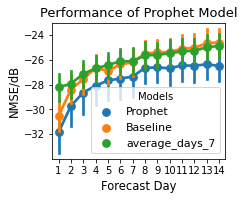

In [ ]:
set_fig_size((3.2, 2.5))
#fig, ax = plt.subplots(1, 2)
diffs = ["diff_repeat", "diff_average"]
df_models = all_predictions[~all_predictions.model.isin(diffs)].copy()
df_models.model = df_models.model.replace({"prophet" : "Prophet", "repeat" : "Baseline"})
#df_diffs = all_predictions[all_predictions.model.isin(diffs)].copy()
#df_diffs.model = df_diffs.model.replace({"diff_repeat" : "Comparison w/ Baseline Repeat", "diff_average" : "Comparison w/ Baseline Average"})

p = sns.pointplot(data = df_models, x = "prediction_horizon", y = "nmse", hue = "model")
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.set_title("Performance of Prophet Model", fontsize = fontsize)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.legend(title = "Models", fontsize = fontsize-2)

# Save fig
save_fig(plt, chapter_name = "ArticleDETI", section_name = "prophet", name_of_fig = "multivariatePerformances")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_multivariatePerformances.


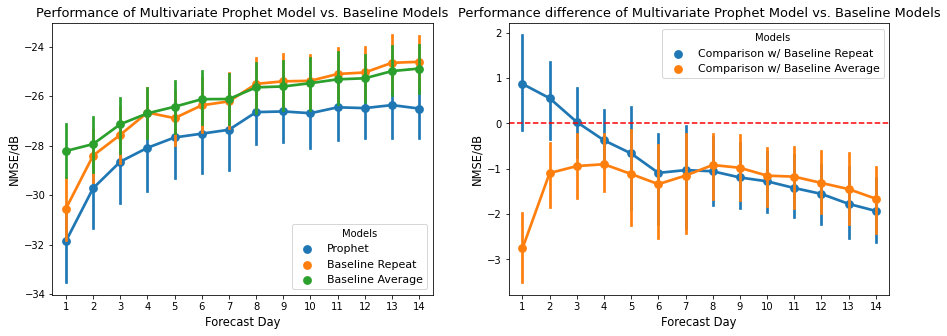

In [ ]:
set_fig_size((15, 5))
fig, ax = plt.subplots(1, 2)
df_models = all_predictions[~all_predictions.model.isin(diffs)].copy()
df_models.model = df_models.model.replace({"prophet" : "Prophet", "repeat" : "Baseline Repeat", "average_days_7" : "Baseline Average"})
df_diffs = all_predictions[all_predictions.model.isin(diffs)].copy()
df_diffs.model = df_diffs.model.replace({"diff_repeat" : "Comparison w/ Baseline Repeat", "diff_average" : "Comparison w/ Baseline Average"})

p = sns.pointplot(data = df_models, x = "prediction_horizon", y = "nmse", hue = "model", ax = ax[0])
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.set_title("Performance of Multivariate Prophet Model vs. Baseline Models", fontsize = fontsize)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.legend(title = "Models", fontsize = fontsize-2)

p = sns.pointplot(data = df_diffs, x = "prediction_horizon", y = "nmse", hue = "model", ax = ax[1])
p.axhline(0, color = "red", linestyle='--')
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.set_title("Performance difference of Multivariate Prophet Model vs. Baseline Models", fontsize = fontsize)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.legend(title = "Models", fontsize = fontsize-2, loc = "best")

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "multivariatePerformances")

In [ ]:
# Só nos dias dois e três é que não é possível afirmar coisa dos modelos
df_diffs_1 = all_predictions[all_predictions.model.isin(["diff_repeat"])].copy()
anova_1 = get_anova_results(df_diffs_1).apply(int)

df_diffs_2 = all_predictions[all_predictions.model.isin(["diff_average"])].copy()
anova_2 = get_anova_results(df_diffs_2).apply(int)

anova_1
anova_2

0    1
1    0
2    0
3    1
4    1
5    1
6    1
Name: pvalue, dtype: int64

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_multivariatePerformancesRetailersOperators.


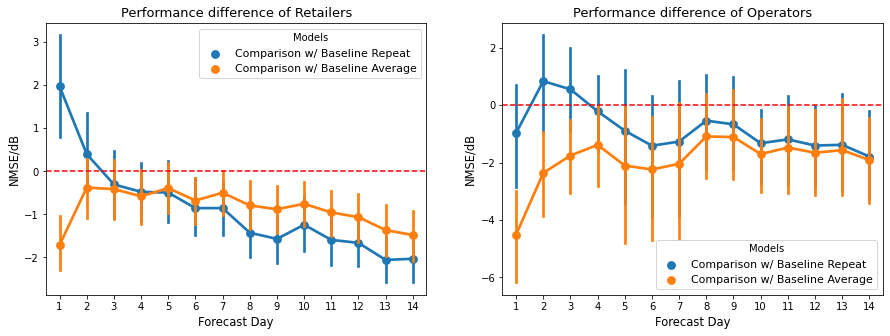

In [ ]:
set_fig_size((15,5))

fig, ax = plt.subplots(1, 2)

df_retailers = all_predictions[(all_predictions.type_company == "retailer") & (all_predictions.model.isin(diffs))].copy().replace({"diff_repeat" : "Comparison w/ Baseline Repeat", "diff_average" : "Comparison w/ Baseline Average"})
df_operators = all_predictions[(all_predictions.type_company == "operator") & (all_predictions.model.isin(diffs))].copy().replace({"diff_repeat" : "Comparison w/ Baseline Repeat", "diff_average" : "Comparison w/ Baseline Average"})

p = sns.pointplot(data = df_retailers, x = "prediction_horizon", y = "nmse", hue = "model", ax = ax[0])
p.axhline(0, color = "red", linestyle='--')
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.set_title("Performance difference of Retailers", fontsize = fontsize)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.legend(title = "Models", fontsize = fontsize-2, loc = "best")

p = sns.pointplot(data = df_operators, x = "prediction_horizon", y = "nmse", hue = "model", ax = ax[1])
p.axhline(0, color = "red", linestyle='--')
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.set_title("Performance difference of Operators", fontsize = fontsize)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.legend(title = "Models", fontsize = fontsize-2, loc = "best")

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "multivariatePerformancesRetailersOperators")

In [ ]:
# todos os dias a partir do terciero superioridade do prophet

# Só nos dias dois e três é que não é possível afirmar coisa dos modelos
df_diffs_1 = df_retailers[df_retailers.model.isin(["diff_repeat"])].copy()
anova_1 = get_anova_results(df_diffs_1).apply(int)
df_diffs_2 = df_retailers[df_retailers.model.isin(["diff_average"])].copy()
anova_2 = get_anova_results(df_diffs_2).apply(int)

df_diffs_1 = df_operators[df_operators.model.isin(["diff_repeat"])].copy()
anova_3 = get_anova_results(df_diffs_1).apply(int)
df_diffs_2 = df_operators[df_operators.model.isin(["diff_average"])].copy()
anova_4 = get_anova_results(df_diffs_2).apply(int)

anova_4

0    0
1    0
2    0
3    1
4    1
5    1
6    1
Name: pvalue, dtype: int64

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_ratePriceVariationsRetailersOperators.


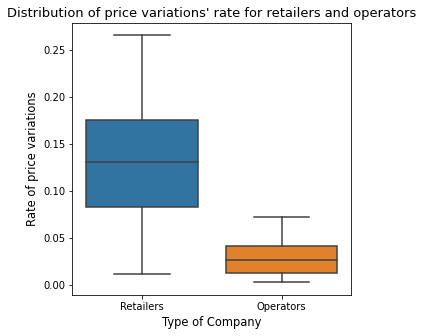

In [ ]:
set_fig_size((5, 5))
p = sns.boxplot(data = all_predictions, x = "type_company", y = "changes_samples_ratio")
p.set_ylabel("Rate of price variations", fontsize = fontsize - 1.5)
p.set_title("Distribution of price variations' rate for retailers and operators", fontsize = fontsize)
p.set_xlabel("Type of Company", fontsize = fontsize - 1.5)
p.set_xticklabels(["Retailers", "Operators"])

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "ratePriceVariationsRetailersOperators")

In [ ]:
df_models.sort_values("nmse", ascending = False)[["product_id", "product_group_id", "hyper_parameters", "type_company", "nmse", "model"]].iloc[0]

product_id                                                       1959
product_group_id                                                  594
hyper_parameters    {'changepoint_prior_scale': 0.005, 'fourier_or...
type_company                                                 operator
nmse                                                       -13.521797
model                                                         Prophet
Name: 723, dtype: object

### Reactivity

In [ ]:
def get_nmse3(y_obs, y_pred):
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")
  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))
  return nmse

def get_regression_model(X, y):
  reg = linear_model.LinearRegression()
  reg.fit(X, y)
  y_pred = reg.predict(X)
  nmse = get_nmse3(y, y_pred)
  return reg.coef_, nmse

def get_X_y(df, company_1, company_2, max_lag):

  data = prepare_prophet_data(df, company_1, "_price_euro", min_lag = 0)
  regressors_base = generate_regressors([company_1], feature_types, max_lag)
  regressors = generate_regressors([company_1, company_2], feature_types, max_lag)
  print(regressors)
  y = data["y"]
  X_base = data[regressors_base].to_numpy()
  X = data[regressors].to_numpy()

  return X, X_base, y

def permutations(iterable, r=None):
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    for indices in itertools.product(range(n), repeat=r):
        if len(set(indices)) == r:
            yield tuple(pool[i] for i in indices)

In [ ]:
target = [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
          0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 
          0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
max_lag = 3
feature_types = ["price_euro"]
product_group_id_lst_multi = [8, 153, 245, 334, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 405, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]

product_group_id = product_group_id_lst_multi[1]

df_product_group_id = select_df_product_group_id(df_country_min_max, product_group_id)
df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag)

companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]

company_1 = companies[2]
company_2 = companies[3]
#company_2 = "max_" + company_1

data = prepare_prophet_data(df_product_group_id, company_1, "_price_euro")
regressors_base = generate_regressors([company_1], feature_types, max_lag)
regressors = generate_regressors([company_1, company_2], feature_types, max_lag)
y = data["y"]
X_base = data[regressors_base].to_numpy()
X = data[regressors].to_numpy()

In [ ]:
X_list = np.array_split(X, 3)
X_base_list = np.array_split(X_base, 3)
y_list = np.array_split(y, 3)

reg_coefs = []
nmses = []
nmses_base = []

print("Company: ", company_1)
print("Company compare: ", company_2)

for X, X_base, y in zip(X_list, X_base_list, y_list):

  reg = linear_model.LinearRegression()
  reg.fit(X, y)
  y_pred = reg.predict(X)

  reg_base = linear_model.LinearRegression()
  reg_base.fit(X_base, y)
  y_pred_base = reg_base.predict(X_base)

  nmse = get_nmse3(y, y_pred)
  nmse_base = get_nmse3(y, y_pred_base)
  nmses.append(nmse)
  nmses_base.append(nmse_base)

  print("NMSE_base:", nmse_base)
  print("NMSE:", nmse)

  reg_coefs.append(reg.coef_)

coefs = pd.DataFrame([regressors] + reg_coefs).T
coefs.columns = ["regressor", "coef1", "coef2", "coef3"]
#coefs.sort_values("coef", ascending = False)

Company:  Radio Popular
Company compare:  Worten
NMSE_base: -27.45462173381286
NMSE: -28.23512667895777
NMSE_base: -26.535399327013103
NMSE: -26.971040098317737
NMSE_base: -21.938408640380167
NMSE: -22.024836550148528


In [ ]:
coefs.sort_values("coef3", ascending = False)

NameError: ignored

In [ ]:
results = pd.read_pickle("prophet_multivariate_reactivity")

In [ ]:
results_flt = results.iloc[0:3*340]
#results_flt = results.iloc[0:3*210]
results_flt["target"] = target
condition4 = (results_flt.nmse > -50) & (results_flt.nmse_base > -50)
results_flt = results_flt[condition4]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_logisticRegressionFeatures.


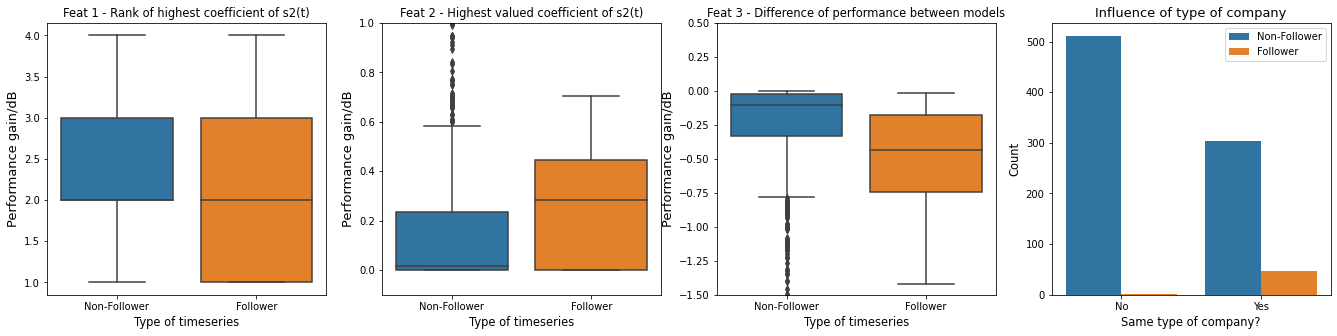

In [ ]:
set_fig_size((23, 5))
fig, ax = plt.subplots(1, 4)

p = sns.boxplot(data = results_flt, x = "target", y = "other_coef_rank", ax = ax[0])
p.set_title("Feat 1 - Rank of highest coefficient of s2(t)", fontsize = fontsize - 1.5)
p.set_ylabel("Performance gain/dB", fontsize = fontsize)
p.set_xlabel("Type of timeseries", fontsize = fontsize - 1.5)
p.set_xticklabels(["Non-Follower", "Follower"])
#p.set_ylim(-0.1, 1)

results_flt_inv = results_flt.copy()
results_flt_inv.nmse_diff = -results_flt_inv.nmse_diff
p = sns.boxplot(data = results_flt_inv, x = "target", y = "other_company_coef", ax = ax[1])
p.set_title("Feat 2 - Highest valued coefficient of s2(t)", fontsize = fontsize - 1.5)
p.set_ylabel("Performance gain/dB", fontsize = fontsize)
p.set_xlabel("Type of timeseries", fontsize = fontsize - 1.5)
p.set_xticklabels(["Non-Follower", "Follower"])
p.set_ylim(-0.1, 1)

p = sns.boxplot(data = results_flt, x = "target", y = "nmse_diff", ax = ax[2])
p.set_title("Feat 3 - Difference of performance between models", fontsize = fontsize - 1.5)
p.set_ylabel("Performance gain/dB", fontsize = fontsize)
p.set_xlabel("Type of timeseries", fontsize = fontsize - 1.5)
p.set_xticklabels(["Non-Follower", "Follower"])
p.set_ylim(-1.5, 0.5)

p = sns.countplot(data = results_flt, x = "same_type", hue = "target", ax = ax[3])
p.set_ylabel("Count", fontsize = fontsize - 1.5)
p.set_title("Influence of type of company", fontsize = fontsize)
p.set_xlabel("Same type of company?", fontsize = fontsize - 1.5)
p.set_xticklabels(["No", "Yes"])
p.legend(["Non-Follower", "Follower"])

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "logisticRegressionFeatures")

[Text(0, 0, 'Non-Follower'), Text(0, 0, 'Follower')]

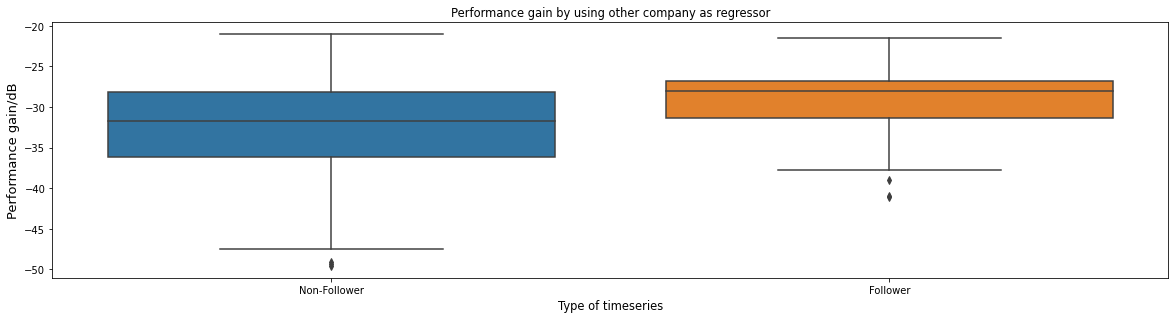

In [ ]:
results_flt_inv = results_flt.copy()
results_flt_inv.nmse_diff = -results_flt_inv.nmse_diff
p = sns.boxplot(data = results_flt, x = "target", y = "nmse")
p.set_title("Performance gain by using other company as regressor", fontsize = fontsize - 1.5)
p.set_ylabel("Performance gain/dB", fontsize = fontsize)
p.set_xlabel("Type of timeseries", fontsize = fontsize - 1.5)
p.set_xticklabels(["Non-Follower", "Follower"])
#p.set_ylim(-0.25, 1.5)

[Text(0, 0, 'Non-Follower'), Text(0, 0, 'Follower')]

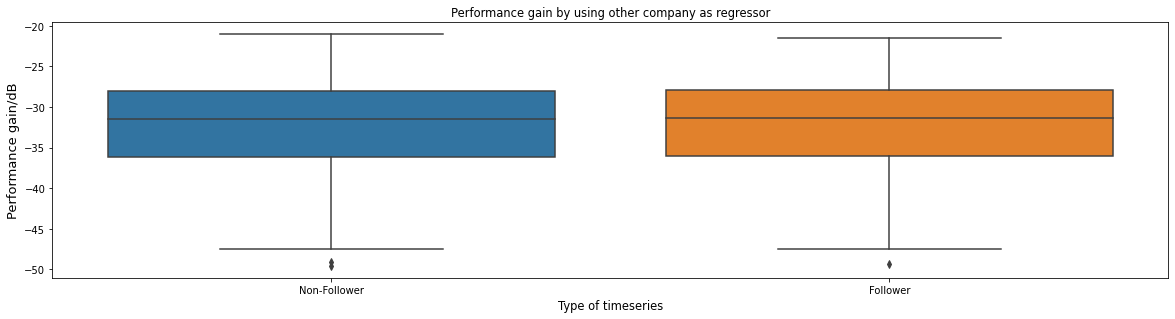

In [ ]:
results_flt_inv = results_flt.copy()
results_flt_inv.nmse_diff = -results_flt_inv.nmse_diff
p = sns.boxplot(data = results_flt, x = "same_type", y = "nmse")
p.set_title("Performance gain by using other company as regressor", fontsize = fontsize - 1.5)
p.set_ylabel("Performance gain/dB", fontsize = fontsize)
p.set_xlabel("Type of timeseries", fontsize = fontsize - 1.5)
p.set_xticklabels(["Non-Follower", "Follower"])
#p.set_ylim(-0.25, 1.5)

Best cross-validation score: 0.7930
Best parameters:
{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}
Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_confusionMatrixLogisticRegression.
              precision    recall  f1-score   support

Not Follower       1.00      0.63      0.77       814
    Follower       0.13      0.96      0.24        49

    accuracy                           0.65       863
   macro avg       0.57      0.79      0.50       863
weighted avg       0.95      0.65      0.74       863

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_confusionMatrixLogisticRegressionJustSameType.


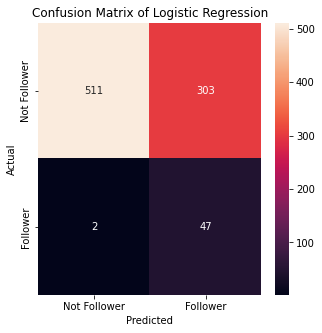

In [ ]:
def show_confusion_matrix(model, X, y, classes, title = None):
  
  # Get predictions with cross-validation
  y_pred = cross_val_predict(model, X, y)
  y_true = y

  # Confusion matrix
  fig, ax = plt.subplots(figsize=(5,5))
  conf_mat = confusion_matrix(y_true, y_pred)#, labels = classes)
  sns.heatmap(conf_mat, annot = True, fmt = 'd', xticklabels = classes, yticklabels = classes)
  plt.title(title)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  #plt.show()

  # Save fig
  save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "confusionMatrixLogisticRegression")
  # Classification report

  print(classification_report(y_true, y_pred, target_names=classes))

  return y_pred

def train_model(X, y, model, param_grid, cv, display_confusion_matrix, scoring = "accuracy", classes = [], title = None):
  
  # Search for best parameters
  model_grid = GridSearchCV(model, param_grid, cv = cv, scoring = scoring)   
  model_grid.fit(X, y)

  # Print best parameters
  print("Best cross-validation score: {:.4f}".format(model_grid.best_score_))
  print("Best parameters:\n{}".format(model_grid.best_params_))

  if display_confusion_matrix:
    y_pred = show_confusion_matrix(model_grid, X, y, classes, title = title)

  class_report = classification_report(y, y_pred, target_names=classes, output_dict = True)

  return model_grid, class_report


title = "hi"

y = results_flt["target"]
#X = results_flt[['nmse_diff', "other_coef_rank", "other_company_coef"]]
X = results_flt[["same_type"]]
#X = results_flt[['nmse_diff', "other_coef_rank", "other_company_coef", "same_type"]]
#X = results_flt[['nmse_diff', "other_coef_rank", "same_type"]]

#X = np.random.normal(0, 1, (len(results_flt[["same_type"]]), 2))
#X.same_Type = X.same_type.apply(int)
#X.contains_company_2 = X.contains_company_2.apply(int)

log_reg = make_pipeline(MinMaxScaler(), LogisticRegression(solver = "newton-cg", class_weight = "balanced" ))   
param_grid = {'logisticregression__C': [ 0.001, 0.01, 0.1, 1, 10, 100],
              'logisticregression__penalty': ['l2', "none"]}

warnings.filterwarnings("ignore")
log_reg, class_report = train_model(X, y, log_reg, param_grid, cv = 6, display_confusion_matrix = True, scoring = "balanced_accuracy", classes = ["Not Follower", "Follower"], title = "Confusion Matrix of Logistic Regression")
warnings.filterwarnings("always")

# Save fig
#save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "confusionMatrixLogisticRegressionWoSameType")     # 66.62
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "confusionMatrixLogisticRegressionJustSameType")  # 79.30
#save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "confusionMatrixLogisticRegression")              # 79.30
#80 %

In [ ]:
print(log_reg.best_estimator_.named_steps['logisticregression'].coef_)
#'nmse_diff', 'contains_company_2', 'ratio_first_coefs', 'same_type', other_company_coef, nmse

[[-5.50149034 -0.98871435  3.55900923]]


In [ ]:
target_2 = [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 
            1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 
            1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 
            0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
            0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
            0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
            1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 
            1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 
            1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
a = 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
len(a)

30

Period:  2
Company Second:  Vodafone
Ratio_first_coefs:  0.05697542918819103
compare_1_lag:  -31.234829723359823
compare_2_lag:  -31.51306992767171
compare_3_lag:  -31.65845178304599


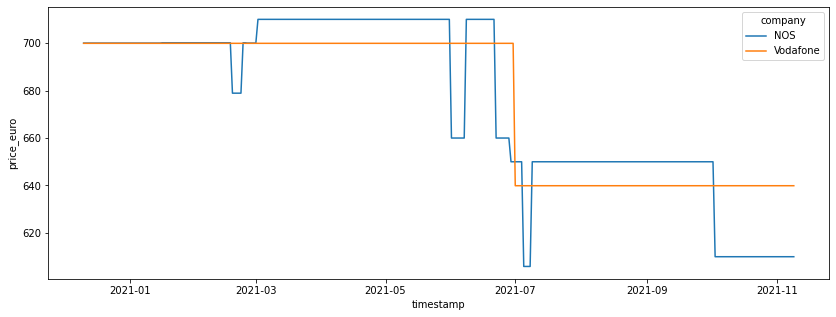

In [ ]:
i = 3*209
pairs = results_flt.copy()
product_group_id = pairs.product_group_id.iloc[i]
company_1 = pairs.company_1.iloc[i]
company_2 = pairs.company_2.iloc[i]
print("Period: ", pairs.period.iloc[i])
print("Company Second: ", pairs.company_1.iloc[i])
print("Ratio_first_coefs: ", pairs.ratio_first_coefs.iloc[i])
print("compare_1_lag: ", pairs.compare_1_lag.iloc[i])
print("compare_2_lag: ", pairs.compare_2_lag.iloc[i])
print("compare_3_lag: ", pairs.compare_3_lag.iloc[i])
df_product_group_id = df_country[df_country.product_group_id == product_group_id]
set_fig_size((14, 5))
p = sns.lineplot(data = df_product_group_id[df_product_group_id.company.isin([company_1, company_2])], x = "timestamp", y = "price_euro", hue = "company")

In [ ]:
# Initializations
results = []                       # store all info of each hyper-paramter for each timeseries

init_count = 0
end_count = 29
count = init_count-1

max_lag = 3
feature_types = ["price_euro"]

product_group_id_lst_multi = [8, 153, 245, 334, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 405, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]

for product_group_id in product_group_id_lst_multi[init_count:end_count+1]:

  count = count + 1

  # Select product_group_id
  df_product_group_id = select_df_product_group_id(df_country_min_max, product_group_id)
  df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag)

  companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]

  print("Count: ", count)
  print("Product Group ID: ", product_group_id)
  print("Existing companies: ", companies)
  
  for pair in permutations(companies, 2):

    company_1 = pair[0]
    company_2 = pair[1]
    type_company_1 = is_retailer_operator(company_1, df_product_group_id.country.unique()[0])
    type_company_2 = is_retailer_operator(company_2, df_product_group_id.country.unique()[0])

    print("\tCompany: ", company_1)
    
    # Get product basic informations
    product_id_1 = df_product_group_id[df_product_group_id.company == company_1].index.get_level_values(0).unique()[0]
    product_id_2 = df_product_group_id[df_product_group_id.company == company_2].index.get_level_values(0).unique()[0]
    base_info = {"product_id_1": product_id_1,
                 "product_id_2": product_id_2,
                 "company_1": company_1,
                 "company_2": company_2,
                 "product_group_id": product_group_id,
                 "country": df_product_group_id.country.unique()[0],
                 "product_group_characteristic": characterize_product_group(product_group_id),
                 "companies": companies,
                 "type_company_1": type_company_1,
                 "type_company_2": type_company_2}

    X, X_base, y = get_X_y(df_product_group_id, company_1, company_2, max_lag)

    X_list = np.array_split(X, 3)
    X_base_list = np.array_split(X_base, 3)
    y_list = np.array_split(y, 3)

    period = 0
    for X, X_base, y in zip(X_list, X_base_list, y_list):

      period = period + 1
      
      coef, nmse = get_regression_model(X, y)
      tmp, nmse_base = get_regression_model(X_base, y)

      regressors = generate_regressors([company_1, company_2], feature_types, max_lag)

      coefs = pd.DataFrame([regressors, coef]).T
      coefs.columns = ["regressor", "coef"]
      coefs["coef"] = coefs["coef"].apply(np.abs)
      coefs = coefs.sort_values("coef", ascending = False)

      if (coefs.regressor.iloc[0].split('_')[0] == company_2) | (coefs.regressor.iloc[1].split('_')[0] == company_2):
        contains_company_2 = True
      else:
        contains_company_2 = False

      if (coefs.regressor.iloc[0].split('_')[0] == company_2):
        ratio_first_coefs = 1
        other_company_coef = coefs.coef.iloc[0]
      elif contains_company_2:
        ratio_first_coefs = coefs.coef.iloc[1]/coefs.coef.iloc[0]
        other_company_coef = coefs.coef.iloc[1]
      else:
        ratio_first_coefs = 0
        other_company_coef = 0

      if (coefs.regressor.iloc[0].split('_')[0] == company_2):
        other_coef_rank = 1
      elif (coefs.regressor.iloc[1].split('_')[0] == company_2):
        other_coef_rank = 2
      elif (coefs.regressor.iloc[2].split('_')[0] == company_2):
        other_coef_rank = 3
      elif (coefs.regressor.iloc[3].split('_')[0] == company_2):
        other_coef_rank = 4
      elif (coefs.regressor.iloc[4].split('_')[0] == company_2):
        other_coef_rank = 5
      elif (coefs.regressor.iloc[5].split('_')[0] == company_2):
        other_coef_rank = 6


      new_info = {"period" : period,
                  "coefs" : coefs,
                  "nmse" : nmse,
                  "nmse_base" : nmse_base,
                  "nmse_diff" : nmse - nmse_base,
                  "contains_company_2" : int(contains_company_2),
                  "first" : int(coefs.regressor.iloc[0].split('_')[0] == company_2),
                  "second" : int(coefs.regressor.iloc[0].split('_')[1] == company_2),
                  "thrid" : int(coefs.regressor.iloc[0].split('_')[3] == company_2),
                  "compare_1_lag" : get_nmse3(y, X[:,max_lag]),
                  "compare_2_lag" : get_nmse3(y, X[:,max_lag+1]),
                  "compare_3_lag" : get_nmse3(y, X[:,max_lag+2]),
                  "ratio_first_coefs" : ratio_first_coefs,
                  "same_type" : int(type_company_1 == type_company_2),
                  "other_company_coef" : other_company_coef,
                  "other_coef_rank" : other_coef_rank}
                  
      info = base_info.copy()
      info.update(new_info)
      results.append(info)
    
results = pd.DataFrame(results)
results.to_pickle("prophet_multivariate_reactivity")

Count:  0
Product Group ID:  8
Existing companies:  ['Media Markt', 'MEO', 'Worten', 'Vodafone', 'Radio Popular']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Vodafone_pri

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Vodafone


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Radio Popular


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
Count:  1
Product Group ID:  153
Existing companies:  ['Vodafone', 'MEO', 'Radio Popular', 'Worten', 'Media Markt']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 


	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Radio Popular


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
Count:  8
Product Group ID:  551
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero

	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_eu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	C

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Worten


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
Count:  11
Product Group ID:  601
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  NO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero

	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media Markt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Vodafone_price_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
Count:  14
Product Group ID:  405
Existing companies:  ['Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten', 'NOS']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Mar

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
Count:  16
Product Group ID:  574
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Radio Popular


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
Count:  17
Product Group ID:  370
Existing companies:  ['NOS', 'Vodafone', 'Media Markt', 'Radio Popular', 'MEO', 'Worten']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  NOS
['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Vodafone


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero

['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  MEO


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
Count:  20
Product Group ID:  424
Existing companies:  ['Vodafone', 'Radio Popular', 'Worten', 'Media Markt']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Vodafone


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Vodafone
['Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Mark

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Comp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Worten
['Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
Count:  23
Product Group ID:  468
Existing companies:  ['Media Markt', 'Radio Popular', 'MEO', 'Worten', 'Vodafone']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after 

['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Vodafone_price_euro_lag_1', 'Vodafone_price_euro_lag_2', 'Vodafone_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  MEO
['MEO_price_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero

Count:  24
Product Group ID:  594
Existing companies:  ['Radio Popular', 'MEO', 'Worten', 'NOS', 'Media Markt']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']
	Company:  Radio Popular
['Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  MEO
['MEO_price_euro_lag_1', 'MEO_price_euro

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3', 'Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Radio Popular_price_euro_lag_1', 'Radio Popular_price_euro_lag_2', 'Radio Popular_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'MEO_price_euro_lag_1', 'MEO_price_euro_lag_2', 'MEO_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'Worten_price_euro_lag_1', 'Worten_price_euro_lag_2', 'Worten_price_euro_lag_3']
	Company:  Media Markt
['Media Markt_price_euro_lag_1', 'Media Markt_price_euro_lag_2', 'Media Markt_price_euro_lag_3', 'NOS_price_euro_lag_1', 'NOS_price_euro_lag_2', 'NOS_price_euro_lag_3']


In [ ]:
coefs["coef"]

0    0.736111
2    0.236111
5    0.037759
4    0.037759
3    0.037759
1         0.5
Name: coef, dtype: object